In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import joblib
import csv
import optuna

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
    classification_report, f1_score, accuracy_score,
    precision_score, recall_score, confusion_matrix
)
from sklearn.model_selection import StratifiedShuffleSplit
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD

warnings.filterwarnings("ignore", category=UserWarning)

# === Ruta base ===
base_path = os.getcwd()
csv_path = os.path.join(base_path, "df_train.csv")

# === 1. Cargar datos ===
df = pd.read_csv(csv_path)
df['time'] = pd.to_datetime(df['time'])
df['year'] = df['time'].dt.year
df['month'] = df['time'].dt.month
df['week'] = df['time'].dt.isocalendar().week
df['hour'] = df['time'].dt.hour
df['weekday'] = df['time'].dt.weekday

# === 2. Filtrar y preparar ===
df = df[(df['signal'] == 1) & (df['label'].notna())].copy()
df['label'] = df['label'].astype(int)

features_cols = [
    'close', 'sma_200_vs_100', 'sma_50_vs_25', 'rsi_14', 'acceleration_12',
    'macd', 'stoch_k', 'momentum_12', 'bb_middle', 'bb_upper', 'bb_lower',
    'weighted_close', 'poc_12', 'high_channel_20', 'low_channel_20',
    'abs_diff_mrb_vs_close', 'last_signal_price_1', 'last_signal_price_2',
    'last_signal_price_3', 'last_signal_price_4', 'last_signal_price_5',
    'hour', 'weekday'
]

# === 3. Walk-forward semanal ===
df['year_week'] = df['time'].dt.strftime('%Y-%U')
unique_periods = sorted(df['year_week'].unique())
min_train_weeks = 12

scores, accs, precs, recalls, dropouts, lrs, moms = [], [], [], [], [], [], []
final_model = None

results_path = os.path.join(base_path, "results_walkforward_weekly_keras_optuna.csv")

with open(results_path, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["Periodo", "F1_Score", "Accuracy", "Precision", "Recall", "Dropout", "LR", "Momentum"])

    for i in range(min_train_weeks, len(unique_periods) - 1):
        train_periods = unique_periods[i - min_train_weeks:i]
        test_period = unique_periods[i]

        df_train = df[df['year_week'].isin(train_periods)].copy()
        df_test = df[df['year_week'] == test_period].copy()

        if df_train.empty or df_test.empty:
            continue

        X_train = df_train[features_cols].fillna(0).values
        y_train = df_train['label'].values
        X_test = df_test[features_cols].fillna(0).values
        y_test = df_test['label'].values

        scaler = MinMaxScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        def create_model(trial):
            model = Sequential()
            n_units1 = trial.suggest_int('n_units1', 32, 96)
            n_units2 = trial.suggest_int('n_units2', 16, 48)
            dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
            learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-1, log=True)
            momentum = trial.suggest_float('momentum', 0.0, 0.9)

            model.add(Dense(n_units1, activation='tanh', input_shape=(X_train.shape[1],)))
            model.add(Dropout(dropout_rate))
            model.add(Dense(n_units2, activation='tanh'))
            model.add(Dropout(dropout_rate))
            model.add(Dense(1, activation='sigmoid'))

            opt = SGD(learning_rate=learning_rate, momentum=momentum)
            model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
            return model

        def objective(trial):
            model = create_model(trial)
            es = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
            model.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=32, callbacks=[es], verbose=0)
            y_pred = model.predict(X_test).flatten()
            y_pred = (y_pred > 0.5).astype(int)
            return f1_score(y_test, y_pred, average='weighted')

        study = optuna.create_study(direction='maximize')
        study.optimize(objective, n_trials=20, timeout=600)

        best_trial = study.best_trial
        best_model = create_model(best_trial)
        best_model.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=32, callbacks=[EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)], verbose=0)

        y_pred_probs = best_model.predict(X_test).flatten()
        y_pred = (y_pred_probs > 0.5).astype(int)

        f1 = f1_score(y_test, y_pred, average='weighted')
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred)
        rec = recall_score(y_test, y_pred)

        scores.append(f1)
        accs.append(acc)
        precs.append(prec)
        recalls.append(rec)
        dropouts.append(best_trial.params['dropout_rate'])
        lrs.append(best_trial.params['learning_rate'])
        moms.append(best_trial.params['momentum'])

        print("\nMatriz de confusión:")
        print(confusion_matrix(y_test, y_pred))

        writer.writerow([test_period, f1, acc, prec, rec, best_trial.params['dropout_rate'], best_trial.params['learning_rate'], best_trial.params['momentum']])
        final_model = best_model

# === Guardar el modelo final ===
if final_model:
    final_model.save(os.path.join(base_path, "best_model_walkforward_keras_optuna.h5"))
    print("\u2705 Modelo Keras-Optuna guardado como best_model_walkforward_keras_optuna.h5")

# === Visualización ===
print("\n\ud83d\udcca Métricas promedio generales:")
print(f"\ud83d\udd39 F1 Score promedio:      {np.mean(scores):.4f}")
print(f"\ud83d\udd39 Accuracy promedio:      {np.mean(accs):.4f}")
print(f"\ud83d\udd39 Precision promedio:     {np.mean(precs):.4f}")
print(f"\ud83d\udd39 Recall promedio:        {np.mean(recalls):.4f}")

plt.figure(figsize=(10, 5))
plt.plot(scores, marker='o', label='F1 Score')
plt.axhline(np.mean(scores), color='red', linestyle='--', label='Promedio F1')
plt.title('Walk-Forward Weekly - F1 Score (Keras + Optuna)')
plt.xlabel('Fold')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



[I 2025-05-24 17:49:54,201] A new study created in memory with name: no-name-fbdb1144-88dd-4ae1-b1b8-425eb59dcd25


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


[I 2025-05-24 17:50:04,543] Trial 0 finished with value: 1.0 and parameters: {'n_units1': 91, 'n_units2': 33, 'dropout_rate': 0.3960646854696658, 'learning_rate': 0.0002584279796694641, 'momentum': 0.25346088716400406}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


[I 2025-05-24 17:50:14,941] Trial 1 finished with value: 1.0 and parameters: {'n_units1': 89, 'n_units2': 27, 'dropout_rate': 0.4958623210307542, 'learning_rate': 0.00028172090352666083, 'momentum': 0.49090133570988476}. Best is trial 0 with value: 1.0.


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/stepWARNING:tensorflow:6 out of the last 6 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000001F70BC4D300> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


[I 2025-05-24 17:50:19,082] Trial 2 finished with value: 1.0 and parameters: {'n_units1': 46, 'n_units2': 22, 'dropout_rate': 0.32305683480921804, 'learning_rate': 0.00950007424055186, 'momentum': 0.26249476011850575}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


[I 2025-05-24 17:50:28,824] Trial 3 finished with value: 1.0 and parameters: {'n_units1': 33, 'n_units2': 24, 'dropout_rate': 0.34895742513597494, 'learning_rate': 0.0002016432259035444, 'momentum': 0.1670355463967593}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


[I 2025-05-24 17:50:30,657] Trial 4 finished with value: 1.0 and parameters: {'n_units1': 73, 'n_units2': 32, 'dropout_rate': 0.2973924660386405, 'learning_rate': 0.06611780642361448, 'momentum': 0.05964160432219582}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-05-24 17:50:40,385] Trial 5 finished with value: 1.0 and parameters: {'n_units1': 84, 'n_units2': 43, 'dropout_rate': 0.37566225113920604, 'learning_rate': 0.000767232836085413, 'momentum': 0.44579811560408744}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


[I 2025-05-24 17:50:42,262] Trial 6 finished with value: 1.0 and parameters: {'n_units1': 62, 'n_units2': 35, 'dropout_rate': 0.4888199270722148, 'learning_rate': 0.03852622716602251, 'momentum': 0.15810301657650916}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


[I 2025-05-24 17:50:44,019] Trial 7 finished with value: 1.0 and parameters: {'n_units1': 83, 'n_units2': 40, 'dropout_rate': 0.3146125578999497, 'learning_rate': 0.08193086276023617, 'momentum': 0.3256565493257717}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


[I 2025-05-24 17:50:51,558] Trial 8 finished with value: 1.0 and parameters: {'n_units1': 40, 'n_units2': 19, 'dropout_rate': 0.3854664282692666, 'learning_rate': 0.001030359924829105, 'momentum': 0.7285164776567694}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


[I 2025-05-24 17:50:53,666] Trial 9 finished with value: 1.0 and parameters: {'n_units1': 44, 'n_units2': 46, 'dropout_rate': 0.32065566200047996, 'learning_rate': 0.07674562017217884, 'momentum': 0.676992831543709}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2025-05-24 17:50:57,732] Trial 10 finished with value: 1.0 and parameters: {'n_units1': 96, 'n_units2': 32, 'dropout_rate': 0.1451327729049261, 'learning_rate': 0.004515175050734784, 'momentum': 0.5692030104221403}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


[I 2025-05-24 17:51:07,783] Trial 11 finished with value: 1.0 and parameters: {'n_units1': 96, 'n_units2': 27, 'dropout_rate': 0.4989464901392515, 'learning_rate': 0.0001182137649124108, 'momentum': 0.8841633168918068}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 17:51:17,663] Trial 12 finished with value: 1.0 and parameters: {'n_units1': 83, 'n_units2': 28, 'dropout_rate': 0.43311871534501306, 'learning_rate': 0.0005000011232536209, 'momentum': 0.4355350989560619}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 17:51:27,692] Trial 13 finished with value: 1.0 and parameters: {'n_units1': 64, 'n_units2': 16, 'dropout_rate': 0.4308351595897426, 'learning_rate': 0.0002819796629898932, 'momentum': 0.33842221636806213}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


[I 2025-05-24 17:51:35,979] Trial 14 finished with value: 1.0 and parameters: {'n_units1': 72, 'n_units2': 38, 'dropout_rate': 0.2398537223072495, 'learning_rate': 0.0015770273779985057, 'momentum': 0.4675833695702026}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 17:51:45,693] Trial 15 finished with value: 1.0 and parameters: {'n_units1': 92, 'n_units2': 29, 'dropout_rate': 0.4366061170418082, 'learning_rate': 0.00010269947109701448, 'momentum': 0.5841136111689348}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


[I 2025-05-24 17:51:54,576] Trial 16 finished with value: 1.0 and parameters: {'n_units1': 55, 'n_units2': 35, 'dropout_rate': 0.24967039035713093, 'learning_rate': 0.0021546196545103847, 'momentum': 0.22482055668577156}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


[I 2025-05-24 17:52:04,210] Trial 17 finished with value: 1.0 and parameters: {'n_units1': 74, 'n_units2': 24, 'dropout_rate': 0.4545325470151903, 'learning_rate': 0.0005303861159455456, 'momentum': 0.07200008798625346}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


[I 2025-05-24 17:52:08,828] Trial 18 finished with value: 1.0 and parameters: {'n_units1': 88, 'n_units2': 37, 'dropout_rate': 0.3969466284573148, 'learning_rate': 0.007155633591896762, 'momentum': 0.003501849349582642}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 17:52:18,607] Trial 19 finished with value: 1.0 and parameters: {'n_units1': 78, 'n_units2': 30, 'dropout_rate': 0.4598515739106548, 'learning_rate': 0.0002653588425585178, 'momentum': 0.38153334020331253}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


[I 2025-05-24 17:52:28,310] A new study created in memory with name: no-name-da3f3f16-5b52-49eb-8431-85729083c76c



Matriz de confusión:
[[57]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


[I 2025-05-24 17:52:38,423] Trial 0 finished with value: 1.0 and parameters: {'n_units1': 47, 'n_units2': 40, 'dropout_rate': 0.2841736480910936, 'learning_rate': 0.003526146710540131, 'momentum': 0.15485030755752083}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


[I 2025-05-24 17:52:48,365] Trial 1 finished with value: 1.0 and parameters: {'n_units1': 43, 'n_units2': 41, 'dropout_rate': 0.17076507083023978, 'learning_rate': 0.0001853487464509992, 'momentum': 0.6177687739280231}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


[I 2025-05-24 17:52:50,031] Trial 2 finished with value: 1.0 and parameters: {'n_units1': 36, 'n_units2': 34, 'dropout_rate': 0.11127747412347344, 'learning_rate': 0.08988847854155405, 'momentum': 0.7528800272681316}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2025-05-24 17:53:00,088] Trial 3 finished with value: 1.0 and parameters: {'n_units1': 45, 'n_units2': 35, 'dropout_rate': 0.29313565468790115, 'learning_rate': 0.001434565737343782, 'momentum': 0.5495022049999795}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 17:53:10,129] Trial 4 finished with value: 1.0 and parameters: {'n_units1': 72, 'n_units2': 34, 'dropout_rate': 0.3549611747899638, 'learning_rate': 0.0001072359142270108, 'momentum': 0.6966617182395027}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


[I 2025-05-24 17:53:20,029] Trial 5 finished with value: 1.0 and parameters: {'n_units1': 69, 'n_units2': 30, 'dropout_rate': 0.4088094188636445, 'learning_rate': 0.0007777213892695204, 'momentum': 0.7672495274546223}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


[I 2025-05-24 17:53:32,845] Trial 6 finished with value: 1.0 and parameters: {'n_units1': 94, 'n_units2': 27, 'dropout_rate': 0.30488088456552254, 'learning_rate': 0.0031595082626893253, 'momentum': 0.7563395521029348}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


[I 2025-05-24 17:53:49,187] Trial 7 finished with value: 1.0 and parameters: {'n_units1': 82, 'n_units2': 34, 'dropout_rate': 0.23236290206979604, 'learning_rate': 0.01133927765443456, 'momentum': 0.11337571267321848}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


[I 2025-05-24 17:54:05,004] Trial 8 finished with value: 1.0 and parameters: {'n_units1': 55, 'n_units2': 38, 'dropout_rate': 0.3898270718535978, 'learning_rate': 0.00014065574644226653, 'momentum': 0.354052888130359}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


[I 2025-05-24 17:54:20,849] Trial 9 finished with value: 1.0 and parameters: {'n_units1': 66, 'n_units2': 27, 'dropout_rate': 0.19718356434352266, 'learning_rate': 0.0008815653776160033, 'momentum': 0.714518881141749}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


[I 2025-05-24 17:54:36,023] Trial 10 finished with value: 1.0 and parameters: {'n_units1': 53, 'n_units2': 48, 'dropout_rate': 0.49697480431242413, 'learning_rate': 0.014195700986990653, 'momentum': 0.0035410638896929414}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


[I 2025-05-24 17:54:52,192] Trial 11 finished with value: 1.0 and parameters: {'n_units1': 34, 'n_units2': 44, 'dropout_rate': 0.15123872808112546, 'learning_rate': 0.00040290047859704517, 'momentum': 0.33506551282481745}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


[I 2025-05-24 17:55:08,484] Trial 12 finished with value: 1.0 and parameters: {'n_units1': 47, 'n_units2': 41, 'dropout_rate': 0.22937448277397357, 'learning_rate': 0.0077364289727077035, 'momentum': 0.48567196936120133}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


[I 2025-05-24 17:55:24,717] Trial 13 finished with value: 1.0 and parameters: {'n_units1': 43, 'n_units2': 43, 'dropout_rate': 0.2897711985882395, 'learning_rate': 0.0030261131324554073, 'momentum': 0.2495382390276621}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


[I 2025-05-24 17:55:41,741] Trial 14 finished with value: 1.0 and parameters: {'n_units1': 57, 'n_units2': 19, 'dropout_rate': 0.16524707103812605, 'learning_rate': 0.034457901083026904, 'momentum': 0.5349989193253541}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


[I 2025-05-24 17:55:57,782] Trial 15 finished with value: 1.0 and parameters: {'n_units1': 40, 'n_units2': 48, 'dropout_rate': 0.2557444225576948, 'learning_rate': 0.000317704390193411, 'momentum': 0.206780091126363}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


[I 2025-05-24 17:56:08,104] Trial 16 finished with value: 1.0 and parameters: {'n_units1': 49, 'n_units2': 39, 'dropout_rate': 0.1109571147525623, 'learning_rate': 0.0048894061882205405, 'momentum': 0.870950390404604}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


[I 2025-05-24 17:56:23,914] Trial 17 finished with value: 1.0 and parameters: {'n_units1': 58, 'n_units2': 44, 'dropout_rate': 0.3400461020030846, 'learning_rate': 0.00200003682403772, 'momentum': 0.598152554849277}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[I 2025-05-24 17:56:38,817] Trial 18 finished with value: 1.0 and parameters: {'n_units1': 75, 'n_units2': 38, 'dropout_rate': 0.45468753432444176, 'learning_rate': 0.0002524488868736255, 'momentum': 0.386215493884872}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


[I 2025-05-24 17:56:44,448] Trial 19 finished with value: 1.0 and parameters: {'n_units1': 32, 'n_units2': 16, 'dropout_rate': 0.18392876317622475, 'learning_rate': 0.030117225584127858, 'momentum': 0.04870280621061347}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


[I 2025-05-24 17:56:54,219] A new study created in memory with name: no-name-e938fe38-d912-4afd-822f-c4c19f766be2



Matriz de confusión:
[[12]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


[I 2025-05-24 17:57:03,664] Trial 0 finished with value: 0.8658008658008658 and parameters: {'n_units1': 65, 'n_units2': 46, 'dropout_rate': 0.41369779759361724, 'learning_rate': 0.00892224561072339, 'momentum': 0.04849752896105932}. Best is trial 0 with value: 0.8658008658008658.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 17:57:13,111] Trial 1 finished with value: 0.8658008658008658 and parameters: {'n_units1': 82, 'n_units2': 24, 'dropout_rate': 0.2294927155631945, 'learning_rate': 0.0009476153157686761, 'momentum': 0.7298974536506009}. Best is trial 0 with value: 0.8658008658008658.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


[I 2025-05-24 17:57:22,527] Trial 2 finished with value: 0.8658008658008658 and parameters: {'n_units1': 81, 'n_units2': 33, 'dropout_rate': 0.16069659862736577, 'learning_rate': 0.003664716374418108, 'momentum': 0.17624652444701785}. Best is trial 0 with value: 0.8658008658008658.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-05-24 17:57:26,896] Trial 3 finished with value: 0.8658008658008658 and parameters: {'n_units1': 37, 'n_units2': 33, 'dropout_rate': 0.17537724085843448, 'learning_rate': 0.029428462062556067, 'momentum': 0.7018929209353603}. Best is trial 0 with value: 0.8658008658008658.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


[I 2025-05-24 17:57:34,632] Trial 4 finished with value: 0.8658008658008658 and parameters: {'n_units1': 57, 'n_units2': 47, 'dropout_rate': 0.3596571989957681, 'learning_rate': 0.03317971687846497, 'momentum': 0.4522689262304735}. Best is trial 0 with value: 0.8658008658008658.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


[I 2025-05-24 17:57:44,552] Trial 5 finished with value: 0.8658008658008658 and parameters: {'n_units1': 35, 'n_units2': 20, 'dropout_rate': 0.17329664308013693, 'learning_rate': 0.0038559114602499285, 'momentum': 0.594561856031893}. Best is trial 0 with value: 0.8658008658008658.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


[I 2025-05-24 17:57:54,350] Trial 6 finished with value: 0.8658008658008658 and parameters: {'n_units1': 93, 'n_units2': 45, 'dropout_rate': 0.354853905116044, 'learning_rate': 0.0003488190324256838, 'momentum': 0.6933618273194951}. Best is trial 0 with value: 0.8658008658008658.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


[I 2025-05-24 17:58:03,938] Trial 7 finished with value: 0.8658008658008658 and parameters: {'n_units1': 96, 'n_units2': 25, 'dropout_rate': 0.24829054223693503, 'learning_rate': 0.0022249189960554675, 'momentum': 0.5871426071648104}. Best is trial 0 with value: 0.8658008658008658.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


[I 2025-05-24 17:58:08,812] Trial 8 finished with value: 0.8658008658008658 and parameters: {'n_units1': 45, 'n_units2': 20, 'dropout_rate': 0.4883151383496449, 'learning_rate': 0.020625285587822763, 'momentum': 0.8545723455009555}. Best is trial 0 with value: 0.8658008658008658.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


[I 2025-05-24 17:58:18,391] Trial 9 finished with value: 0.8658008658008658 and parameters: {'n_units1': 43, 'n_units2': 25, 'dropout_rate': 0.37907591313239586, 'learning_rate': 0.00011840152587451245, 'momentum': 0.43867903232523536}. Best is trial 0 with value: 0.8658008658008658.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-05-24 17:58:24,778] Trial 10 finished with value: 0.8658008658008658 and parameters: {'n_units1': 65, 'n_units2': 40, 'dropout_rate': 0.49842493883596767, 'learning_rate': 0.08599663234671245, 'momentum': 0.07725987021699653}. Best is trial 0 with value: 0.8658008658008658.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


[I 2025-05-24 17:58:34,302] Trial 11 finished with value: 0.8658008658008658 and parameters: {'n_units1': 72, 'n_units2': 39, 'dropout_rate': 0.25845581104842236, 'learning_rate': 0.0008411748457791148, 'momentum': 0.26142115260824444}. Best is trial 0 with value: 0.8658008658008658.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 17:58:37,959] Trial 12 finished with value: 0.8658008658008658 and parameters: {'n_units1': 78, 'n_units2': 28, 'dropout_rate': 0.4372144097862694, 'learning_rate': 0.0068951446901281445, 'momentum': 0.8989931767941207}. Best is trial 0 with value: 0.8658008658008658.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


[I 2025-05-24 17:58:47,430] Trial 13 finished with value: 0.8658008658008658 and parameters: {'n_units1': 55, 'n_units2': 38, 'dropout_rate': 0.28376176133641096, 'learning_rate': 0.0008603115596041191, 'momentum': 0.023564856135309398}. Best is trial 0 with value: 0.8658008658008658.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


[I 2025-05-24 17:58:57,447] Trial 14 finished with value: 0.8658008658008658 and parameters: {'n_units1': 85, 'n_units2': 16, 'dropout_rate': 0.21885384319174372, 'learning_rate': 0.010123474058460272, 'momentum': 0.34114199966284764}. Best is trial 0 with value: 0.8658008658008658.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 17:59:07,336] Trial 15 finished with value: 0.8658008658008658 and parameters: {'n_units1': 70, 'n_units2': 28, 'dropout_rate': 0.10261515973290952, 'learning_rate': 0.0011439032619275714, 'momentum': 0.7464600824588903}. Best is trial 0 with value: 0.8658008658008658.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[I 2025-05-24 17:59:16,827] Trial 16 finished with value: 0.8658008658008658 and parameters: {'n_units1': 56, 'n_units2': 43, 'dropout_rate': 0.31954615121454766, 'learning_rate': 0.00026937319754781583, 'momentum': 0.5020435682254177}. Best is trial 0 with value: 0.8658008658008658.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 17:59:26,341] Trial 17 finished with value: 0.8658008658008658 and parameters: {'n_units1': 87, 'n_units2': 36, 'dropout_rate': 0.42351380672075517, 'learning_rate': 0.001712420664925409, 'momentum': 0.16960149591262758}. Best is trial 0 with value: 0.8658008658008658.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 17:59:35,801] Trial 18 finished with value: 0.8658008658008658 and parameters: {'n_units1': 74, 'n_units2': 48, 'dropout_rate': 0.3070280828404822, 'learning_rate': 0.008654006610369216, 'momentum': 0.3394017917545925}. Best is trial 0 with value: 0.8658008658008658.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


[I 2025-05-24 17:59:45,301] Trial 19 finished with value: 0.8658008658008658 and parameters: {'n_units1': 64, 'n_units2': 29, 'dropout_rate': 0.42910214912967304, 'learning_rate': 0.0004224160254640963, 'momentum': 0.776484326691555}. Best is trial 0 with value: 0.8658008658008658.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-05-24 17:59:55,302] A new study created in memory with name: no-name-6a3245bd-cd1a-45af-8763-38989bfe5b19



Matriz de confusión:
[[ 0  1]
 [ 0 10]]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


[I 2025-05-24 18:00:05,315] Trial 0 finished with value: 0.9196696696696697 and parameters: {'n_units1': 75, 'n_units2': 46, 'dropout_rate': 0.48279959000117445, 'learning_rate': 0.0003137136788093813, 'momentum': 0.3500628252138705}. Best is trial 0 with value: 0.9196696696696697.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


[I 2025-05-24 18:00:15,186] Trial 1 finished with value: 0.9196696696696697 and parameters: {'n_units1': 73, 'n_units2': 18, 'dropout_rate': 0.3592726708208004, 'learning_rate': 0.0013633258688357038, 'momentum': 0.29205475038180334}. Best is trial 0 with value: 0.9196696696696697.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


[I 2025-05-24 18:00:20,255] Trial 2 finished with value: 0.9196696696696697 and parameters: {'n_units1': 87, 'n_units2': 43, 'dropout_rate': 0.24731777310591935, 'learning_rate': 0.004728323811779119, 'momentum': 0.19673080173622526}. Best is trial 0 with value: 0.9196696696696697.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 18:00:24,356] Trial 3 finished with value: 0.9196696696696697 and parameters: {'n_units1': 45, 'n_units2': 44, 'dropout_rate': 0.18591385879595979, 'learning_rate': 0.005161999220471965, 'momentum': 0.4237897121603919}. Best is trial 0 with value: 0.9196696696696697.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


[I 2025-05-24 18:00:34,378] Trial 4 finished with value: 0.9196696696696697 and parameters: {'n_units1': 52, 'n_units2': 23, 'dropout_rate': 0.18898601845478658, 'learning_rate': 0.0005753191452957377, 'momentum': 0.13284829478870905}. Best is trial 0 with value: 0.9196696696696697.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


[I 2025-05-24 18:00:40,471] Trial 5 finished with value: 0.9196696696696697 and parameters: {'n_units1': 35, 'n_units2': 38, 'dropout_rate': 0.32070444178191826, 'learning_rate': 0.005104675877721759, 'momentum': 0.1429784781209316}. Best is trial 0 with value: 0.9196696696696697.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


[I 2025-05-24 18:00:42,192] Trial 6 finished with value: 0.9196696696696697 and parameters: {'n_units1': 96, 'n_units2': 43, 'dropout_rate': 0.4914399748167826, 'learning_rate': 0.03986783614451214, 'momentum': 0.7664014376258024}. Best is trial 0 with value: 0.9196696696696697.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-05-24 18:00:52,125] Trial 7 finished with value: 0.9196696696696697 and parameters: {'n_units1': 77, 'n_units2': 34, 'dropout_rate': 0.25143203597342334, 'learning_rate': 0.00012798588936363713, 'momentum': 0.12450525851760144}. Best is trial 0 with value: 0.9196696696696697.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


[I 2025-05-24 18:01:01,975] Trial 8 finished with value: 0.9196696696696697 and parameters: {'n_units1': 46, 'n_units2': 31, 'dropout_rate': 0.16955548881711147, 'learning_rate': 0.0002762244640531686, 'momentum': 0.5055690494707886}. Best is trial 0 with value: 0.9196696696696697.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


[I 2025-05-24 18:01:04,435] Trial 9 finished with value: 0.9196696696696697 and parameters: {'n_units1': 85, 'n_units2': 19, 'dropout_rate': 0.3591537978543965, 'learning_rate': 0.005951925233109636, 'momentum': 0.7008391332794623}. Best is trial 0 with value: 0.9196696696696697.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 18:01:06,234] Trial 10 finished with value: 0.9196696696696697 and parameters: {'n_units1': 60, 'n_units2': 47, 'dropout_rate': 0.49934118807005967, 'learning_rate': 0.03823425001543084, 'momentum': 0.5589183186417784}. Best is trial 0 with value: 0.9196696696696697.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-05-24 18:01:16,115] Trial 11 finished with value: 0.9196696696696697 and parameters: {'n_units1': 71, 'n_units2': 27, 'dropout_rate': 0.40337795842354307, 'learning_rate': 0.001028605523560573, 'momentum': 0.342261053527532}. Best is trial 0 with value: 0.9196696696696697.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


[I 2025-05-24 18:01:26,149] Trial 12 finished with value: 0.9196696696696697 and parameters: {'n_units1': 67, 'n_units2': 16, 'dropout_rate': 0.421443251194844, 'learning_rate': 0.0010494857767125135, 'momentum': 0.3014350622309618}. Best is trial 0 with value: 0.9196696696696697.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


[I 2025-05-24 18:01:35,996] Trial 13 finished with value: 0.9196696696696697 and parameters: {'n_units1': 81, 'n_units2': 36, 'dropout_rate': 0.4176222597487041, 'learning_rate': 0.00011641657785745982, 'momentum': 0.2950576375709879}. Best is trial 0 with value: 0.9196696696696697.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 18:01:45,797] Trial 14 finished with value: 0.9196696696696697 and parameters: {'n_units1': 60, 'n_units2': 28, 'dropout_rate': 0.10381474855420192, 'learning_rate': 0.0016427534321543954, 'momentum': 0.01816253261148132}. Best is trial 0 with value: 0.9196696696696697.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


[I 2025-05-24 18:01:55,667] Trial 15 finished with value: 0.9196696696696697 and parameters: {'n_units1': 73, 'n_units2': 23, 'dropout_rate': 0.45713867841072464, 'learning_rate': 0.00047040898568901333, 'momentum': 0.6579738035705377}. Best is trial 0 with value: 0.9196696696696697.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


[I 2025-05-24 18:02:02,567] Trial 16 finished with value: 0.9196696696696697 and parameters: {'n_units1': 93, 'n_units2': 40, 'dropout_rate': 0.35956039478137014, 'learning_rate': 0.0019902368434664124, 'momentum': 0.3925498881012635}. Best is trial 0 with value: 0.9196696696696697.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


[I 2025-05-24 18:02:04,981] Trial 17 finished with value: 0.9196696696696697 and parameters: {'n_units1': 63, 'n_units2': 48, 'dropout_rate': 0.32376514255458244, 'learning_rate': 0.011077779051512596, 'momentum': 0.5316838825587651}. Best is trial 0 with value: 0.9196696696696697.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 18:02:14,664] Trial 18 finished with value: 0.9196696696696697 and parameters: {'n_units1': 79, 'n_units2': 30, 'dropout_rate': 0.3776139824896281, 'learning_rate': 0.0002949592050525032, 'momentum': 0.8960871160130689}. Best is trial 0 with value: 0.9196696696696697.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-05-24 18:02:17,752] Trial 19 finished with value: 0.9196696696696697 and parameters: {'n_units1': 55, 'n_units2': 24, 'dropout_rate': 0.2746816696416112, 'learning_rate': 0.018159221089173797, 'momentum': 0.2481418735898087}. Best is trial 0 with value: 0.9196696696696697.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


[I 2025-05-24 18:02:27,644] A new study created in memory with name: no-name-065d1891-f67a-4cc9-bffb-91962f84e3fa



Matriz de confusión:
[[ 0  2]
 [ 0 35]]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


[I 2025-05-24 18:02:29,674] Trial 0 finished with value: 1.0 and parameters: {'n_units1': 88, 'n_units2': 26, 'dropout_rate': 0.10325746812281551, 'learning_rate': 0.010814474438373965, 'momentum': 0.530737181557238}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 18:02:32,840] Trial 1 finished with value: 1.0 and parameters: {'n_units1': 53, 'n_units2': 41, 'dropout_rate': 0.13121889024223457, 'learning_rate': 0.0014085443692995036, 'momentum': 0.6454165972104511}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-05-24 18:02:35,091] Trial 2 finished with value: 1.0 and parameters: {'n_units1': 77, 'n_units2': 24, 'dropout_rate': 0.39227858254822157, 'learning_rate': 0.002965863277643178, 'momentum': 0.7032570727832346}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


[I 2025-05-24 18:02:36,861] Trial 3 finished with value: 1.0 and parameters: {'n_units1': 33, 'n_units2': 36, 'dropout_rate': 0.1642590249787692, 'learning_rate': 0.007848616515156857, 'momentum': 0.7744576913536515}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 18:02:38,572] Trial 4 finished with value: 1.0 and parameters: {'n_units1': 56, 'n_units2': 38, 'dropout_rate': 0.3110221827492677, 'learning_rate': 0.02532104638130926, 'momentum': 0.4956083477907984}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


[I 2025-05-24 18:02:40,268] Trial 5 finished with value: 1.0 and parameters: {'n_units1': 48, 'n_units2': 34, 'dropout_rate': 0.24780609357610697, 'learning_rate': 0.02103588116585712, 'momentum': 0.8423943753743566}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


[I 2025-05-24 18:02:42,868] Trial 6 finished with value: 1.0 and parameters: {'n_units1': 32, 'n_units2': 39, 'dropout_rate': 0.4298328138030988, 'learning_rate': 0.010487480832169185, 'momentum': 0.25340712872259}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 18:02:52,906] Trial 7 finished with value: 1.0 and parameters: {'n_units1': 96, 'n_units2': 34, 'dropout_rate': 0.3590205194089072, 'learning_rate': 0.00016004466817179348, 'momentum': 0.386518887157842}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


[I 2025-05-24 18:02:58,046] Trial 8 finished with value: 1.0 and parameters: {'n_units1': 83, 'n_units2': 27, 'dropout_rate': 0.2762536043967959, 'learning_rate': 0.000707968180468855, 'momentum': 0.6560715152315534}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


[I 2025-05-24 18:03:05,031] Trial 9 finished with value: 1.0 and parameters: {'n_units1': 94, 'n_units2': 32, 'dropout_rate': 0.34120755306276895, 'learning_rate': 0.0008368350941160422, 'momentum': 0.500492641395932}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 18:03:06,727] Trial 10 finished with value: 1.0 and parameters: {'n_units1': 71, 'n_units2': 16, 'dropout_rate': 0.48911236169209976, 'learning_rate': 0.07234035228338655, 'momentum': 0.05969148443770439}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-05-24 18:03:09,948] Trial 11 finished with value: 1.0 and parameters: {'n_units1': 60, 'n_units2': 45, 'dropout_rate': 0.10349250983909164, 'learning_rate': 0.002218741969474554, 'momentum': 0.62235555679863}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


[I 2025-05-24 18:03:17,892] Trial 12 finished with value: 1.0 and parameters: {'n_units1': 46, 'n_units2': 48, 'dropout_rate': 0.18266283146450396, 'learning_rate': 0.0007609036316382482, 'momentum': 0.3294141127212883}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-05-24 18:03:20,080] Trial 13 finished with value: 1.0 and parameters: {'n_units1': 68, 'n_units2': 24, 'dropout_rate': 0.11224595870130037, 'learning_rate': 0.005885473483820471, 'momentum': 0.5438338138093928}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


[I 2025-05-24 18:03:27,817] Trial 14 finished with value: 1.0 and parameters: {'n_units1': 85, 'n_units2': 42, 'dropout_rate': 0.18805109809314413, 'learning_rate': 0.00010963992022139592, 'momentum': 0.877393185181147}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


[I 2025-05-24 18:03:29,551] Trial 15 finished with value: 1.0 and parameters: {'n_units1': 49, 'n_units2': 29, 'dropout_rate': 0.22423116592741515, 'learning_rate': 0.08387062663238783, 'momentum': 0.19913552968805615}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


[I 2025-05-24 18:03:39,711] Trial 16 finished with value: 1.0 and parameters: {'n_units1': 54, 'n_units2': 16, 'dropout_rate': 0.13978059087590558, 'learning_rate': 0.00030599058439528023, 'momentum': 0.6087623225108401}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 18:03:42,262] Trial 17 finished with value: 1.0 and parameters: {'n_units1': 65, 'n_units2': 20, 'dropout_rate': 0.22520104413941078, 'learning_rate': 0.001526031356898969, 'momentum': 0.7454219202933534}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-05-24 18:03:43,988] Trial 18 finished with value: 1.0 and parameters: {'n_units1': 43, 'n_units2': 42, 'dropout_rate': 0.1368752157224464, 'learning_rate': 0.030061145763578108, 'momentum': 0.4040377476348545}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


[I 2025-05-24 18:03:46,684] Trial 19 finished with value: 1.0 and parameters: {'n_units1': 76, 'n_units2': 30, 'dropout_rate': 0.19223020061760243, 'learning_rate': 0.0038920395225097715, 'momentum': 0.5567233175742599}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


[I 2025-05-24 18:03:48,898] A new study created in memory with name: no-name-403e7fa4-6025-4bc8-9409-07ae1ef63bc2



Matriz de confusión:
[[44]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


[I 2025-05-24 18:04:00,112] Trial 0 finished with value: 0.9379432624113475 and parameters: {'n_units1': 37, 'n_units2': 43, 'dropout_rate': 0.315801177429457, 'learning_rate': 0.00018301439680973078, 'momentum': 0.4967481763916748}. Best is trial 0 with value: 0.9379432624113475.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


[I 2025-05-24 18:04:01,988] Trial 1 finished with value: 0.9379432624113475 and parameters: {'n_units1': 60, 'n_units2': 22, 'dropout_rate': 0.39237045073123145, 'learning_rate': 0.07868511818987381, 'momentum': 0.7553353644557935}. Best is trial 0 with value: 0.9379432624113475.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[I 2025-05-24 18:04:04,522] Trial 2 finished with value: 0.9379432624113475 and parameters: {'n_units1': 45, 'n_units2': 34, 'dropout_rate': 0.4155804412308771, 'learning_rate': 0.008829719765385916, 'momentum': 0.35948701062163674}. Best is trial 0 with value: 0.9379432624113475.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


[I 2025-05-24 18:04:07,035] Trial 3 finished with value: 0.9379432624113475 and parameters: {'n_units1': 66, 'n_units2': 23, 'dropout_rate': 0.2934399338101916, 'learning_rate': 0.0024026138214134052, 'momentum': 0.8706899693367202}. Best is trial 0 with value: 0.9379432624113475.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


[I 2025-05-24 18:04:08,934] Trial 4 finished with value: 0.9379432624113475 and parameters: {'n_units1': 41, 'n_units2': 18, 'dropout_rate': 0.19457940287910525, 'learning_rate': 0.04090549451646786, 'momentum': 0.6372149012873018}. Best is trial 0 with value: 0.9379432624113475.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


[I 2025-05-24 18:04:11,236] Trial 5 finished with value: 0.9379432624113475 and parameters: {'n_units1': 93, 'n_units2': 30, 'dropout_rate': 0.23445526456952864, 'learning_rate': 0.005469257041063325, 'momentum': 0.5520367010614742}. Best is trial 0 with value: 0.9379432624113475.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


[I 2025-05-24 18:04:13,283] Trial 6 finished with value: 0.9379432624113475 and parameters: {'n_units1': 57, 'n_units2': 26, 'dropout_rate': 0.2124413864846916, 'learning_rate': 0.0282641660903133, 'momentum': 0.5485950991486018}. Best is trial 0 with value: 0.9379432624113475.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[I 2025-05-24 18:04:16,430] Trial 7 finished with value: 0.9379432624113475 and parameters: {'n_units1': 88, 'n_units2': 40, 'dropout_rate': 0.3290738018910393, 'learning_rate': 0.0021086139423833004, 'momentum': 0.5495704197221053}. Best is trial 0 with value: 0.9379432624113475.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


[I 2025-05-24 18:04:20,273] Trial 8 finished with value: 0.9379432624113475 and parameters: {'n_units1': 60, 'n_units2': 40, 'dropout_rate': 0.4899732116103178, 'learning_rate': 0.0030689693170303425, 'momentum': 0.44871838979603546}. Best is trial 0 with value: 0.9379432624113475.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


[I 2025-05-24 18:04:27,888] Trial 9 finished with value: 0.9379432624113475 and parameters: {'n_units1': 85, 'n_units2': 41, 'dropout_rate': 0.34455806460307004, 'learning_rate': 0.0005850651409029881, 'momentum': 0.7355225333018242}. Best is trial 0 with value: 0.9379432624113475.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


[I 2025-05-24 18:04:42,507] Trial 10 finished with value: 0.9379432624113475 and parameters: {'n_units1': 32, 'n_units2': 48, 'dropout_rate': 0.10034217614086022, 'learning_rate': 0.00014789475833159395, 'momentum': 0.1695872057069992}. Best is trial 0 with value: 0.9379432624113475.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 18:04:54,147] Trial 11 finished with value: 0.9379432624113475 and parameters: {'n_units1': 71, 'n_units2': 16, 'dropout_rate': 0.42479909011460193, 'learning_rate': 0.00014252001095808325, 'momentum': 0.3133745420641534}. Best is trial 0 with value: 0.9379432624113475.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


[I 2025-05-24 18:04:57,298] Trial 12 finished with value: 0.9379432624113475 and parameters: {'n_units1': 48, 'n_units2': 47, 'dropout_rate': 0.3759400017112269, 'learning_rate': 0.0006330917205980744, 'momentum': 0.8989451671298856}. Best is trial 0 with value: 0.9379432624113475.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


[I 2025-05-24 18:04:58,990] Trial 13 finished with value: 0.9379432624113475 and parameters: {'n_units1': 77, 'n_units2': 34, 'dropout_rate': 0.47941692428222793, 'learning_rate': 0.06818744018021096, 'momentum': 0.05017902082776693}. Best is trial 0 with value: 0.9379432624113475.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


[I 2025-05-24 18:05:00,787] Trial 14 finished with value: 0.9379432624113475 and parameters: {'n_units1': 33, 'n_units2': 22, 'dropout_rate': 0.2749040064027489, 'learning_rate': 0.013203138223345878, 'momentum': 0.7821615260477481}. Best is trial 0 with value: 0.9379432624113475.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


[I 2025-05-24 18:05:07,696] Trial 15 finished with value: 0.9379432624113475 and parameters: {'n_units1': 52, 'n_units2': 30, 'dropout_rate': 0.39602395961689946, 'learning_rate': 0.0005788739776675688, 'momentum': 0.7350939481932697}. Best is trial 0 with value: 0.9379432624113475.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


[I 2025-05-24 18:05:10,270] Trial 16 finished with value: 0.9379432624113475 and parameters: {'n_units1': 41, 'n_units2': 43, 'dropout_rate': 0.442984640141369, 'learning_rate': 0.09370903542822365, 'momentum': 0.2982778053081183}. Best is trial 0 with value: 0.9379432624113475.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


[I 2025-05-24 18:05:15,140] Trial 17 finished with value: 0.9379432624113475 and parameters: {'n_units1': 74, 'n_units2': 36, 'dropout_rate': 0.3545689962721875, 'learning_rate': 0.001148854486113366, 'momentum': 0.6380230672591802}. Best is trial 0 with value: 0.9379432624113475.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


[I 2025-05-24 18:05:25,476] Trial 18 finished with value: 0.9379432624113475 and parameters: {'n_units1': 56, 'n_units2': 27, 'dropout_rate': 0.2618299413638644, 'learning_rate': 0.00023326164984117752, 'momentum': 0.44636893718068343}. Best is trial 0 with value: 0.9379432624113475.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 18:05:27,229] Trial 19 finished with value: 0.9379432624113475 and parameters: {'n_units1': 65, 'n_units2': 20, 'dropout_rate': 0.1631475935059139, 'learning_rate': 0.02045992912324185, 'momentum': 0.8089550501112047}. Best is trial 0 with value: 0.9379432624113475.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 18:05:37,312] A new study created in memory with name: no-name-def5d725-8f5b-44aa-a59a-f4f4a2d551b2



Matriz de confusión:
[[ 0  1]
 [ 0 23]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


[I 2025-05-24 18:05:47,369] Trial 0 finished with value: 0.3333333333333333 and parameters: {'n_units1': 58, 'n_units2': 23, 'dropout_rate': 0.12255142774683639, 'learning_rate': 0.0037643961414417114, 'momentum': 0.28855436860680106}. Best is trial 0 with value: 0.3333333333333333.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


[I 2025-05-24 18:05:49,353] Trial 1 finished with value: 0.3333333333333333 and parameters: {'n_units1': 34, 'n_units2': 47, 'dropout_rate': 0.24554874562684148, 'learning_rate': 0.023475071698264856, 'momentum': 0.6548304006441799}. Best is trial 0 with value: 0.3333333333333333.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


[I 2025-05-24 18:05:59,404] Trial 2 finished with value: 0.3333333333333333 and parameters: {'n_units1': 53, 'n_units2': 19, 'dropout_rate': 0.36190275758048684, 'learning_rate': 0.0001330436811551029, 'momentum': 0.03389923533658997}. Best is trial 0 with value: 0.3333333333333333.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 18:06:09,687] Trial 3 finished with value: 0.3333333333333333 and parameters: {'n_units1': 67, 'n_units2': 38, 'dropout_rate': 0.36648785705656195, 'learning_rate': 0.00033863552430362596, 'momentum': 0.06038345498463147}. Best is trial 0 with value: 0.3333333333333333.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[I 2025-05-24 18:06:17,030] Trial 4 finished with value: 0.3333333333333333 and parameters: {'n_units1': 41, 'n_units2': 19, 'dropout_rate': 0.2569806106919795, 'learning_rate': 0.008937829816271337, 'momentum': 0.3788048564178111}. Best is trial 0 with value: 0.3333333333333333.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


[I 2025-05-24 18:06:27,104] Trial 5 finished with value: 0.3333333333333333 and parameters: {'n_units1': 86, 'n_units2': 17, 'dropout_rate': 0.4854504210220192, 'learning_rate': 0.0001655802784565254, 'momentum': 0.43482818322869543}. Best is trial 0 with value: 0.3333333333333333.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[I 2025-05-24 18:06:29,144] Trial 6 finished with value: 0.3333333333333333 and parameters: {'n_units1': 73, 'n_units2': 37, 'dropout_rate': 0.24316987910682686, 'learning_rate': 0.04708509155914282, 'momentum': 0.09702162993724787}. Best is trial 0 with value: 0.3333333333333333.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[I 2025-05-24 18:06:39,090] Trial 7 finished with value: 0.3333333333333333 and parameters: {'n_units1': 49, 'n_units2': 35, 'dropout_rate': 0.16098097434906863, 'learning_rate': 0.001108817953605431, 'momentum': 0.6777213283258819}. Best is trial 0 with value: 0.3333333333333333.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


[I 2025-05-24 18:06:41,503] Trial 8 finished with value: 0.3333333333333333 and parameters: {'n_units1': 57, 'n_units2': 24, 'dropout_rate': 0.4024532503795111, 'learning_rate': 0.02028110592199715, 'momentum': 0.5029251124431559}. Best is trial 0 with value: 0.3333333333333333.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2025-05-24 18:06:44,848] Trial 9 finished with value: 0.3333333333333333 and parameters: {'n_units1': 35, 'n_units2': 28, 'dropout_rate': 0.2528076782512152, 'learning_rate': 0.01807050121859995, 'momentum': 0.5896415327509991}. Best is trial 0 with value: 0.3333333333333333.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


[I 2025-05-24 18:06:55,414] Trial 10 finished with value: 0.3333333333333333 and parameters: {'n_units1': 80, 'n_units2': 28, 'dropout_rate': 0.10369208048499295, 'learning_rate': 0.002645085690660049, 'momentum': 0.3392018863755261}. Best is trial 0 with value: 0.3333333333333333.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


[I 2025-05-24 18:06:57,571] Trial 11 finished with value: 0.3333333333333333 and parameters: {'n_units1': 33, 'n_units2': 47, 'dropout_rate': 0.17129093344365237, 'learning_rate': 0.004193568852640918, 'momentum': 0.895152513981052}. Best is trial 0 with value: 0.3333333333333333.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


[I 2025-05-24 18:07:01,063] Trial 12 finished with value: 0.3333333333333333 and parameters: {'n_units1': 92, 'n_units2': 46, 'dropout_rate': 0.10764955419566119, 'learning_rate': 0.08562937815109237, 'momentum': 0.2380946578604768}. Best is trial 0 with value: 0.3333333333333333.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


[I 2025-05-24 18:07:08,988] Trial 13 finished with value: 0.3333333333333333 and parameters: {'n_units1': 44, 'n_units2': 41, 'dropout_rate': 0.18901406700618173, 'learning_rate': 0.0013256593586428785, 'momentum': 0.7640263405050429}. Best is trial 0 with value: 0.3333333333333333.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


[I 2025-05-24 18:07:13,162] Trial 14 finished with value: 0.3333333333333333 and parameters: {'n_units1': 61, 'n_units2': 31, 'dropout_rate': 0.3025755390965315, 'learning_rate': 0.006588472219231933, 'momentum': 0.24169360544230306}. Best is trial 0 with value: 0.3333333333333333.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


[I 2025-05-24 18:07:15,905] Trial 15 finished with value: 0.3333333333333333 and parameters: {'n_units1': 70, 'n_units2': 25, 'dropout_rate': 0.2100386648636441, 'learning_rate': 0.022652203834272952, 'momentum': 0.5576253479353368}. Best is trial 0 with value: 0.3333333333333333.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


[I 2025-05-24 18:07:23,522] Trial 16 finished with value: 0.3333333333333333 and parameters: {'n_units1': 45, 'n_units2': 43, 'dropout_rate': 0.3173253680416221, 'learning_rate': 0.00145918501645825, 'momentum': 0.7113248782267162}. Best is trial 0 with value: 0.3333333333333333.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[I 2025-05-24 18:07:33,984] Trial 17 finished with value: 0.3333333333333333 and parameters: {'n_units1': 78, 'n_units2': 23, 'dropout_rate': 0.14755407830585698, 'learning_rate': 0.0004696292353154156, 'momentum': 0.2377329116812687}. Best is trial 0 with value: 0.3333333333333333.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


[I 2025-05-24 18:07:35,844] Trial 18 finished with value: 0.3333333333333333 and parameters: {'n_units1': 61, 'n_units2': 33, 'dropout_rate': 0.4622819907427536, 'learning_rate': 0.011982095136384539, 'momentum': 0.831984339244125}. Best is trial 0 with value: 0.3333333333333333.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


[I 2025-05-24 18:07:37,569] Trial 19 finished with value: 0.3333333333333333 and parameters: {'n_units1': 39, 'n_units2': 41, 'dropout_rate': 0.21245343530297878, 'learning_rate': 0.04574842141005502, 'momentum': 0.6264521180162774}. Best is trial 0 with value: 0.3333333333333333.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-05-24 18:07:43,222] A new study created in memory with name: no-name-11e21daf-701e-47c1-9019-9b2b7e012d3e



Matriz de confusión:
[[0 1]
 [0 1]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


[I 2025-05-24 18:07:54,733] Trial 0 finished with value: 0.8658008658008658 and parameters: {'n_units1': 44, 'n_units2': 45, 'dropout_rate': 0.12354277109321794, 'learning_rate': 0.0010078359404506615, 'momentum': 0.5038317174738032}. Best is trial 0 with value: 0.8658008658008658.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


[I 2025-05-24 18:08:05,813] Trial 1 finished with value: 0.8658008658008658 and parameters: {'n_units1': 34, 'n_units2': 23, 'dropout_rate': 0.10243933326446863, 'learning_rate': 0.0005096603367864413, 'momentum': 0.23368529901998983}. Best is trial 0 with value: 0.8658008658008658.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 18:08:09,002] Trial 2 finished with value: 0.8658008658008658 and parameters: {'n_units1': 54, 'n_units2': 43, 'dropout_rate': 0.2159581087988982, 'learning_rate': 0.005268036293716203, 'momentum': 0.2806957393011117}. Best is trial 0 with value: 0.8658008658008658.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


[I 2025-05-24 18:08:17,434] Trial 3 finished with value: 0.8658008658008658 and parameters: {'n_units1': 66, 'n_units2': 25, 'dropout_rate': 0.3034861203030581, 'learning_rate': 0.0008783857201785009, 'momentum': 0.6407121644708563}. Best is trial 0 with value: 0.8658008658008658.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


[I 2025-05-24 18:08:28,730] Trial 4 finished with value: 0.8658008658008658 and parameters: {'n_units1': 51, 'n_units2': 23, 'dropout_rate': 0.13403565556570732, 'learning_rate': 0.0007438313839807611, 'momentum': 0.4118681154779791}. Best is trial 0 with value: 0.8658008658008658.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-05-24 18:08:33,302] Trial 5 finished with value: 0.8658008658008658 and parameters: {'n_units1': 76, 'n_units2': 48, 'dropout_rate': 0.47239150677160635, 'learning_rate': 0.0009917304207849884, 'momentum': 0.8433103593337336}. Best is trial 0 with value: 0.8658008658008658.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


[I 2025-05-24 18:08:35,614] Trial 6 finished with value: 0.8658008658008658 and parameters: {'n_units1': 68, 'n_units2': 43, 'dropout_rate': 0.43401205469173587, 'learning_rate': 0.06426347971916657, 'momentum': 0.48020460789378994}. Best is trial 0 with value: 0.8658008658008658.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


[I 2025-05-24 18:08:39,734] Trial 7 finished with value: 0.8658008658008658 and parameters: {'n_units1': 93, 'n_units2': 37, 'dropout_rate': 0.33740171210818704, 'learning_rate': 0.0059324990887080495, 'momentum': 0.49362800836910076}. Best is trial 0 with value: 0.8658008658008658.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


[I 2025-05-24 18:08:42,765] Trial 8 finished with value: 0.8658008658008658 and parameters: {'n_units1': 62, 'n_units2': 35, 'dropout_rate': 0.24820487461775348, 'learning_rate': 0.015861672204444816, 'momentum': 0.7605645818513587}. Best is trial 0 with value: 0.8658008658008658.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


[I 2025-05-24 18:08:54,044] Trial 9 finished with value: 0.8658008658008658 and parameters: {'n_units1': 67, 'n_units2': 28, 'dropout_rate': 0.3354997305710197, 'learning_rate': 0.00032988558222452605, 'momentum': 0.8439490121341023}. Best is trial 0 with value: 0.8658008658008658.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


[I 2025-05-24 18:09:10,313] Trial 10 finished with value: 0.8658008658008658 and parameters: {'n_units1': 33, 'n_units2': 16, 'dropout_rate': 0.18608607627334223, 'learning_rate': 0.00018863841946393728, 'momentum': 0.046192593435358587}. Best is trial 0 with value: 0.8658008658008658.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


[I 2025-05-24 18:09:24,283] Trial 11 finished with value: 0.8658008658008658 and parameters: {'n_units1': 33, 'n_units2': 18, 'dropout_rate': 0.10045954516513889, 'learning_rate': 0.002097020575043419, 'momentum': 0.16341217043025102}. Best is trial 0 with value: 0.8658008658008658.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


[I 2025-05-24 18:09:39,994] Trial 12 finished with value: 0.8658008658008658 and parameters: {'n_units1': 43, 'n_units2': 32, 'dropout_rate': 0.15570300368363904, 'learning_rate': 0.00012200915103994282, 'momentum': 0.32314886544332116}. Best is trial 0 with value: 0.8658008658008658.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


[I 2025-05-24 18:09:52,022] Trial 13 finished with value: 0.8658008658008658 and parameters: {'n_units1': 43, 'n_units2': 21, 'dropout_rate': 0.1106658259464339, 'learning_rate': 0.0004436761014985773, 'momentum': 0.6066752924235757}. Best is trial 0 with value: 0.8658008658008658.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


[I 2025-05-24 18:09:59,425] Trial 14 finished with value: 0.8658008658008658 and parameters: {'n_units1': 43, 'n_units2': 29, 'dropout_rate': 0.24660157976216332, 'learning_rate': 0.0023022143895776825, 'momentum': 0.1936324153912644}. Best is trial 0 with value: 0.8658008658008658.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


[I 2025-05-24 18:10:10,454] Trial 15 finished with value: 0.8658008658008658 and parameters: {'n_units1': 37, 'n_units2': 40, 'dropout_rate': 0.17510663845690067, 'learning_rate': 0.00027671678025733735, 'momentum': 0.024454016987880245}. Best is trial 0 with value: 0.8658008658008658.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


[I 2025-05-24 18:10:13,207] Trial 16 finished with value: 0.8658008658008658 and parameters: {'n_units1': 52, 'n_units2': 48, 'dropout_rate': 0.4143279597173674, 'learning_rate': 0.01734466152951389, 'momentum': 0.3590190339537793}. Best is trial 0 with value: 0.8658008658008658.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


[I 2025-05-24 18:10:23,028] Trial 17 finished with value: 0.8658008658008658 and parameters: {'n_units1': 81, 'n_units2': 27, 'dropout_rate': 0.2149255476164461, 'learning_rate': 0.001464065723572003, 'momentum': 0.19454813123538545}. Best is trial 0 with value: 0.8658008658008658.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


[I 2025-05-24 18:10:26,890] Trial 18 finished with value: 0.8658008658008658 and parameters: {'n_units1': 57, 'n_units2': 31, 'dropout_rate': 0.15318453636305976, 'learning_rate': 0.0041810488732872, 'momentum': 0.6170488452988289}. Best is trial 0 with value: 0.8658008658008658.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[I 2025-05-24 18:10:37,724] Trial 19 finished with value: 0.8658008658008658 and parameters: {'n_units1': 45, 'n_units2': 37, 'dropout_rate': 0.27429330219774994, 'learning_rate': 0.0005793092068009279, 'momentum': 0.5145913097243581}. Best is trial 0 with value: 0.8658008658008658.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


[I 2025-05-24 18:10:48,350] A new study created in memory with name: no-name-99b287f8-705f-4afb-b4c5-1b60586a4ddd



Matriz de confusión:
[[ 0  1]
 [ 0 10]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


[I 2025-05-24 18:10:50,858] Trial 0 finished with value: 1.0 and parameters: {'n_units1': 90, 'n_units2': 48, 'dropout_rate': 0.19825399449891315, 'learning_rate': 0.005579157873601674, 'momentum': 0.46262037560905184}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


[I 2025-05-24 18:11:01,523] Trial 1 finished with value: 1.0 and parameters: {'n_units1': 96, 'n_units2': 33, 'dropout_rate': 0.2719445510348324, 'learning_rate': 0.0003989291771693045, 'momentum': 0.2039722623086944}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


[I 2025-05-24 18:11:05,179] Trial 2 finished with value: 1.0 and parameters: {'n_units1': 43, 'n_units2': 24, 'dropout_rate': 0.38567775781783864, 'learning_rate': 0.004049918334734313, 'momentum': 0.10399177008275888}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


[I 2025-05-24 18:11:07,630] Trial 3 finished with value: 1.0 and parameters: {'n_units1': 66, 'n_units2': 25, 'dropout_rate': 0.3083512654425907, 'learning_rate': 0.062277534383321224, 'momentum': 0.8417992431780026}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


[I 2025-05-24 18:11:10,936] Trial 4 finished with value: 1.0 and parameters: {'n_units1': 82, 'n_units2': 27, 'dropout_rate': 0.4343783296061907, 'learning_rate': 0.004161017998235131, 'momentum': 0.20584979853436117}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


[I 2025-05-24 18:11:14,665] Trial 5 finished with value: 1.0 and parameters: {'n_units1': 52, 'n_units2': 20, 'dropout_rate': 0.22883517355617805, 'learning_rate': 0.00041765318010150595, 'momentum': 0.896290082244808}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


[I 2025-05-24 18:11:25,406] Trial 6 finished with value: 1.0 and parameters: {'n_units1': 63, 'n_units2': 16, 'dropout_rate': 0.32250477648438625, 'learning_rate': 0.00017839315879350848, 'momentum': 0.052290305955495275}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


[I 2025-05-24 18:11:37,398] Trial 7 finished with value: 1.0 and parameters: {'n_units1': 94, 'n_units2': 27, 'dropout_rate': 0.10365477863605493, 'learning_rate': 0.00040860933421146703, 'momentum': 0.35985374561690797}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


[I 2025-05-24 18:11:48,720] Trial 8 finished with value: 1.0 and parameters: {'n_units1': 94, 'n_units2': 29, 'dropout_rate': 0.20929938163156867, 'learning_rate': 0.0003215838601597618, 'momentum': 0.3585118489876358}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


[I 2025-05-24 18:11:50,951] Trial 9 finished with value: 1.0 and parameters: {'n_units1': 89, 'n_units2': 28, 'dropout_rate': 0.24877666461082093, 'learning_rate': 0.006891403589726254, 'momentum': 0.6183088873497231}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


[I 2025-05-24 18:11:52,843] Trial 10 finished with value: 1.0 and parameters: {'n_units1': 76, 'n_units2': 48, 'dropout_rate': 0.13697826739203928, 'learning_rate': 0.027455443761260256, 'momentum': 0.5955811928271109}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


[I 2025-05-24 18:11:57,521] Trial 11 finished with value: 1.0 and parameters: {'n_units1': 80, 'n_units2': 40, 'dropout_rate': 0.182197008864753, 'learning_rate': 0.0012385352439636809, 'momentum': 0.46865589455609147}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


[I 2025-05-24 18:11:59,565] Trial 12 finished with value: 1.0 and parameters: {'n_units1': 96, 'n_units2': 36, 'dropout_rate': 0.2774672522562275, 'learning_rate': 0.014520987414626568, 'momentum': 0.18827447139484088}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


[I 2025-05-24 18:12:04,656] Trial 13 finished with value: 1.0 and parameters: {'n_units1': 32, 'n_units2': 48, 'dropout_rate': 0.36376516773995327, 'learning_rate': 0.0016630722166056417, 'momentum': 0.4977527367963174}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


[I 2025-05-24 18:12:10,121] Trial 14 finished with value: 1.0 and parameters: {'n_units1': 71, 'n_units2': 42, 'dropout_rate': 0.1718032579017495, 'learning_rate': 0.0013363851020873358, 'momentum': 0.29775372317327187}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


[I 2025-05-24 18:12:21,058] Trial 15 finished with value: 1.0 and parameters: {'n_units1': 85, 'n_units2': 34, 'dropout_rate': 0.47944274162682665, 'learning_rate': 0.00011228731143491868, 'momentum': 0.7203022445186249}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


[I 2025-05-24 18:12:23,561] Trial 16 finished with value: 1.0 and parameters: {'n_units1': 87, 'n_units2': 43, 'dropout_rate': 0.271456450340199, 'learning_rate': 0.012103804247634848, 'momentum': 0.24894833208845504}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


[I 2025-05-24 18:12:34,859] Trial 17 finished with value: 1.0 and parameters: {'n_units1': 61, 'n_units2': 38, 'dropout_rate': 0.33578630540793764, 'learning_rate': 0.0007627821617236158, 'momentum': 0.0011584388987769256}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


[I 2025-05-24 18:12:36,643] Trial 18 finished with value: 1.0 and parameters: {'n_units1': 75, 'n_units2': 32, 'dropout_rate': 0.21150312431965992, 'learning_rate': 0.05657991079512344, 'momentum': 0.38668452352021954}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


[I 2025-05-24 18:12:41,497] Trial 19 finished with value: 1.0 and parameters: {'n_units1': 56, 'n_units2': 46, 'dropout_rate': 0.15159736963822062, 'learning_rate': 0.002402896695376532, 'momentum': 0.5557352952867483}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


[I 2025-05-24 18:12:44,138] A new study created in memory with name: no-name-3e40698b-ae45-47ee-97c5-86249a2d0d9b



Matriz de confusión:
[[3]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


[I 2025-05-24 18:12:48,830] Trial 0 finished with value: 0.9518773135906927 and parameters: {'n_units1': 83, 'n_units2': 35, 'dropout_rate': 0.2818332283556724, 'learning_rate': 0.002282277543537858, 'momentum': 0.08489784330496448}. Best is trial 0 with value: 0.9518773135906927.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


[I 2025-05-24 18:12:53,678] Trial 1 finished with value: 0.9518773135906927 and parameters: {'n_units1': 85, 'n_units2': 33, 'dropout_rate': 0.1591734814631404, 'learning_rate': 0.0003843546876590965, 'momentum': 0.8640872762560856}. Best is trial 0 with value: 0.9518773135906927.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


[I 2025-05-24 18:12:56,218] Trial 2 finished with value: 0.9518773135906927 and parameters: {'n_units1': 54, 'n_units2': 21, 'dropout_rate': 0.2954792603271344, 'learning_rate': 0.020993512325784263, 'momentum': 0.029197996470520127}. Best is trial 0 with value: 0.9518773135906927.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


[I 2025-05-24 18:13:02,133] Trial 3 finished with value: 0.9518773135906927 and parameters: {'n_units1': 56, 'n_units2': 40, 'dropout_rate': 0.19039241084981545, 'learning_rate': 0.0021714061027660273, 'momentum': 0.2973791871361464}. Best is trial 0 with value: 0.9518773135906927.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-05-24 18:13:04,019] Trial 4 finished with value: 0.9518773135906927 and parameters: {'n_units1': 56, 'n_units2': 46, 'dropout_rate': 0.42298512269059807, 'learning_rate': 0.02270181595328522, 'momentum': 0.8770197018397059}. Best is trial 0 with value: 0.9518773135906927.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


[I 2025-05-24 18:13:16,418] Trial 5 finished with value: 0.9518773135906927 and parameters: {'n_units1': 56, 'n_units2': 47, 'dropout_rate': 0.3819359188173622, 'learning_rate': 0.00024842359476333727, 'momentum': 0.6635954983400618}. Best is trial 0 with value: 0.9518773135906927.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


[I 2025-05-24 18:13:20,311] Trial 6 finished with value: 0.9518773135906927 and parameters: {'n_units1': 61, 'n_units2': 43, 'dropout_rate': 0.434341508034101, 'learning_rate': 0.0020074335745803983, 'momentum': 0.6501171104707383}. Best is trial 0 with value: 0.9518773135906927.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


[I 2025-05-24 18:13:31,940] Trial 7 finished with value: 0.9518773135906927 and parameters: {'n_units1': 83, 'n_units2': 23, 'dropout_rate': 0.20337395660990212, 'learning_rate': 0.0006752051882432818, 'momentum': 0.3864681114037748}. Best is trial 0 with value: 0.9518773135906927.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


[I 2025-05-24 18:13:39,069] Trial 8 finished with value: 0.9518773135906927 and parameters: {'n_units1': 54, 'n_units2': 43, 'dropout_rate': 0.22411765277770207, 'learning_rate': 0.001472940700700616, 'momentum': 0.16616785552617766}. Best is trial 0 with value: 0.9518773135906927.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


[I 2025-05-24 18:13:41,198] Trial 9 finished with value: 0.9518773135906927 and parameters: {'n_units1': 89, 'n_units2': 47, 'dropout_rate': 0.40194622350086506, 'learning_rate': 0.023222595080962246, 'momentum': 0.28061080787812354}. Best is trial 0 with value: 0.9518773135906927.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


[I 2025-05-24 18:13:52,382] Trial 10 finished with value: 0.9185347184253692 and parameters: {'n_units1': 32, 'n_units2': 32, 'dropout_rate': 0.10263278439445733, 'learning_rate': 0.0001085527778106982, 'momentum': 0.029185059325377787}. Best is trial 0 with value: 0.9518773135906927.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


[I 2025-05-24 18:13:54,275] Trial 11 finished with value: 0.9518773135906927 and parameters: {'n_units1': 78, 'n_units2': 33, 'dropout_rate': 0.1027003589424946, 'learning_rate': 0.006433739882481977, 'momentum': 0.8938711523081772}. Best is trial 0 with value: 0.9518773135906927.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


[I 2025-05-24 18:14:05,055] Trial 12 finished with value: 0.9518773135906927 and parameters: {'n_units1': 96, 'n_units2': 27, 'dropout_rate': 0.31095694970551413, 'learning_rate': 0.0004905185434977136, 'momentum': 0.5460830831213143}. Best is trial 0 with value: 0.9518773135906927.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


[I 2025-05-24 18:14:07,082] Trial 13 finished with value: 0.9518773135906927 and parameters: {'n_units1': 74, 'n_units2': 35, 'dropout_rate': 0.2774605172434801, 'learning_rate': 0.004548912333049782, 'momentum': 0.7397412275761915}. Best is trial 0 with value: 0.9518773135906927.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[I 2025-05-24 18:14:08,853] Trial 14 finished with value: 0.9518773135906927 and parameters: {'n_units1': 70, 'n_units2': 29, 'dropout_rate': 0.1593334172286878, 'learning_rate': 0.07953841127559172, 'momentum': 0.48687649971023184}. Best is trial 0 with value: 0.9518773135906927.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


[I 2025-05-24 18:14:16,525] Trial 15 finished with value: 0.9518773135906927 and parameters: {'n_units1': 87, 'n_units2': 37, 'dropout_rate': 0.48897797238526375, 'learning_rate': 0.0006770827613074414, 'momentum': 0.1678203840482103}. Best is trial 0 with value: 0.9518773135906927.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


[I 2025-05-24 18:14:26,758] Trial 16 finished with value: 0.9518773135906927 and parameters: {'n_units1': 96, 'n_units2': 16, 'dropout_rate': 0.34073458280659263, 'learning_rate': 0.00011987522873635081, 'momentum': 0.7697111839064095}. Best is trial 0 with value: 0.9518773135906927.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


[I 2025-05-24 18:14:28,982] Trial 17 finished with value: 0.9518773135906927 and parameters: {'n_units1': 66, 'n_units2': 38, 'dropout_rate': 0.24424934612866278, 'learning_rate': 0.009091878839219091, 'momentum': 0.5510120824487228}. Best is trial 0 with value: 0.9518773135906927.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


[I 2025-05-24 18:14:41,525] Trial 18 finished with value: 0.9518773135906927 and parameters: {'n_units1': 79, 'n_units2': 30, 'dropout_rate': 0.14829958783863798, 'learning_rate': 0.00027115736183831615, 'momentum': 0.3607800926656263}. Best is trial 0 with value: 0.9518773135906927.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


[I 2025-05-24 18:14:51,327] Trial 19 finished with value: 0.9518773135906927 and parameters: {'n_units1': 37, 'n_units2': 27, 'dropout_rate': 0.2571819016789611, 'learning_rate': 0.0013381313561706464, 'momentum': 0.16752538350094026}. Best is trial 0 with value: 0.9518773135906927.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


[I 2025-05-24 18:14:57,612] A new study created in memory with name: no-name-5f67c31c-48ad-4355-8342-ad213fedad3c



Matriz de confusión:
[[ 0  1]
 [ 0 30]]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


[I 2025-05-24 18:15:00,322] Trial 0 finished with value: 0.9573498964803312 and parameters: {'n_units1': 48, 'n_units2': 44, 'dropout_rate': 0.2544320469569888, 'learning_rate': 0.06983205417087648, 'momentum': 0.7304362538385112}. Best is trial 0 with value: 0.9573498964803312.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


[I 2025-05-24 18:15:04,773] Trial 1 finished with value: 0.9573498964803312 and parameters: {'n_units1': 48, 'n_units2': 39, 'dropout_rate': 0.44418552849639426, 'learning_rate': 0.0013251853806780778, 'momentum': 0.6486632224432549}. Best is trial 0 with value: 0.9573498964803312.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


[I 2025-05-24 18:15:07,528] Trial 2 finished with value: 0.9573498964803312 and parameters: {'n_units1': 48, 'n_units2': 35, 'dropout_rate': 0.23343571218205172, 'learning_rate': 0.005547936067463417, 'momentum': 0.3839488814728925}. Best is trial 0 with value: 0.9573498964803312.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 18:15:09,320] Trial 3 finished with value: 0.9573498964803312 and parameters: {'n_units1': 56, 'n_units2': 22, 'dropout_rate': 0.17970265222350046, 'learning_rate': 0.07124653489168481, 'momentum': 0.5500719804301656}. Best is trial 0 with value: 0.9573498964803312.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 18:15:12,079] Trial 4 finished with value: 0.9573498964803312 and parameters: {'n_units1': 69, 'n_units2': 29, 'dropout_rate': 0.11092076149832675, 'learning_rate': 0.0036184562620832834, 'momentum': 0.5761025851871078}. Best is trial 0 with value: 0.9573498964803312.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


[I 2025-05-24 18:15:14,023] Trial 5 finished with value: 0.9573498964803312 and parameters: {'n_units1': 75, 'n_units2': 21, 'dropout_rate': 0.41300451824098294, 'learning_rate': 0.07270287998882748, 'momentum': 0.15386071304151921}. Best is trial 0 with value: 0.9573498964803312.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 18:15:25,717] Trial 6 finished with value: 0.9573498964803312 and parameters: {'n_units1': 94, 'n_units2': 36, 'dropout_rate': 0.18745431383436909, 'learning_rate': 0.00019099559459295035, 'momentum': 0.20473424122755457}. Best is trial 0 with value: 0.9573498964803312.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


[I 2025-05-24 18:15:27,694] Trial 7 finished with value: 0.9573498964803312 and parameters: {'n_units1': 32, 'n_units2': 33, 'dropout_rate': 0.47124787430243664, 'learning_rate': 0.038414211395915165, 'momentum': 0.7470806089053362}. Best is trial 0 with value: 0.9573498964803312.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2025-05-24 18:15:29,819] Trial 8 finished with value: 0.9573498964803312 and parameters: {'n_units1': 69, 'n_units2': 45, 'dropout_rate': 0.2967562872341003, 'learning_rate': 0.007518606457273734, 'momentum': 0.635081404011771}. Best is trial 0 with value: 0.9573498964803312.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


[I 2025-05-24 18:15:32,169] Trial 9 finished with value: 0.9573498964803312 and parameters: {'n_units1': 56, 'n_units2': 39, 'dropout_rate': 0.24199182325738067, 'learning_rate': 0.03757439840603195, 'momentum': 0.21361551813523588}. Best is trial 0 with value: 0.9573498964803312.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 18:15:35,713] Trial 10 finished with value: 0.9573498964803312 and parameters: {'n_units1': 33, 'n_units2': 48, 'dropout_rate': 0.3654715903429671, 'learning_rate': 0.0007430943655278677, 'momentum': 0.8875112914404035}. Best is trial 0 with value: 0.9573498964803312.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


[I 2025-05-24 18:15:39,493] Trial 11 finished with value: 0.9573498964803312 and parameters: {'n_units1': 46, 'n_units2': 42, 'dropout_rate': 0.3620804409511168, 'learning_rate': 0.0009048372244347617, 'momentum': 0.7845626346033088}. Best is trial 0 with value: 0.9573498964803312.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 18:15:45,998] Trial 12 finished with value: 0.9573498964803312 and parameters: {'n_units1': 44, 'n_units2': 42, 'dropout_rate': 0.46727150659820804, 'learning_rate': 0.0009360507996274131, 'momentum': 0.41349167964476746}. Best is trial 0 with value: 0.9573498964803312.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[I 2025-05-24 18:15:47,815] Trial 13 finished with value: 0.9573498964803312 and parameters: {'n_units1': 57, 'n_units2': 27, 'dropout_rate': 0.3026611140319103, 'learning_rate': 0.01635246090436688, 'momentum': 0.7244783094593695}. Best is trial 0 with value: 0.9573498964803312.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 18:15:58,310] Trial 14 finished with value: 0.9573498964803312 and parameters: {'n_units1': 42, 'n_units2': 48, 'dropout_rate': 0.30516027220775666, 'learning_rate': 0.00010979648449184178, 'momentum': 0.8919007038118127}. Best is trial 0 with value: 0.9573498964803312.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


[I 2025-05-24 18:16:05,730] Trial 15 finished with value: 0.9573498964803312 and parameters: {'n_units1': 81, 'n_units2': 39, 'dropout_rate': 0.4043190892295796, 'learning_rate': 0.0018194153807264233, 'momentum': 0.0064626730779842045}. Best is trial 0 with value: 0.9573498964803312.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


[I 2025-05-24 18:16:17,420] Trial 16 finished with value: 0.9573498964803312 and parameters: {'n_units1': 61, 'n_units2': 16, 'dropout_rate': 0.48912166990811085, 'learning_rate': 0.00039866954434647283, 'momentum': 0.4957077658088692}. Best is trial 0 with value: 0.9573498964803312.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


[I 2025-05-24 18:16:19,529] Trial 17 finished with value: 0.9573498964803312 and parameters: {'n_units1': 51, 'n_units2': 42, 'dropout_rate': 0.2573985547092623, 'learning_rate': 0.011789505343605053, 'momentum': 0.6659537895640856}. Best is trial 0 with value: 0.9573498964803312.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 18:16:22,646] Trial 18 finished with value: 0.9573498964803312 and parameters: {'n_units1': 38, 'n_units2': 38, 'dropout_rate': 0.11739607596474033, 'learning_rate': 0.0023712459837693877, 'momentum': 0.8129603155247818}. Best is trial 0 with value: 0.9573498964803312.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


[I 2025-05-24 18:16:24,610] Trial 19 finished with value: 0.9573498964803312 and parameters: {'n_units1': 51, 'n_units2': 30, 'dropout_rate': 0.36671412693564576, 'learning_rate': 0.023844041693400948, 'momentum': 0.3349488973300516}. Best is trial 0 with value: 0.9573498964803312.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 18:16:27,997] A new study created in memory with name: no-name-3f70e046-9e0e-4063-bcad-6bad15600008



Matriz de confusión:
[[ 0  1]
 [ 0 34]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


[I 2025-05-24 18:16:39,849] Trial 0 finished with value: 0.711111111111111 and parameters: {'n_units1': 79, 'n_units2': 17, 'dropout_rate': 0.3110248932804139, 'learning_rate': 0.002092958241399325, 'momentum': 0.2161474901099177}. Best is trial 0 with value: 0.711111111111111.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


[I 2025-05-24 18:16:51,165] Trial 1 finished with value: 0.711111111111111 and parameters: {'n_units1': 80, 'n_units2': 47, 'dropout_rate': 0.3429971929589755, 'learning_rate': 0.0019471642618120821, 'momentum': 0.17933944446474073}. Best is trial 0 with value: 0.711111111111111.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


[I 2025-05-24 18:17:02,446] Trial 2 finished with value: 0.711111111111111 and parameters: {'n_units1': 35, 'n_units2': 17, 'dropout_rate': 0.4033708664959721, 'learning_rate': 0.0006312557919536175, 'momentum': 0.3778101967689961}. Best is trial 0 with value: 0.711111111111111.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


[I 2025-05-24 18:17:13,325] Trial 3 finished with value: 0.711111111111111 and parameters: {'n_units1': 96, 'n_units2': 16, 'dropout_rate': 0.302307825840867, 'learning_rate': 0.004150370062853579, 'momentum': 0.047796968347154634}. Best is trial 0 with value: 0.711111111111111.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


[I 2025-05-24 18:17:24,618] Trial 4 finished with value: 0.711111111111111 and parameters: {'n_units1': 70, 'n_units2': 21, 'dropout_rate': 0.36012136332321854, 'learning_rate': 0.00033198821767113905, 'momentum': 0.5911475236676366}. Best is trial 0 with value: 0.711111111111111.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


[I 2025-05-24 18:17:27,266] Trial 5 finished with value: 0.711111111111111 and parameters: {'n_units1': 45, 'n_units2': 16, 'dropout_rate': 0.408506208022417, 'learning_rate': 0.02611282332735606, 'momentum': 0.47378492288231683}. Best is trial 0 with value: 0.711111111111111.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


[I 2025-05-24 18:17:38,938] Trial 6 finished with value: 0.711111111111111 and parameters: {'n_units1': 48, 'n_units2': 44, 'dropout_rate': 0.4626469420846794, 'learning_rate': 0.00017833319920224286, 'momentum': 0.010385902135937942}. Best is trial 0 with value: 0.711111111111111.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


[I 2025-05-24 18:17:48,152] Trial 7 finished with value: 0.711111111111111 and parameters: {'n_units1': 60, 'n_units2': 44, 'dropout_rate': 0.2309913592818409, 'learning_rate': 0.01505170938643355, 'momentum': 0.2328801827403913}. Best is trial 0 with value: 0.711111111111111.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


[I 2025-05-24 18:17:50,193] Trial 8 finished with value: 0.711111111111111 and parameters: {'n_units1': 44, 'n_units2': 46, 'dropout_rate': 0.4504563758380373, 'learning_rate': 0.06815391466698605, 'momentum': 0.0901107097630902}. Best is trial 0 with value: 0.711111111111111.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


[I 2025-05-24 18:17:54,866] Trial 9 finished with value: 0.711111111111111 and parameters: {'n_units1': 76, 'n_units2': 48, 'dropout_rate': 0.34233925754054007, 'learning_rate': 0.04626000839857442, 'momentum': 0.25898197286802976}. Best is trial 0 with value: 0.711111111111111.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


[I 2025-05-24 18:18:06,071] Trial 10 finished with value: 0.711111111111111 and parameters: {'n_units1': 90, 'n_units2': 30, 'dropout_rate': 0.11406144540617544, 'learning_rate': 0.004498489470232672, 'momentum': 0.7884813483592819}. Best is trial 0 with value: 0.711111111111111.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2025-05-24 18:18:17,138] Trial 11 finished with value: 0.711111111111111 and parameters: {'n_units1': 81, 'n_units2': 37, 'dropout_rate': 0.22126192045414378, 'learning_rate': 0.0011797447692086167, 'momentum': 0.2259022438197181}. Best is trial 0 with value: 0.711111111111111.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


[I 2025-05-24 18:18:28,076] Trial 12 finished with value: 0.711111111111111 and parameters: {'n_units1': 61, 'n_units2': 29, 'dropout_rate': 0.24000371407645232, 'learning_rate': 0.0018644280789391677, 'momentum': 0.34822877064698815}. Best is trial 0 with value: 0.711111111111111.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


[I 2025-05-24 18:18:38,982] Trial 13 finished with value: 0.711111111111111 and parameters: {'n_units1': 85, 'n_units2': 38, 'dropout_rate': 0.2810638101704241, 'learning_rate': 0.006175396105917601, 'momentum': 0.17276704257145284}. Best is trial 0 with value: 0.711111111111111.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


[I 2025-05-24 18:18:49,662] Trial 14 finished with value: 0.711111111111111 and parameters: {'n_units1': 73, 'n_units2': 25, 'dropout_rate': 0.3249523881469637, 'learning_rate': 0.0012292217247655071, 'momentum': 0.4333296121836505}. Best is trial 0 with value: 0.711111111111111.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


[I 2025-05-24 18:18:53,268] Trial 15 finished with value: 0.711111111111111 and parameters: {'n_units1': 68, 'n_units2': 37, 'dropout_rate': 0.1456444924302675, 'learning_rate': 0.009326306070408685, 'momentum': 0.5279909036470357}. Best is trial 0 with value: 0.711111111111111.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 18:19:01,273] Trial 16 finished with value: 0.711111111111111 and parameters: {'n_units1': 81, 'n_units2': 25, 'dropout_rate': 0.3882663043112353, 'learning_rate': 0.002502628776446572, 'momentum': 0.13822568815702985}. Best is trial 0 with value: 0.711111111111111.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


[I 2025-05-24 18:19:12,255] Trial 17 finished with value: 0.711111111111111 and parameters: {'n_units1': 91, 'n_units2': 34, 'dropout_rate': 0.2717063063376141, 'learning_rate': 0.00010132202329713548, 'momentum': 0.3076438175679601}. Best is trial 0 with value: 0.711111111111111.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


[I 2025-05-24 18:19:23,561] Trial 18 finished with value: 0.711111111111111 and parameters: {'n_units1': 56, 'n_units2': 41, 'dropout_rate': 0.17502014608943503, 'learning_rate': 0.0006224569768469661, 'momentum': 0.6520051679323847}. Best is trial 0 with value: 0.711111111111111.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


[I 2025-05-24 18:19:34,366] Trial 19 finished with value: 0.711111111111111 and parameters: {'n_units1': 82, 'n_units2': 25, 'dropout_rate': 0.4868734350183887, 'learning_rate': 0.0006004228451592413, 'momentum': 0.847610936259064}. Best is trial 0 with value: 0.711111111111111.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


[I 2025-05-24 18:19:45,802] A new study created in memory with name: no-name-2377d7eb-eee5-4290-9f33-62d5d20a78b5



Matriz de confusión:
[[ 0  6]
 [ 0 24]]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


[I 2025-05-24 18:19:47,872] Trial 0 finished with value: 0.8658008658008658 and parameters: {'n_units1': 55, 'n_units2': 43, 'dropout_rate': 0.4642333917838609, 'learning_rate': 0.015484910006629044, 'momentum': 0.6950072496230522}. Best is trial 0 with value: 0.8658008658008658.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 18:19:50,677] Trial 1 finished with value: 0.8658008658008658 and parameters: {'n_units1': 57, 'n_units2': 44, 'dropout_rate': 0.4746999445478278, 'learning_rate': 0.004044088731710838, 'momentum': 0.45624269480995483}. Best is trial 0 with value: 0.8658008658008658.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 18:19:53,006] Trial 2 finished with value: 0.8658008658008658 and parameters: {'n_units1': 70, 'n_units2': 32, 'dropout_rate': 0.3851359091254599, 'learning_rate': 0.011797051260873836, 'momentum': 0.1341205125263607}. Best is trial 0 with value: 0.8658008658008658.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


[I 2025-05-24 18:20:00,642] Trial 3 finished with value: 0.8658008658008658 and parameters: {'n_units1': 78, 'n_units2': 18, 'dropout_rate': 0.354198418182722, 'learning_rate': 0.0005992595003719286, 'momentum': 0.2797086397980946}. Best is trial 0 with value: 0.8658008658008658.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2025-05-24 18:20:03,080] Trial 4 finished with value: 0.8658008658008658 and parameters: {'n_units1': 54, 'n_units2': 23, 'dropout_rate': 0.11380837267715607, 'learning_rate': 0.004540971059697629, 'momentum': 0.619114016691945}. Best is trial 0 with value: 0.8658008658008658.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


[I 2025-05-24 18:20:05,269] Trial 5 finished with value: 0.8658008658008658 and parameters: {'n_units1': 82, 'n_units2': 43, 'dropout_rate': 0.4397670885702566, 'learning_rate': 0.006549545419288712, 'momentum': 0.5686027616284046}. Best is trial 0 with value: 0.8658008658008658.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


[I 2025-05-24 18:20:07,264] Trial 6 finished with value: 0.8658008658008658 and parameters: {'n_units1': 44, 'n_units2': 16, 'dropout_rate': 0.10308812436088949, 'learning_rate': 0.03262207024276142, 'momentum': 0.7410683498264317}. Best is trial 0 with value: 0.8658008658008658.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 18:20:10,056] Trial 7 finished with value: 0.8658008658008658 and parameters: {'n_units1': 51, 'n_units2': 32, 'dropout_rate': 0.4199734388312427, 'learning_rate': 0.0029848968570803463, 'momentum': 0.41960177095395557}. Best is trial 0 with value: 0.8658008658008658.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


[I 2025-05-24 18:20:21,185] Trial 8 finished with value: 0.8658008658008658 and parameters: {'n_units1': 34, 'n_units2': 24, 'dropout_rate': 0.44962133437067375, 'learning_rate': 0.0001152395870087779, 'momentum': 0.15845732755095218}. Best is trial 0 with value: 0.8658008658008658.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2025-05-24 18:20:24,538] Trial 9 finished with value: 0.8658008658008658 and parameters: {'n_units1': 52, 'n_units2': 35, 'dropout_rate': 0.21712661017545243, 'learning_rate': 0.0012025719092662345, 'momentum': 0.8015477537242366}. Best is trial 0 with value: 0.8658008658008658.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 18:20:28,322] Trial 10 finished with value: 0.8658008658008658 and parameters: {'n_units1': 66, 'n_units2': 48, 'dropout_rate': 0.2756617795184101, 'learning_rate': 0.09282569854909663, 'momentum': 0.87155668415903}. Best is trial 0 with value: 0.8658008658008658.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


[I 2025-05-24 18:20:30,271] Trial 11 finished with value: 0.8658008658008658 and parameters: {'n_units1': 93, 'n_units2': 41, 'dropout_rate': 0.4776297736674493, 'learning_rate': 0.017395273016068014, 'momentum': 0.4467121660683661}. Best is trial 0 with value: 0.8658008658008658.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


[I 2025-05-24 18:20:32,735] Trial 12 finished with value: 0.8658008658008658 and parameters: {'n_units1': 59, 'n_units2': 48, 'dropout_rate': 0.33389397686982647, 'learning_rate': 0.05328032669019619, 'momentum': 0.598685959948237}. Best is trial 0 with value: 0.8658008658008658.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


[I 2025-05-24 18:20:38,024] Trial 13 finished with value: 0.8658008658008658 and parameters: {'n_units1': 41, 'n_units2': 39, 'dropout_rate': 0.49248165680127226, 'learning_rate': 0.0016003381735371694, 'momentum': 0.31271785683003434}. Best is trial 0 with value: 0.8658008658008658.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


[I 2025-05-24 18:20:40,011] Trial 14 finished with value: 0.8658008658008658 and parameters: {'n_units1': 63, 'n_units2': 43, 'dropout_rate': 0.398919898314486, 'learning_rate': 0.019483214620727437, 'momentum': 0.0026868018735538013}. Best is trial 0 with value: 0.8658008658008658.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-05-24 18:20:43,977] Trial 15 finished with value: 0.8658008658008658 and parameters: {'n_units1': 74, 'n_units2': 37, 'dropout_rate': 0.2725632887193356, 'learning_rate': 0.0004688659493254498, 'momentum': 0.6987851634379656}. Best is trial 0 with value: 0.8658008658008658.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


[I 2025-05-24 18:20:46,272] Trial 16 finished with value: 0.8658008658008658 and parameters: {'n_units1': 46, 'n_units2': 45, 'dropout_rate': 0.49704325769520896, 'learning_rate': 0.007897507659148833, 'momentum': 0.5139631619466706}. Best is trial 0 with value: 0.8658008658008658.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


[I 2025-05-24 18:20:50,018] Trial 17 finished with value: 0.8658008658008658 and parameters: {'n_units1': 32, 'n_units2': 35, 'dropout_rate': 0.18188089656914075, 'learning_rate': 0.0023355114279924186, 'momentum': 0.3780439703063748}. Best is trial 0 with value: 0.8658008658008658.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


[I 2025-05-24 18:20:53,674] Trial 18 finished with value: 0.8658008658008658 and parameters: {'n_units1': 59, 'n_units2': 29, 'dropout_rate': 0.3266702699236055, 'learning_rate': 0.03241784433393148, 'momentum': 0.8925583164299327}. Best is trial 0 with value: 0.8658008658008658.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


[I 2025-05-24 18:20:57,435] Trial 19 finished with value: 0.8658008658008658 and parameters: {'n_units1': 83, 'n_units2': 45, 'dropout_rate': 0.37438686014011435, 'learning_rate': 0.0008344696881321026, 'momentum': 0.6653075153688661}. Best is trial 0 with value: 0.8658008658008658.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


[I 2025-05-24 18:20:59,159] A new study created in memory with name: no-name-424c8dfb-0b59-4579-b7e7-9b81a39a1b97



Matriz de confusión:
[[ 0  3]
 [ 0 30]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


[I 2025-05-24 18:21:01,680] Trial 0 finished with value: 0.5333333333333333 and parameters: {'n_units1': 94, 'n_units2': 30, 'dropout_rate': 0.12944275270888786, 'learning_rate': 0.0027859916183505065, 'momentum': 0.38817396890426387}. Best is trial 0 with value: 0.5333333333333333.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


[I 2025-05-24 18:21:04,364] Trial 1 finished with value: 0.5333333333333333 and parameters: {'n_units1': 82, 'n_units2': 21, 'dropout_rate': 0.471142396665277, 'learning_rate': 0.003982983864580605, 'momentum': 0.3272214843688757}. Best is trial 0 with value: 0.5333333333333333.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


[I 2025-05-24 18:21:11,695] Trial 2 finished with value: 0.5333333333333333 and parameters: {'n_units1': 46, 'n_units2': 21, 'dropout_rate': 0.3568974964627506, 'learning_rate': 0.00046404650144130007, 'momentum': 0.3647637225950371}. Best is trial 0 with value: 0.5333333333333333.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


[I 2025-05-24 18:21:22,704] Trial 3 finished with value: 0.5333333333333333 and parameters: {'n_units1': 50, 'n_units2': 46, 'dropout_rate': 0.4977889083312026, 'learning_rate': 0.00019751920596953942, 'momentum': 0.29635052025004255}. Best is trial 0 with value: 0.5333333333333333.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


[I 2025-05-24 18:21:25,743] Trial 4 finished with value: 0.5333333333333333 and parameters: {'n_units1': 43, 'n_units2': 41, 'dropout_rate': 0.22449909905109278, 'learning_rate': 0.0021764651434057836, 'momentum': 0.32106735798796293}. Best is trial 0 with value: 0.5333333333333333.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-05-24 18:21:28,790] Trial 5 finished with value: 0.5333333333333333 and parameters: {'n_units1': 65, 'n_units2': 33, 'dropout_rate': 0.4287869171290575, 'learning_rate': 0.0013897225594507415, 'momentum': 0.5090788063548534}. Best is trial 0 with value: 0.5333333333333333.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


[I 2025-05-24 18:21:39,286] Trial 6 finished with value: 0.5333333333333333 and parameters: {'n_units1': 55, 'n_units2': 47, 'dropout_rate': 0.3146853077673366, 'learning_rate': 0.0001371747597728294, 'momentum': 0.4429598440265523}. Best is trial 0 with value: 0.5333333333333333.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


[I 2025-05-24 18:21:42,804] Trial 7 finished with value: 0.5333333333333333 and parameters: {'n_units1': 32, 'n_units2': 43, 'dropout_rate': 0.48274361094593854, 'learning_rate': 0.0013230426945641854, 'momentum': 0.15792964520300887}. Best is trial 0 with value: 0.5333333333333333.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


[I 2025-05-24 18:21:44,678] Trial 8 finished with value: 0.5333333333333333 and parameters: {'n_units1': 68, 'n_units2': 21, 'dropout_rate': 0.40179333323916844, 'learning_rate': 0.005415084761235446, 'momentum': 0.4159915987525333}. Best is trial 0 with value: 0.5333333333333333.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2025-05-24 18:21:46,478] Trial 9 finished with value: 0.5333333333333333 and parameters: {'n_units1': 85, 'n_units2': 19, 'dropout_rate': 0.13757037051769372, 'learning_rate': 0.049259404040863285, 'momentum': 0.3063855907086574}. Best is trial 0 with value: 0.5333333333333333.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[I 2025-05-24 18:21:48,194] Trial 10 finished with value: 0.5333333333333333 and parameters: {'n_units1': 90, 'n_units2': 30, 'dropout_rate': 0.1071558266278381, 'learning_rate': 0.024575598862042955, 'momentum': 0.7594908452903422}. Best is trial 0 with value: 0.5333333333333333.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-05-24 18:21:50,000] Trial 11 finished with value: 0.5333333333333333 and parameters: {'n_units1': 79, 'n_units2': 28, 'dropout_rate': 0.1979329996580106, 'learning_rate': 0.007619633852935003, 'momentum': 0.6167254115253771}. Best is trial 0 with value: 0.5333333333333333.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


[I 2025-05-24 18:21:51,844] Trial 12 finished with value: 0.5333333333333333 and parameters: {'n_units1': 96, 'n_units2': 25, 'dropout_rate': 0.25410965554935083, 'learning_rate': 0.01172028605180592, 'momentum': 0.04419149072478262}. Best is trial 0 with value: 0.5333333333333333.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


[I 2025-05-24 18:21:57,252] Trial 13 finished with value: 0.5333333333333333 and parameters: {'n_units1': 76, 'n_units2': 36, 'dropout_rate': 0.16875593720483134, 'learning_rate': 0.0007861869094668083, 'momentum': 0.6179854754372529}. Best is trial 0 with value: 0.5333333333333333.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


[I 2025-05-24 18:21:59,624] Trial 14 finished with value: 0.5333333333333333 and parameters: {'n_units1': 96, 'n_units2': 16, 'dropout_rate': 0.28741456455505493, 'learning_rate': 0.003461700436441729, 'momentum': 0.18191320680525574}. Best is trial 0 with value: 0.5333333333333333.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 18:22:01,408] Trial 15 finished with value: 0.5333333333333333 and parameters: {'n_units1': 76, 'n_units2': 25, 'dropout_rate': 0.35631430431456573, 'learning_rate': 0.010214492582021761, 'momentum': 0.5641085151185011}. Best is trial 0 with value: 0.5333333333333333.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


[I 2025-05-24 18:22:03,369] Trial 16 finished with value: 0.5333333333333333 and parameters: {'n_units1': 85, 'n_units2': 36, 'dropout_rate': 0.4361548300664948, 'learning_rate': 0.08708787317088923, 'momentum': 0.8513879210931654}. Best is trial 0 with value: 0.5333333333333333.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


[I 2025-05-24 18:22:05,667] Trial 17 finished with value: 0.5333333333333333 and parameters: {'n_units1': 87, 'n_units2': 26, 'dropout_rate': 0.2684419825871453, 'learning_rate': 0.003465691762421102, 'momentum': 0.17001947148617294}. Best is trial 0 with value: 0.5333333333333333.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


[I 2025-05-24 18:22:14,117] Trial 18 finished with value: 0.5333333333333333 and parameters: {'n_units1': 73, 'n_units2': 33, 'dropout_rate': 0.33993974807143684, 'learning_rate': 0.00037149297791070403, 'momentum': 0.03172465359886223}. Best is trial 0 with value: 0.5333333333333333.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


[I 2025-05-24 18:22:16,201] Trial 19 finished with value: 0.5333333333333333 and parameters: {'n_units1': 91, 'n_units2': 16, 'dropout_rate': 0.10465738200670327, 'learning_rate': 0.015403955210670233, 'momentum': 0.24086403936942555}. Best is trial 0 with value: 0.5333333333333333.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


[I 2025-05-24 18:22:18,730] A new study created in memory with name: no-name-4f337e59-89a0-4440-bea4-9ee6270db4fd



Matriz de confusión:
[[0 1]
 [0 2]]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 18:22:21,115] Trial 0 finished with value: 1.0 and parameters: {'n_units1': 95, 'n_units2': 27, 'dropout_rate': 0.4111671072105414, 'learning_rate': 0.005258519750327284, 'momentum': 0.004114340556747276}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


[I 2025-05-24 18:22:23,776] Trial 1 finished with value: 1.0 and parameters: {'n_units1': 56, 'n_units2': 34, 'dropout_rate': 0.30651143650710955, 'learning_rate': 0.0016061558404173275, 'momentum': 0.6194926466056799}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


[I 2025-05-24 18:22:33,039] Trial 2 finished with value: 1.0 and parameters: {'n_units1': 81, 'n_units2': 17, 'dropout_rate': 0.4929361621522267, 'learning_rate': 0.0003527578903541679, 'momentum': 0.20079704914907412}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


[I 2025-05-24 18:22:36,087] Trial 3 finished with value: 1.0 and parameters: {'n_units1': 58, 'n_units2': 28, 'dropout_rate': 0.35222335028281404, 'learning_rate': 0.0016720511778377518, 'momentum': 0.5687571538785818}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 18:22:38,051] Trial 4 finished with value: 1.0 and parameters: {'n_units1': 52, 'n_units2': 22, 'dropout_rate': 0.46392017850702183, 'learning_rate': 0.02170191149741631, 'momentum': 0.5498227705327813}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


[I 2025-05-24 18:22:43,741] Trial 5 finished with value: 1.0 and parameters: {'n_units1': 57, 'n_units2': 33, 'dropout_rate': 0.2939187368801033, 'learning_rate': 0.00018373958492015, 'momentum': 0.6885702222123078}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


[I 2025-05-24 18:22:46,356] Trial 6 finished with value: 1.0 and parameters: {'n_units1': 66, 'n_units2': 32, 'dropout_rate': 0.2153568826632804, 'learning_rate': 0.0040804750122154535, 'momentum': 0.002798021144921259}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-05-24 18:22:48,312] Trial 7 finished with value: 1.0 and parameters: {'n_units1': 41, 'n_units2': 43, 'dropout_rate': 0.24547941433863493, 'learning_rate': 0.01569746838500209, 'momentum': 0.7080491949585216}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


[I 2025-05-24 18:22:50,396] Trial 8 finished with value: 1.0 and parameters: {'n_units1': 41, 'n_units2': 41, 'dropout_rate': 0.36891223077081126, 'learning_rate': 0.018286888013315315, 'momentum': 0.8565617348093812}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


[I 2025-05-24 18:22:55,315] Trial 9 finished with value: 1.0 and parameters: {'n_units1': 91, 'n_units2': 48, 'dropout_rate': 0.3930507311952095, 'learning_rate': 0.0007766155689572888, 'momentum': 0.42047353893574224}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


[I 2025-05-24 18:22:57,668] Trial 10 finished with value: 1.0 and parameters: {'n_units1': 94, 'n_units2': 25, 'dropout_rate': 0.10228654061912529, 'learning_rate': 0.0069090210858421, 'momentum': 0.006966364802806225}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-05-24 18:22:59,580] Trial 11 finished with value: 1.0 and parameters: {'n_units1': 74, 'n_units2': 35, 'dropout_rate': 0.4215982226702654, 'learning_rate': 0.09688839748208418, 'momentum': 0.3098764063402871}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


[I 2025-05-24 18:23:03,099] Trial 12 finished with value: 1.0 and parameters: {'n_units1': 73, 'n_units2': 38, 'dropout_rate': 0.3111509132777361, 'learning_rate': 0.0017952608671515638, 'momentum': 0.19969342485193645}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


[I 2025-05-24 18:23:05,815] Trial 13 finished with value: 1.0 and parameters: {'n_units1': 84, 'n_units2': 28, 'dropout_rate': 0.17793730703482116, 'learning_rate': 0.0008510149588925328, 'momentum': 0.8984207890691365}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-05-24 18:23:07,955] Trial 14 finished with value: 1.0 and parameters: {'n_units1': 48, 'n_units2': 20, 'dropout_rate': 0.3120861663005194, 'learning_rate': 0.007132653559628419, 'momentum': 0.39362293323446496}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 18:23:19,186] Trial 15 finished with value: 1.0 and parameters: {'n_units1': 33, 'n_units2': 27, 'dropout_rate': 0.4420782277163711, 'learning_rate': 0.000106196303486953, 'momentum': 0.597669566041802}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


[I 2025-05-24 18:23:21,189] Trial 16 finished with value: 1.0 and parameters: {'n_units1': 67, 'n_units2': 31, 'dropout_rate': 0.35115765969833534, 'learning_rate': 0.06735819724181911, 'momentum': 0.22327014474082899}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2025-05-24 18:23:23,274] Trial 17 finished with value: 1.0 and parameters: {'n_units1': 85, 'n_units2': 37, 'dropout_rate': 0.25929049074438465, 'learning_rate': 0.0025719608545861114, 'momentum': 0.7120336555769311}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 18:23:31,205] Trial 18 finished with value: 1.0 and parameters: {'n_units1': 76, 'n_units2': 23, 'dropout_rate': 0.40703050554914566, 'learning_rate': 0.0006821776978269454, 'momentum': 0.09234594810934971}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


[I 2025-05-24 18:23:33,487] Trial 19 finished with value: 1.0 and parameters: {'n_units1': 62, 'n_units2': 42, 'dropout_rate': 0.16308289726143851, 'learning_rate': 0.00776455160563792, 'momentum': 0.31768908634595966}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


[I 2025-05-24 18:23:35,896] A new study created in memory with name: no-name-bd6c392d-f09f-4530-a458-db9f540180ae



Matriz de confusión:
[[36]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


[I 2025-05-24 18:23:47,450] Trial 0 finished with value: 1.0 and parameters: {'n_units1': 80, 'n_units2': 33, 'dropout_rate': 0.47994785997974587, 'learning_rate': 0.0001285101492304004, 'momentum': 0.051029403927275896}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


[I 2025-05-24 18:23:50,370] Trial 1 finished with value: 1.0 and parameters: {'n_units1': 73, 'n_units2': 44, 'dropout_rate': 0.42026978602460063, 'learning_rate': 0.0018173444747706148, 'momentum': 0.7513108906357752}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


[I 2025-05-24 18:24:01,705] Trial 2 finished with value: 1.0 and parameters: {'n_units1': 42, 'n_units2': 23, 'dropout_rate': 0.2342857307351551, 'learning_rate': 0.00015123904209433874, 'momentum': 0.8263461776595756}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


[I 2025-05-24 18:24:12,439] Trial 3 finished with value: 1.0 and parameters: {'n_units1': 66, 'n_units2': 44, 'dropout_rate': 0.13264797812262863, 'learning_rate': 0.00019460152555574622, 'momentum': 0.7782322795591865}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


[I 2025-05-24 18:24:15,895] Trial 4 finished with value: 1.0 and parameters: {'n_units1': 56, 'n_units2': 46, 'dropout_rate': 0.13576445630771206, 'learning_rate': 0.006333395426108093, 'momentum': 0.15027906899982127}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


[I 2025-05-24 18:24:27,045] Trial 5 finished with value: 1.0 and parameters: {'n_units1': 94, 'n_units2': 31, 'dropout_rate': 0.14308292092314426, 'learning_rate': 0.00048203107220357266, 'momentum': 0.5211043752501724}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


[I 2025-05-24 18:24:31,896] Trial 6 finished with value: 1.0 and parameters: {'n_units1': 87, 'n_units2': 24, 'dropout_rate': 0.28665237933300236, 'learning_rate': 0.0026770751604303354, 'momentum': 0.11556442725043913}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


[I 2025-05-24 18:24:44,059] Trial 7 finished with value: 1.0 and parameters: {'n_units1': 45, 'n_units2': 28, 'dropout_rate': 0.26742078338121145, 'learning_rate': 0.00031001094660680655, 'momentum': 0.0768888647432675}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


[I 2025-05-24 18:24:46,146] Trial 8 finished with value: 1.0 and parameters: {'n_units1': 96, 'n_units2': 24, 'dropout_rate': 0.29965827223254193, 'learning_rate': 0.0945526652396828, 'momentum': 0.6349378297473509}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


[I 2025-05-24 18:24:57,998] Trial 9 finished with value: 1.0 and parameters: {'n_units1': 78, 'n_units2': 45, 'dropout_rate': 0.3019502770811373, 'learning_rate': 0.0006095125753812275, 'momentum': 0.13773765159972276}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


[I 2025-05-24 18:25:00,370] Trial 10 finished with value: 1.0 and parameters: {'n_units1': 32, 'n_units2': 16, 'dropout_rate': 0.4896774566641028, 'learning_rate': 0.020129374979986986, 'momentum': 0.3302771785586085}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


[I 2025-05-24 18:25:04,655] Trial 11 finished with value: 1.0 and parameters: {'n_units1': 73, 'n_units2': 38, 'dropout_rate': 0.49058139344999585, 'learning_rate': 0.002096927919448759, 'momentum': 0.35354525157605504}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


[I 2025-05-24 18:25:09,864] Trial 12 finished with value: 1.0 and parameters: {'n_units1': 79, 'n_units2': 38, 'dropout_rate': 0.40696802573372753, 'learning_rate': 0.001045469651252525, 'momentum': 0.6418581236216666}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


[I 2025-05-24 18:25:11,726] Trial 13 finished with value: 1.0 and parameters: {'n_units1': 63, 'n_units2': 38, 'dropout_rate': 0.4003372413354949, 'learning_rate': 0.015272766660279867, 'momentum': 0.8976726654113832}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


[I 2025-05-24 18:25:14,302] Trial 14 finished with value: 1.0 and parameters: {'n_units1': 84, 'n_units2': 35, 'dropout_rate': 0.4157183988666604, 'learning_rate': 0.007619678993115511, 'momentum': 0.2726631371882132}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


[I 2025-05-24 18:25:25,164] Trial 15 finished with value: 1.0 and parameters: {'n_units1': 67, 'n_units2': 48, 'dropout_rate': 0.4503578126303611, 'learning_rate': 0.00010447091015715268, 'momentum': 0.496948612789462}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


[I 2025-05-24 18:25:31,936] Trial 16 finished with value: 1.0 and parameters: {'n_units1': 57, 'n_units2': 41, 'dropout_rate': 0.35020435610252576, 'learning_rate': 0.0010361898856243697, 'momentum': 0.6474410141147683}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


[I 2025-05-24 18:25:33,755] Trial 17 finished with value: 1.0 and parameters: {'n_units1': 74, 'n_units2': 32, 'dropout_rate': 0.3476276511053478, 'learning_rate': 0.07427082943119127, 'momentum': 0.009576296834505671}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


[I 2025-05-24 18:25:44,131] Trial 18 finished with value: 1.0 and parameters: {'n_units1': 88, 'n_units2': 42, 'dropout_rate': 0.4510991651576883, 'learning_rate': 0.0010196957221952855, 'momentum': 0.249271920919937}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


[I 2025-05-24 18:25:46,323] Trial 19 finished with value: 1.0 and parameters: {'n_units1': 71, 'n_units2': 17, 'dropout_rate': 0.3582387005345166, 'learning_rate': 0.04039479996758008, 'momentum': 0.4109846704643621}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


[I 2025-05-24 18:25:57,707] A new study created in memory with name: no-name-a300473a-9cc2-4a21-bb1c-d12b7f4922ad



Matriz de confusión:
[[29]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


[I 2025-05-24 18:26:00,424] Trial 0 finished with value: 0.897783251231527 and parameters: {'n_units1': 71, 'n_units2': 19, 'dropout_rate': 0.18441626479704035, 'learning_rate': 0.030276567685742495, 'momentum': 0.34717498873231556}. Best is trial 0 with value: 0.897783251231527.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


[I 2025-05-24 18:26:11,004] Trial 1 finished with value: 0.897783251231527 and parameters: {'n_units1': 34, 'n_units2': 40, 'dropout_rate': 0.22037704836775465, 'learning_rate': 0.00041228722304919896, 'momentum': 0.3082726742001456}. Best is trial 0 with value: 0.897783251231527.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


[I 2025-05-24 18:26:23,119] Trial 2 finished with value: 0.897783251231527 and parameters: {'n_units1': 53, 'n_units2': 16, 'dropout_rate': 0.41644383355125136, 'learning_rate': 0.00035084151361839506, 'momentum': 0.6145851535766127}. Best is trial 0 with value: 0.897783251231527.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


[I 2025-05-24 18:26:24,970] Trial 3 finished with value: 0.897783251231527 and parameters: {'n_units1': 78, 'n_units2': 31, 'dropout_rate': 0.12113484871679728, 'learning_rate': 0.0787208503467112, 'momentum': 0.7201924595100561}. Best is trial 0 with value: 0.897783251231527.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


[I 2025-05-24 18:26:36,199] Trial 4 finished with value: 0.897783251231527 and parameters: {'n_units1': 43, 'n_units2': 20, 'dropout_rate': 0.16921483366243822, 'learning_rate': 0.0001179784887954424, 'momentum': 0.2890887492387744}. Best is trial 0 with value: 0.897783251231527.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


[I 2025-05-24 18:26:40,088] Trial 5 finished with value: 0.897783251231527 and parameters: {'n_units1': 88, 'n_units2': 38, 'dropout_rate': 0.4365355317007663, 'learning_rate': 0.021293330118315655, 'momentum': 0.15891006778123443}. Best is trial 0 with value: 0.897783251231527.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


[I 2025-05-24 18:26:51,384] Trial 6 finished with value: 0.897783251231527 and parameters: {'n_units1': 59, 'n_units2': 32, 'dropout_rate': 0.21652322826246648, 'learning_rate': 0.00030182554660709485, 'momentum': 0.761089116083127}. Best is trial 0 with value: 0.897783251231527.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


[I 2025-05-24 18:26:57,584] Trial 7 finished with value: 0.897783251231527 and parameters: {'n_units1': 36, 'n_units2': 21, 'dropout_rate': 0.3155853544490097, 'learning_rate': 0.014506977894571633, 'momentum': 0.3244618647430089}. Best is trial 0 with value: 0.897783251231527.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


[I 2025-05-24 18:26:59,321] Trial 8 finished with value: 0.897783251231527 and parameters: {'n_units1': 41, 'n_units2': 27, 'dropout_rate': 0.10913276870454998, 'learning_rate': 0.08474931893458276, 'momentum': 0.8409436197300808}. Best is trial 0 with value: 0.897783251231527.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[I 2025-05-24 18:27:02,212] Trial 9 finished with value: 0.897783251231527 and parameters: {'n_units1': 87, 'n_units2': 47, 'dropout_rate': 0.2420555863429494, 'learning_rate': 0.02273103800747775, 'momentum': 0.21452135645542827}. Best is trial 0 with value: 0.897783251231527.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2025-05-24 18:27:13,040] Trial 10 finished with value: 0.897783251231527 and parameters: {'n_units1': 72, 'n_units2': 25, 'dropout_rate': 0.3153031952626715, 'learning_rate': 0.002790649154734836, 'momentum': 0.020107564741799033}. Best is trial 0 with value: 0.897783251231527.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


[I 2025-05-24 18:27:23,784] Trial 11 finished with value: 0.897783251231527 and parameters: {'n_units1': 66, 'n_units2': 42, 'dropout_rate': 0.24606363804891374, 'learning_rate': 0.0016742301674052204, 'momentum': 0.47936782673740863}. Best is trial 0 with value: 0.897783251231527.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


[I 2025-05-24 18:27:34,558] Trial 12 finished with value: 0.897783251231527 and parameters: {'n_units1': 52, 'n_units2': 38, 'dropout_rate': 0.18404845297980216, 'learning_rate': 0.0011503637010595155, 'momentum': 0.4428141917959289}. Best is trial 0 with value: 0.897783251231527.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


[I 2025-05-24 18:27:38,751] Trial 13 finished with value: 0.897783251231527 and parameters: {'n_units1': 78, 'n_units2': 48, 'dropout_rate': 0.2744574629533272, 'learning_rate': 0.00882314102357156, 'momentum': 0.4717948801400174}. Best is trial 0 with value: 0.897783251231527.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


[I 2025-05-24 18:27:49,610] Trial 14 finished with value: 0.897783251231527 and parameters: {'n_units1': 33, 'n_units2': 36, 'dropout_rate': 0.3655859361076036, 'learning_rate': 0.0006519459446297275, 'momentum': 0.0810125488081207}. Best is trial 0 with value: 0.897783251231527.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


[I 2025-05-24 18:27:56,166] Trial 15 finished with value: 0.897783251231527 and parameters: {'n_units1': 94, 'n_units2': 43, 'dropout_rate': 0.4983686056392033, 'learning_rate': 0.005470456529172207, 'momentum': 0.3376141858965452}. Best is trial 0 with value: 0.897783251231527.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-05-24 18:28:06,509] Trial 16 finished with value: 0.897783251231527 and parameters: {'n_units1': 64, 'n_units2': 33, 'dropout_rate': 0.16844932377525498, 'learning_rate': 0.00011463309783943146, 'momentum': 0.5944783431752573}. Best is trial 0 with value: 0.897783251231527.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


[I 2025-05-24 18:28:15,277] Trial 17 finished with value: 0.897783251231527 and parameters: {'n_units1': 52, 'n_units2': 16, 'dropout_rate': 0.1948365819714353, 'learning_rate': 0.004510892681537332, 'momentum': 0.38564701747674446}. Best is trial 0 with value: 0.897783251231527.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


[I 2025-05-24 18:28:26,100] Trial 18 finished with value: 0.897783251231527 and parameters: {'n_units1': 73, 'n_units2': 28, 'dropout_rate': 0.1507492323252467, 'learning_rate': 0.00057230214719133, 'momentum': 0.23495843170243433}. Best is trial 0 with value: 0.897783251231527.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


[I 2025-05-24 18:28:29,868] Trial 19 finished with value: 0.897783251231527 and parameters: {'n_units1': 58, 'n_units2': 43, 'dropout_rate': 0.27514000517693027, 'learning_rate': 0.03567101980006572, 'momentum': 0.13861902400361575}. Best is trial 0 with value: 0.897783251231527.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[I 2025-05-24 18:28:32,757] A new study created in memory with name: no-name-0d04bd9c-313b-421d-b1d6-b21e3d82016f



Matriz de confusión:
[[ 0  2]
 [ 0 27]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


[I 2025-05-24 18:28:36,897] Trial 0 finished with value: 0.8109010011123471 and parameters: {'n_units1': 85, 'n_units2': 27, 'dropout_rate': 0.3701907452188078, 'learning_rate': 0.09964411505718854, 'momentum': 0.37080024969636893}. Best is trial 0 with value: 0.8109010011123471.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


[I 2025-05-24 18:28:48,169] Trial 1 finished with value: 0.8109010011123471 and parameters: {'n_units1': 79, 'n_units2': 29, 'dropout_rate': 0.3904983866991585, 'learning_rate': 0.0002968854071024088, 'momentum': 0.29766026878123275}. Best is trial 0 with value: 0.8109010011123471.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


[I 2025-05-24 18:29:01,332] Trial 2 finished with value: 0.8109010011123471 and parameters: {'n_units1': 65, 'n_units2': 48, 'dropout_rate': 0.14522421535022062, 'learning_rate': 0.0003536911289261574, 'momentum': 0.5669315278720218}. Best is trial 0 with value: 0.8109010011123471.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


[I 2025-05-24 18:29:17,806] Trial 3 finished with value: 0.8109010011123471 and parameters: {'n_units1': 71, 'n_units2': 47, 'dropout_rate': 0.33570995974523854, 'learning_rate': 0.012254130495441775, 'momentum': 0.08717748291215364}. Best is trial 0 with value: 0.8109010011123471.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


[I 2025-05-24 18:29:21,133] Trial 4 finished with value: 0.8109010011123471 and parameters: {'n_units1': 83, 'n_units2': 32, 'dropout_rate': 0.3505830178920465, 'learning_rate': 0.07243309029689421, 'momentum': 0.8774890532528222}. Best is trial 0 with value: 0.8109010011123471.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


[I 2025-05-24 18:29:36,584] Trial 5 finished with value: 0.8109010011123471 and parameters: {'n_units1': 44, 'n_units2': 37, 'dropout_rate': 0.3174411091986662, 'learning_rate': 0.0002345091686840227, 'momentum': 0.5260703039109478}. Best is trial 0 with value: 0.8109010011123471.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


[I 2025-05-24 18:29:52,159] Trial 6 finished with value: 0.8109010011123471 and parameters: {'n_units1': 92, 'n_units2': 39, 'dropout_rate': 0.18774657120027008, 'learning_rate': 0.00033210042496917226, 'momentum': 0.6428372752019937}. Best is trial 0 with value: 0.8109010011123471.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


[I 2025-05-24 18:29:55,770] Trial 7 finished with value: 0.8109010011123471 and parameters: {'n_units1': 78, 'n_units2': 31, 'dropout_rate': 0.36182918506336603, 'learning_rate': 0.053295258088484974, 'momentum': 0.8955890059777563}. Best is trial 0 with value: 0.8109010011123471.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


[I 2025-05-24 18:30:11,059] Trial 8 finished with value: 0.8109010011123471 and parameters: {'n_units1': 75, 'n_units2': 47, 'dropout_rate': 0.158203327353261, 'learning_rate': 0.004264014740850067, 'momentum': 0.31609723386178223}. Best is trial 0 with value: 0.8109010011123471.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


[I 2025-05-24 18:30:25,203] Trial 9 finished with value: 0.8109010011123471 and parameters: {'n_units1': 72, 'n_units2': 19, 'dropout_rate': 0.13749106657195959, 'learning_rate': 0.003340175964324008, 'momentum': 0.6099455177411857}. Best is trial 0 with value: 0.8109010011123471.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


[I 2025-05-24 18:30:40,748] Trial 10 finished with value: 0.8109010011123471 and parameters: {'n_units1': 51, 'n_units2': 21, 'dropout_rate': 0.4866439176784132, 'learning_rate': 0.01801368689593455, 'momentum': 0.02822619173428953}. Best is trial 0 with value: 0.8109010011123471.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


[I 2025-05-24 18:30:57,273] Trial 11 finished with value: 0.8109010011123471 and parameters: {'n_units1': 92, 'n_units2': 25, 'dropout_rate': 0.4603569030030576, 'learning_rate': 0.0010218631211457632, 'momentum': 0.3240346250553885}. Best is trial 0 with value: 0.8109010011123471.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


[I 2025-05-24 18:31:13,031] Trial 12 finished with value: 0.8109010011123471 and parameters: {'n_units1': 56, 'n_units2': 26, 'dropout_rate': 0.4135987590444318, 'learning_rate': 0.00010571196353950318, 'momentum': 0.28894634903148275}. Best is trial 0 with value: 0.8109010011123471.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


[I 2025-05-24 18:31:28,507] Trial 13 finished with value: 0.8109010011123471 and parameters: {'n_units1': 86, 'n_units2': 29, 'dropout_rate': 0.23033991674366056, 'learning_rate': 0.0011810929936619309, 'momentum': 0.201424112258039}. Best is trial 0 with value: 0.8109010011123471.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


[I 2025-05-24 18:31:37,300] Trial 14 finished with value: 0.8109010011123471 and parameters: {'n_units1': 96, 'n_units2': 39, 'dropout_rate': 0.25307532571398633, 'learning_rate': 0.011623722798807693, 'momentum': 0.4179752975779848}. Best is trial 0 with value: 0.8109010011123471.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


[I 2025-05-24 18:31:53,049] Trial 15 finished with value: 0.8109010011123471 and parameters: {'n_units1': 62, 'n_units2': 25, 'dropout_rate': 0.4054667614559503, 'learning_rate': 0.0011302786857643854, 'momentum': 0.16124784794448815}. Best is trial 0 with value: 0.8109010011123471.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


[I 2025-05-24 18:32:01,264] Trial 16 finished with value: 0.8109010011123471 and parameters: {'n_units1': 84, 'n_units2': 35, 'dropout_rate': 0.4100082198252143, 'learning_rate': 0.02239909987941406, 'momentum': 0.4609101799058202}. Best is trial 0 with value: 0.8109010011123471.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


[I 2025-05-24 18:32:09,310] Trial 17 finished with value: 0.8109010011123471 and parameters: {'n_units1': 67, 'n_units2': 16, 'dropout_rate': 0.28230652258933125, 'learning_rate': 0.005374206954446625, 'momentum': 0.6858496784074443}. Best is trial 0 with value: 0.8109010011123471.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


[I 2025-05-24 18:32:24,776] Trial 18 finished with value: 0.8109010011123471 and parameters: {'n_units1': 34, 'n_units2': 28, 'dropout_rate': 0.4324614078479448, 'learning_rate': 0.00010255176612998804, 'momentum': 0.4166140598603573}. Best is trial 0 with value: 0.8109010011123471.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


[I 2025-05-24 18:32:38,555] Trial 19 finished with value: 0.8109010011123471 and parameters: {'n_units1': 80, 'n_units2': 21, 'dropout_rate': 0.37468254596888406, 'learning_rate': 0.0015948796481508312, 'momentum': 0.7461062183593701}. Best is trial 0 with value: 0.8109010011123471.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


[I 2025-05-24 18:32:46,326] A new study created in memory with name: no-name-77090697-2981-4fed-a08a-f348b761c281



Matriz de confusión:
[[ 0  4]
 [ 0 27]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


[I 2025-05-24 18:32:49,906] Trial 0 finished with value: 0.9174603174603173 and parameters: {'n_units1': 78, 'n_units2': 41, 'dropout_rate': 0.4725835793337453, 'learning_rate': 0.002197144393448584, 'momentum': 0.28599717151471754}. Best is trial 0 with value: 0.9174603174603173.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


[I 2025-05-24 18:32:53,824] Trial 1 finished with value: 0.9174603174603173 and parameters: {'n_units1': 77, 'n_units2': 43, 'dropout_rate': 0.3430226076204182, 'learning_rate': 0.0008680091937747975, 'momentum': 0.8432574965526689}. Best is trial 0 with value: 0.9174603174603173.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


[I 2025-05-24 18:32:56,736] Trial 2 finished with value: 0.9174603174603173 and parameters: {'n_units1': 71, 'n_units2': 18, 'dropout_rate': 0.4365990210760242, 'learning_rate': 0.003897585490331011, 'momentum': 0.8140746524749914}. Best is trial 0 with value: 0.9174603174603173.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


[I 2025-05-24 18:33:05,498] Trial 3 finished with value: 0.9174603174603173 and parameters: {'n_units1': 44, 'n_units2': 29, 'dropout_rate': 0.49663761055487765, 'learning_rate': 0.0008462486927590742, 'momentum': 0.4593322584894983}. Best is trial 0 with value: 0.9174603174603173.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


[I 2025-05-24 18:33:09,810] Trial 4 finished with value: 0.9174603174603173 and parameters: {'n_units1': 85, 'n_units2': 20, 'dropout_rate': 0.24782868452103385, 'learning_rate': 0.03287651184516378, 'momentum': 0.8125196648508651}. Best is trial 0 with value: 0.9174603174603173.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


[I 2025-05-24 18:33:19,648] Trial 5 finished with value: 0.9174603174603173 and parameters: {'n_units1': 72, 'n_units2': 35, 'dropout_rate': 0.3102321896476313, 'learning_rate': 0.0008292454242999516, 'momentum': 0.2355362605558273}. Best is trial 0 with value: 0.9174603174603173.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


[I 2025-05-24 18:33:36,335] Trial 6 finished with value: 0.9174603174603173 and parameters: {'n_units1': 67, 'n_units2': 40, 'dropout_rate': 0.13581612366797044, 'learning_rate': 0.00016221462116304872, 'momentum': 0.675000719044479}. Best is trial 0 with value: 0.9174603174603173.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


[I 2025-05-24 18:33:38,978] Trial 7 finished with value: 0.9174603174603173 and parameters: {'n_units1': 87, 'n_units2': 26, 'dropout_rate': 0.28165273717866707, 'learning_rate': 0.01245966258446245, 'momentum': 0.654756827270659}. Best is trial 0 with value: 0.9174603174603173.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


[I 2025-05-24 18:33:44,417] Trial 8 finished with value: 0.9174603174603173 and parameters: {'n_units1': 75, 'n_units2': 45, 'dropout_rate': 0.2834924783420727, 'learning_rate': 0.077013946931453, 'momentum': 0.7622020971393421}. Best is trial 0 with value: 0.9174603174603173.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


[I 2025-05-24 18:33:47,701] Trial 9 finished with value: 0.9174603174603173 and parameters: {'n_units1': 40, 'n_units2': 42, 'dropout_rate': 0.24830629626487727, 'learning_rate': 0.003155207250984072, 'momentum': 0.7110177219906656}. Best is trial 0 with value: 0.9174603174603173.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


[I 2025-05-24 18:34:04,338] Trial 10 finished with value: 0.9174603174603173 and parameters: {'n_units1': 54, 'n_units2': 48, 'dropout_rate': 0.40713368043598047, 'learning_rate': 0.0001444783832169556, 'momentum': 0.003984352734380692}. Best is trial 0 with value: 0.9174603174603173.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


[I 2025-05-24 18:34:11,821] Trial 11 finished with value: 0.9174603174603173 and parameters: {'n_units1': 96, 'n_units2': 37, 'dropout_rate': 0.37760450209534646, 'learning_rate': 0.00101533534542333, 'momentum': 0.3574830655550582}. Best is trial 0 with value: 0.9174603174603173.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


[I 2025-05-24 18:34:15,086] Trial 12 finished with value: 0.9174603174603173 and parameters: {'n_units1': 57, 'n_units2': 43, 'dropout_rate': 0.4915788855074013, 'learning_rate': 0.0028902932120474277, 'momentum': 0.18747965750961237}. Best is trial 0 with value: 0.9174603174603173.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


[I 2025-05-24 18:34:24,410] Trial 13 finished with value: 0.9174603174603173 and parameters: {'n_units1': 83, 'n_units2': 33, 'dropout_rate': 0.35966432949946425, 'learning_rate': 0.0003191147237374828, 'momentum': 0.5410261712506128}. Best is trial 0 with value: 0.9174603174603173.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


[I 2025-05-24 18:34:27,695] Trial 14 finished with value: 0.9174603174603173 and parameters: {'n_units1': 60, 'n_units2': 47, 'dropout_rate': 0.13317921027117177, 'learning_rate': 0.012573626330004445, 'momentum': 0.28418793920680324}. Best is trial 0 with value: 0.9174603174603173.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


[I 2025-05-24 18:34:36,475] Trial 15 finished with value: 0.9174603174603173 and parameters: {'n_units1': 78, 'n_units2': 40, 'dropout_rate': 0.44316936955603015, 'learning_rate': 0.0015606229653209835, 'momentum': 0.09630100283795195}. Best is trial 0 with value: 0.9174603174603173.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


[I 2025-05-24 18:34:40,694] Trial 16 finished with value: 0.9174603174603173 and parameters: {'n_units1': 93, 'n_units2': 38, 'dropout_rate': 0.1986309633688322, 'learning_rate': 0.000366212187897114, 'momentum': 0.8866982088104103}. Best is trial 0 with value: 0.9174603174603173.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


[I 2025-05-24 18:34:44,058] Trial 17 finished with value: 0.9174603174603173 and parameters: {'n_units1': 49, 'n_units2': 29, 'dropout_rate': 0.33773117771578165, 'learning_rate': 0.007488371207766796, 'momentum': 0.5488356439880931}. Best is trial 0 with value: 0.9174603174603173.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


[I 2025-05-24 18:35:00,350] Trial 18 finished with value: 0.9174603174603173 and parameters: {'n_units1': 34, 'n_units2': 44, 'dropout_rate': 0.41841247603856674, 'learning_rate': 0.0004740894193983408, 'momentum': 0.3645375284928038}. Best is trial 0 with value: 0.9174603174603173.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


[I 2025-05-24 18:35:04,508] Trial 19 finished with value: 0.9174603174603173 and parameters: {'n_units1': 65, 'n_units2': 23, 'dropout_rate': 0.37830336588768976, 'learning_rate': 0.0020473657969881094, 'momentum': 0.5724781642807637}. Best is trial 0 with value: 0.9174603174603173.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


[I 2025-05-24 18:35:09,926] A new study created in memory with name: no-name-79d781e6-bbe4-4dca-a5f4-d5a2702f93a3



Matriz de confusión:
[[ 0  1]
 [ 0 17]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


[I 2025-05-24 18:35:12,516] Trial 0 finished with value: 0.8166666666666667 and parameters: {'n_units1': 74, 'n_units2': 34, 'dropout_rate': 0.12626708991500007, 'learning_rate': 0.03003227016160107, 'momentum': 0.18516917730364282}. Best is trial 0 with value: 0.8166666666666667.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


[I 2025-05-24 18:35:15,076] Trial 1 finished with value: 0.8166666666666667 and parameters: {'n_units1': 44, 'n_units2': 42, 'dropout_rate': 0.42226634815741404, 'learning_rate': 0.07672327283977327, 'momentum': 0.31999553341058523}. Best is trial 0 with value: 0.8166666666666667.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


[I 2025-05-24 18:35:30,840] Trial 2 finished with value: 0.8166666666666667 and parameters: {'n_units1': 58, 'n_units2': 32, 'dropout_rate': 0.26970906925851473, 'learning_rate': 0.00031697244246409076, 'momentum': 0.5305316556006117}. Best is trial 0 with value: 0.8166666666666667.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


[I 2025-05-24 18:35:33,455] Trial 3 finished with value: 0.8166666666666667 and parameters: {'n_units1': 34, 'n_units2': 22, 'dropout_rate': 0.4735293145690965, 'learning_rate': 0.020631276059365277, 'momentum': 0.7254078286407434}. Best is trial 0 with value: 0.8166666666666667.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


[I 2025-05-24 18:35:47,085] Trial 4 finished with value: 0.8166666666666667 and parameters: {'n_units1': 37, 'n_units2': 21, 'dropout_rate': 0.3422538566732203, 'learning_rate': 0.00012142937841263515, 'momentum': 0.8069259736615674}. Best is trial 0 with value: 0.8166666666666667.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


[I 2025-05-24 18:35:56,091] Trial 5 finished with value: 0.8166666666666667 and parameters: {'n_units1': 66, 'n_units2': 21, 'dropout_rate': 0.3055104629122226, 'learning_rate': 0.0012886683212267674, 'momentum': 0.3723430767843737}. Best is trial 0 with value: 0.8166666666666667.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


[I 2025-05-24 18:36:01,019] Trial 6 finished with value: 0.8166666666666667 and parameters: {'n_units1': 71, 'n_units2': 38, 'dropout_rate': 0.21308223025909703, 'learning_rate': 0.013129368582505112, 'momentum': 0.6986551066929593}. Best is trial 0 with value: 0.8166666666666667.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


[I 2025-05-24 18:36:04,816] Trial 7 finished with value: 0.8166666666666667 and parameters: {'n_units1': 32, 'n_units2': 42, 'dropout_rate': 0.4575834792501138, 'learning_rate': 0.009969168839108438, 'momentum': 0.32356300281214406}. Best is trial 0 with value: 0.8166666666666667.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


[I 2025-05-24 18:36:09,285] Trial 8 finished with value: 0.8166666666666667 and parameters: {'n_units1': 52, 'n_units2': 46, 'dropout_rate': 0.34451275095332556, 'learning_rate': 0.0045108165197642065, 'momentum': 0.32961722514236347}. Best is trial 0 with value: 0.8166666666666667.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


[I 2025-05-24 18:36:25,026] Trial 9 finished with value: 0.8166666666666667 and parameters: {'n_units1': 45, 'n_units2': 42, 'dropout_rate': 0.46290378100926155, 'learning_rate': 0.00027235733182063876, 'momentum': 0.37531470778969367}. Best is trial 0 with value: 0.8166666666666667.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


[I 2025-05-24 18:36:28,851] Trial 10 finished with value: 0.8166666666666667 and parameters: {'n_units1': 91, 'n_units2': 30, 'dropout_rate': 0.11160180552605742, 'learning_rate': 0.0933325856498419, 'momentum': 0.05170467060441131}. Best is trial 0 with value: 0.8166666666666667.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


[I 2025-05-24 18:36:35,745] Trial 11 finished with value: 0.8166666666666667 and parameters: {'n_units1': 78, 'n_units2': 34, 'dropout_rate': 0.1372150555698214, 'learning_rate': 0.09731326355263045, 'momentum': 0.11265081350038764}. Best is trial 0 with value: 0.8166666666666667.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


[I 2025-05-24 18:36:39,558] Trial 12 finished with value: 0.8166666666666667 and parameters: {'n_units1': 79, 'n_units2': 48, 'dropout_rate': 0.3993881315151596, 'learning_rate': 0.03894856645291208, 'momentum': 0.1909874181060917}. Best is trial 0 with value: 0.8166666666666667.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


[I 2025-05-24 18:36:46,196] Trial 13 finished with value: 0.8166666666666667 and parameters: {'n_units1': 93, 'n_units2': 27, 'dropout_rate': 0.19915021573762906, 'learning_rate': 0.002722397865523544, 'momentum': 0.22925758981675787}. Best is trial 0 with value: 0.8166666666666667.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


[I 2025-05-24 18:36:48,878] Trial 14 finished with value: 0.8166666666666667 and parameters: {'n_units1': 48, 'n_units2': 37, 'dropout_rate': 0.39408158383278213, 'learning_rate': 0.03257472227110494, 'momentum': 0.5002043756808744}. Best is trial 0 with value: 0.8166666666666667.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


[I 2025-05-24 18:36:51,516] Trial 15 finished with value: 0.8166666666666667 and parameters: {'n_units1': 59, 'n_units2': 41, 'dropout_rate': 0.18750590205774734, 'learning_rate': 0.049382532009130606, 'momentum': 0.19693074559747992}. Best is trial 0 with value: 0.8166666666666667.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


[I 2025-05-24 18:36:55,346] Trial 16 finished with value: 0.8166666666666667 and parameters: {'n_units1': 82, 'n_units2': 27, 'dropout_rate': 0.26644122612598564, 'learning_rate': 0.007746699573549015, 'momentum': 0.009300281341568795}. Best is trial 0 with value: 0.8166666666666667.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


[I 2025-05-24 18:37:00,211] Trial 17 finished with value: 0.8166666666666667 and parameters: {'n_units1': 70, 'n_units2': 36, 'dropout_rate': 0.4120628927490963, 'learning_rate': 0.001499025396665005, 'momentum': 0.5799606991732899}. Best is trial 0 with value: 0.8166666666666667.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


[I 2025-05-24 18:37:03,168] Trial 18 finished with value: 0.8166666666666667 and parameters: {'n_units1': 59, 'n_units2': 17, 'dropout_rate': 0.1519146381070982, 'learning_rate': 0.02150402714750318, 'momentum': 0.2643883222068153}. Best is trial 0 with value: 0.8166666666666667.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


[I 2025-05-24 18:37:07,428] Trial 19 finished with value: 0.8166666666666667 and parameters: {'n_units1': 39, 'n_units2': 45, 'dropout_rate': 0.24016747898993657, 'learning_rate': 0.08088245440261917, 'momentum': 0.4466583993929303}. Best is trial 0 with value: 0.8166666666666667.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


[I 2025-05-24 18:37:10,156] A new study created in memory with name: no-name-16bd4fb0-b9d4-4162-b0ef-1fdcb147185a



Matriz de confusión:
[[0 1]
 [0 7]]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


[I 2025-05-24 18:37:27,914] Trial 0 finished with value: 0.9217638691322904 and parameters: {'n_units1': 68, 'n_units2': 22, 'dropout_rate': 0.19585469203004224, 'learning_rate': 0.00013740420362378647, 'momentum': 0.8018744156933924}. Best is trial 0 with value: 0.9217638691322904.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


[I 2025-05-24 18:37:31,218] Trial 1 finished with value: 0.9217638691322904 and parameters: {'n_units1': 95, 'n_units2': 17, 'dropout_rate': 0.28449640907487717, 'learning_rate': 0.005619273332160871, 'momentum': 0.10942655694054573}. Best is trial 0 with value: 0.9217638691322904.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


[I 2025-05-24 18:37:34,184] Trial 2 finished with value: 0.9217638691322904 and parameters: {'n_units1': 49, 'n_units2': 33, 'dropout_rate': 0.29527862207548683, 'learning_rate': 0.015481652703386384, 'momentum': 0.2292051485026846}. Best is trial 0 with value: 0.9217638691322904.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


[I 2025-05-24 18:37:39,203] Trial 3 finished with value: 0.9217638691322904 and parameters: {'n_units1': 94, 'n_units2': 24, 'dropout_rate': 0.20886326345579978, 'learning_rate': 0.0027383778299339932, 'momentum': 0.5872563859366193}. Best is trial 0 with value: 0.9217638691322904.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


[I 2025-05-24 18:37:43,837] Trial 4 finished with value: 0.9217638691322904 and parameters: {'n_units1': 46, 'n_units2': 31, 'dropout_rate': 0.43473316578999754, 'learning_rate': 0.003964951430387735, 'momentum': 0.22742031716837055}. Best is trial 0 with value: 0.9217638691322904.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


[I 2025-05-24 18:37:48,476] Trial 5 finished with value: 0.9217638691322904 and parameters: {'n_units1': 33, 'n_units2': 26, 'dropout_rate': 0.2117997980973887, 'learning_rate': 0.00047394044133398927, 'momentum': 0.8854037809086044}. Best is trial 0 with value: 0.9217638691322904.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


[I 2025-05-24 18:37:52,561] Trial 6 finished with value: 0.9217638691322904 and parameters: {'n_units1': 38, 'n_units2': 30, 'dropout_rate': 0.4597551478662242, 'learning_rate': 0.0027849182638387308, 'momentum': 0.27371831879574804}. Best is trial 0 with value: 0.9217638691322904.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


[I 2025-05-24 18:37:55,860] Trial 7 finished with value: 0.9217638691322904 and parameters: {'n_units1': 42, 'n_units2': 37, 'dropout_rate': 0.11179328906555926, 'learning_rate': 0.0757196525121737, 'momentum': 0.30885909390860433}. Best is trial 0 with value: 0.9217638691322904.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


[I 2025-05-24 18:37:58,493] Trial 8 finished with value: 0.9217638691322904 and parameters: {'n_units1': 71, 'n_units2': 43, 'dropout_rate': 0.39722347548293746, 'learning_rate': 0.03330352931261863, 'momentum': 0.5248725328899395}. Best is trial 0 with value: 0.9217638691322904.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


[I 2025-05-24 18:38:01,065] Trial 9 finished with value: 0.9217638691322904 and parameters: {'n_units1': 39, 'n_units2': 48, 'dropout_rate': 0.24577872295341618, 'learning_rate': 0.01590492276834026, 'momentum': 0.6308605616663484}. Best is trial 0 with value: 0.9217638691322904.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


[I 2025-05-24 18:38:11,175] Trial 10 finished with value: 0.9217638691322904 and parameters: {'n_units1': 70, 'n_units2': 17, 'dropout_rate': 0.10492839620028113, 'learning_rate': 0.00012989979922626202, 'momentum': 0.8862303238290452}. Best is trial 0 with value: 0.9217638691322904.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


[I 2025-05-24 18:38:27,547] Trial 11 finished with value: 0.9217638691322904 and parameters: {'n_units1': 96, 'n_units2': 16, 'dropout_rate': 0.34698968296421545, 'learning_rate': 0.00046375598975189475, 'momentum': 0.01953226708724355}. Best is trial 0 with value: 0.9217638691322904.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


[I 2025-05-24 18:38:34,255] Trial 12 finished with value: 0.9217638691322904 and parameters: {'n_units1': 83, 'n_units2': 21, 'dropout_rate': 0.28949497112346484, 'learning_rate': 0.0008334102198865186, 'momentum': 0.7400727233405234}. Best is trial 0 with value: 0.9217638691322904.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


[I 2025-05-24 18:38:50,814] Trial 13 finished with value: 0.9217638691322904 and parameters: {'n_units1': 58, 'n_units2': 21, 'dropout_rate': 0.17887241124794612, 'learning_rate': 0.00010413865563648302, 'momentum': 0.07758909109274525}. Best is trial 0 with value: 0.9217638691322904.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


[I 2025-05-24 18:38:54,469] Trial 14 finished with value: 0.9217638691322904 and parameters: {'n_units1': 85, 'n_units2': 20, 'dropout_rate': 0.156711383760912, 'learning_rate': 0.006862361563757823, 'momentum': 0.39953162939877984}. Best is trial 0 with value: 0.9217638691322904.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


[I 2025-05-24 18:38:58,994] Trial 15 finished with value: 0.9217638691322904 and parameters: {'n_units1': 60, 'n_units2': 26, 'dropout_rate': 0.3507140925657838, 'learning_rate': 0.00116348827559818, 'momentum': 0.73221005853771}. Best is trial 0 with value: 0.9217638691322904.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


[I 2025-05-24 18:39:02,105] Trial 16 finished with value: 0.9217638691322904 and parameters: {'n_units1': 83, 'n_units2': 16, 'dropout_rate': 0.2525344289053697, 'learning_rate': 0.012350743037316972, 'momentum': 0.4226120081132288}. Best is trial 0 with value: 0.9217638691322904.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


[I 2025-05-24 18:39:17,834] Trial 17 finished with value: 0.9217638691322904 and parameters: {'n_units1': 71, 'n_units2': 23, 'dropout_rate': 0.34563838678574343, 'learning_rate': 0.0002568710192180038, 'momentum': 0.13845516544133907}. Best is trial 0 with value: 0.9217638691322904.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


[I 2025-05-24 18:39:22,201] Trial 18 finished with value: 0.9217638691322904 and parameters: {'n_units1': 78, 'n_units2': 28, 'dropout_rate': 0.256717207604381, 'learning_rate': 0.0013516414623287825, 'momentum': 0.7554551763658479}. Best is trial 0 with value: 0.9217638691322904.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


[I 2025-05-24 18:39:24,974] Trial 19 finished with value: 0.9217638691322904 and parameters: {'n_units1': 90, 'n_units2': 19, 'dropout_rate': 0.16415839509324798, 'learning_rate': 0.03881576785546039, 'momentum': 0.14840827001970225}. Best is trial 0 with value: 0.9217638691322904.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


[I 2025-05-24 18:39:39,648] A new study created in memory with name: no-name-3f7dec56-1176-4a05-8bdd-aa4fd0d73639



Matriz de confusión:
[[ 0  2]
 [ 0 36]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


[I 2025-05-24 18:39:55,056] Trial 0 finished with value: 1.0 and parameters: {'n_units1': 59, 'n_units2': 26, 'dropout_rate': 0.3147234623215881, 'learning_rate': 0.0005912751844934347, 'momentum': 0.38102215101078385}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


[I 2025-05-24 18:39:59,044] Trial 1 finished with value: 1.0 and parameters: {'n_units1': 90, 'n_units2': 26, 'dropout_rate': 0.48567923717335093, 'learning_rate': 0.005786077228422588, 'momentum': 0.2825850249186559}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


[I 2025-05-24 18:40:10,294] Trial 2 finished with value: 1.0 and parameters: {'n_units1': 93, 'n_units2': 37, 'dropout_rate': 0.13565810878854379, 'learning_rate': 0.03760045377409069, 'momentum': 0.8943073492563229}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


[I 2025-05-24 18:40:15,475] Trial 3 finished with value: 1.0 and parameters: {'n_units1': 69, 'n_units2': 48, 'dropout_rate': 0.4044562937409504, 'learning_rate': 0.047557258180862455, 'momentum': 0.5341285022526885}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


[I 2025-05-24 18:40:30,966] Trial 4 finished with value: 1.0 and parameters: {'n_units1': 68, 'n_units2': 36, 'dropout_rate': 0.25330193433054904, 'learning_rate': 0.000170040477185807, 'momentum': 0.3479255826590188}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


[I 2025-05-24 18:40:37,421] Trial 5 finished with value: 1.0 and parameters: {'n_units1': 71, 'n_units2': 18, 'dropout_rate': 0.4659346714481819, 'learning_rate': 0.003101647549799037, 'momentum': 0.15268427946331836}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


[I 2025-05-24 18:40:52,976] Trial 6 finished with value: 1.0 and parameters: {'n_units1': 88, 'n_units2': 16, 'dropout_rate': 0.17414482369666068, 'learning_rate': 0.00015062846131045393, 'momentum': 0.15378894083791528}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


[I 2025-05-24 18:40:56,749] Trial 7 finished with value: 1.0 and parameters: {'n_units1': 65, 'n_units2': 31, 'dropout_rate': 0.43438748416978634, 'learning_rate': 0.0030913279779201525, 'momentum': 0.44190451051618895}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


[I 2025-05-24 18:41:12,018] Trial 8 finished with value: 1.0 and parameters: {'n_units1': 49, 'n_units2': 38, 'dropout_rate': 0.10551476666714024, 'learning_rate': 0.0003021255322619571, 'momentum': 0.7671967119604685}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


[I 2025-05-24 18:41:22,815] Trial 9 finished with value: 1.0 and parameters: {'n_units1': 78, 'n_units2': 37, 'dropout_rate': 0.12523015715777663, 'learning_rate': 0.07057585424475252, 'momentum': 0.8849523177427666}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


[I 2025-05-24 18:41:32,776] Trial 10 finished with value: 1.0 and parameters: {'n_units1': 32, 'n_units2': 25, 'dropout_rate': 0.3276778759139356, 'learning_rate': 0.0008545147054925279, 'momentum': 0.6057482626928569}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


[I 2025-05-24 18:41:36,826] Trial 11 finished with value: 1.0 and parameters: {'n_units1': 53, 'n_units2': 24, 'dropout_rate': 0.33831242642000886, 'learning_rate': 0.011720328230951527, 'momentum': 0.2838165262075685}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


[I 2025-05-24 18:41:51,092] Trial 12 finished with value: 1.0 and parameters: {'n_units1': 55, 'n_units2': 27, 'dropout_rate': 0.25686560095542893, 'learning_rate': 0.001000002998907064, 'momentum': 0.3135523187527485}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


[I 2025-05-24 18:41:56,352] Trial 13 finished with value: 1.0 and parameters: {'n_units1': 80, 'n_units2': 22, 'dropout_rate': 0.3836028204944143, 'learning_rate': 0.009925784820684675, 'momentum': 0.03263898996719439}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


[I 2025-05-24 18:42:09,065] Trial 14 finished with value: 1.0 and parameters: {'n_units1': 38, 'n_units2': 30, 'dropout_rate': 0.22445865614104626, 'learning_rate': 0.0008204464371559294, 'momentum': 0.4343759110377444}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


[I 2025-05-24 18:42:12,255] Trial 15 finished with value: 1.0 and parameters: {'n_units1': 58, 'n_units2': 20, 'dropout_rate': 0.4927990490332943, 'learning_rate': 0.009247922296391698, 'momentum': 0.6561370154569217}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


[I 2025-05-24 18:42:27,240] Trial 16 finished with value: 1.0 and parameters: {'n_units1': 46, 'n_units2': 28, 'dropout_rate': 0.369823485715394, 'learning_rate': 0.0014821936046007088, 'momentum': 0.17860020429973472}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


[I 2025-05-24 18:42:42,281] Trial 17 finished with value: 1.0 and parameters: {'n_units1': 81, 'n_units2': 33, 'dropout_rate': 0.29151856058908776, 'learning_rate': 0.0003607942928528509, 'momentum': 0.23943073661832745}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


[I 2025-05-24 18:42:45,351] Trial 18 finished with value: 1.0 and parameters: {'n_units1': 95, 'n_units2': 42, 'dropout_rate': 0.44093142657047874, 'learning_rate': 0.005545411324489008, 'momentum': 0.3684467069663569}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


[I 2025-05-24 18:42:48,533] Trial 19 finished with value: 1.0 and parameters: {'n_units1': 60, 'n_units2': 22, 'dropout_rate': 0.19557809588559055, 'learning_rate': 0.020555161830408814, 'momentum': 0.0463516201430656}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


[I 2025-05-24 18:43:04,094] A new study created in memory with name: no-name-f2f158cd-bad9-48ff-b714-2b163e3d112d



Matriz de confusión:
[[24]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


[I 2025-05-24 18:43:20,278] Trial 0 finished with value: 1.0 and parameters: {'n_units1': 47, 'n_units2': 29, 'dropout_rate': 0.1991618526856966, 'learning_rate': 0.00028373070275982727, 'momentum': 0.8205954058512704}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


[I 2025-05-24 18:43:31,751] Trial 1 finished with value: 1.0 and parameters: {'n_units1': 90, 'n_units2': 41, 'dropout_rate': 0.21250467616459603, 'learning_rate': 0.01075150877498512, 'momentum': 0.43354874777690683}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


[I 2025-05-24 18:43:47,737] Trial 2 finished with value: 1.0 and parameters: {'n_units1': 87, 'n_units2': 26, 'dropout_rate': 0.20486857039206666, 'learning_rate': 0.0023985233195536536, 'momentum': 0.2564064096869371}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


[I 2025-05-24 18:44:04,028] Trial 3 finished with value: 1.0 and parameters: {'n_units1': 37, 'n_units2': 35, 'dropout_rate': 0.2796981302116427, 'learning_rate': 0.0002060791842675362, 'momentum': 0.7061675774944559}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


[I 2025-05-24 18:44:19,981] Trial 4 finished with value: 1.0 and parameters: {'n_units1': 70, 'n_units2': 24, 'dropout_rate': 0.4295786199335144, 'learning_rate': 0.00016932096214232153, 'momentum': 0.011786612505285466}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


[I 2025-05-24 18:44:36,404] Trial 5 finished with value: 1.0 and parameters: {'n_units1': 69, 'n_units2': 39, 'dropout_rate': 0.1515908930155494, 'learning_rate': 0.0005974612491594273, 'momentum': 0.2530350367210899}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


[I 2025-05-24 18:44:52,215] Trial 6 finished with value: 1.0 and parameters: {'n_units1': 44, 'n_units2': 28, 'dropout_rate': 0.3014673941153404, 'learning_rate': 0.0017408654243446153, 'momentum': 0.44283567497799153}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


[I 2025-05-24 18:45:07,725] Trial 7 finished with value: 1.0 and parameters: {'n_units1': 71, 'n_units2': 35, 'dropout_rate': 0.2743358060297244, 'learning_rate': 0.0023197065397552066, 'momentum': 0.2850442358559948}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


[I 2025-05-24 18:45:23,233] Trial 8 finished with value: 1.0 and parameters: {'n_units1': 94, 'n_units2': 38, 'dropout_rate': 0.4669394154648082, 'learning_rate': 0.0016357446175964082, 'momentum': 0.22355991328292055}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


[I 2025-05-24 18:45:39,079] Trial 9 finished with value: 1.0 and parameters: {'n_units1': 42, 'n_units2': 34, 'dropout_rate': 0.10863744149650381, 'learning_rate': 0.0009545161668234501, 'momentum': 0.40997180931404875}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


[I 2025-05-24 18:45:41,920] Trial 10 finished with value: 1.0 and parameters: {'n_units1': 55, 'n_units2': 18, 'dropout_rate': 0.36645137816900564, 'learning_rate': 0.08822193996953474, 'momentum': 0.8697385016249904}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


[I 2025-05-24 18:45:51,719] Trial 11 finished with value: 1.0 and parameters: {'n_units1': 57, 'n_units2': 48, 'dropout_rate': 0.19819392931505653, 'learning_rate': 0.026880922014654546, 'momentum': 0.6672253039909575}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


[I 2025-05-24 18:46:02,949] Trial 12 finished with value: 1.0 and parameters: {'n_units1': 81, 'n_units2': 45, 'dropout_rate': 0.21117501186247883, 'learning_rate': 0.011533410456483846, 'momentum': 0.6113778945316581}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


[I 2025-05-24 18:46:18,356] Trial 13 finished with value: 1.0 and parameters: {'n_units1': 52, 'n_units2': 43, 'dropout_rate': 0.1514969492958434, 'learning_rate': 0.008483656856379022, 'momentum': 0.8705038994847485}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


[I 2025-05-24 18:46:31,894] Trial 14 finished with value: 1.0 and parameters: {'n_units1': 79, 'n_units2': 30, 'dropout_rate': 0.2503686844402507, 'learning_rate': 0.006689734115914042, 'momentum': 0.5582107185058259}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


[I 2025-05-24 18:46:45,136] Trial 15 finished with value: 1.0 and parameters: {'n_units1': 32, 'n_units2': 22, 'dropout_rate': 0.34468945939491386, 'learning_rate': 0.03150519582142469, 'momentum': 0.7546320114070746}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


[I 2025-05-24 18:47:02,717] Trial 16 finished with value: 1.0 and parameters: {'n_units1': 61, 'n_units2': 41, 'dropout_rate': 0.11210904639022409, 'learning_rate': 0.0004459162854165184, 'momentum': 0.5383765526701427}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


[I 2025-05-24 18:47:20,185] Trial 17 finished with value: 1.0 and parameters: {'n_units1': 51, 'n_units2': 31, 'dropout_rate': 0.23762283571941623, 'learning_rate': 0.004597152962678083, 'momentum': 0.4024332570827613}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


[I 2025-05-24 18:47:37,756] Trial 18 finished with value: 1.0 and parameters: {'n_units1': 96, 'n_units2': 19, 'dropout_rate': 0.3273941116655408, 'learning_rate': 0.00011485355126252867, 'momentum': 0.08487157269957529}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


[I 2025-05-24 18:47:47,953] Trial 19 finished with value: 1.0 and parameters: {'n_units1': 79, 'n_units2': 48, 'dropout_rate': 0.1447628806661504, 'learning_rate': 0.022140374137794506, 'momentum': 0.7706388576396216}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


[I 2025-05-24 18:48:05,466] A new study created in memory with name: no-name-d2368a78-8dd1-4183-8e35-a4bdb467107a



Matriz de confusión:
[[20]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


[I 2025-05-24 18:48:19,308] Trial 0 finished with value: 1.0 and parameters: {'n_units1': 57, 'n_units2': 41, 'dropout_rate': 0.40213317286930395, 'learning_rate': 0.0003271609868230497, 'momentum': 0.20991431543299632}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2025-05-24 18:48:29,478] Trial 1 finished with value: 1.0 and parameters: {'n_units1': 40, 'n_units2': 37, 'dropout_rate': 0.4134327196836869, 'learning_rate': 0.00011270307279279236, 'momentum': 0.15457760549411473}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


[I 2025-05-24 18:48:35,748] Trial 2 finished with value: 1.0 and parameters: {'n_units1': 59, 'n_units2': 40, 'dropout_rate': 0.12070004897961768, 'learning_rate': 0.008971936370476401, 'momentum': 0.05374386700264035}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


[I 2025-05-24 18:48:38,658] Trial 3 finished with value: 1.0 and parameters: {'n_units1': 86, 'n_units2': 18, 'dropout_rate': 0.36885482102318323, 'learning_rate': 0.02060439865540448, 'momentum': 0.6312140761398568}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


[I 2025-05-24 18:48:42,399] Trial 4 finished with value: 1.0 and parameters: {'n_units1': 51, 'n_units2': 25, 'dropout_rate': 0.3523196199571509, 'learning_rate': 0.01862448185967854, 'momentum': 0.2246894964288557}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 18:48:52,229] Trial 5 finished with value: 1.0 and parameters: {'n_units1': 85, 'n_units2': 16, 'dropout_rate': 0.28606113189607785, 'learning_rate': 0.0002696313289202753, 'momentum': 0.5823520512953736}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 18:49:01,936] Trial 6 finished with value: 1.0 and parameters: {'n_units1': 93, 'n_units2': 16, 'dropout_rate': 0.2043068549749407, 'learning_rate': 0.0007365199129946289, 'momentum': 0.5655620218397406}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


[I 2025-05-24 18:49:03,833] Trial 7 finished with value: 1.0 and parameters: {'n_units1': 84, 'n_units2': 37, 'dropout_rate': 0.41571667950363633, 'learning_rate': 0.01114359993854288, 'momentum': 0.8832939023390878}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[I 2025-05-24 18:49:13,824] Trial 8 finished with value: 1.0 and parameters: {'n_units1': 70, 'n_units2': 29, 'dropout_rate': 0.23826487748081507, 'learning_rate': 0.002396474512318071, 'momentum': 0.1584856123391576}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-05-24 18:49:23,841] Trial 9 finished with value: 1.0 and parameters: {'n_units1': 53, 'n_units2': 38, 'dropout_rate': 0.32193912680941317, 'learning_rate': 0.00015706970936684496, 'momentum': 0.5821540308632415}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


[I 2025-05-24 18:49:33,766] Trial 10 finished with value: 1.0 and parameters: {'n_units1': 35, 'n_units2': 46, 'dropout_rate': 0.46134293094407264, 'learning_rate': 0.001112734074567149, 'momentum': 0.35038474295547084}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2025-05-24 18:49:43,696] Trial 11 finished with value: 1.0 and parameters: {'n_units1': 34, 'n_units2': 48, 'dropout_rate': 0.4867551793387912, 'learning_rate': 0.00010554289422895815, 'momentum': 0.016023296623455613}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[I 2025-05-24 18:49:45,703] Trial 12 finished with value: 1.0 and parameters: {'n_units1': 44, 'n_units2': 33, 'dropout_rate': 0.4138218756461637, 'learning_rate': 0.08523736934822047, 'momentum': 0.30551509007322253}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2025-05-24 18:49:55,540] Trial 13 finished with value: 1.0 and parameters: {'n_units1': 68, 'n_units2': 42, 'dropout_rate': 0.39218362968390347, 'learning_rate': 0.0005011257077453223, 'momentum': 0.16762407199026969}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-05-24 18:50:05,298] Trial 14 finished with value: 1.0 and parameters: {'n_units1': 43, 'n_units2': 33, 'dropout_rate': 0.4451851114322595, 'learning_rate': 0.0003023162088423738, 'momentum': 0.3851939155156906}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 18:50:14,922] Trial 15 finished with value: 1.0 and parameters: {'n_units1': 59, 'n_units2': 43, 'dropout_rate': 0.2908030588972489, 'learning_rate': 0.00151398568715967, 'momentum': 0.11081762535749196}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2025-05-24 18:50:24,652] Trial 16 finished with value: 1.0 and parameters: {'n_units1': 74, 'n_units2': 36, 'dropout_rate': 0.49998873440226776, 'learning_rate': 0.00011554980676913201, 'momentum': 0.26169504977667746}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


[I 2025-05-24 18:50:34,259] Trial 17 finished with value: 1.0 and parameters: {'n_units1': 43, 'n_units2': 28, 'dropout_rate': 0.3438536565552211, 'learning_rate': 0.00045844930297245505, 'momentum': 0.41738789141346944}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-05-24 18:50:40,282] Trial 18 finished with value: 1.0 and parameters: {'n_units1': 52, 'n_units2': 44, 'dropout_rate': 0.4366795526768731, 'learning_rate': 0.004986473275532726, 'momentum': 0.4782876626813176}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-05-24 18:50:50,092] Trial 19 finished with value: 1.0 and parameters: {'n_units1': 61, 'n_units2': 35, 'dropout_rate': 0.3807270127176584, 'learning_rate': 0.0002011016542513906, 'momentum': 0.23831992513115952}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


[I 2025-05-24 18:50:59,922] A new study created in memory with name: no-name-d1dc52ff-625f-4bdc-8fa9-4c9cebde4311



Matriz de confusión:
[[5]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2025-05-24 18:51:03,468] Trial 0 finished with value: 1.0 and parameters: {'n_units1': 35, 'n_units2': 46, 'dropout_rate': 0.4196406435916382, 'learning_rate': 0.025974109488064664, 'momentum': 0.5252784824978795}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-05-24 18:51:13,242] Trial 1 finished with value: 1.0 and parameters: {'n_units1': 55, 'n_units2': 45, 'dropout_rate': 0.15914403124113982, 'learning_rate': 0.00015084812487361373, 'momentum': 0.22611058065392084}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 18:51:22,910] Trial 2 finished with value: 1.0 and parameters: {'n_units1': 90, 'n_units2': 27, 'dropout_rate': 0.42468825416800304, 'learning_rate': 0.001392494639136682, 'momentum': 0.3090304590586999}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[I 2025-05-24 18:51:32,634] Trial 3 finished with value: 1.0 and parameters: {'n_units1': 85, 'n_units2': 32, 'dropout_rate': 0.27498570565569647, 'learning_rate': 0.00029289245609565495, 'momentum': 0.6828511841459635}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-05-24 18:51:35,954] Trial 4 finished with value: 1.0 and parameters: {'n_units1': 90, 'n_units2': 48, 'dropout_rate': 0.30861761334504123, 'learning_rate': 0.09209362267628243, 'momentum': 0.05190479537272169}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2025-05-24 18:51:45,511] Trial 5 finished with value: 1.0 and parameters: {'n_units1': 94, 'n_units2': 35, 'dropout_rate': 0.17601195012549306, 'learning_rate': 0.000308587036994672, 'momentum': 0.8307187073719977}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-05-24 18:51:51,452] Trial 6 finished with value: 1.0 and parameters: {'n_units1': 84, 'n_units2': 30, 'dropout_rate': 0.32730329931020274, 'learning_rate': 0.010850368435572293, 'momentum': 0.6503609477067878}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2025-05-24 18:51:54,062] Trial 7 finished with value: 1.0 and parameters: {'n_units1': 64, 'n_units2': 29, 'dropout_rate': 0.326556112539657, 'learning_rate': 0.05117051982208906, 'momentum': 0.1041707848284706}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 18:52:03,601] Trial 8 finished with value: 1.0 and parameters: {'n_units1': 89, 'n_units2': 35, 'dropout_rate': 0.3020527025949605, 'learning_rate': 0.002706254877213155, 'momentum': 0.40174947849774717}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 18:52:13,302] Trial 9 finished with value: 1.0 and parameters: {'n_units1': 67, 'n_units2': 33, 'dropout_rate': 0.47565503061235204, 'learning_rate': 0.001202173995703275, 'momentum': 0.31739668789285636}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


[I 2025-05-24 18:52:15,639] Trial 10 finished with value: 1.0 and parameters: {'n_units1': 32, 'n_units2': 16, 'dropout_rate': 0.4136232809826426, 'learning_rate': 0.015404701973347427, 'momentum': 0.5604022102946694}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-05-24 18:52:25,700] Trial 11 finished with value: 1.0 and parameters: {'n_units1': 33, 'n_units2': 48, 'dropout_rate': 0.10850616784627773, 'learning_rate': 0.00010916650195973631, 'momentum': 0.15310657908804198}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 18:52:32,565] Trial 12 finished with value: 1.0 and parameters: {'n_units1': 45, 'n_units2': 42, 'dropout_rate': 0.19431489430366458, 'learning_rate': 0.011406718327425477, 'momentum': 0.2465625106416004}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


[I 2025-05-24 18:52:38,747] Trial 13 finished with value: 1.0 and parameters: {'n_units1': 50, 'n_units2': 42, 'dropout_rate': 0.23345057969808147, 'learning_rate': 0.02110909324722342, 'momentum': 0.4941758085903334}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 18:52:48,258] Trial 14 finished with value: 1.0 and parameters: {'n_units1': 48, 'n_units2': 42, 'dropout_rate': 0.38832099307198537, 'learning_rate': 0.004868852983789895, 'momentum': 0.4123595498467144}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 18:52:57,796] Trial 15 finished with value: 1.0 and parameters: {'n_units1': 59, 'n_units2': 40, 'dropout_rate': 0.10323865361413051, 'learning_rate': 0.0006949311271757929, 'momentum': 0.18465981758936967}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 18:52:59,639] Trial 16 finished with value: 1.0 and parameters: {'n_units1': 39, 'n_units2': 45, 'dropout_rate': 0.4999944866417994, 'learning_rate': 0.004127530657135855, 'momentum': 0.883433074473238}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[I 2025-05-24 18:53:05,007] Trial 17 finished with value: 1.0 and parameters: {'n_units1': 75, 'n_units2': 24, 'dropout_rate': 0.360067085987396, 'learning_rate': 0.0354515368486895, 'momentum': 0.5891211390881883}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[I 2025-05-24 18:53:14,560] Trial 18 finished with value: 1.0 and parameters: {'n_units1': 55, 'n_units2': 38, 'dropout_rate': 0.16021368204178937, 'learning_rate': 0.00010793042107276626, 'momentum': 0.7193576804889212}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 18:53:24,178] Trial 19 finished with value: 1.0 and parameters: {'n_units1': 41, 'n_units2': 45, 'dropout_rate': 0.25194550199556476, 'learning_rate': 0.0002991639463036666, 'momentum': 0.013237955009096192}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 18:53:27,956] A new study created in memory with name: no-name-d863f3c7-eeaf-439b-8c1a-cbbdc56c5c60



Matriz de confusión:
[[25]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 18:53:29,912] Trial 0 finished with value: 0.7912087912087913 and parameters: {'n_units1': 67, 'n_units2': 21, 'dropout_rate': 0.13476881030369414, 'learning_rate': 0.010194524185172816, 'momentum': 0.8579173853875275}. Best is trial 0 with value: 0.7912087912087913.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 18:53:32,198] Trial 1 finished with value: 0.7912087912087913 and parameters: {'n_units1': 61, 'n_units2': 16, 'dropout_rate': 0.21344018205624124, 'learning_rate': 0.011703102900355478, 'momentum': 0.721229639757943}. Best is trial 0 with value: 0.7912087912087913.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


[I 2025-05-24 18:53:41,795] Trial 2 finished with value: 0.7912087912087913 and parameters: {'n_units1': 75, 'n_units2': 47, 'dropout_rate': 0.2943851545926005, 'learning_rate': 0.002860011453114479, 'momentum': 0.2220594797798087}. Best is trial 0 with value: 0.7912087912087913.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-05-24 18:53:43,658] Trial 3 finished with value: 0.7912087912087913 and parameters: {'n_units1': 35, 'n_units2': 41, 'dropout_rate': 0.13625230368831398, 'learning_rate': 0.00897461559443065, 'momentum': 0.8675546877955124}. Best is trial 0 with value: 0.7912087912087913.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2025-05-24 18:53:45,323] Trial 4 finished with value: 0.7912087912087913 and parameters: {'n_units1': 37, 'n_units2': 16, 'dropout_rate': 0.1422313183943938, 'learning_rate': 0.03547751669440544, 'momentum': 0.8740178150258557}. Best is trial 0 with value: 0.7912087912087913.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 18:53:51,924] Trial 5 finished with value: 0.7912087912087913 and parameters: {'n_units1': 96, 'n_units2': 20, 'dropout_rate': 0.4916604492139476, 'learning_rate': 0.005679663550413595, 'momentum': 0.2909535057561288}. Best is trial 0 with value: 0.7912087912087913.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 18:54:01,592] Trial 6 finished with value: 0.7912087912087913 and parameters: {'n_units1': 75, 'n_units2': 19, 'dropout_rate': 0.21428612380375456, 'learning_rate': 0.00014386285905796222, 'momentum': 0.48712012322916376}. Best is trial 0 with value: 0.7912087912087913.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


[I 2025-05-24 18:54:11,578] Trial 7 finished with value: 0.7912087912087913 and parameters: {'n_units1': 68, 'n_units2': 38, 'dropout_rate': 0.19786973704314303, 'learning_rate': 0.00014142696760221864, 'momentum': 0.11307911374729558}. Best is trial 0 with value: 0.7912087912087913.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-05-24 18:54:22,141] Trial 8 finished with value: 0.7912087912087913 and parameters: {'n_units1': 76, 'n_units2': 37, 'dropout_rate': 0.26087964574657746, 'learning_rate': 0.0025534754039478343, 'momentum': 0.26655421272525737}. Best is trial 0 with value: 0.7912087912087913.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-05-24 18:54:23,814] Trial 9 finished with value: 0.7912087912087913 and parameters: {'n_units1': 79, 'n_units2': 41, 'dropout_rate': 0.4781363918313456, 'learning_rate': 0.0241679593097889, 'momentum': 0.8965508326053317}. Best is trial 0 with value: 0.7912087912087913.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 18:54:33,525] Trial 10 finished with value: 0.7912087912087913 and parameters: {'n_units1': 54, 'n_units2': 27, 'dropout_rate': 0.3767504695022197, 'learning_rate': 0.0006323621761189324, 'momentum': 0.5943066451015155}. Best is trial 0 with value: 0.7912087912087913.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


[I 2025-05-24 18:54:35,266] Trial 11 finished with value: 0.7912087912087913 and parameters: {'n_units1': 52, 'n_units2': 27, 'dropout_rate': 0.10179177234353248, 'learning_rate': 0.08424236665101767, 'momentum': 0.7053728457233429}. Best is trial 0 with value: 0.7912087912087913.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[I 2025-05-24 18:54:37,724] Trial 12 finished with value: 0.7912087912087913 and parameters: {'n_units1': 58, 'n_units2': 25, 'dropout_rate': 0.2192992138922392, 'learning_rate': 0.014498013695018117, 'momentum': 0.6671486274451198}. Best is trial 0 with value: 0.7912087912087913.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[I 2025-05-24 18:54:47,664] Trial 13 finished with value: 0.7912087912087913 and parameters: {'n_units1': 45, 'n_units2': 22, 'dropout_rate': 0.3474922578321792, 'learning_rate': 0.001180646260680608, 'momentum': 0.7336046938971452}. Best is trial 0 with value: 0.7912087912087913.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


[I 2025-05-24 18:54:49,488] Trial 14 finished with value: 0.7912087912087913 and parameters: {'n_units1': 62, 'n_units2': 16, 'dropout_rate': 0.1666130889458397, 'learning_rate': 0.0757465698304812, 'momentum': 0.48130356934453206}. Best is trial 0 with value: 0.7912087912087913.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-05-24 18:54:51,833] Trial 15 finished with value: 0.7912087912087913 and parameters: {'n_units1': 91, 'n_units2': 31, 'dropout_rate': 0.26439702790998443, 'learning_rate': 0.00736125555752965, 'momentum': 0.7718390851159199}. Best is trial 0 with value: 0.7912087912087913.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 18:54:53,866] Trial 16 finished with value: 0.7912087912087913 and parameters: {'n_units1': 68, 'n_units2': 23, 'dropout_rate': 0.10219356761006973, 'learning_rate': 0.027887300147466404, 'momentum': 0.5939967345590883}. Best is trial 0 with value: 0.7912087912087913.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 18:55:03,398] Trial 17 finished with value: 0.7912087912087913 and parameters: {'n_units1': 85, 'n_units2': 31, 'dropout_rate': 0.18285018942399134, 'learning_rate': 0.0010770350453660552, 'momentum': 0.7876272792653526}. Best is trial 0 with value: 0.7912087912087913.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 18:55:09,765] Trial 18 finished with value: 0.7912087912087913 and parameters: {'n_units1': 46, 'n_units2': 19, 'dropout_rate': 0.3502743030063921, 'learning_rate': 0.004501178775007619, 'momentum': 0.5916103948911497}. Best is trial 0 with value: 0.7912087912087913.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


[I 2025-05-24 18:55:13,694] Trial 19 finished with value: 0.7912087912087913 and parameters: {'n_units1': 66, 'n_units2': 16, 'dropout_rate': 0.23486496225297904, 'learning_rate': 0.01459991301735444, 'momentum': 0.3867388171528129}. Best is trial 0 with value: 0.7912087912087913.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


[I 2025-05-24 18:55:15,575] A new study created in memory with name: no-name-137e246e-2dc6-491c-9e8a-572a152eada3



Matriz de confusión:
[[ 0  3]
 [ 0 18]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[I 2025-05-24 18:55:25,768] Trial 0 finished with value: 0.8366013071895425 and parameters: {'n_units1': 37, 'n_units2': 39, 'dropout_rate': 0.4758686494132517, 'learning_rate': 0.000512802137594865, 'momentum': 0.12747505442744383}. Best is trial 0 with value: 0.8366013071895425.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2025-05-24 18:55:27,498] Trial 1 finished with value: 0.8366013071895425 and parameters: {'n_units1': 72, 'n_units2': 44, 'dropout_rate': 0.42878334253985995, 'learning_rate': 0.018847432100728912, 'momentum': 0.7557515436126716}. Best is trial 0 with value: 0.8366013071895425.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[I 2025-05-24 18:55:37,744] Trial 2 finished with value: 0.8366013071895425 and parameters: {'n_units1': 68, 'n_units2': 43, 'dropout_rate': 0.12401136314195607, 'learning_rate': 0.00047624922759030797, 'momentum': 0.07113333426461127}. Best is trial 0 with value: 0.8366013071895425.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


[I 2025-05-24 18:55:48,232] Trial 3 finished with value: 0.8366013071895425 and parameters: {'n_units1': 73, 'n_units2': 20, 'dropout_rate': 0.38326556131291933, 'learning_rate': 0.00032595704576472153, 'momentum': 0.2982157163998885}. Best is trial 0 with value: 0.8366013071895425.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


[I 2025-05-24 18:55:50,261] Trial 4 finished with value: 0.8366013071895425 and parameters: {'n_units1': 55, 'n_units2': 35, 'dropout_rate': 0.23692564084365203, 'learning_rate': 0.03392959769926866, 'momentum': 0.30775809968039136}. Best is trial 0 with value: 0.8366013071895425.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-05-24 18:55:52,125] Trial 5 finished with value: 0.8366013071895425 and parameters: {'n_units1': 44, 'n_units2': 36, 'dropout_rate': 0.3886377371430304, 'learning_rate': 0.02760935990575057, 'momentum': 0.3143816018487008}. Best is trial 0 with value: 0.8366013071895425.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2025-05-24 18:55:54,369] Trial 6 finished with value: 0.8366013071895425 and parameters: {'n_units1': 91, 'n_units2': 37, 'dropout_rate': 0.11015525552141639, 'learning_rate': 0.020162359565961362, 'momentum': 0.015978057560268013}. Best is trial 0 with value: 0.8366013071895425.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 18:55:56,168] Trial 7 finished with value: 0.8366013071895425 and parameters: {'n_units1': 56, 'n_units2': 28, 'dropout_rate': 0.44143574043484524, 'learning_rate': 0.023602101683361753, 'momentum': 0.2449490916716271}. Best is trial 0 with value: 0.8366013071895425.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


[I 2025-05-24 18:55:58,135] Trial 8 finished with value: 0.8366013071895425 and parameters: {'n_units1': 32, 'n_units2': 26, 'dropout_rate': 0.11892678682672, 'learning_rate': 0.02977621596412479, 'momentum': 0.35543028261451154}. Best is trial 0 with value: 0.8366013071895425.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-05-24 18:56:08,011] Trial 9 finished with value: 0.8366013071895425 and parameters: {'n_units1': 44, 'n_units2': 19, 'dropout_rate': 0.4999973968147262, 'learning_rate': 0.00036061833515397336, 'momentum': 0.1830009799789738}. Best is trial 0 with value: 0.8366013071895425.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


[I 2025-05-24 18:56:11,863] Trial 10 finished with value: 0.8366013071895425 and parameters: {'n_units1': 33, 'n_units2': 47, 'dropout_rate': 0.29811441899548174, 'learning_rate': 0.002557605174063287, 'momentum': 0.5980157237074362}. Best is trial 0 with value: 0.8366013071895425.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


[I 2025-05-24 18:56:13,803] Trial 11 finished with value: 0.8366013071895425 and parameters: {'n_units1': 81, 'n_units2': 42, 'dropout_rate': 0.4975102627259305, 'learning_rate': 0.003432594097100472, 'momentum': 0.8954121439930801}. Best is trial 0 with value: 0.8366013071895425.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


[I 2025-05-24 18:56:24,539] Trial 12 finished with value: 0.8366013071895425 and parameters: {'n_units1': 81, 'n_units2': 48, 'dropout_rate': 0.4091290382922821, 'learning_rate': 0.00010015713770346687, 'momentum': 0.5822684683878963}. Best is trial 0 with value: 0.8366013071895425.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-05-24 18:56:26,343] Trial 13 finished with value: 0.8366013071895425 and parameters: {'n_units1': 59, 'n_units2': 42, 'dropout_rate': 0.32079902286917716, 'learning_rate': 0.005291946023636587, 'momentum': 0.861610923849758}. Best is trial 0 with value: 0.8366013071895425.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 18:56:28,889] Trial 14 finished with value: 0.8366013071895425 and parameters: {'n_units1': 48, 'n_units2': 40, 'dropout_rate': 0.4518703275829019, 'learning_rate': 0.08892248130359555, 'momentum': 0.6760580667578768}. Best is trial 0 with value: 0.8366013071895425.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[I 2025-05-24 18:56:36,757] Trial 15 finished with value: 0.8366013071895425 and parameters: {'n_units1': 76, 'n_units2': 31, 'dropout_rate': 0.33326187037613886, 'learning_rate': 0.0011509985273141672, 'momentum': 0.46565296652239724}. Best is trial 0 with value: 0.8366013071895425.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 18:56:38,848] Trial 16 finished with value: 0.8366013071895425 and parameters: {'n_units1': 95, 'n_units2': 45, 'dropout_rate': 0.45697838456315987, 'learning_rate': 0.009050689500102497, 'momentum': 0.7606873318608111}. Best is trial 0 with value: 0.8366013071895425.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[I 2025-05-24 18:56:45,486] Trial 17 finished with value: 0.8366013071895425 and parameters: {'n_units1': 65, 'n_units2': 39, 'dropout_rate': 0.23860945128343689, 'learning_rate': 0.0012539430856495846, 'momentum': 0.4591022813480506}. Best is trial 0 with value: 0.8366013071895425.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-05-24 18:56:55,171] Trial 18 finished with value: 0.8366013071895425 and parameters: {'n_units1': 86, 'n_units2': 33, 'dropout_rate': 0.41664846176045944, 'learning_rate': 0.00011483438024273612, 'momentum': 0.11547306702594955}. Best is trial 0 with value: 0.8366013071895425.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 18:56:57,354] Trial 19 finished with value: 0.8366013071895425 and parameters: {'n_units1': 38, 'n_units2': 45, 'dropout_rate': 0.2539926388623952, 'learning_rate': 0.09775807686403425, 'momentum': 0.5483126642362026}. Best is trial 0 with value: 0.8366013071895425.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 18:57:06,952] A new study created in memory with name: no-name-d9c0eb05-4ba3-4099-8142-6aabd5859aa5



Matriz de confusión:
[[ 0  2]
 [ 0 16]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2025-05-24 18:57:15,599] Trial 0 finished with value: 1.0 and parameters: {'n_units1': 71, 'n_units2': 19, 'dropout_rate': 0.16613370685017864, 'learning_rate': 0.00021755430122589724, 'momentum': 0.7895361812849411}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


[I 2025-05-24 18:57:17,804] Trial 1 finished with value: 1.0 and parameters: {'n_units1': 79, 'n_units2': 34, 'dropout_rate': 0.45224813182640855, 'learning_rate': 0.0063601717351573165, 'momentum': 0.45570913277136776}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


[I 2025-05-24 18:57:35,092] Trial 2 finished with value: 1.0 and parameters: {'n_units1': 36, 'n_units2': 31, 'dropout_rate': 0.30660400647322217, 'learning_rate': 0.00012056529329546189, 'momentum': 0.5156541130087604}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


[I 2025-05-24 18:57:47,482] Trial 3 finished with value: 1.0 and parameters: {'n_units1': 57, 'n_units2': 37, 'dropout_rate': 0.3098707351472345, 'learning_rate': 0.0004854672541397947, 'momentum': 0.6795992764116788}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


[I 2025-05-24 18:58:04,599] Trial 4 finished with value: 1.0 and parameters: {'n_units1': 52, 'n_units2': 41, 'dropout_rate': 0.4425748556590272, 'learning_rate': 0.00015293115686625046, 'momentum': 0.5789528072668648}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


[I 2025-05-24 18:58:08,648] Trial 5 finished with value: 1.0 and parameters: {'n_units1': 42, 'n_units2': 16, 'dropout_rate': 0.37378344804296704, 'learning_rate': 0.003869467696550727, 'momentum': 0.6673664026565321}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


[I 2025-05-24 18:58:13,533] Trial 6 finished with value: 1.0 and parameters: {'n_units1': 83, 'n_units2': 38, 'dropout_rate': 0.32711381355345154, 'learning_rate': 0.03721797069853937, 'momentum': 0.8360564547142124}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


[I 2025-05-24 18:58:16,727] Trial 7 finished with value: 1.0 and parameters: {'n_units1': 35, 'n_units2': 21, 'dropout_rate': 0.3455867418848121, 'learning_rate': 0.009758327494247722, 'momentum': 0.5327503280987961}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


[I 2025-05-24 18:58:33,560] Trial 8 finished with value: 1.0 and parameters: {'n_units1': 52, 'n_units2': 16, 'dropout_rate': 0.319318246009091, 'learning_rate': 0.00017611006922838373, 'momentum': 0.24199777447714496}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


[I 2025-05-24 18:58:50,286] Trial 9 finished with value: 1.0 and parameters: {'n_units1': 59, 'n_units2': 37, 'dropout_rate': 0.1483374972497431, 'learning_rate': 0.0002823187798657119, 'momentum': 0.5680562777643755}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


[I 2025-05-24 18:59:02,972] Trial 10 finished with value: 1.0 and parameters: {'n_units1': 93, 'n_units2': 48, 'dropout_rate': 0.17057379065142877, 'learning_rate': 0.000823679873059536, 'momentum': 0.07885384751349189}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


[I 2025-05-24 18:59:09,799] Trial 11 finished with value: 1.0 and parameters: {'n_units1': 74, 'n_units2': 27, 'dropout_rate': 0.2127236897677605, 'learning_rate': 0.0017458257454541317, 'momentum': 0.32009185754622715}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


[I 2025-05-24 18:59:12,762] Trial 12 finished with value: 1.0 and parameters: {'n_units1': 73, 'n_units2': 25, 'dropout_rate': 0.4992031690168319, 'learning_rate': 0.012659943978363541, 'momentum': 0.8771507257157005}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


[I 2025-05-24 18:59:17,834] Trial 13 finished with value: 1.0 and parameters: {'n_units1': 70, 'n_units2': 31, 'dropout_rate': 0.22606673663014165, 'learning_rate': 0.003202231168009078, 'momentum': 0.354773811348366}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


[I 2025-05-24 18:59:20,829] Trial 14 finished with value: 1.0 and parameters: {'n_units1': 84, 'n_units2': 22, 'dropout_rate': 0.10269597876421555, 'learning_rate': 0.05880240954405687, 'momentum': 0.002434408285824863}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


[I 2025-05-24 18:59:23,852] Trial 15 finished with value: 1.0 and parameters: {'n_units1': 81, 'n_units2': 43, 'dropout_rate': 0.4042521487292944, 'learning_rate': 0.009486478601047014, 'momentum': 0.7674943978306472}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


[I 2025-05-24 18:59:32,865] Trial 16 finished with value: 1.0 and parameters: {'n_units1': 96, 'n_units2': 33, 'dropout_rate': 0.2624933124465322, 'learning_rate': 0.001442368227165928, 'momentum': 0.20647109101606054}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


[I 2025-05-24 18:59:37,890] Trial 17 finished with value: 1.0 and parameters: {'n_units1': 64, 'n_units2': 27, 'dropout_rate': 0.4863021164877646, 'learning_rate': 0.005322561406557323, 'momentum': 0.41423878265776004}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


[I 2025-05-24 18:59:41,003] Trial 18 finished with value: 1.0 and parameters: {'n_units1': 88, 'n_units2': 20, 'dropout_rate': 0.2542646500160714, 'learning_rate': 0.024843779062118775, 'momentum': 0.7087631976122113}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


[I 2025-05-24 18:59:44,809] Trial 19 finished with value: 1.0 and parameters: {'n_units1': 77, 'n_units2': 34, 'dropout_rate': 0.43036590253725726, 'learning_rate': 0.09677439169678229, 'momentum': 0.4681403820630624}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


[I 2025-05-24 19:00:01,843] A new study created in memory with name: no-name-2be8ed32-766f-43fd-9a18-1bc255935655



Matriz de confusión:
[[31]]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


[I 2025-05-24 19:00:04,718] Trial 0 finished with value: 1.0 and parameters: {'n_units1': 76, 'n_units2': 27, 'dropout_rate': 0.3585758716744879, 'learning_rate': 0.02150029888021979, 'momentum': 0.5568407948312946}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


[I 2025-05-24 19:00:21,666] Trial 1 finished with value: 1.0 and parameters: {'n_units1': 79, 'n_units2': 28, 'dropout_rate': 0.1367241656154582, 'learning_rate': 0.00016808085727784632, 'momentum': 0.007839054570051475}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


[I 2025-05-24 19:00:24,757] Trial 2 finished with value: 1.0 and parameters: {'n_units1': 67, 'n_units2': 31, 'dropout_rate': 0.4017265119869474, 'learning_rate': 0.02907942471489421, 'momentum': 0.4631142902056567}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


[I 2025-05-24 19:00:42,936] Trial 3 finished with value: 1.0 and parameters: {'n_units1': 92, 'n_units2': 22, 'dropout_rate': 0.33963215259022816, 'learning_rate': 0.00013237089741982414, 'momentum': 0.07887537247235181}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


[I 2025-05-24 19:01:00,263] Trial 4 finished with value: 1.0 and parameters: {'n_units1': 79, 'n_units2': 22, 'dropout_rate': 0.3435819409865368, 'learning_rate': 0.00013021651781355264, 'momentum': 0.7454968504542966}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


[I 2025-05-24 19:01:12,815] Trial 5 finished with value: 1.0 and parameters: {'n_units1': 38, 'n_units2': 41, 'dropout_rate': 0.35218360029338835, 'learning_rate': 0.00015694514946169145, 'momentum': 0.8737259155167564}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


[I 2025-05-24 19:01:15,750] Trial 6 finished with value: 1.0 and parameters: {'n_units1': 94, 'n_units2': 29, 'dropout_rate': 0.2940838230724906, 'learning_rate': 0.027454903183440144, 'momentum': 0.4156139664683754}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


[I 2025-05-24 19:01:32,999] Trial 7 finished with value: 1.0 and parameters: {'n_units1': 41, 'n_units2': 37, 'dropout_rate': 0.12761373333771409, 'learning_rate': 0.00011889522670459504, 'momentum': 0.3267417090736164}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


[I 2025-05-24 19:01:50,139] Trial 8 finished with value: 1.0 and parameters: {'n_units1': 51, 'n_units2': 44, 'dropout_rate': 0.48731049848215646, 'learning_rate': 0.00018995790381128987, 'momentum': 0.3414376719766905}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


[I 2025-05-24 19:02:07,026] Trial 9 finished with value: 1.0 and parameters: {'n_units1': 59, 'n_units2': 43, 'dropout_rate': 0.37054554961991926, 'learning_rate': 0.00012479159836620957, 'momentum': 0.3024186217926544}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


[I 2025-05-24 19:02:10,132] Trial 10 finished with value: 1.0 and parameters: {'n_units1': 74, 'n_units2': 16, 'dropout_rate': 0.23685247417290078, 'learning_rate': 0.004763631717285133, 'momentum': 0.6384895667136846}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


[I 2025-05-24 19:02:18,607] Trial 11 finished with value: 1.0 and parameters: {'n_units1': 81, 'n_units2': 27, 'dropout_rate': 0.11144610419223432, 'learning_rate': 0.0014097845930649369, 'momentum': 0.024867927186477956}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


[I 2025-05-24 19:02:22,070] Trial 12 finished with value: 1.0 and parameters: {'n_units1': 85, 'n_units2': 34, 'dropout_rate': 0.19200012008945277, 'learning_rate': 0.006050370061452144, 'momentum': 0.5847393971631217}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


[I 2025-05-24 19:02:38,182] Trial 13 finished with value: 1.0 and parameters: {'n_units1': 68, 'n_units2': 24, 'dropout_rate': 0.2505686653968272, 'learning_rate': 0.0007658904637419387, 'momentum': 0.20986344540041507}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


[I 2025-05-24 19:02:41,736] Trial 14 finished with value: 1.0 and parameters: {'n_units1': 57, 'n_units2': 16, 'dropout_rate': 0.42910634780567086, 'learning_rate': 0.08022247100598492, 'momentum': 0.518000367914029}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


[I 2025-05-24 19:02:45,214] Trial 15 finished with value: 1.0 and parameters: {'n_units1': 72, 'n_units2': 36, 'dropout_rate': 0.1798070536040426, 'learning_rate': 0.01617414189132334, 'momentum': 0.1932582898319457}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


[I 2025-05-24 19:02:52,721] Trial 16 finished with value: 1.0 and parameters: {'n_units1': 88, 'n_units2': 27, 'dropout_rate': 0.2862243370661655, 'learning_rate': 0.0005740665612722237, 'momentum': 0.701529127733359}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


[I 2025-05-24 19:02:55,747] Trial 17 finished with value: 1.0 and parameters: {'n_units1': 79, 'n_units2': 32, 'dropout_rate': 0.4664599512532066, 'learning_rate': 0.009224398484715407, 'momentum': 0.8558006788369694}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


[I 2025-05-24 19:03:02,027] Trial 18 finished with value: 1.0 and parameters: {'n_units1': 61, 'n_units2': 24, 'dropout_rate': 0.17693309681554903, 'learning_rate': 0.002394249578516719, 'momentum': 0.19685986055311788}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


[I 2025-05-24 19:03:05,495] Trial 19 finished with value: 1.0 and parameters: {'n_units1': 47, 'n_units2': 48, 'dropout_rate': 0.2422996610008622, 'learning_rate': 0.0953385076240404, 'momentum': 0.5263378205880129}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


[I 2025-05-24 19:03:08,464] A new study created in memory with name: no-name-f61605cb-5b7a-4e52-9e41-1d3a19986712



Matriz de confusión:
[[53]]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


[I 2025-05-24 19:03:26,310] Trial 0 finished with value: 0.9053074584989478 and parameters: {'n_units1': 85, 'n_units2': 28, 'dropout_rate': 0.2993899557565295, 'learning_rate': 0.0012054806447319949, 'momentum': 0.672576691966651}. Best is trial 0 with value: 0.9053074584989478.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


[I 2025-05-24 19:03:45,457] Trial 1 finished with value: 0.9053074584989478 and parameters: {'n_units1': 54, 'n_units2': 24, 'dropout_rate': 0.38275175020210706, 'learning_rate': 0.00013993423040747623, 'momentum': 0.4973961557267166}. Best is trial 0 with value: 0.9053074584989478.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


[I 2025-05-24 19:04:03,224] Trial 2 finished with value: 0.9053074584989478 and parameters: {'n_units1': 41, 'n_units2': 24, 'dropout_rate': 0.35799284351756033, 'learning_rate': 0.00012648238871839935, 'momentum': 0.19761047264898687}. Best is trial 0 with value: 0.9053074584989478.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


[I 2025-05-24 19:04:08,312] Trial 3 finished with value: 0.9053074584989478 and parameters: {'n_units1': 62, 'n_units2': 31, 'dropout_rate': 0.240258894533099, 'learning_rate': 0.0845676326781961, 'momentum': 0.07371949468328128}. Best is trial 0 with value: 0.9053074584989478.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


[I 2025-05-24 19:04:15,064] Trial 4 finished with value: 0.9053074584989478 and parameters: {'n_units1': 61, 'n_units2': 47, 'dropout_rate': 0.4595047085650902, 'learning_rate': 0.00982665901397027, 'momentum': 0.3730126322889997}. Best is trial 0 with value: 0.9053074584989478.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


[I 2025-05-24 19:04:32,592] Trial 5 finished with value: 0.9053074584989478 and parameters: {'n_units1': 50, 'n_units2': 33, 'dropout_rate': 0.10127874156110131, 'learning_rate': 0.00013281746188938094, 'momentum': 0.084015343067575}. Best is trial 0 with value: 0.9053074584989478.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


[I 2025-05-24 19:04:38,409] Trial 6 finished with value: 0.9053074584989478 and parameters: {'n_units1': 72, 'n_units2': 45, 'dropout_rate': 0.2978228835086898, 'learning_rate': 0.019037504330993684, 'momentum': 0.23081483819041929}. Best is trial 0 with value: 0.9053074584989478.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


[I 2025-05-24 19:04:56,076] Trial 7 finished with value: 0.9053074584989478 and parameters: {'n_units1': 49, 'n_units2': 40, 'dropout_rate': 0.29732184600271194, 'learning_rate': 0.00014098994828708208, 'momentum': 0.28710300037710673}. Best is trial 0 with value: 0.9053074584989478.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


[I 2025-05-24 19:05:13,949] Trial 8 finished with value: 0.9053074584989478 and parameters: {'n_units1': 83, 'n_units2': 34, 'dropout_rate': 0.4266414395337067, 'learning_rate': 0.00044800915448554645, 'momentum': 0.08123196135604537}. Best is trial 0 with value: 0.9053074584989478.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


[I 2025-05-24 19:05:20,574] Trial 9 finished with value: 0.9053074584989478 and parameters: {'n_units1': 59, 'n_units2': 48, 'dropout_rate': 0.4477560696970715, 'learning_rate': 0.00963253241269525, 'momentum': 0.3415432239652079}. Best is trial 0 with value: 0.9053074584989478.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


[I 2025-05-24 19:05:35,214] Trial 10 finished with value: 0.9053074584989478 and parameters: {'n_units1': 91, 'n_units2': 19, 'dropout_rate': 0.18405627035565544, 'learning_rate': 0.0013139428279916156, 'momentum': 0.7541250919531093}. Best is trial 0 with value: 0.9053074584989478.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


[I 2025-05-24 19:05:51,602] Trial 11 finished with value: 0.9053074584989478 and parameters: {'n_units1': 76, 'n_units2': 26, 'dropout_rate': 0.36234828414630504, 'learning_rate': 0.001022630753389664, 'momentum': 0.6049145421472052}. Best is trial 0 with value: 0.9053074584989478.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


[I 2025-05-24 19:06:08,869] Trial 12 finished with value: 0.9053074584989478 and parameters: {'n_units1': 96, 'n_units2': 16, 'dropout_rate': 0.37655930280631883, 'learning_rate': 0.000527033819616206, 'momentum': 0.557014134318953}. Best is trial 0 with value: 0.9053074584989478.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


[I 2025-05-24 19:06:13,844] Trial 13 finished with value: 0.9053074584989478 and parameters: {'n_units1': 32, 'n_units2': 25, 'dropout_rate': 0.22266603491950498, 'learning_rate': 0.0025973586267307638, 'momentum': 0.8910725788030311}. Best is trial 0 with value: 0.9053074584989478.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


[I 2025-05-24 19:06:31,456] Trial 14 finished with value: 0.9053074584989478 and parameters: {'n_units1': 72, 'n_units2': 29, 'dropout_rate': 0.33022415979450526, 'learning_rate': 0.0005047779699063805, 'momentum': 0.5446012416675605}. Best is trial 0 with value: 0.9053074584989478.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


[I 2025-05-24 19:06:38,055] Trial 15 finished with value: 0.9053074584989478 and parameters: {'n_units1': 84, 'n_units2': 20, 'dropout_rate': 0.40858465931701665, 'learning_rate': 0.0029796768016794933, 'momentum': 0.7028008261401957}. Best is trial 0 with value: 0.9053074584989478.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


[I 2025-05-24 19:06:55,665] Trial 16 finished with value: 0.9053074584989478 and parameters: {'n_units1': 52, 'n_units2': 37, 'dropout_rate': 0.2588615718798416, 'learning_rate': 0.00028508414295719817, 'momentum': 0.468345460168673}. Best is trial 0 with value: 0.9053074584989478.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


[I 2025-05-24 19:07:07,691] Trial 17 finished with value: 0.9053074584989478 and parameters: {'n_units1': 67, 'n_units2': 28, 'dropout_rate': 0.4961662481591424, 'learning_rate': 0.001217300836809447, 'momentum': 0.7220831269572398}. Best is trial 0 with value: 0.9053074584989478.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


[I 2025-05-24 19:07:11,214] Trial 18 finished with value: 0.9053074584989478 and parameters: {'n_units1': 82, 'n_units2': 22, 'dropout_rate': 0.17821700216039166, 'learning_rate': 0.007052104096852179, 'momentum': 0.893043480448854}. Best is trial 0 with value: 0.9053074584989478.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


[I 2025-05-24 19:07:28,867] Trial 19 finished with value: 0.9053074584989478 and parameters: {'n_units1': 54, 'n_units2': 37, 'dropout_rate': 0.3253231712310247, 'learning_rate': 0.0002642635861519766, 'momentum': 0.45657760406549386}. Best is trial 0 with value: 0.9053074584989478.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


[I 2025-05-24 19:07:44,283] A new study created in memory with name: no-name-1dad67a9-917d-41db-9c68-ba24d95afaf2



Matriz de confusión:
[[ 0  3]
 [ 0 44]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


[I 2025-05-24 19:08:00,576] Trial 0 finished with value: 1.0 and parameters: {'n_units1': 60, 'n_units2': 33, 'dropout_rate': 0.48501544723751233, 'learning_rate': 0.0012741824930993858, 'momentum': 0.1841208803864853}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


[I 2025-05-24 19:08:17,737] Trial 1 finished with value: 1.0 and parameters: {'n_units1': 78, 'n_units2': 30, 'dropout_rate': 0.2001127929864441, 'learning_rate': 0.000730902238744646, 'momentum': 0.47419111008398207}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


[I 2025-05-24 19:08:20,969] Trial 2 finished with value: 1.0 and parameters: {'n_units1': 95, 'n_units2': 31, 'dropout_rate': 0.17194519735542527, 'learning_rate': 0.03353656032757744, 'momentum': 0.5173380750180328}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


[I 2025-05-24 19:08:38,914] Trial 3 finished with value: 1.0 and parameters: {'n_units1': 75, 'n_units2': 27, 'dropout_rate': 0.17773408554372894, 'learning_rate': 0.0002522698442499108, 'momentum': 0.16821783336531246}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


[I 2025-05-24 19:08:42,017] Trial 4 finished with value: 1.0 and parameters: {'n_units1': 61, 'n_units2': 43, 'dropout_rate': 0.22792647108890918, 'learning_rate': 0.03397637623123892, 'momentum': 0.43614074696745414}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


[I 2025-05-24 19:08:45,879] Trial 5 finished with value: 1.0 and parameters: {'n_units1': 79, 'n_units2': 17, 'dropout_rate': 0.1987975496386521, 'learning_rate': 0.012824443097987958, 'momentum': 0.6977635220883529}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


[I 2025-05-24 19:08:57,758] Trial 6 finished with value: 1.0 and parameters: {'n_units1': 69, 'n_units2': 44, 'dropout_rate': 0.11989674772259828, 'learning_rate': 0.0009898156384233546, 'momentum': 0.6025861605824303}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


[I 2025-05-24 19:09:02,041] Trial 7 finished with value: 1.0 and parameters: {'n_units1': 52, 'n_units2': 17, 'dropout_rate': 0.2377960906974193, 'learning_rate': 0.0017086429008299517, 'momentum': 0.8936485706516846}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


[I 2025-05-24 19:09:05,134] Trial 8 finished with value: 1.0 and parameters: {'n_units1': 83, 'n_units2': 39, 'dropout_rate': 0.2348581514970574, 'learning_rate': 0.015428080945113637, 'momentum': 0.6311511488077343}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


[I 2025-05-24 19:09:09,126] Trial 9 finished with value: 1.0 and parameters: {'n_units1': 52, 'n_units2': 34, 'dropout_rate': 0.2326201098989676, 'learning_rate': 0.005911934654166761, 'momentum': 0.74060167179073}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


[I 2025-05-24 19:09:26,829] Trial 10 finished with value: 1.0 and parameters: {'n_units1': 37, 'n_units2': 24, 'dropout_rate': 0.49109996289174684, 'learning_rate': 0.00012506437039667504, 'momentum': 0.10194359007043095}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


[I 2025-05-24 19:09:44,271] Trial 11 finished with value: 1.0 and parameters: {'n_units1': 60, 'n_units2': 35, 'dropout_rate': 0.38524798088639123, 'learning_rate': 0.0005976737858016489, 'momentum': 0.3207402641514422}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


[I 2025-05-24 19:09:48,641] Trial 12 finished with value: 1.0 and parameters: {'n_units1': 91, 'n_units2': 26, 'dropout_rate': 0.38818634942032376, 'learning_rate': 0.0035925699932357266, 'momentum': 0.3163757505267065}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


[I 2025-05-24 19:10:06,542] Trial 13 finished with value: 1.0 and parameters: {'n_units1': 38, 'n_units2': 30, 'dropout_rate': 0.3538666367691134, 'learning_rate': 0.0003931004398342371, 'momentum': 0.02256915771650131}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


[I 2025-05-24 19:10:16,234] Trial 14 finished with value: 1.0 and parameters: {'n_units1': 70, 'n_units2': 38, 'dropout_rate': 0.477940265688354, 'learning_rate': 0.0015589597015422847, 'momentum': 0.29396370170173947}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


[I 2025-05-24 19:10:33,564] Trial 15 finished with value: 1.0 and parameters: {'n_units1': 50, 'n_units2': 22, 'dropout_rate': 0.30401711302326595, 'learning_rate': 0.00019652796650881888, 'momentum': 0.420026502262944}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


[I 2025-05-24 19:10:51,047] Trial 16 finished with value: 1.0 and parameters: {'n_units1': 87, 'n_units2': 38, 'dropout_rate': 0.10548272515037682, 'learning_rate': 0.0007473490298248767, 'momentum': 0.21442647542372387}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


[I 2025-05-24 19:10:55,397] Trial 17 finished with value: 1.0 and parameters: {'n_units1': 68, 'n_units2': 29, 'dropout_rate': 0.43693630848170734, 'learning_rate': 0.002468230560317206, 'momentum': 0.5146554415785637}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


[I 2025-05-24 19:11:02,634] Trial 18 finished with value: 1.0 and parameters: {'n_units1': 45, 'n_units2': 48, 'dropout_rate': 0.30014434602494067, 'learning_rate': 0.005684362427861107, 'momentum': 0.006038601972348567}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


[I 2025-05-24 19:11:20,614] Trial 19 finished with value: 0.7391304347826086 and parameters: {'n_units1': 75, 'n_units2': 22, 'dropout_rate': 0.32966193355960016, 'learning_rate': 0.00010105798589113088, 'momentum': 0.22430650305070177}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


[I 2025-05-24 19:11:35,673] A new study created in memory with name: no-name-4db0a641-8144-43bc-8f8c-464f9ca48a92



Matriz de confusión:
[[29]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


[I 2025-05-24 19:11:39,118] Trial 0 finished with value: 1.0 and parameters: {'n_units1': 47, 'n_units2': 42, 'dropout_rate': 0.20376262800564435, 'learning_rate': 0.004945291659834848, 'momentum': 0.7077996703088079}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


[I 2025-05-24 19:11:42,303] Trial 1 finished with value: 1.0 and parameters: {'n_units1': 38, 'n_units2': 32, 'dropout_rate': 0.3246054715621859, 'learning_rate': 0.04281892014300098, 'momentum': 0.5301671547060031}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


[I 2025-05-24 19:11:56,894] Trial 2 finished with value: 1.0 and parameters: {'n_units1': 52, 'n_units2': 34, 'dropout_rate': 0.33481850746175645, 'learning_rate': 0.001066550559043161, 'momentum': 0.3282625873834387}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


[I 2025-05-24 19:12:00,280] Trial 3 finished with value: 1.0 and parameters: {'n_units1': 38, 'n_units2': 45, 'dropout_rate': 0.36353154732543347, 'learning_rate': 0.08888932933252934, 'momentum': 0.8184887489486871}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


[I 2025-05-24 19:12:06,880] Trial 4 finished with value: 1.0 and parameters: {'n_units1': 52, 'n_units2': 36, 'dropout_rate': 0.1965279638460954, 'learning_rate': 0.006081918554537371, 'momentum': 0.018820842051192468}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


[I 2025-05-24 19:12:18,827] Trial 5 finished with value: 1.0 and parameters: {'n_units1': 58, 'n_units2': 18, 'dropout_rate': 0.3471471381768447, 'learning_rate': 0.002241872240349057, 'momentum': 0.3829740371809627}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


[I 2025-05-24 19:12:22,407] Trial 6 finished with value: 1.0 and parameters: {'n_units1': 33, 'n_units2': 31, 'dropout_rate': 0.485103807136121, 'learning_rate': 0.008142702076694512, 'momentum': 0.6431210199715006}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


[I 2025-05-24 19:12:25,277] Trial 7 finished with value: 1.0 and parameters: {'n_units1': 34, 'n_units2': 46, 'dropout_rate': 0.43542203754126607, 'learning_rate': 0.014755918147561753, 'momentum': 0.8854277011402905}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


[I 2025-05-24 19:12:28,170] Trial 8 finished with value: 1.0 and parameters: {'n_units1': 65, 'n_units2': 19, 'dropout_rate': 0.4517622597739407, 'learning_rate': 0.015200180080189259, 'momentum': 0.8499169361973465}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


[I 2025-05-24 19:12:45,278] Trial 9 finished with value: 1.0 and parameters: {'n_units1': 92, 'n_units2': 34, 'dropout_rate': 0.2464181341843571, 'learning_rate': 0.00022677277014135634, 'momentum': 0.23404664302413566}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


[I 2025-05-24 19:13:02,164] Trial 10 finished with value: 1.0 and parameters: {'n_units1': 71, 'n_units2': 40, 'dropout_rate': 0.1072021886787273, 'learning_rate': 0.000510134444149408, 'momentum': 0.6211355632791358}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


[I 2025-05-24 19:13:05,050] Trial 11 finished with value: 1.0 and parameters: {'n_units1': 45, 'n_units2': 26, 'dropout_rate': 0.24323691919297397, 'learning_rate': 0.06161704641251597, 'momentum': 0.5693015932657658}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


[I 2025-05-24 19:13:08,375] Trial 12 finished with value: 1.0 and parameters: {'n_units1': 46, 'n_units2': 27, 'dropout_rate': 0.16156108960303886, 'learning_rate': 0.0347557493200385, 'momentum': 0.5020519911890486}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


[I 2025-05-24 19:13:13,351] Trial 13 finished with value: 1.0 and parameters: {'n_units1': 77, 'n_units2': 40, 'dropout_rate': 0.28016006243551594, 'learning_rate': 0.002890076688485162, 'momentum': 0.7227733723443835}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


[I 2025-05-24 19:13:16,338] Trial 14 finished with value: 1.0 and parameters: {'n_units1': 43, 'n_units2': 40, 'dropout_rate': 0.39638043878252693, 'learning_rate': 0.019447070281780637, 'momentum': 0.7095595941108996}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


[I 2025-05-24 19:13:30,453] Trial 15 finished with value: 1.0 and parameters: {'n_units1': 56, 'n_units2': 27, 'dropout_rate': 0.19141123335849375, 'learning_rate': 0.0011679179931041261, 'momentum': 0.47397652254426986}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


[I 2025-05-24 19:13:46,852] Trial 16 finished with value: 1.0 and parameters: {'n_units1': 44, 'n_units2': 23, 'dropout_rate': 0.30040251654246714, 'learning_rate': 0.00010836442236096328, 'momentum': 0.20285361243223474}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


[I 2025-05-24 19:13:50,179] Trial 17 finished with value: 1.0 and parameters: {'n_units1': 64, 'n_units2': 43, 'dropout_rate': 0.10415614725422928, 'learning_rate': 0.005863270353989194, 'momentum': 0.7542972441783018}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


[I 2025-05-24 19:13:53,023] Trial 18 finished with value: 1.0 and parameters: {'n_units1': 38, 'n_units2': 48, 'dropout_rate': 0.2542242726726278, 'learning_rate': 0.040795365768596235, 'momentum': 0.542186754883991}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


[I 2025-05-24 19:13:56,315] Trial 19 finished with value: 1.0 and parameters: {'n_units1': 81, 'n_units2': 30, 'dropout_rate': 0.15837077218588047, 'learning_rate': 0.03394684426446306, 'momentum': 0.37693417388675327}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


[I 2025-05-24 19:14:00,156] A new study created in memory with name: no-name-cceebab9-c2bf-4837-b764-cca957728746



Matriz de confusión:
[[3]]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


[I 2025-05-24 19:14:03,244] Trial 0 finished with value: 0.9635651912074675 and parameters: {'n_units1': 59, 'n_units2': 33, 'dropout_rate': 0.2255917792384015, 'learning_rate': 0.014005587692766325, 'momentum': 0.6489813830957315}. Best is trial 0 with value: 0.9635651912074675.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


[I 2025-05-24 19:14:07,401] Trial 1 finished with value: 0.9635651912074675 and parameters: {'n_units1': 35, 'n_units2': 25, 'dropout_rate': 0.2585412542052147, 'learning_rate': 0.002879511582238061, 'momentum': 0.45987659228740896}. Best is trial 0 with value: 0.9635651912074675.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


[I 2025-05-24 19:14:18,356] Trial 2 finished with value: 0.9635651912074675 and parameters: {'n_units1': 95, 'n_units2': 42, 'dropout_rate': 0.14863972691416738, 'learning_rate': 0.0005859698007210205, 'momentum': 0.45115405090021093}. Best is trial 0 with value: 0.9635651912074675.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


[I 2025-05-24 19:14:28,246] Trial 3 finished with value: 0.9635651912074675 and parameters: {'n_units1': 47, 'n_units2': 24, 'dropout_rate': 0.41080618553321746, 'learning_rate': 0.0003769297984170057, 'momentum': 0.07430017916164157}. Best is trial 0 with value: 0.9635651912074675.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


[I 2025-05-24 19:14:30,200] Trial 4 finished with value: 0.9635651912074675 and parameters: {'n_units1': 36, 'n_units2': 17, 'dropout_rate': 0.1284513425146464, 'learning_rate': 0.05899092876065478, 'momentum': 0.10117459104056753}. Best is trial 0 with value: 0.9635651912074675.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


[I 2025-05-24 19:14:38,925] Trial 5 finished with value: 0.9635651912074675 and parameters: {'n_units1': 80, 'n_units2': 26, 'dropout_rate': 0.267181320949941, 'learning_rate': 0.0015580762557916325, 'momentum': 0.2386455143620967}. Best is trial 0 with value: 0.9635651912074675.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


[I 2025-05-24 19:14:41,085] Trial 6 finished with value: 0.9635651912074675 and parameters: {'n_units1': 92, 'n_units2': 33, 'dropout_rate': 0.4803048071275202, 'learning_rate': 0.010295543685688836, 'momentum': 0.4546172206773121}. Best is trial 0 with value: 0.9635651912074675.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


[I 2025-05-24 19:14:51,036] Trial 7 finished with value: 0.9635651912074675 and parameters: {'n_units1': 33, 'n_units2': 32, 'dropout_rate': 0.3433417920881079, 'learning_rate': 0.00016209645640988217, 'momentum': 0.16326310436628844}. Best is trial 0 with value: 0.9635651912074675.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


[I 2025-05-24 19:14:52,713] Trial 8 finished with value: 0.9635651912074675 and parameters: {'n_units1': 55, 'n_units2': 17, 'dropout_rate': 0.42017457473729136, 'learning_rate': 0.059681623195982136, 'momentum': 0.22428670901129769}. Best is trial 0 with value: 0.9635651912074675.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


[I 2025-05-24 19:14:55,211] Trial 9 finished with value: 0.9635651912074675 and parameters: {'n_units1': 59, 'n_units2': 38, 'dropout_rate': 0.3886000011375301, 'learning_rate': 0.0074412839567424794, 'momentum': 0.26493427195488894}. Best is trial 0 with value: 0.9635651912074675.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


[I 2025-05-24 19:14:56,765] Trial 10 finished with value: 0.9635651912074675 and parameters: {'n_units1': 74, 'n_units2': 45, 'dropout_rate': 0.20322779203568997, 'learning_rate': 0.01613521811940465, 'momentum': 0.7867697851148292}. Best is trial 0 with value: 0.9635651912074675.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


[I 2025-05-24 19:14:59,818] Trial 11 finished with value: 0.9635651912074675 and parameters: {'n_units1': 47, 'n_units2': 27, 'dropout_rate': 0.25506782475471446, 'learning_rate': 0.0030134265688139287, 'momentum': 0.7134514724512879}. Best is trial 0 with value: 0.9635651912074675.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


[I 2025-05-24 19:15:01,367] Trial 12 finished with value: 0.9635651912074675 and parameters: {'n_units1': 71, 'n_units2': 33, 'dropout_rate': 0.20810815191586363, 'learning_rate': 0.021466119989944434, 'momentum': 0.6789514916847644}. Best is trial 0 with value: 0.9635651912074675.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


[I 2025-05-24 19:15:04,228] Trial 13 finished with value: 0.9635651912074675 and parameters: {'n_units1': 44, 'n_units2': 22, 'dropout_rate': 0.31977439883797426, 'learning_rate': 0.0035387698708994548, 'momentum': 0.5783627537961445}. Best is trial 0 with value: 0.9635651912074675.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


[I 2025-05-24 19:15:06,174] Trial 14 finished with value: 0.9635651912074675 and parameters: {'n_units1': 61, 'n_units2': 29, 'dropout_rate': 0.20324219941582392, 'learning_rate': 0.001507274235831235, 'momentum': 0.8691318929373246}. Best is trial 0 with value: 0.9635651912074675.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


[I 2025-05-24 19:15:07,965] Trial 15 finished with value: 0.9635651912074675 and parameters: {'n_units1': 41, 'n_units2': 37, 'dropout_rate': 0.2868128214262392, 'learning_rate': 0.02811035207148014, 'momentum': 0.556489772536733}. Best is trial 0 with value: 0.9635651912074675.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


[I 2025-05-24 19:15:12,140] Trial 16 finished with value: 0.9635651912074675 and parameters: {'n_units1': 54, 'n_units2': 21, 'dropout_rate': 0.22973691872118285, 'learning_rate': 0.004645443956588428, 'momentum': 0.36498575242872827}. Best is trial 0 with value: 0.9635651912074675.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


[I 2025-05-24 19:15:17,316] Trial 17 finished with value: 0.9635651912074675 and parameters: {'n_units1': 68, 'n_units2': 37, 'dropout_rate': 0.1617723049675304, 'learning_rate': 0.001174336720451972, 'momentum': 0.5668864018992895}. Best is trial 0 with value: 0.9635651912074675.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


[I 2025-05-24 19:15:18,965] Trial 18 finished with value: 0.9635651912074675 and parameters: {'n_units1': 81, 'n_units2': 30, 'dropout_rate': 0.1044093595117162, 'learning_rate': 0.09438138850392698, 'momentum': 0.3401979309400347}. Best is trial 0 with value: 0.9635651912074675.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


[I 2025-05-24 19:15:25,334] Trial 19 finished with value: 0.9635651912074675 and parameters: {'n_units1': 51, 'n_units2': 47, 'dropout_rate': 0.32626033345304245, 'learning_rate': 0.00907871941626658, 'momentum': 0.6340169972526135}. Best is trial 0 with value: 0.9635651912074675.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


[I 2025-05-24 19:15:27,138] A new study created in memory with name: no-name-74b8844a-1dde-4945-8422-7d139d33125f



Matriz de confusión:
[[ 0  1]
 [ 0 40]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2025-05-24 19:15:29,648] Trial 0 finished with value: 1.0 and parameters: {'n_units1': 71, 'n_units2': 32, 'dropout_rate': 0.4275619240415164, 'learning_rate': 0.020084966699624555, 'momentum': 0.4367691759493919}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


[I 2025-05-24 19:15:32,413] Trial 1 finished with value: 1.0 and parameters: {'n_units1': 48, 'n_units2': 46, 'dropout_rate': 0.24138218105483578, 'learning_rate': 0.01996830894505253, 'momentum': 0.4688535139699431}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 19:15:34,586] Trial 2 finished with value: 1.0 and parameters: {'n_units1': 62, 'n_units2': 46, 'dropout_rate': 0.170889550687696, 'learning_rate': 0.06967200615002159, 'momentum': 0.32924583677087216}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 19:15:43,627] Trial 3 finished with value: 1.0 and parameters: {'n_units1': 85, 'n_units2': 36, 'dropout_rate': 0.17139030448054, 'learning_rate': 0.0013883175013216403, 'momentum': 0.5345883991844955}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[I 2025-05-24 19:15:52,689] Trial 4 finished with value: 1.0 and parameters: {'n_units1': 73, 'n_units2': 34, 'dropout_rate': 0.3881667679705909, 'learning_rate': 0.004224557865512029, 'momentum': 0.20108395549606536}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 19:16:01,860] Trial 5 finished with value: 1.0 and parameters: {'n_units1': 92, 'n_units2': 47, 'dropout_rate': 0.48574187486000076, 'learning_rate': 0.0024353327322212885, 'momentum': 0.47925475345081586}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 19:16:10,958] Trial 6 finished with value: 1.0 and parameters: {'n_units1': 52, 'n_units2': 34, 'dropout_rate': 0.23873425133423565, 'learning_rate': 0.004084218324404456, 'momentum': 0.4432629025593417}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


[I 2025-05-24 19:16:20,048] Trial 7 finished with value: 1.0 and parameters: {'n_units1': 65, 'n_units2': 48, 'dropout_rate': 0.3204666981097726, 'learning_rate': 0.00013991863747549586, 'momentum': 0.22915804678126023}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2025-05-24 19:16:29,230] Trial 8 finished with value: 1.0 and parameters: {'n_units1': 87, 'n_units2': 28, 'dropout_rate': 0.18877414090392952, 'learning_rate': 0.001201897698172435, 'momentum': 0.05228131514951336}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


[I 2025-05-24 19:16:38,331] Trial 9 finished with value: 1.0 and parameters: {'n_units1': 91, 'n_units2': 31, 'dropout_rate': 0.4184736576061333, 'learning_rate': 0.0012494723604789136, 'momentum': 0.5284006029788789}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 19:16:39,959] Trial 10 finished with value: 1.0 and parameters: {'n_units1': 33, 'n_units2': 16, 'dropout_rate': 0.4970244554334192, 'learning_rate': 0.08686616530124289, 'momentum': 0.7921004488939276}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 19:16:42,506] Trial 11 finished with value: 1.0 and parameters: {'n_units1': 44, 'n_units2': 24, 'dropout_rate': 0.29318658742863424, 'learning_rate': 0.02096441443934557, 'momentum': 0.7487321651233323}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


[I 2025-05-24 19:16:45,477] Trial 12 finished with value: 1.0 and parameters: {'n_units1': 48, 'n_units2': 40, 'dropout_rate': 0.1137988486724277, 'learning_rate': 0.01698763987977782, 'momentum': 0.6671503648820948}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 19:16:48,745] Trial 13 finished with value: 1.0 and parameters: {'n_units1': 71, 'n_units2': 41, 'dropout_rate': 0.3341627212508178, 'learning_rate': 0.021153746390538703, 'momentum': 0.3523150126105443}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-05-24 19:16:55,213] Trial 14 finished with value: 1.0 and parameters: {'n_units1': 56, 'n_units2': 23, 'dropout_rate': 0.25695662333638575, 'learning_rate': 0.009081035742133479, 'momentum': 0.6517251223566878}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


[I 2025-05-24 19:16:56,976] Trial 15 finished with value: 1.0 and parameters: {'n_units1': 37, 'n_units2': 40, 'dropout_rate': 0.39430411481812117, 'learning_rate': 0.04159647222960545, 'momentum': 0.8762425975740133}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


[I 2025-05-24 19:17:05,600] Trial 16 finished with value: 1.0 and parameters: {'n_units1': 78, 'n_units2': 28, 'dropout_rate': 0.43404365222341545, 'learning_rate': 0.009331214555415352, 'momentum': 0.361392796911781}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-05-24 19:17:14,600] Trial 17 finished with value: 1.0 and parameters: {'n_units1': 60, 'n_units2': 44, 'dropout_rate': 0.35757453435067005, 'learning_rate': 0.00014975806566719802, 'momentum': 0.12419415684997326}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 19:17:18,065] Trial 18 finished with value: 1.0 and parameters: {'n_units1': 42, 'n_units2': 37, 'dropout_rate': 0.26851690051664034, 'learning_rate': 0.03654677621540498, 'momentum': 0.5762506657036376}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 19:17:27,134] Trial 19 finished with value: 1.0 and parameters: {'n_units1': 68, 'n_units2': 20, 'dropout_rate': 0.19910724219348805, 'learning_rate': 0.0004302965401918705, 'momentum': 0.4059821117395852}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 19:17:32,776] A new study created in memory with name: no-name-7d0b64d4-5616-4233-afee-74ea8426d102



Matriz de confusión:
[[14]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-05-24 19:17:42,116] Trial 0 finished with value: 1.0 and parameters: {'n_units1': 93, 'n_units2': 40, 'dropout_rate': 0.16095640916952428, 'learning_rate': 0.004206912453046066, 'momentum': 0.5022802032497118}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 19:17:51,494] Trial 1 finished with value: 1.0 and parameters: {'n_units1': 46, 'n_units2': 17, 'dropout_rate': 0.3716227778488892, 'learning_rate': 0.0001764629415325617, 'momentum': 0.7603123569388514}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 19:18:00,930] Trial 2 finished with value: 1.0 and parameters: {'n_units1': 43, 'n_units2': 28, 'dropout_rate': 0.23035396000507383, 'learning_rate': 0.00031134172179760104, 'momentum': 0.2357607992072876}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-05-24 19:18:10,246] Trial 3 finished with value: 1.0 and parameters: {'n_units1': 86, 'n_units2': 41, 'dropout_rate': 0.31396100117633835, 'learning_rate': 0.0001426977299913109, 'momentum': 0.6884340697347235}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[I 2025-05-24 19:18:19,552] Trial 4 finished with value: 1.0 and parameters: {'n_units1': 87, 'n_units2': 34, 'dropout_rate': 0.4318912616894377, 'learning_rate': 0.05199523202056494, 'momentum': 0.18735994588260266}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 19:18:28,899] Trial 5 finished with value: 1.0 and parameters: {'n_units1': 66, 'n_units2': 34, 'dropout_rate': 0.2009593626116144, 'learning_rate': 0.013771275829077518, 'momentum': 0.8759309109112905}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 19:18:37,527] Trial 6 finished with value: 1.0 and parameters: {'n_units1': 58, 'n_units2': 43, 'dropout_rate': 0.2901817612227108, 'learning_rate': 0.09279878295053443, 'momentum': 0.2574089495695153}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-05-24 19:18:46,836] Trial 7 finished with value: 1.0 and parameters: {'n_units1': 65, 'n_units2': 17, 'dropout_rate': 0.31692585226047576, 'learning_rate': 0.008678276058170368, 'momentum': 0.8677631850523025}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 19:18:55,760] Trial 8 finished with value: 1.0 and parameters: {'n_units1': 66, 'n_units2': 19, 'dropout_rate': 0.10335031326409286, 'learning_rate': 0.06368389384501953, 'momentum': 0.32626924687897885}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 19:19:05,071] Trial 9 finished with value: 1.0 and parameters: {'n_units1': 86, 'n_units2': 48, 'dropout_rate': 0.1617513953253943, 'learning_rate': 0.0003312927960824489, 'momentum': 0.30543591455108676}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-05-24 19:19:14,421] Trial 10 finished with value: 1.0 and parameters: {'n_units1': 96, 'n_units2': 28, 'dropout_rate': 0.1067581593406082, 'learning_rate': 0.0017941002980932529, 'momentum': 0.022031201952681934}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 19:19:23,814] Trial 11 finished with value: 1.0 and parameters: {'n_units1': 32, 'n_units2': 23, 'dropout_rate': 0.42119733752728045, 'learning_rate': 0.0015421917009728339, 'momentum': 0.5641114216092173}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2025-05-24 19:19:33,178] Trial 12 finished with value: 1.0 and parameters: {'n_units1': 52, 'n_units2': 40, 'dropout_rate': 0.3494189722000877, 'learning_rate': 0.005152165959437208, 'momentum': 0.6386594285341042}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 19:19:42,483] Trial 13 finished with value: 1.0 and parameters: {'n_units1': 76, 'n_units2': 37, 'dropout_rate': 0.4983057852537612, 'learning_rate': 0.0008255203369419009, 'momentum': 0.47375883712393574}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


[I 2025-05-24 19:19:51,757] Trial 14 finished with value: 1.0 and parameters: {'n_units1': 47, 'n_units2': 25, 'dropout_rate': 0.38358695865224685, 'learning_rate': 0.01523665743933241, 'momentum': 0.7534013372488064}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 19:20:01,070] Trial 15 finished with value: 1.0 and parameters: {'n_units1': 33, 'n_units2': 48, 'dropout_rate': 0.2556357676317824, 'learning_rate': 0.00010333782354477639, 'momentum': 0.4575703954285713}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 19:20:10,441] Trial 16 finished with value: 1.0 and parameters: {'n_units1': 72, 'n_units2': 22, 'dropout_rate': 0.18049228287622465, 'learning_rate': 0.0032095948641433928, 'momentum': 0.565066329402936}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


[I 2025-05-24 19:20:19,829] Trial 17 finished with value: 1.0 and parameters: {'n_units1': 41, 'n_units2': 30, 'dropout_rate': 0.4843480190279018, 'learning_rate': 0.000677002545992993, 'momentum': 0.7774169585328746}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


[I 2025-05-24 19:20:29,173] Trial 18 finished with value: 1.0 and parameters: {'n_units1': 55, 'n_units2': 38, 'dropout_rate': 0.3688848845438736, 'learning_rate': 0.0017025252400749641, 'momentum': 0.5669387886679536}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 19:20:38,489] Trial 19 finished with value: 1.0 and parameters: {'n_units1': 96, 'n_units2': 44, 'dropout_rate': 0.268674306856476, 'learning_rate': 0.02947490299385142, 'momentum': 0.38217952677755945}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 19:20:47,881] A new study created in memory with name: no-name-80d1b69a-e1d0-4ddf-839f-8db5e9f63ee5



Matriz de confusión:
[[18]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 19:20:57,213] Trial 0 finished with value: 0.8941798941798941 and parameters: {'n_units1': 41, 'n_units2': 30, 'dropout_rate': 0.1887892439092374, 'learning_rate': 0.0010783830436162894, 'momentum': 0.7279355972563754}. Best is trial 0 with value: 0.8941798941798941.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 19:21:06,520] Trial 1 finished with value: 0.8941798941798941 and parameters: {'n_units1': 66, 'n_units2': 38, 'dropout_rate': 0.20693818952351406, 'learning_rate': 0.0012672377482411408, 'momentum': 0.11981128333593735}. Best is trial 0 with value: 0.8941798941798941.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-05-24 19:21:11,858] Trial 2 finished with value: 0.8941798941798941 and parameters: {'n_units1': 89, 'n_units2': 37, 'dropout_rate': 0.4830088867352672, 'learning_rate': 0.006927633341845602, 'momentum': 0.10140874235792631}. Best is trial 0 with value: 0.8941798941798941.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 19:21:21,211] Trial 3 finished with value: 0.8941798941798941 and parameters: {'n_units1': 45, 'n_units2': 30, 'dropout_rate': 0.46584502243972303, 'learning_rate': 0.0003243024812284475, 'momentum': 0.24638207733267817}. Best is trial 0 with value: 0.8941798941798941.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-05-24 19:21:30,575] Trial 4 finished with value: 0.8941798941798941 and parameters: {'n_units1': 84, 'n_units2': 36, 'dropout_rate': 0.19155046302186776, 'learning_rate': 0.0024343152433159445, 'momentum': 0.5239525142548073}. Best is trial 0 with value: 0.8941798941798941.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 19:21:39,896] Trial 5 finished with value: 0.8941798941798941 and parameters: {'n_units1': 78, 'n_units2': 32, 'dropout_rate': 0.1859974409856453, 'learning_rate': 0.0003556523567288221, 'momentum': 0.12829538755683928}. Best is trial 0 with value: 0.8941798941798941.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-05-24 19:21:49,195] Trial 6 finished with value: 0.8941798941798941 and parameters: {'n_units1': 40, 'n_units2': 32, 'dropout_rate': 0.1060254190324343, 'learning_rate': 0.0019665651748673437, 'momentum': 0.42121291771735697}. Best is trial 0 with value: 0.8941798941798941.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 19:21:58,537] Trial 7 finished with value: 0.8941798941798941 and parameters: {'n_units1': 33, 'n_units2': 28, 'dropout_rate': 0.347317054057003, 'learning_rate': 0.0012674446466344514, 'momentum': 0.050506021880921716}. Best is trial 0 with value: 0.8941798941798941.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 19:22:07,788] Trial 8 finished with value: 0.8941798941798941 and parameters: {'n_units1': 77, 'n_units2': 27, 'dropout_rate': 0.13857921786490013, 'learning_rate': 0.0019216809139675321, 'momentum': 0.04880998809222755}. Best is trial 0 with value: 0.8941798941798941.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


[I 2025-05-24 19:22:17,053] Trial 9 finished with value: 0.8941798941798941 and parameters: {'n_units1': 62, 'n_units2': 28, 'dropout_rate': 0.4580420269323513, 'learning_rate': 0.0013638651701701268, 'momentum': 0.4541243949295467}. Best is trial 0 with value: 0.8941798941798941.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-05-24 19:22:21,224] Trial 10 finished with value: 0.8941798941798941 and parameters: {'n_units1': 53, 'n_units2': 17, 'dropout_rate': 0.3035754701255723, 'learning_rate': 0.07339183081694375, 'momentum': 0.8973919167139617}. Best is trial 0 with value: 0.8941798941798941.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2025-05-24 19:22:30,468] Trial 11 finished with value: 0.8941798941798941 and parameters: {'n_units1': 63, 'n_units2': 46, 'dropout_rate': 0.23603564146312198, 'learning_rate': 0.01225783554436853, 'momentum': 0.8007132730466551}. Best is trial 0 with value: 0.8941798941798941.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 19:22:39,722] Trial 12 finished with value: 0.8941798941798941 and parameters: {'n_units1': 53, 'n_units2': 45, 'dropout_rate': 0.2521175563282608, 'learning_rate': 0.00010351074329106654, 'momentum': 0.6783653301551371}. Best is trial 0 with value: 0.8941798941798941.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 19:22:49,006] Trial 13 finished with value: 0.8941798941798941 and parameters: {'n_units1': 65, 'n_units2': 22, 'dropout_rate': 0.34469801036017905, 'learning_rate': 0.00043186777786170273, 'momentum': 0.32332469095680616}. Best is trial 0 with value: 0.8941798941798941.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 19:22:58,271] Trial 14 finished with value: 0.8941798941798941 and parameters: {'n_units1': 70, 'n_units2': 40, 'dropout_rate': 0.17890141506922452, 'learning_rate': 0.012502509222744785, 'momentum': 0.6872617214395597}. Best is trial 0 with value: 0.8941798941798941.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 19:23:07,554] Trial 15 finished with value: 0.8941798941798941 and parameters: {'n_units1': 95, 'n_units2': 41, 'dropout_rate': 0.2444073696286715, 'learning_rate': 0.0006825802700293249, 'momentum': 0.6201628429304359}. Best is trial 0 with value: 0.8941798941798941.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 19:23:16,801] Trial 16 finished with value: 0.8941798941798941 and parameters: {'n_units1': 50, 'n_units2': 24, 'dropout_rate': 0.2928948111881301, 'learning_rate': 0.00499869275857078, 'momentum': 0.2241196638815185}. Best is trial 0 with value: 0.8941798941798941.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 19:23:26,012] Trial 17 finished with value: 0.8941798941798941 and parameters: {'n_units1': 36, 'n_units2': 35, 'dropout_rate': 0.14301243405316594, 'learning_rate': 0.00016922069884699772, 'momentum': 0.561822967560828}. Best is trial 0 with value: 0.8941798941798941.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-05-24 19:23:31,795] Trial 18 finished with value: 0.8941798941798941 and parameters: {'n_units1': 57, 'n_units2': 40, 'dropout_rate': 0.38537189242375647, 'learning_rate': 0.03878466020482709, 'momentum': 0.7721423943429999}. Best is trial 0 with value: 0.8941798941798941.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 19:23:41,067] Trial 19 finished with value: 0.8941798941798941 and parameters: {'n_units1': 71, 'n_units2': 20, 'dropout_rate': 0.20990689430341564, 'learning_rate': 0.0045682413354775275, 'momentum': 0.36539565107314403}. Best is trial 0 with value: 0.8941798941798941.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 19:23:50,285] A new study created in memory with name: no-name-7ea3e775-de7b-448f-b586-71aa7b9306ae



Matriz de confusión:
[[ 0  2]
 [ 0 26]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[I 2025-05-24 19:23:54,369] Trial 0 finished with value: 0.9217638691322904 and parameters: {'n_units1': 95, 'n_units2': 21, 'dropout_rate': 0.3629678195092533, 'learning_rate': 0.0033371195671829954, 'momentum': 0.2046345383599533}. Best is trial 0 with value: 0.9217638691322904.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 19:23:56,057] Trial 1 finished with value: 0.9217638691322904 and parameters: {'n_units1': 75, 'n_units2': 45, 'dropout_rate': 0.34910973420674957, 'learning_rate': 0.03000892775672956, 'momentum': 0.18328231360677083}. Best is trial 0 with value: 0.9217638691322904.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


[I 2025-05-24 19:23:57,855] Trial 2 finished with value: 0.9217638691322904 and parameters: {'n_units1': 33, 'n_units2': 23, 'dropout_rate': 0.27845212887942516, 'learning_rate': 0.046065607700856125, 'momentum': 0.8736741764404717}. Best is trial 0 with value: 0.9217638691322904.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 19:23:59,987] Trial 3 finished with value: 0.9217638691322904 and parameters: {'n_units1': 41, 'n_units2': 47, 'dropout_rate': 0.3581293119438881, 'learning_rate': 0.050150423026370676, 'momentum': 0.7235412033987878}. Best is trial 0 with value: 0.9217638691322904.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 19:24:04,685] Trial 4 finished with value: 0.9217638691322904 and parameters: {'n_units1': 91, 'n_units2': 39, 'dropout_rate': 0.3781711605397837, 'learning_rate': 0.003014084543142802, 'momentum': 0.1373218788588928}. Best is trial 0 with value: 0.9217638691322904.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


[I 2025-05-24 19:24:06,225] Trial 5 finished with value: 0.9217638691322904 and parameters: {'n_units1': 53, 'n_units2': 31, 'dropout_rate': 0.42979235862138576, 'learning_rate': 0.04466020324885468, 'momentum': 0.480411470163135}. Best is trial 0 with value: 0.9217638691322904.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-05-24 19:24:13,397] Trial 6 finished with value: 0.9217638691322904 and parameters: {'n_units1': 52, 'n_units2': 36, 'dropout_rate': 0.14852381525942138, 'learning_rate': 0.0010381022324361918, 'momentum': 0.41871255772179394}. Best is trial 0 with value: 0.9217638691322904.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 19:24:22,821] Trial 7 finished with value: 0.9217638691322904 and parameters: {'n_units1': 48, 'n_units2': 44, 'dropout_rate': 0.3703839278310692, 'learning_rate': 0.0007874704670580891, 'momentum': 0.01529164690741539}. Best is trial 0 with value: 0.9217638691322904.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-05-24 19:24:24,354] Trial 8 finished with value: 0.9217638691322904 and parameters: {'n_units1': 55, 'n_units2': 19, 'dropout_rate': 0.19664274883292318, 'learning_rate': 0.0675129999296598, 'momentum': 0.5735424293351197}. Best is trial 0 with value: 0.9217638691322904.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 19:24:26,042] Trial 9 finished with value: 0.9217638691322904 and parameters: {'n_units1': 82, 'n_units2': 35, 'dropout_rate': 0.436042769701839, 'learning_rate': 0.04611282375526262, 'momentum': 0.08757206267365163}. Best is trial 0 with value: 0.9217638691322904.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 19:24:35,477] Trial 10 finished with value: 0.9217638691322904 and parameters: {'n_units1': 96, 'n_units2': 25, 'dropout_rate': 0.49170946116664893, 'learning_rate': 0.00020068227608491056, 'momentum': 0.2981419815998173}. Best is trial 0 with value: 0.9217638691322904.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 19:24:38,309] Trial 11 finished with value: 0.9217638691322904 and parameters: {'n_units1': 75, 'n_units2': 16, 'dropout_rate': 0.2874478524615992, 'learning_rate': 0.009495541522151452, 'momentum': 0.235760192533762}. Best is trial 0 with value: 0.9217638691322904.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 19:24:40,521] Trial 12 finished with value: 0.9217638691322904 and parameters: {'n_units1': 68, 'n_units2': 29, 'dropout_rate': 0.23726548174816312, 'learning_rate': 0.008469986349515584, 'momentum': 0.2905356588225106}. Best is trial 0 with value: 0.9217638691322904.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[I 2025-05-24 19:24:42,698] Trial 13 finished with value: 0.9217638691322904 and parameters: {'n_units1': 84, 'n_units2': 41, 'dropout_rate': 0.32810479196396813, 'learning_rate': 0.011090214732441246, 'momentum': 0.14832816345489178}. Best is trial 0 with value: 0.9217638691322904.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 19:24:46,903] Trial 14 finished with value: 0.9217638691322904 and parameters: {'n_units1': 66, 'n_units2': 48, 'dropout_rate': 0.4220370624175787, 'learning_rate': 0.0017159331653690258, 'momentum': 0.3778006682753504}. Best is trial 0 with value: 0.9217638691322904.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2025-05-24 19:24:56,385] Trial 15 finished with value: 0.9217638691322904 and parameters: {'n_units1': 78, 'n_units2': 25, 'dropout_rate': 0.10567152024059676, 'learning_rate': 0.00021016344570203217, 'momentum': 0.21155049411916674}. Best is trial 0 with value: 0.9217638691322904.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 19:24:58,030] Trial 16 finished with value: 0.9217638691322904 and parameters: {'n_units1': 89, 'n_units2': 29, 'dropout_rate': 0.31417305526506767, 'learning_rate': 0.02294957759673097, 'momentum': 0.5685352321349093}. Best is trial 0 with value: 0.9217638691322904.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 19:25:01,162] Trial 17 finished with value: 0.9217638691322904 and parameters: {'n_units1': 69, 'n_units2': 20, 'dropout_rate': 0.24889330611981283, 'learning_rate': 0.0044290620129703645, 'momentum': 0.3363446553224704}. Best is trial 0 with value: 0.9217638691322904.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 19:25:02,877] Trial 18 finished with value: 0.9217638691322904 and parameters: {'n_units1': 96, 'n_units2': 34, 'dropout_rate': 0.3973490007879032, 'learning_rate': 0.021222469761327495, 'momentum': 0.08579333628136954}. Best is trial 0 with value: 0.9217638691322904.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 19:25:12,384] Trial 19 finished with value: 0.9217638691322904 and parameters: {'n_units1': 61, 'n_units2': 41, 'dropout_rate': 0.47649506978947703, 'learning_rate': 0.0007348530894102567, 'momentum': 0.007641823922183183}. Best is trial 0 with value: 0.9217638691322904.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 19:25:16,245] A new study created in memory with name: no-name-0f5492ed-4b8d-437d-97d5-a6410b0ade27



Matriz de confusión:
[[ 0  1]
 [ 0 18]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 19:25:17,864] Trial 0 finished with value: 1.0 and parameters: {'n_units1': 51, 'n_units2': 48, 'dropout_rate': 0.35824670926624713, 'learning_rate': 0.00899523083162467, 'momentum': 0.857960153134978}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 19:25:27,398] Trial 1 finished with value: 1.0 and parameters: {'n_units1': 93, 'n_units2': 20, 'dropout_rate': 0.14154339354699663, 'learning_rate': 0.00011874307126490202, 'momentum': 0.7396824118785197}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 19:25:36,821] Trial 2 finished with value: 1.0 and parameters: {'n_units1': 34, 'n_units2': 39, 'dropout_rate': 0.3671954750322287, 'learning_rate': 0.000530226999120929, 'momentum': 0.41380541441705376}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


[I 2025-05-24 19:25:39,217] Trial 3 finished with value: 1.0 and parameters: {'n_units1': 68, 'n_units2': 43, 'dropout_rate': 0.44769750238151806, 'learning_rate': 0.0038584307656020587, 'momentum': 0.46116702427498363}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


[I 2025-05-24 19:25:42,216] Trial 4 finished with value: 1.0 and parameters: {'n_units1': 94, 'n_units2': 43, 'dropout_rate': 0.206283897670696, 'learning_rate': 0.006646400404437963, 'momentum': 0.028300892723532246}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


[I 2025-05-24 19:25:46,651] Trial 5 finished with value: 1.0 and parameters: {'n_units1': 39, 'n_units2': 34, 'dropout_rate': 0.27690693488628193, 'learning_rate': 0.001336031864364815, 'momentum': 0.7719594526255921}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 19:25:56,066] Trial 6 finished with value: 1.0 and parameters: {'n_units1': 64, 'n_units2': 40, 'dropout_rate': 0.19600742026287188, 'learning_rate': 0.00015225281671121726, 'momentum': 0.24202042723740855}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 19:26:05,436] Trial 7 finished with value: 1.0 and parameters: {'n_units1': 62, 'n_units2': 18, 'dropout_rate': 0.21367634895437604, 'learning_rate': 0.0003957879489874919, 'momentum': 0.11470877178817485}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 19:26:07,047] Trial 8 finished with value: 1.0 and parameters: {'n_units1': 53, 'n_units2': 17, 'dropout_rate': 0.144083271628345, 'learning_rate': 0.02380829057872608, 'momentum': 0.7060523700667202}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 19:26:08,918] Trial 9 finished with value: 1.0 and parameters: {'n_units1': 86, 'n_units2': 22, 'dropout_rate': 0.15484661037771172, 'learning_rate': 0.04331581172224919, 'momentum': 0.8781943328505042}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 19:26:10,962] Trial 10 finished with value: 1.0 and parameters: {'n_units1': 49, 'n_units2': 48, 'dropout_rate': 0.49591919982421045, 'learning_rate': 0.00957058641679153, 'momentum': 0.5232022423052526}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-05-24 19:26:20,373] Trial 11 finished with value: 1.0 and parameters: {'n_units1': 79, 'n_units2': 26, 'dropout_rate': 0.3493792457075017, 'learning_rate': 0.00011256897073551515, 'momentum': 0.6567467023087118}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 19:26:22,008] Trial 12 finished with value: 1.0 and parameters: {'n_units1': 75, 'n_units2': 30, 'dropout_rate': 0.2954306268096051, 'learning_rate': 0.0855313611420517, 'momentum': 0.8901120308631604}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-05-24 19:26:27,344] Trial 13 finished with value: 1.0 and parameters: {'n_units1': 49, 'n_units2': 32, 'dropout_rate': 0.38101750602030326, 'learning_rate': 0.0014068599177268356, 'momentum': 0.6090646986528936}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 19:26:28,981] Trial 14 finished with value: 1.0 and parameters: {'n_units1': 89, 'n_units2': 25, 'dropout_rate': 0.10558854449665322, 'learning_rate': 0.014040995746361501, 'momentum': 0.8176092965453468}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 19:26:33,143] Trial 15 finished with value: 1.0 and parameters: {'n_units1': 56, 'n_units2': 22, 'dropout_rate': 0.25756741503614045, 'learning_rate': 0.001749713977312889, 'momentum': 0.7386852082633983}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-05-24 19:26:42,614] Trial 16 finished with value: 1.0 and parameters: {'n_units1': 41, 'n_units2': 34, 'dropout_rate': 0.4155382356818, 'learning_rate': 0.0004112415372550164, 'momentum': 0.2997324796563785}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-05-24 19:26:45,628] Trial 17 finished with value: 1.0 and parameters: {'n_units1': 75, 'n_units2': 48, 'dropout_rate': 0.33998600545568924, 'learning_rate': 0.0033476066748734067, 'momentum': 0.579259215696911}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 19:26:51,781] Trial 18 finished with value: 1.0 and parameters: {'n_units1': 96, 'n_units2': 29, 'dropout_rate': 0.313627349930372, 'learning_rate': 0.027208819915727746, 'momentum': 0.784817436667733}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 19:27:00,641] Trial 19 finished with value: 1.0 and parameters: {'n_units1': 58, 'n_units2': 20, 'dropout_rate': 0.4226576838385588, 'learning_rate': 0.0006676003502459147, 'momentum': 0.6775034877808513}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 19:27:02,907] A new study created in memory with name: no-name-ab7ee867-65bf-480f-ad50-31c507e3761c



Matriz de confusión:
[[14]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 19:27:12,187] Trial 0 finished with value: 0.9467532467532467 and parameters: {'n_units1': 49, 'n_units2': 44, 'dropout_rate': 0.389488218976217, 'learning_rate': 0.00017483632316834762, 'momentum': 0.050555532826198325}. Best is trial 0 with value: 0.9467532467532467.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 19:27:21,421] Trial 1 finished with value: 0.9467532467532467 and parameters: {'n_units1': 36, 'n_units2': 16, 'dropout_rate': 0.35524174433495415, 'learning_rate': 0.00036873163898605034, 'momentum': 0.7528354446505497}. Best is trial 0 with value: 0.9467532467532467.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 19:27:28,637] Trial 2 finished with value: 0.9467532467532467 and parameters: {'n_units1': 46, 'n_units2': 25, 'dropout_rate': 0.26566784249589653, 'learning_rate': 0.0016268691504955242, 'momentum': 0.13621548264565173}. Best is trial 0 with value: 0.9467532467532467.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


[I 2025-05-24 19:27:30,610] Trial 3 finished with value: 0.9467532467532467 and parameters: {'n_units1': 45, 'n_units2': 38, 'dropout_rate': 0.3387906862072251, 'learning_rate': 0.05483176341931667, 'momentum': 0.8619314218628381}. Best is trial 0 with value: 0.9467532467532467.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 19:27:34,428] Trial 4 finished with value: 0.9467532467532467 and parameters: {'n_units1': 73, 'n_units2': 17, 'dropout_rate': 0.29533683604167493, 'learning_rate': 0.0013951055498026116, 'momentum': 0.7264119443807008}. Best is trial 0 with value: 0.9467532467532467.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-05-24 19:27:35,989] Trial 5 finished with value: 0.9467532467532467 and parameters: {'n_units1': 68, 'n_units2': 40, 'dropout_rate': 0.2799895791451418, 'learning_rate': 0.05819687507419499, 'momentum': 0.3733848315208874}. Best is trial 0 with value: 0.9467532467532467.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-05-24 19:27:45,355] Trial 6 finished with value: 0.9467532467532467 and parameters: {'n_units1': 70, 'n_units2': 18, 'dropout_rate': 0.28610672060301834, 'learning_rate': 0.00014417344993702187, 'momentum': 0.34472658043386784}. Best is trial 0 with value: 0.9467532467532467.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 19:27:47,921] Trial 7 finished with value: 0.9467532467532467 and parameters: {'n_units1': 40, 'n_units2': 22, 'dropout_rate': 0.4218653721337394, 'learning_rate': 0.009025889813186416, 'momentum': 0.3466537052671751}. Best is trial 0 with value: 0.9467532467532467.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


[I 2025-05-24 19:27:57,311] Trial 8 finished with value: 0.9467532467532467 and parameters: {'n_units1': 64, 'n_units2': 27, 'dropout_rate': 0.31783759755450836, 'learning_rate': 0.00018266442878696963, 'momentum': 0.38702625332029994}. Best is trial 0 with value: 0.9467532467532467.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 19:27:59,192] Trial 9 finished with value: 0.9467532467532467 and parameters: {'n_units1': 63, 'n_units2': 48, 'dropout_rate': 0.11207448407245271, 'learning_rate': 0.024586451131343924, 'momentum': 0.08585166586192787}. Best is trial 0 with value: 0.9467532467532467.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-05-24 19:28:08,579] Trial 10 finished with value: 0.9467532467532467 and parameters: {'n_units1': 95, 'n_units2': 47, 'dropout_rate': 0.496333039046219, 'learning_rate': 0.0007008995400864566, 'momentum': 0.0049341145280145104}. Best is trial 0 with value: 0.9467532467532467.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


[I 2025-05-24 19:28:17,950] Trial 11 finished with value: 0.9467532467532467 and parameters: {'n_units1': 34, 'n_units2': 34, 'dropout_rate': 0.39794973154492846, 'learning_rate': 0.00039602655881271746, 'momentum': 0.5794539203772451}. Best is trial 0 with value: 0.9467532467532467.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 19:28:27,339] Trial 12 finished with value: 0.9467532467532467 and parameters: {'n_units1': 51, 'n_units2': 30, 'dropout_rate': 0.19822515715156422, 'learning_rate': 0.00039949820434258124, 'momentum': 0.5667745148233903}. Best is trial 0 with value: 0.9467532467532467.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 19:28:29,094] Trial 13 finished with value: 0.9467532467532467 and parameters: {'n_units1': 55, 'n_units2': 41, 'dropout_rate': 0.4091298426381968, 'learning_rate': 0.004330257877704917, 'momentum': 0.8769260309522884}. Best is trial 0 with value: 0.9467532467532467.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2025-05-24 19:28:38,455] Trial 14 finished with value: 0.9467532467532467 and parameters: {'n_units1': 32, 'n_units2': 35, 'dropout_rate': 0.4796445851680027, 'learning_rate': 0.00010058735366783523, 'momentum': 0.22343193909832626}. Best is trial 0 with value: 0.9467532467532467.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


[I 2025-05-24 19:28:47,836] Trial 15 finished with value: 0.9467532467532467 and parameters: {'n_units1': 55, 'n_units2': 44, 'dropout_rate': 0.36319968618384346, 'learning_rate': 0.00033246063101743256, 'momentum': 0.5802370064276359}. Best is trial 0 with value: 0.9467532467532467.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 19:28:53,008] Trial 16 finished with value: 0.9467532467532467 and parameters: {'n_units1': 82, 'n_units2': 22, 'dropout_rate': 0.22397653247426602, 'learning_rate': 0.0009381678913405793, 'momentum': 0.712916560177445}. Best is trial 0 with value: 0.9467532467532467.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 19:28:58,711] Trial 17 finished with value: 0.9467532467532467 and parameters: {'n_units1': 40, 'n_units2': 31, 'dropout_rate': 0.36783222294436224, 'learning_rate': 0.0033031763245140624, 'momentum': 0.21018065547969642}. Best is trial 0 with value: 0.9467532467532467.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[I 2025-05-24 19:29:08,163] Trial 18 finished with value: 0.9467532467532467 and parameters: {'n_units1': 39, 'n_units2': 37, 'dropout_rate': 0.4133808407182612, 'learning_rate': 0.0002465803589579767, 'momentum': 0.7228565406273424}. Best is trial 0 with value: 0.9467532467532467.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 19:29:17,532] Trial 19 finished with value: 0.9467532467532467 and parameters: {'n_units1': 50, 'n_units2': 44, 'dropout_rate': 0.4598593948235777, 'learning_rate': 0.0005694520527894665, 'momentum': 0.5310082999423613}. Best is trial 0 with value: 0.9467532467532467.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[I 2025-05-24 19:29:26,890] A new study created in memory with name: no-name-465aa4d1-12b0-462c-bfee-5a63925eb332



Matriz de confusión:
[[ 0  1]
 [ 0 27]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


[I 2025-05-24 19:29:36,397] Trial 0 finished with value: 0.711111111111111 and parameters: {'n_units1': 62, 'n_units2': 39, 'dropout_rate': 0.4305539724836307, 'learning_rate': 0.000285502058600592, 'momentum': 0.19765470357155882}. Best is trial 0 with value: 0.711111111111111.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 19:29:38,324] Trial 1 finished with value: 0.711111111111111 and parameters: {'n_units1': 41, 'n_units2': 32, 'dropout_rate': 0.3470161736721772, 'learning_rate': 0.04126357900107069, 'momentum': 0.012565987718930327}. Best is trial 0 with value: 0.711111111111111.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 19:29:39,875] Trial 2 finished with value: 0.711111111111111 and parameters: {'n_units1': 78, 'n_units2': 34, 'dropout_rate': 0.2709663253198561, 'learning_rate': 0.07408847303968613, 'momentum': 0.5034198346418193}. Best is trial 0 with value: 0.711111111111111.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 19:29:41,439] Trial 3 finished with value: 0.711111111111111 and parameters: {'n_units1': 50, 'n_units2': 26, 'dropout_rate': 0.32487383015885973, 'learning_rate': 0.030132190087562894, 'momentum': 0.786831542641517}. Best is trial 0 with value: 0.711111111111111.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 19:29:51,017] Trial 4 finished with value: 0.711111111111111 and parameters: {'n_units1': 55, 'n_units2': 16, 'dropout_rate': 0.15998654659573064, 'learning_rate': 0.00017654472888471056, 'momentum': 0.4663150572442937}. Best is trial 0 with value: 0.711111111111111.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


[I 2025-05-24 19:29:52,673] Trial 5 finished with value: 0.711111111111111 and parameters: {'n_units1': 88, 'n_units2': 38, 'dropout_rate': 0.19136151512702188, 'learning_rate': 0.08804658691836677, 'momentum': 0.33683834379286937}. Best is trial 0 with value: 0.711111111111111.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 19:30:02,417] Trial 6 finished with value: 0.711111111111111 and parameters: {'n_units1': 51, 'n_units2': 37, 'dropout_rate': 0.46806719420076104, 'learning_rate': 0.00013067670642149802, 'momentum': 0.6676159080825677}. Best is trial 0 with value: 0.711111111111111.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 19:30:12,068] Trial 7 finished with value: 0.711111111111111 and parameters: {'n_units1': 75, 'n_units2': 18, 'dropout_rate': 0.1312995902510574, 'learning_rate': 0.00011673139607004512, 'momentum': 0.598847303317175}. Best is trial 0 with value: 0.711111111111111.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 19:30:16,312] Trial 8 finished with value: 0.711111111111111 and parameters: {'n_units1': 70, 'n_units2': 29, 'dropout_rate': 0.444284402520144, 'learning_rate': 0.003227660879053668, 'momentum': 0.28810074738520663}. Best is trial 0 with value: 0.711111111111111.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2025-05-24 19:30:18,871] Trial 9 finished with value: 0.711111111111111 and parameters: {'n_units1': 54, 'n_units2': 16, 'dropout_rate': 0.3436759713525366, 'learning_rate': 0.06436464579152716, 'momentum': 0.8186375469319562}. Best is trial 0 with value: 0.711111111111111.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-05-24 19:30:28,462] Trial 10 finished with value: 0.711111111111111 and parameters: {'n_units1': 32, 'n_units2': 48, 'dropout_rate': 0.4214286720182481, 'learning_rate': 0.000711028151884363, 'momentum': 0.04779825630843529}. Best is trial 0 with value: 0.711111111111111.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 19:30:31,786] Trial 11 finished with value: 0.711111111111111 and parameters: {'n_units1': 32, 'n_units2': 44, 'dropout_rate': 0.38393193786671576, 'learning_rate': 0.007622153029086536, 'momentum': 0.004245277597272168}. Best is trial 0 with value: 0.711111111111111.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


[I 2025-05-24 19:30:41,349] Trial 12 finished with value: 0.711111111111111 and parameters: {'n_units1': 41, 'n_units2': 41, 'dropout_rate': 0.2615073636964559, 'learning_rate': 0.0006282164536701923, 'momentum': 0.16367529469238778}. Best is trial 0 with value: 0.711111111111111.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 19:30:43,786] Trial 13 finished with value: 0.711111111111111 and parameters: {'n_units1': 63, 'n_units2': 24, 'dropout_rate': 0.49037269727037525, 'learning_rate': 0.011846703722746623, 'momentum': 0.18019210165297522}. Best is trial 0 with value: 0.711111111111111.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 19:30:53,432] Trial 14 finished with value: 0.711111111111111 and parameters: {'n_units1': 96, 'n_units2': 32, 'dropout_rate': 0.39204237720597007, 'learning_rate': 0.0008395129729613177, 'momentum': 0.15120671011825487}. Best is trial 0 with value: 0.711111111111111.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 19:31:00,602] Trial 15 finished with value: 0.711111111111111 and parameters: {'n_units1': 42, 'n_units2': 34, 'dropout_rate': 0.36190252902289227, 'learning_rate': 0.0024931359629007284, 'momentum': 0.2979310904386575}. Best is trial 0 with value: 0.711111111111111.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 19:31:03,075] Trial 16 finished with value: 0.711111111111111 and parameters: {'n_units1': 62, 'n_units2': 45, 'dropout_rate': 0.23950063974706845, 'learning_rate': 0.016157917742478763, 'momentum': 0.08753305922986472}. Best is trial 0 with value: 0.711111111111111.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2025-05-24 19:31:12,686] Trial 17 finished with value: 0.711111111111111 and parameters: {'n_units1': 43, 'n_units2': 38, 'dropout_rate': 0.42003246989717724, 'learning_rate': 0.0003695510826976633, 'momentum': 0.2597803348824258}. Best is trial 0 with value: 0.711111111111111.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 19:31:16,985] Trial 18 finished with value: 0.711111111111111 and parameters: {'n_units1': 68, 'n_units2': 29, 'dropout_rate': 0.30993055807539904, 'learning_rate': 0.002324114343944672, 'momentum': 0.38626389961804997}. Best is trial 0 with value: 0.711111111111111.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 19:31:22,706] Trial 19 finished with value: 0.711111111111111 and parameters: {'n_units1': 81, 'n_units2': 22, 'dropout_rate': 0.49549088189434426, 'learning_rate': 0.004050382020757469, 'momentum': 0.10428795598362613}. Best is trial 0 with value: 0.711111111111111.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 19:31:32,257] A new study created in memory with name: no-name-ba619320-3af0-4d8c-8964-713b1a575f4f



Matriz de confusión:
[[0 2]
 [0 8]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 19:31:41,597] Trial 0 finished with value: 1.0 and parameters: {'n_units1': 51, 'n_units2': 36, 'dropout_rate': 0.30280726322683527, 'learning_rate': 0.0001316066526200654, 'momentum': 0.19460133775628274}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


[I 2025-05-24 19:31:51,047] Trial 1 finished with value: 1.0 and parameters: {'n_units1': 38, 'n_units2': 35, 'dropout_rate': 0.4226759847489936, 'learning_rate': 0.0006876494726322054, 'momentum': 0.06252783524045456}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2025-05-24 19:32:00,353] Trial 2 finished with value: 1.0 and parameters: {'n_units1': 80, 'n_units2': 37, 'dropout_rate': 0.21120820357301973, 'learning_rate': 0.00013987413531661713, 'momentum': 0.4770212175419452}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 19:32:02,304] Trial 3 finished with value: 1.0 and parameters: {'n_units1': 81, 'n_units2': 43, 'dropout_rate': 0.134498551862416, 'learning_rate': 0.03149159128665963, 'momentum': 0.8766935443199212}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 19:32:05,384] Trial 4 finished with value: 1.0 and parameters: {'n_units1': 81, 'n_units2': 20, 'dropout_rate': 0.10524598031861553, 'learning_rate': 0.004547804053863321, 'momentum': 0.25222338762196334}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[I 2025-05-24 19:32:14,678] Trial 5 finished with value: 1.0 and parameters: {'n_units1': 37, 'n_units2': 27, 'dropout_rate': 0.3036499002928661, 'learning_rate': 0.000339356239729429, 'momentum': 0.08975727775142554}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


[I 2025-05-24 19:32:16,473] Trial 6 finished with value: 1.0 and parameters: {'n_units1': 86, 'n_units2': 41, 'dropout_rate': 0.2839144846770473, 'learning_rate': 0.00883166548903895, 'momentum': 0.5593201211121946}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


[I 2025-05-24 19:32:25,898] Trial 7 finished with value: 1.0 and parameters: {'n_units1': 79, 'n_units2': 44, 'dropout_rate': 0.4398287266161518, 'learning_rate': 0.00014424563284604815, 'momentum': 0.41908828065066384}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-05-24 19:32:27,888] Trial 8 finished with value: 1.0 and parameters: {'n_units1': 50, 'n_units2': 18, 'dropout_rate': 0.20291995322031342, 'learning_rate': 0.008989266207678792, 'momentum': 0.3512871517071896}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-05-24 19:32:29,781] Trial 9 finished with value: 1.0 and parameters: {'n_units1': 70, 'n_units2': 23, 'dropout_rate': 0.3523520638434381, 'learning_rate': 0.007640408224558145, 'momentum': 0.4214387482484034}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 19:32:33,580] Trial 10 finished with value: 1.0 and parameters: {'n_units1': 56, 'n_units2': 29, 'dropout_rate': 0.4997972756462644, 'learning_rate': 0.0011035128541686272, 'momentum': 0.707128113719831}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 19:32:42,924] Trial 11 finished with value: 1.0 and parameters: {'n_units1': 32, 'n_units2': 35, 'dropout_rate': 0.3883700087021399, 'learning_rate': 0.0008115646579168988, 'momentum': 0.03174916040555237}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 19:32:52,254] Trial 12 finished with value: 1.0 and parameters: {'n_units1': 48, 'n_units2': 33, 'dropout_rate': 0.41546148208386746, 'learning_rate': 0.000652135883390613, 'momentum': 0.17302243230714812}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 19:32:58,886] Trial 13 finished with value: 1.0 and parameters: {'n_units1': 43, 'n_units2': 38, 'dropout_rate': 0.4937492598449805, 'learning_rate': 0.0021423846172522556, 'momentum': 0.0002350405640374545}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 19:33:08,220] Trial 14 finished with value: 1.0 and parameters: {'n_units1': 64, 'n_units2': 47, 'dropout_rate': 0.31529357885724507, 'learning_rate': 0.00032743605298169565, 'momentum': 0.22505008508108945}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 19:33:17,553] Trial 15 finished with value: 1.0 and parameters: {'n_units1': 57, 'n_units2': 29, 'dropout_rate': 0.2503538579847919, 'learning_rate': 0.00010494995032074881, 'momentum': 0.1385427411989809}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


[I 2025-05-24 19:33:26,877] Trial 16 finished with value: 1.0 and parameters: {'n_units1': 42, 'n_units2': 32, 'dropout_rate': 0.35804810024107464, 'learning_rate': 0.00031919994931208905, 'momentum': 0.2840228247245079}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 19:33:31,395] Trial 17 finished with value: 1.0 and parameters: {'n_units1': 96, 'n_units2': 39, 'dropout_rate': 0.44408615327087175, 'learning_rate': 0.001968915632570028, 'momentum': 0.10958752832750099}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 19:33:32,917] Trial 18 finished with value: 1.0 and parameters: {'n_units1': 32, 'n_units2': 24, 'dropout_rate': 0.24326805000772403, 'learning_rate': 0.06832903338018252, 'momentum': 0.590380828154583}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2025-05-24 19:33:42,235] Trial 19 finished with value: 1.0 and parameters: {'n_units1': 57, 'n_units2': 33, 'dropout_rate': 0.3453898881168218, 'learning_rate': 0.0002499542563067385, 'momentum': 0.32500117241625864}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


[I 2025-05-24 19:33:51,449] A new study created in memory with name: no-name-fdb018c8-1025-43ca-beab-497ac2c69f36



Matriz de confusión:
[[10]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 19:33:53,389] Trial 0 finished with value: 0.8423180592991913 and parameters: {'n_units1': 40, 'n_units2': 27, 'dropout_rate': 0.3188402781540667, 'learning_rate': 0.01629640863311197, 'momentum': 0.10074671087761311}. Best is trial 0 with value: 0.8423180592991913.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 19:33:55,235] Trial 1 finished with value: 0.8423180592991913 and parameters: {'n_units1': 44, 'n_units2': 21, 'dropout_rate': 0.27309141634872447, 'learning_rate': 0.05851088867520244, 'momentum': 0.8583535340998469}. Best is trial 0 with value: 0.8423180592991913.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-05-24 19:33:58,593] Trial 2 finished with value: 0.8423180592991913 and parameters: {'n_units1': 67, 'n_units2': 41, 'dropout_rate': 0.19543287250189315, 'learning_rate': 0.002005843532335637, 'momentum': 0.5997884009948927}. Best is trial 0 with value: 0.8423180592991913.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-05-24 19:34:00,715] Trial 3 finished with value: 0.8423180592991913 and parameters: {'n_units1': 56, 'n_units2': 46, 'dropout_rate': 0.49185885505008897, 'learning_rate': 0.006298484133892933, 'momentum': 0.36696977494326866}. Best is trial 0 with value: 0.8423180592991913.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 19:34:02,314] Trial 4 finished with value: 0.8423180592991913 and parameters: {'n_units1': 49, 'n_units2': 46, 'dropout_rate': 0.4771721823094609, 'learning_rate': 0.024654748180273238, 'momentum': 0.6514430712569608}. Best is trial 0 with value: 0.8423180592991913.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 19:34:03,985] Trial 5 finished with value: 0.8423180592991913 and parameters: {'n_units1': 66, 'n_units2': 33, 'dropout_rate': 0.26424522335246026, 'learning_rate': 0.006757623685860118, 'momentum': 0.7335268843512768}. Best is trial 0 with value: 0.8423180592991913.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 19:34:13,183] Trial 6 finished with value: 0.8423180592991913 and parameters: {'n_units1': 89, 'n_units2': 35, 'dropout_rate': 0.4415489844553415, 'learning_rate': 0.00025815027537192856, 'momentum': 0.5406634478868563}. Best is trial 0 with value: 0.8423180592991913.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-05-24 19:34:22,375] Trial 7 finished with value: 0.8423180592991913 and parameters: {'n_units1': 80, 'n_units2': 36, 'dropout_rate': 0.13516822293611838, 'learning_rate': 0.00021380485674782877, 'momentum': 0.36686608899982315}. Best is trial 0 with value: 0.8423180592991913.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-05-24 19:34:31,638] Trial 8 finished with value: 0.8423180592991913 and parameters: {'n_units1': 80, 'n_units2': 28, 'dropout_rate': 0.12597136715955207, 'learning_rate': 0.00013528737302823026, 'momentum': 0.5361929987376027}. Best is trial 0 with value: 0.8423180592991913.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 19:34:40,861] Trial 9 finished with value: 0.8423180592991913 and parameters: {'n_units1': 61, 'n_units2': 47, 'dropout_rate': 0.40986858035457785, 'learning_rate': 0.0008056640363881735, 'momentum': 0.15919971887016907}. Best is trial 0 with value: 0.8423180592991913.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


[I 2025-05-24 19:34:42,551] Trial 10 finished with value: 0.8423180592991913 and parameters: {'n_units1': 36, 'n_units2': 16, 'dropout_rate': 0.3544697748251111, 'learning_rate': 0.07610359501807848, 'momentum': 0.01422285024546037}. Best is trial 0 with value: 0.8423180592991913.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 19:34:44,227] Trial 11 finished with value: 0.8423180592991913 and parameters: {'n_units1': 32, 'n_units2': 23, 'dropout_rate': 0.28609032798672906, 'learning_rate': 0.08651997379096865, 'momentum': 0.21751684478442973}. Best is trial 0 with value: 0.8423180592991913.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 19:34:45,741] Trial 12 finished with value: 0.8423180592991913 and parameters: {'n_units1': 44, 'n_units2': 23, 'dropout_rate': 0.3478121124809375, 'learning_rate': 0.021408805238732294, 'momentum': 0.7738395817448663}. Best is trial 0 with value: 0.8423180592991913.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 19:34:47,251] Trial 13 finished with value: 0.8423180592991913 and parameters: {'n_units1': 44, 'n_units2': 16, 'dropout_rate': 0.23288735075499423, 'learning_rate': 0.02749247403856804, 'momentum': 0.8576826543822834}. Best is trial 0 with value: 0.8423180592991913.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2025-05-24 19:34:49,851] Trial 14 finished with value: 0.8423180592991913 and parameters: {'n_units1': 52, 'n_units2': 27, 'dropout_rate': 0.3357199550445006, 'learning_rate': 0.011633503692220201, 'momentum': 0.028770259467696943}. Best is trial 0 with value: 0.8423180592991913.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 19:34:51,527] Trial 15 finished with value: 0.8423180592991913 and parameters: {'n_units1': 39, 'n_units2': 21, 'dropout_rate': 0.22440190226815782, 'learning_rate': 0.05063635421111123, 'momentum': 0.22040104545642478}. Best is trial 0 with value: 0.8423180592991913.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 19:34:56,612] Trial 16 finished with value: 0.8423180592991913 and parameters: {'n_units1': 43, 'n_units2': 29, 'dropout_rate': 0.3903488134485605, 'learning_rate': 0.00262388075567975, 'momentum': 0.43387453341340104}. Best is trial 0 with value: 0.8423180592991913.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 19:34:59,382] Trial 17 finished with value: 0.8423180592991913 and parameters: {'n_units1': 56, 'n_units2': 20, 'dropout_rate': 0.31323688854342774, 'learning_rate': 0.010787849710158266, 'momentum': 0.12977871080352632}. Best is trial 0 with value: 0.8423180592991913.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


[I 2025-05-24 19:35:01,398] Trial 18 finished with value: 0.8423180592991913 and parameters: {'n_units1': 32, 'n_units2': 25, 'dropout_rate': 0.1764812829559133, 'learning_rate': 0.03818401790956146, 'momentum': 0.8845566752360496}. Best is trial 0 with value: 0.8423180592991913.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


[I 2025-05-24 19:35:03,448] Trial 19 finished with value: 0.8423180592991913 and parameters: {'n_units1': 71, 'n_units2': 19, 'dropout_rate': 0.26268419725608755, 'learning_rate': 0.011947974406293091, 'momentum': 0.32778669626810486}. Best is trial 0 with value: 0.8423180592991913.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 19:35:05,600] A new study created in memory with name: no-name-6c7e2bfe-7a85-408e-8a65-6c0d3e79f1d4



Matriz de confusión:
[[ 0  3]
 [ 0 25]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 19:35:07,784] Trial 0 finished with value: 0.9447938504542278 and parameters: {'n_units1': 94, 'n_units2': 32, 'dropout_rate': 0.2968093530685392, 'learning_rate': 0.004752716492836467, 'momentum': 0.09199008695880728}. Best is trial 0 with value: 0.9447938504542278.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 19:35:16,943] Trial 1 finished with value: 0.9447938504542278 and parameters: {'n_units1': 37, 'n_units2': 19, 'dropout_rate': 0.40563613252989483, 'learning_rate': 0.00015128719510012047, 'momentum': 0.6160974686421723}. Best is trial 0 with value: 0.9447938504542278.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 19:35:20,557] Trial 2 finished with value: 0.9447938504542278 and parameters: {'n_units1': 96, 'n_units2': 35, 'dropout_rate': 0.36233586508011795, 'learning_rate': 0.0007010630071715725, 'momentum': 0.6518649135190296}. Best is trial 0 with value: 0.9447938504542278.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 19:35:22,061] Trial 3 finished with value: 0.9447938504542278 and parameters: {'n_units1': 86, 'n_units2': 28, 'dropout_rate': 0.18726513776348874, 'learning_rate': 0.028752860862635274, 'momentum': 0.45824431439807894}. Best is trial 0 with value: 0.9447938504542278.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


[I 2025-05-24 19:35:27,930] Trial 4 finished with value: 0.9447938504542278 and parameters: {'n_units1': 36, 'n_units2': 37, 'dropout_rate': 0.45503906951839235, 'learning_rate': 0.000309719537223307, 'momentum': 0.7856379813631706}. Best is trial 0 with value: 0.9447938504542278.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 19:35:37,044] Trial 5 finished with value: 0.9447938504542278 and parameters: {'n_units1': 45, 'n_units2': 40, 'dropout_rate': 0.21426765477049547, 'learning_rate': 0.00046403142886366653, 'momentum': 0.03708189932704466}. Best is trial 0 with value: 0.9447938504542278.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 19:35:39,319] Trial 6 finished with value: 0.9447938504542278 and parameters: {'n_units1': 90, 'n_units2': 28, 'dropout_rate': 0.1730188692016249, 'learning_rate': 0.0009257739100570564, 'momentum': 0.4720224298929919}. Best is trial 0 with value: 0.9447938504542278.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 19:35:41,081] Trial 7 finished with value: 0.9447938504542278 and parameters: {'n_units1': 70, 'n_units2': 25, 'dropout_rate': 0.29824734327716784, 'learning_rate': 0.003704729381047482, 'momentum': 0.6177031336095427}. Best is trial 0 with value: 0.9447938504542278.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 19:35:44,076] Trial 8 finished with value: 0.9447938504542278 and parameters: {'n_units1': 53, 'n_units2': 16, 'dropout_rate': 0.17594666334755635, 'learning_rate': 0.001118048842002099, 'momentum': 0.6230917593807005}. Best is trial 0 with value: 0.9447938504542278.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 19:35:45,599] Trial 9 finished with value: 0.9447938504542278 and parameters: {'n_units1': 67, 'n_units2': 47, 'dropout_rate': 0.15604989023558075, 'learning_rate': 0.048908586996053, 'momentum': 0.41526503814882065}. Best is trial 0 with value: 0.9447938504542278.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 19:35:47,533] Trial 10 finished with value: 0.9447938504542278 and parameters: {'n_units1': 81, 'n_units2': 44, 'dropout_rate': 0.28399379900059796, 'learning_rate': 0.007637804017157423, 'momentum': 0.021883404988204458}. Best is trial 0 with value: 0.9447938504542278.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


[I 2025-05-24 19:35:49,455] Trial 11 finished with value: 0.9447938504542278 and parameters: {'n_units1': 32, 'n_units2': 17, 'dropout_rate': 0.404889965702914, 'learning_rate': 0.008008970700539986, 'momentum': 0.24983384299751868}. Best is trial 0 with value: 0.9447938504542278.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 19:35:54,891] Trial 12 finished with value: 0.9447938504542278 and parameters: {'n_units1': 56, 'n_units2': 22, 'dropout_rate': 0.4848293495077741, 'learning_rate': 0.00011094619047125244, 'momentum': 0.8938628429845976}. Best is trial 0 with value: 0.9447938504542278.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 19:35:57,519] Trial 13 finished with value: 0.9447938504542278 and parameters: {'n_units1': 77, 'n_units2': 32, 'dropout_rate': 0.36387160862348245, 'learning_rate': 0.002788498360143712, 'momentum': 0.22872352244577074}. Best is trial 0 with value: 0.9447938504542278.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-05-24 19:36:06,696] Trial 14 finished with value: 0.6878306878306879 and parameters: {'n_units1': 57, 'n_units2': 20, 'dropout_rate': 0.25811446176021546, 'learning_rate': 0.00014197038183342772, 'momentum': 0.15109072389515993}. Best is trial 0 with value: 0.9447938504542278.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


[I 2025-05-24 19:36:08,388] Trial 15 finished with value: 0.9447938504542278 and parameters: {'n_units1': 42, 'n_units2': 30, 'dropout_rate': 0.36498966648011544, 'learning_rate': 0.015002780575067334, 'momentum': 0.4019295536126734}. Best is trial 0 with value: 0.9447938504542278.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 19:36:10,493] Trial 16 finished with value: 0.9447938504542278 and parameters: {'n_units1': 48, 'n_units2': 23, 'dropout_rate': 0.42242294919235684, 'learning_rate': 0.09300814410867962, 'momentum': 0.3198640354345082}. Best is trial 0 with value: 0.9447938504542278.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 19:36:12,513] Trial 17 finished with value: 0.9447938504542278 and parameters: {'n_units1': 74, 'n_units2': 36, 'dropout_rate': 0.32983839294903966, 'learning_rate': 0.002275081094891082, 'momentum': 0.5442414372040105}. Best is trial 0 with value: 0.9447938504542278.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 19:36:17,659] Trial 18 finished with value: 0.9447938504542278 and parameters: {'n_units1': 62, 'n_units2': 40, 'dropout_rate': 0.23685871148624563, 'learning_rate': 0.00021680183749463275, 'momentum': 0.7296963315498498}. Best is trial 0 with value: 0.9447938504542278.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 19:36:19,947] Trial 19 finished with value: 0.9447938504542278 and parameters: {'n_units1': 38, 'n_units2': 25, 'dropout_rate': 0.11827775497431131, 'learning_rate': 0.00576121645275999, 'momentum': 0.13719490106416066}. Best is trial 0 with value: 0.9447938504542278.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 19:36:22,100] A new study created in memory with name: no-name-884baa91-08cc-472a-83c3-c5eedb34bc5a



Matriz de confusión:
[[ 0  1]
 [ 0 26]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


[I 2025-05-24 19:36:26,019] Trial 0 finished with value: 1.0 and parameters: {'n_units1': 52, 'n_units2': 17, 'dropout_rate': 0.18867866880378542, 'learning_rate': 0.0009056424825961001, 'momentum': 0.6584928599138141}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 19:36:27,480] Trial 1 finished with value: 1.0 and parameters: {'n_units1': 84, 'n_units2': 36, 'dropout_rate': 0.38325035979563393, 'learning_rate': 0.009463487810337203, 'momentum': 0.8558204413026973}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 19:36:36,122] Trial 2 finished with value: 0.6153846153846154 and parameters: {'n_units1': 71, 'n_units2': 17, 'dropout_rate': 0.20950760018139092, 'learning_rate': 0.00012305289684784825, 'momentum': 0.2454726593741475}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 19:36:37,535] Trial 3 finished with value: 1.0 and parameters: {'n_units1': 82, 'n_units2': 18, 'dropout_rate': 0.11248857839330967, 'learning_rate': 0.04732756487493958, 'momentum': 0.6708083222324795}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 19:36:46,169] Trial 4 finished with value: 1.0 and parameters: {'n_units1': 53, 'n_units2': 29, 'dropout_rate': 0.4315150484774596, 'learning_rate': 0.00011312830972418122, 'momentum': 0.15145590270033418}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


[I 2025-05-24 19:36:47,650] Trial 5 finished with value: 1.0 and parameters: {'n_units1': 93, 'n_units2': 32, 'dropout_rate': 0.3988804513164399, 'learning_rate': 0.007271736331815416, 'momentum': 0.7548008343619128}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 19:36:50,003] Trial 6 finished with value: 1.0 and parameters: {'n_units1': 94, 'n_units2': 34, 'dropout_rate': 0.1940665058280139, 'learning_rate': 0.002745227406043427, 'momentum': 0.6045606464416362}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2025-05-24 19:36:51,579] Trial 7 finished with value: 1.0 and parameters: {'n_units1': 96, 'n_units2': 23, 'dropout_rate': 0.4874468605186558, 'learning_rate': 0.016127965515043058, 'momentum': 0.49002491590868014}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 19:36:53,195] Trial 8 finished with value: 1.0 and parameters: {'n_units1': 37, 'n_units2': 20, 'dropout_rate': 0.16213171132356732, 'learning_rate': 0.006952782507636851, 'momentum': 0.8369760940585377}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[I 2025-05-24 19:36:55,006] Trial 9 finished with value: 1.0 and parameters: {'n_units1': 48, 'n_units2': 20, 'dropout_rate': 0.11798070980206941, 'learning_rate': 0.00269788249186063, 'momentum': 0.8510673829709928}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


[I 2025-05-24 19:37:08,978] Trial 10 finished with value: 1.0 and parameters: {'n_units1': 34, 'n_units2': 45, 'dropout_rate': 0.264715318005528, 'learning_rate': 0.0006105192156691285, 'momentum': 0.35626841769227136}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[I 2025-05-24 19:37:12,476] Trial 11 finished with value: 1.0 and parameters: {'n_units1': 64, 'n_units2': 38, 'dropout_rate': 0.33140771201474645, 'learning_rate': 0.0008137139843716871, 'momentum': 0.5544322718429022}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 19:37:15,402] Trial 12 finished with value: 1.0 and parameters: {'n_units1': 67, 'n_units2': 41, 'dropout_rate': 0.3219865375721402, 'learning_rate': 0.0007070609918027236, 'momentum': 0.7393216454554892}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 19:37:17,115] Trial 13 finished with value: 1.0 and parameters: {'n_units1': 54, 'n_units2': 26, 'dropout_rate': 0.3824314353012202, 'learning_rate': 0.09817447106436332, 'momentum': 0.8736040858185019}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 19:37:18,910] Trial 14 finished with value: 1.0 and parameters: {'n_units1': 79, 'n_units2': 36, 'dropout_rate': 0.26469965391752986, 'learning_rate': 0.01988882348894592, 'momentum': 0.03130199944248718}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 19:37:23,052] Trial 15 finished with value: 1.0 and parameters: {'n_units1': 44, 'n_units2': 48, 'dropout_rate': 0.4934534232547273, 'learning_rate': 0.0012609575360044568, 'momentum': 0.39568344445482123}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 19:37:29,040] Trial 16 finished with value: 1.0 and parameters: {'n_units1': 83, 'n_units2': 29, 'dropout_rate': 0.2469311309584517, 'learning_rate': 0.00029425726371874446, 'momentum': 0.6820296671785835}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


[I 2025-05-24 19:37:30,818] Trial 17 finished with value: 1.0 and parameters: {'n_units1': 57, 'n_units2': 40, 'dropout_rate': 0.3636706856614394, 'learning_rate': 0.006933022165191917, 'momentum': 0.5719856591096623}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 19:37:33,412] Trial 18 finished with value: 1.0 and parameters: {'n_units1': 75, 'n_units2': 24, 'dropout_rate': 0.42820702359874974, 'learning_rate': 0.0017217464607499908, 'momentum': 0.7904833224541516}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 19:37:42,195] Trial 19 finished with value: 1.0 and parameters: {'n_units1': 61, 'n_units2': 32, 'dropout_rate': 0.31704412845875146, 'learning_rate': 0.0003156212131889035, 'momentum': 0.6997936449157119}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 19:37:45,647] A new study created in memory with name: no-name-4c7b6325-857a-44f1-8e55-39b48a055068



Matriz de confusión:
[[18]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2025-05-24 19:37:53,080] Trial 0 finished with value: 0.9011494252873563 and parameters: {'n_units1': 83, 'n_units2': 32, 'dropout_rate': 0.4197297016673557, 'learning_rate': 0.00020547841850040722, 'momentum': 0.7230469455317425}. Best is trial 0 with value: 0.9011494252873563.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 19:37:57,623] Trial 1 finished with value: 0.9011494252873563 and parameters: {'n_units1': 82, 'n_units2': 41, 'dropout_rate': 0.17286886554350545, 'learning_rate': 0.000466440552608623, 'momentum': 0.70440182887933}. Best is trial 0 with value: 0.9011494252873563.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 19:38:06,993] Trial 2 finished with value: 0.9011494252873563 and parameters: {'n_units1': 85, 'n_units2': 42, 'dropout_rate': 0.14186318143306084, 'learning_rate': 0.00021547311430491315, 'momentum': 0.3268024893094898}. Best is trial 0 with value: 0.9011494252873563.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 19:38:16,265] Trial 3 finished with value: 0.9011494252873563 and parameters: {'n_units1': 53, 'n_units2': 31, 'dropout_rate': 0.29826254699987553, 'learning_rate': 0.0001269573873762985, 'momentum': 0.4176143928688704}. Best is trial 0 with value: 0.9011494252873563.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-05-24 19:38:21,278] Trial 4 finished with value: 0.9011494252873563 and parameters: {'n_units1': 34, 'n_units2': 33, 'dropout_rate': 0.23370856968859322, 'learning_rate': 0.000559133304718476, 'momentum': 0.7252433993148468}. Best is trial 0 with value: 0.9011494252873563.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 19:38:30,535] Trial 5 finished with value: 0.9011494252873563 and parameters: {'n_units1': 44, 'n_units2': 17, 'dropout_rate': 0.22116325395936723, 'learning_rate': 0.0003575949968014169, 'momentum': 0.23622981926856712}. Best is trial 0 with value: 0.9011494252873563.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 19:38:33,260] Trial 6 finished with value: 0.9011494252873563 and parameters: {'n_units1': 71, 'n_units2': 20, 'dropout_rate': 0.4446419566610119, 'learning_rate': 0.09401863627704551, 'momentum': 0.6448470072606948}. Best is trial 0 with value: 0.9011494252873563.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 19:38:38,923] Trial 7 finished with value: 0.9011494252873563 and parameters: {'n_units1': 95, 'n_units2': 46, 'dropout_rate': 0.20877332612454455, 'learning_rate': 0.0008577970836559972, 'momentum': 0.34956639059044403}. Best is trial 0 with value: 0.9011494252873563.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 19:38:48,214] Trial 8 finished with value: 0.9011494252873563 and parameters: {'n_units1': 71, 'n_units2': 44, 'dropout_rate': 0.40576970973891635, 'learning_rate': 0.00044825767690302346, 'momentum': 0.08393031583463563}. Best is trial 0 with value: 0.9011494252873563.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 19:38:49,756] Trial 9 finished with value: 0.9011494252873563 and parameters: {'n_units1': 57, 'n_units2': 19, 'dropout_rate': 0.29610813276888887, 'learning_rate': 0.06030600845128787, 'momentum': 0.3436887095701283}. Best is trial 0 with value: 0.9011494252873563.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


[I 2025-05-24 19:38:51,306] Trial 10 finished with value: 0.9011494252873563 and parameters: {'n_units1': 95, 'n_units2': 28, 'dropout_rate': 0.3855532946828541, 'learning_rate': 0.01198556605454265, 'momentum': 0.8786517242514416}. Best is trial 0 with value: 0.9011494252873563.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2025-05-24 19:38:53,901] Trial 11 finished with value: 0.9011494252873563 and parameters: {'n_units1': 80, 'n_units2': 37, 'dropout_rate': 0.10463482909482108, 'learning_rate': 0.002006894773668842, 'momentum': 0.6284151496413504}. Best is trial 0 with value: 0.9011494252873563.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 19:38:55,626] Trial 12 finished with value: 0.9011494252873563 and parameters: {'n_units1': 82, 'n_units2': 38, 'dropout_rate': 0.49887972780783074, 'learning_rate': 0.0024916852171663543, 'momentum': 0.8986364007477319}. Best is trial 0 with value: 0.9011494252873563.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 19:39:04,953] Trial 13 finished with value: 0.9011494252873563 and parameters: {'n_units1': 72, 'n_units2': 25, 'dropout_rate': 0.3770223830210484, 'learning_rate': 0.00011705355831274141, 'momentum': 0.5495862825318614}. Best is trial 0 with value: 0.9011494252873563.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


[I 2025-05-24 19:39:06,600] Trial 14 finished with value: 0.9011494252873563 and parameters: {'n_units1': 87, 'n_units2': 38, 'dropout_rate': 0.33006101221322137, 'learning_rate': 0.006707011095710384, 'momentum': 0.7601031405230468}. Best is trial 0 with value: 0.9011494252873563.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2025-05-24 19:39:10,977] Trial 15 finished with value: 0.9011494252873563 and parameters: {'n_units1': 65, 'n_units2': 33, 'dropout_rate': 0.49930251098164224, 'learning_rate': 0.001122254683207557, 'momentum': 0.5647009121167361}. Best is trial 0 with value: 0.9011494252873563.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 19:39:18,435] Trial 16 finished with value: 0.9011494252873563 and parameters: {'n_units1': 76, 'n_units2': 24, 'dropout_rate': 0.17091362587367473, 'learning_rate': 0.0002474691655753924, 'momentum': 0.7772859278416832}. Best is trial 0 with value: 0.9011494252873563.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 19:39:20,239] Trial 17 finished with value: 0.9011494252873563 and parameters: {'n_units1': 89, 'n_units2': 40, 'dropout_rate': 0.26560932843861906, 'learning_rate': 0.0052923597786252155, 'momentum': 0.49577088492655363}. Best is trial 0 with value: 0.9011494252873563.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 19:39:25,094] Trial 18 finished with value: 0.9011494252873563 and parameters: {'n_units1': 62, 'n_units2': 48, 'dropout_rate': 0.34384616699105086, 'learning_rate': 0.0011111105372637858, 'momentum': 0.6688679328558775}. Best is trial 0 with value: 0.9011494252873563.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-05-24 19:39:26,663] Trial 19 finished with value: 0.9011494252873563 and parameters: {'n_units1': 91, 'n_units2': 35, 'dropout_rate': 0.4554862697126715, 'learning_rate': 0.021037244466450403, 'momentum': 0.829478435985378}. Best is trial 0 with value: 0.9011494252873563.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 19:39:33,027] A new study created in memory with name: no-name-a1554cbf-fad0-4925-a591-d966d49c1457



Matriz de confusión:
[[ 0  1]
 [ 0 14]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 19:39:42,147] Trial 0 finished with value: 0.8366013071895425 and parameters: {'n_units1': 37, 'n_units2': 19, 'dropout_rate': 0.19958803411487383, 'learning_rate': 0.00313187761380303, 'momentum': 0.008563589048069864}. Best is trial 0 with value: 0.8366013071895425.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 19:39:51,310] Trial 1 finished with value: 0.8366013071895425 and parameters: {'n_units1': 59, 'n_units2': 35, 'dropout_rate': 0.1696316659661375, 'learning_rate': 0.00015540128328902995, 'momentum': 0.4481651724948118}. Best is trial 0 with value: 0.8366013071895425.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-05-24 19:40:00,473] Trial 2 finished with value: 0.8366013071895425 and parameters: {'n_units1': 36, 'n_units2': 30, 'dropout_rate': 0.13393522153732873, 'learning_rate': 0.001276633810087138, 'momentum': 0.08906389928895714}. Best is trial 0 with value: 0.8366013071895425.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 19:40:09,635] Trial 3 finished with value: 0.8366013071895425 and parameters: {'n_units1': 35, 'n_units2': 27, 'dropout_rate': 0.44405338585452403, 'learning_rate': 0.0001348722652885498, 'momentum': 0.0609393348987194}. Best is trial 0 with value: 0.8366013071895425.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[I 2025-05-24 19:40:13,581] Trial 4 finished with value: 0.8366013071895425 and parameters: {'n_units1': 59, 'n_units2': 17, 'dropout_rate': 0.3797303172577997, 'learning_rate': 0.005373125476728001, 'momentum': 0.28297818950190723}. Best is trial 0 with value: 0.8366013071895425.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 19:40:18,850] Trial 5 finished with value: 0.8366013071895425 and parameters: {'n_units1': 51, 'n_units2': 34, 'dropout_rate': 0.10207441987202195, 'learning_rate': 0.004609955889831713, 'momentum': 0.3821988437459611}. Best is trial 0 with value: 0.8366013071895425.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[I 2025-05-24 19:40:28,005] Trial 6 finished with value: 0.8366013071895425 and parameters: {'n_units1': 37, 'n_units2': 41, 'dropout_rate': 0.16379279382634762, 'learning_rate': 0.0006444777550225611, 'momentum': 0.6637937336587449}. Best is trial 0 with value: 0.8366013071895425.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-05-24 19:40:31,705] Trial 7 finished with value: 0.8366013071895425 and parameters: {'n_units1': 68, 'n_units2': 19, 'dropout_rate': 0.20966101583915192, 'learning_rate': 0.00970972072963065, 'momentum': 0.2249336004583507}. Best is trial 0 with value: 0.8366013071895425.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 19:40:34,189] Trial 8 finished with value: 0.8366013071895425 and parameters: {'n_units1': 71, 'n_units2': 39, 'dropout_rate': 0.3701948599212892, 'learning_rate': 0.009296045178834767, 'momentum': 0.43594648016347837}. Best is trial 0 with value: 0.8366013071895425.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 19:40:36,549] Trial 9 finished with value: 0.8366013071895425 and parameters: {'n_units1': 44, 'n_units2': 41, 'dropout_rate': 0.39494340132960803, 'learning_rate': 0.009316426091490386, 'momentum': 0.2662237011835537}. Best is trial 0 with value: 0.8366013071895425.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-05-24 19:40:38,934] Trial 10 finished with value: 0.8366013071895425 and parameters: {'n_units1': 84, 'n_units2': 24, 'dropout_rate': 0.26510379387288197, 'learning_rate': 0.06299365657548948, 'momentum': 0.8881053374223196}. Best is trial 0 with value: 0.8366013071895425.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 19:40:48,102] Trial 11 finished with value: 0.8366013071895425 and parameters: {'n_units1': 96, 'n_units2': 48, 'dropout_rate': 0.25084254486196395, 'learning_rate': 0.00010516511027529451, 'momentum': 0.6021152260336405}. Best is trial 0 with value: 0.8366013071895425.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-05-24 19:40:57,259] Trial 12 finished with value: 0.8366013071895425 and parameters: {'n_units1': 54, 'n_units2': 34, 'dropout_rate': 0.20161636174482792, 'learning_rate': 0.0004727985347666635, 'momentum': 0.6195523608729232}. Best is trial 0 with value: 0.8366013071895425.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 19:40:59,380] Trial 13 finished with value: 0.8366013071895425 and parameters: {'n_units1': 74, 'n_units2': 23, 'dropout_rate': 0.31484576975442713, 'learning_rate': 0.04564236678326602, 'momentum': 0.7654398726403371}. Best is trial 0 with value: 0.8366013071895425.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


[I 2025-05-24 19:41:08,548] Trial 14 finished with value: 0.8366013071895425 and parameters: {'n_units1': 45, 'n_units2': 30, 'dropout_rate': 0.1944080996147795, 'learning_rate': 0.0015838373460992927, 'momentum': 0.16049025450129828}. Best is trial 0 with value: 0.8366013071895425.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


[I 2025-05-24 19:41:17,683] Trial 15 finished with value: 0.8366013071895425 and parameters: {'n_units1': 61, 'n_units2': 36, 'dropout_rate': 0.3055818863511235, 'learning_rate': 0.00032243158595597165, 'momentum': 0.4738030883225574}. Best is trial 0 with value: 0.8366013071895425.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 19:41:26,857] Trial 16 finished with value: 0.8366013071895425 and parameters: {'n_units1': 48, 'n_units2': 21, 'dropout_rate': 0.24907734466578213, 'learning_rate': 0.001491669210631133, 'momentum': 0.5274914979775419}. Best is trial 0 with value: 0.8366013071895425.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 19:41:29,670] Trial 17 finished with value: 0.8366013071895425 and parameters: {'n_units1': 84, 'n_units2': 45, 'dropout_rate': 0.14874994786559992, 'learning_rate': 0.028044332233250584, 'momentum': 0.014228263277622999}. Best is trial 0 with value: 0.8366013071895425.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 19:41:38,846] Trial 18 finished with value: 0.8366013071895425 and parameters: {'n_units1': 32, 'n_units2': 27, 'dropout_rate': 0.4856195100017067, 'learning_rate': 0.00024579620295401064, 'momentum': 0.360558183861364}. Best is trial 0 with value: 0.8366013071895425.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-05-24 19:41:41,582] Trial 19 finished with value: 0.8366013071895425 and parameters: {'n_units1': 79, 'n_units2': 37, 'dropout_rate': 0.10496666239664347, 'learning_rate': 0.021769465432928396, 'momentum': 0.14743973253990758}. Best is trial 0 with value: 0.8366013071895425.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


[I 2025-05-24 19:41:50,705] A new study created in memory with name: no-name-a503e4bb-5f09-4617-bf86-59c0dc7c8ea4



Matriz de confusión:
[[0 1]
 [0 8]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 19:41:52,561] Trial 0 finished with value: 0.9352657004830917 and parameters: {'n_units1': 51, 'n_units2': 16, 'dropout_rate': 0.30404913553433294, 'learning_rate': 0.08605325121563316, 'momentum': 0.7840882825512869}. Best is trial 0 with value: 0.9352657004830917.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 19:42:01,674] Trial 1 finished with value: 0.9352657004830917 and parameters: {'n_units1': 35, 'n_units2': 33, 'dropout_rate': 0.10053943457473485, 'learning_rate': 0.001154934597794768, 'momentum': 0.04990404686360829}. Best is trial 0 with value: 0.9352657004830917.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


[I 2025-05-24 19:42:03,220] Trial 2 finished with value: 0.9352657004830917 and parameters: {'n_units1': 67, 'n_units2': 22, 'dropout_rate': 0.40880118276213573, 'learning_rate': 0.04570775140278884, 'momentum': 0.02583023590132403}. Best is trial 0 with value: 0.9352657004830917.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 19:42:04,996] Trial 3 finished with value: 0.9352657004830917 and parameters: {'n_units1': 94, 'n_units2': 44, 'dropout_rate': 0.3083924864285044, 'learning_rate': 0.0891881361087496, 'momentum': 0.8100210359521075}. Best is trial 0 with value: 0.9352657004830917.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 19:42:08,617] Trial 4 finished with value: 0.9352657004830917 and parameters: {'n_units1': 65, 'n_units2': 40, 'dropout_rate': 0.16028632156754177, 'learning_rate': 0.002040388905685826, 'momentum': 0.5484574787857156}. Best is trial 0 with value: 0.9352657004830917.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-05-24 19:42:10,644] Trial 5 finished with value: 0.9352657004830917 and parameters: {'n_units1': 48, 'n_units2': 31, 'dropout_rate': 0.22402764245592977, 'learning_rate': 0.008573089755447943, 'momentum': 0.7178191115511137}. Best is trial 0 with value: 0.9352657004830917.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 19:42:13,147] Trial 6 finished with value: 0.9352657004830917 and parameters: {'n_units1': 41, 'n_units2': 25, 'dropout_rate': 0.23732245941351526, 'learning_rate': 0.013034738835141457, 'momentum': 0.2529174315815242}. Best is trial 0 with value: 0.9352657004830917.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 19:42:17,338] Trial 7 finished with value: 0.9352657004830917 and parameters: {'n_units1': 59, 'n_units2': 36, 'dropout_rate': 0.49999612414966677, 'learning_rate': 0.0016348840061089231, 'momentum': 0.36227298881402586}. Best is trial 0 with value: 0.9352657004830917.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 19:42:18,938] Trial 8 finished with value: 0.9352657004830917 and parameters: {'n_units1': 61, 'n_units2': 42, 'dropout_rate': 0.14375968400436956, 'learning_rate': 0.08176017102805605, 'momentum': 0.15608162487926946}. Best is trial 0 with value: 0.9352657004830917.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2025-05-24 19:42:28,119] Trial 9 finished with value: 0.9352657004830917 and parameters: {'n_units1': 60, 'n_units2': 29, 'dropout_rate': 0.11880049389175894, 'learning_rate': 0.0009368897890662752, 'momentum': 0.33813630815640505}. Best is trial 0 with value: 0.9352657004830917.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-05-24 19:42:37,244] Trial 10 finished with value: 0.9352657004830917 and parameters: {'n_units1': 80, 'n_units2': 17, 'dropout_rate': 0.3736065501184002, 'learning_rate': 0.00018198169562885465, 'momentum': 0.574823149953961}. Best is trial 0 with value: 0.9352657004830917.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 19:42:45,047] Trial 11 finished with value: 0.9352657004830917 and parameters: {'n_units1': 33, 'n_units2': 16, 'dropout_rate': 0.29251894921258675, 'learning_rate': 0.0004838798873223459, 'momentum': 0.8733782976687439}. Best is trial 0 with value: 0.9352657004830917.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 19:42:48,341] Trial 12 finished with value: 0.9352657004830917 and parameters: {'n_units1': 48, 'n_units2': 36, 'dropout_rate': 0.3311044488217679, 'learning_rate': 0.005634681562413892, 'momentum': 0.02548862677557845}. Best is trial 0 with value: 0.9352657004830917.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 19:42:57,451] Trial 13 finished with value: 0.9352657004830917 and parameters: {'n_units1': 32, 'n_units2': 26, 'dropout_rate': 0.2221466238334226, 'learning_rate': 0.00010274074286167977, 'momentum': 0.6331718097322416}. Best is trial 0 with value: 0.9352657004830917.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 19:42:59,234] Trial 14 finished with value: 0.9352657004830917 and parameters: {'n_units1': 44, 'n_units2': 48, 'dropout_rate': 0.42407436023846734, 'learning_rate': 0.01904872522808992, 'momentum': 0.47307061810919304}. Best is trial 0 with value: 0.9352657004830917.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 19:43:08,354] Trial 15 finished with value: 0.9352657004830917 and parameters: {'n_units1': 53, 'n_units2': 34, 'dropout_rate': 0.25363173116544463, 'learning_rate': 0.00040544279758503583, 'momentum': 0.17558967199022535}. Best is trial 0 with value: 0.9352657004830917.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 19:43:10,561] Trial 16 finished with value: 0.9352657004830917 and parameters: {'n_units1': 39, 'n_units2': 21, 'dropout_rate': 0.17549000907715417, 'learning_rate': 0.003974030513233068, 'momentum': 0.721605008403005}. Best is trial 0 with value: 0.9352657004830917.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2025-05-24 19:43:12,223] Trial 17 finished with value: 0.9352657004830917 and parameters: {'n_units1': 77, 'n_units2': 27, 'dropout_rate': 0.36216400966401097, 'learning_rate': 0.030364038692427285, 'momentum': 0.4263553695908072}. Best is trial 0 with value: 0.9352657004830917.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 19:43:15,482] Trial 18 finished with value: 0.9352657004830917 and parameters: {'n_units1': 54, 'n_units2': 20, 'dropout_rate': 0.2781877359606346, 'learning_rate': 0.0009267647834142408, 'momentum': 0.8986012714161772}. Best is trial 0 with value: 0.9352657004830917.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 19:43:19,276] Trial 19 finished with value: 0.9352657004830917 and parameters: {'n_units1': 37, 'n_units2': 31, 'dropout_rate': 0.45158399582858566, 'learning_rate': 0.002345377581905219, 'momentum': 0.14727036094364654}. Best is trial 0 with value: 0.9352657004830917.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


[I 2025-05-24 19:43:21,705] A new study created in memory with name: no-name-af062ad5-3dbf-459b-aa3e-07e842274915



Matriz de confusión:
[[ 0  1]
 [ 0 22]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 19:43:30,795] Trial 0 finished with value: 0.9323467230443974 and parameters: {'n_units1': 71, 'n_units2': 18, 'dropout_rate': 0.1836654730255063, 'learning_rate': 0.00015244991139007886, 'momentum': 0.5314455129747169}. Best is trial 0 with value: 0.9323467230443974.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-05-24 19:43:34,771] Trial 1 finished with value: 0.9323467230443974 and parameters: {'n_units1': 74, 'n_units2': 45, 'dropout_rate': 0.4325441186197424, 'learning_rate': 0.052869068855484695, 'momentum': 0.7295265311744684}. Best is trial 0 with value: 0.9323467230443974.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 19:43:43,827] Trial 2 finished with value: 0.9323467230443974 and parameters: {'n_units1': 87, 'n_units2': 43, 'dropout_rate': 0.12534201365050668, 'learning_rate': 0.0001811721824739631, 'momentum': 0.4811882618742323}. Best is trial 0 with value: 0.9323467230443974.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 19:43:48,959] Trial 3 finished with value: 0.9323467230443974 and parameters: {'n_units1': 36, 'n_units2': 40, 'dropout_rate': 0.19764079989070443, 'learning_rate': 0.025238458226167666, 'momentum': 0.5087969190455124}. Best is trial 0 with value: 0.9323467230443974.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 19:43:50,555] Trial 4 finished with value: 0.9323467230443974 and parameters: {'n_units1': 33, 'n_units2': 43, 'dropout_rate': 0.45202684007021343, 'learning_rate': 0.08008536657634487, 'momentum': 0.1807555346293615}. Best is trial 0 with value: 0.9323467230443974.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 19:43:52,264] Trial 5 finished with value: 0.9323467230443974 and parameters: {'n_units1': 72, 'n_units2': 42, 'dropout_rate': 0.19806090042191574, 'learning_rate': 0.05395513151660979, 'momentum': 0.009140017569383674}. Best is trial 0 with value: 0.9323467230443974.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 19:43:55,343] Trial 6 finished with value: 0.9323467230443974 and parameters: {'n_units1': 47, 'n_units2': 20, 'dropout_rate': 0.17611572520959023, 'learning_rate': 0.008695853749676482, 'momentum': 0.12191909300586337}. Best is trial 0 with value: 0.9323467230443974.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 19:44:02,825] Trial 7 finished with value: 0.9323467230443974 and parameters: {'n_units1': 67, 'n_units2': 22, 'dropout_rate': 0.3880804733168215, 'learning_rate': 0.00244083453882513, 'momentum': 0.18159529322835283}. Best is trial 0 with value: 0.9323467230443974.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 19:44:04,498] Trial 8 finished with value: 0.9323467230443974 and parameters: {'n_units1': 54, 'n_units2': 28, 'dropout_rate': 0.15931835133638353, 'learning_rate': 0.025923044611156895, 'momentum': 0.22439240830312723}. Best is trial 0 with value: 0.9323467230443974.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 19:44:13,562] Trial 9 finished with value: 0.9323467230443974 and parameters: {'n_units1': 78, 'n_units2': 45, 'dropout_rate': 0.345361412046587, 'learning_rate': 0.0005557568563037375, 'momentum': 0.388936684042586}. Best is trial 0 with value: 0.9323467230443974.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 19:44:22,626] Trial 10 finished with value: 0.9323467230443974 and parameters: {'n_units1': 93, 'n_units2': 16, 'dropout_rate': 0.2694637584206753, 'learning_rate': 0.00010527064962082245, 'momentum': 0.8332376036627727}. Best is trial 0 with value: 0.9323467230443974.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 19:44:25,056] Trial 11 finished with value: 0.9323467230443974 and parameters: {'n_units1': 80, 'n_units2': 32, 'dropout_rate': 0.4981337368192704, 'learning_rate': 0.002118508217817027, 'momentum': 0.7534059271854472}. Best is trial 0 with value: 0.9323467230443974.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 19:44:31,967] Trial 12 finished with value: 0.9323467230443974 and parameters: {'n_units1': 58, 'n_units2': 36, 'dropout_rate': 0.27628584205816, 'learning_rate': 0.0007062489240273294, 'momentum': 0.6530763922183943}. Best is trial 0 with value: 0.9323467230443974.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-05-24 19:44:33,742] Trial 13 finished with value: 0.9323467230443974 and parameters: {'n_units1': 68, 'n_units2': 48, 'dropout_rate': 0.39844458900099583, 'learning_rate': 0.010112462272896673, 'momentum': 0.6334398306573031}. Best is trial 0 with value: 0.9323467230443974.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-05-24 19:44:42,826] Trial 14 finished with value: 0.9323467230443974 and parameters: {'n_units1': 80, 'n_units2': 27, 'dropout_rate': 0.24040177842567786, 'learning_rate': 0.0005816268792084529, 'momentum': 0.6416491560237827}. Best is trial 0 with value: 0.9323467230443974.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-05-24 19:44:44,438] Trial 15 finished with value: 0.9323467230443974 and parameters: {'n_units1': 59, 'n_units2': 35, 'dropout_rate': 0.33365948329792805, 'learning_rate': 0.0058666168095491255, 'momentum': 0.8928619195931207}. Best is trial 0 with value: 0.9323467230443974.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-05-24 19:44:53,493] Trial 16 finished with value: 0.9323467230443974 and parameters: {'n_units1': 48, 'n_units2': 26, 'dropout_rate': 0.11507583159333537, 'learning_rate': 0.0012638657837202745, 'momentum': 0.40302075331981446}. Best is trial 0 with value: 0.9323467230443974.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-05-24 19:45:02,589] Trial 17 finished with value: 0.9323467230443974 and parameters: {'n_units1': 74, 'n_units2': 16, 'dropout_rate': 0.4170735391025562, 'learning_rate': 0.0002765831958507293, 'momentum': 0.7399462402263708}. Best is trial 0 with value: 0.9323467230443974.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 19:45:04,288] Trial 18 finished with value: 0.9323467230443974 and parameters: {'n_units1': 94, 'n_units2': 38, 'dropout_rate': 0.34320537661855977, 'learning_rate': 0.02518034664779289, 'momentum': 0.5536412232739136}. Best is trial 0 with value: 0.9323467230443974.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2025-05-24 19:45:07,424] Trial 19 finished with value: 0.9323467230443974 and parameters: {'n_units1': 87, 'n_units2': 31, 'dropout_rate': 0.24009109746898832, 'learning_rate': 0.004344487135238317, 'momentum': 0.3173104365670327}. Best is trial 0 with value: 0.9323467230443974.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


[I 2025-05-24 19:45:16,511] A new study created in memory with name: no-name-13388511-6fb7-4f6e-8334-b08913f338a8



Matriz de confusión:
[[ 0  1]
 [ 0 21]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 19:45:20,056] Trial 0 finished with value: 1.0 and parameters: {'n_units1': 37, 'n_units2': 28, 'dropout_rate': 0.4551643807154565, 'learning_rate': 0.01375861901354731, 'momentum': 0.7510629468016461}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 19:45:22,632] Trial 1 finished with value: 1.0 and parameters: {'n_units1': 77, 'n_units2': 31, 'dropout_rate': 0.32391861333338157, 'learning_rate': 0.0524336165539468, 'momentum': 0.7851244880755314}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 19:45:31,715] Trial 2 finished with value: 1.0 and parameters: {'n_units1': 85, 'n_units2': 20, 'dropout_rate': 0.49850263174489085, 'learning_rate': 0.0013272602496964573, 'momentum': 0.8008911065936477}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


[I 2025-05-24 19:45:40,735] Trial 3 finished with value: 1.0 and parameters: {'n_units1': 77, 'n_units2': 24, 'dropout_rate': 0.44784607785688557, 'learning_rate': 0.009301137052902957, 'momentum': 0.7675545252752918}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 19:45:49,687] Trial 4 finished with value: 1.0 and parameters: {'n_units1': 85, 'n_units2': 43, 'dropout_rate': 0.47692533612392474, 'learning_rate': 0.004307974557774326, 'momentum': 0.37866739848846803}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


[I 2025-05-24 19:45:58,637] Trial 5 finished with value: 1.0 and parameters: {'n_units1': 41, 'n_units2': 28, 'dropout_rate': 0.1463077187964407, 'learning_rate': 0.00016260214028239058, 'momentum': 0.3998819894854261}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


[I 2025-05-24 19:46:07,569] Trial 6 finished with value: 1.0 and parameters: {'n_units1': 54, 'n_units2': 16, 'dropout_rate': 0.47967928257190906, 'learning_rate': 0.0014455882806427177, 'momentum': 0.5888981139340457}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2025-05-24 19:46:16,645] Trial 7 finished with value: 1.0 and parameters: {'n_units1': 64, 'n_units2': 44, 'dropout_rate': 0.3704568696173217, 'learning_rate': 0.000343427891335384, 'momentum': 0.7222991253463151}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-05-24 19:46:25,771] Trial 8 finished with value: 1.0 and parameters: {'n_units1': 72, 'n_units2': 38, 'dropout_rate': 0.30293633832609523, 'learning_rate': 0.0034951705999584173, 'momentum': 0.623666111427752}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 19:46:35,044] Trial 9 finished with value: 1.0 and parameters: {'n_units1': 86, 'n_units2': 46, 'dropout_rate': 0.2965611567132198, 'learning_rate': 0.0009589943336427834, 'momentum': 0.0933283454825103}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2025-05-24 19:46:39,259] Trial 10 finished with value: 1.0 and parameters: {'n_units1': 33, 'n_units2': 37, 'dropout_rate': 0.1672204719676499, 'learning_rate': 0.09655402234437832, 'momentum': 0.20520149700971937}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 19:46:42,105] Trial 11 finished with value: 1.0 and parameters: {'n_units1': 53, 'n_units2': 30, 'dropout_rate': 0.37561861323373724, 'learning_rate': 0.03603595577454427, 'momentum': 0.8360506990717739}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 19:46:47,947] Trial 12 finished with value: 1.0 and parameters: {'n_units1': 64, 'n_units2': 35, 'dropout_rate': 0.2290805835432319, 'learning_rate': 0.01718291673217072, 'momentum': 0.5699064531845137}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 19:46:49,659] Trial 13 finished with value: 1.0 and parameters: {'n_units1': 49, 'n_units2': 26, 'dropout_rate': 0.3947803814215908, 'learning_rate': 0.07793285901942729, 'momentum': 0.8945311730511292}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[I 2025-05-24 19:46:54,444] Trial 14 finished with value: 1.0 and parameters: {'n_units1': 75, 'n_units2': 33, 'dropout_rate': 0.30551913040667156, 'learning_rate': 0.02024477162668553, 'momentum': 0.6706922968908899}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 19:46:58,819] Trial 15 finished with value: 1.0 and parameters: {'n_units1': 96, 'n_units2': 22, 'dropout_rate': 0.23342487756697416, 'learning_rate': 0.00857681712970536, 'momentum': 0.47633855515407153}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


[I 2025-05-24 19:47:03,541] Trial 16 finished with value: 1.0 and parameters: {'n_units1': 32, 'n_units2': 30, 'dropout_rate': 0.4335475688481493, 'learning_rate': 0.04026518779797373, 'momentum': 0.507756890614212}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 19:47:08,870] Trial 17 finished with value: 1.0 and parameters: {'n_units1': 44, 'n_units2': 41, 'dropout_rate': 0.33997252932067534, 'learning_rate': 0.031145944215170997, 'momentum': 0.266062383985033}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 19:47:17,093] Trial 18 finished with value: 1.0 and parameters: {'n_units1': 60, 'n_units2': 32, 'dropout_rate': 0.238001382929802, 'learning_rate': 0.009753033890707011, 'momentum': 0.7132902664325911}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-05-24 19:47:19,674] Trial 19 finished with value: 1.0 and parameters: {'n_units1': 70, 'n_units2': 19, 'dropout_rate': 0.419505816599412, 'learning_rate': 0.05583264944408768, 'momentum': 0.8973284421120813}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 19:47:22,458] A new study created in memory with name: no-name-e1d0fdbd-ee88-4941-87a8-52bc664ea045



Matriz de confusión:
[[10]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-05-24 19:47:30,102] Trial 0 finished with value: 1.0 and parameters: {'n_units1': 85, 'n_units2': 45, 'dropout_rate': 0.37151524317282814, 'learning_rate': 0.0029787043866660577, 'momentum': 0.8859625188068848}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 19:47:37,155] Trial 1 finished with value: 1.0 and parameters: {'n_units1': 45, 'n_units2': 40, 'dropout_rate': 0.15645905628989995, 'learning_rate': 0.018025663332139057, 'momentum': 0.26632845839396996}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 19:47:46,126] Trial 2 finished with value: 1.0 and parameters: {'n_units1': 54, 'n_units2': 16, 'dropout_rate': 0.17951693361871604, 'learning_rate': 0.00020058169140227703, 'momentum': 0.09498730793416285}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-05-24 19:47:55,140] Trial 3 finished with value: 1.0 and parameters: {'n_units1': 69, 'n_units2': 31, 'dropout_rate': 0.3781472685958778, 'learning_rate': 0.000664900422608846, 'momentum': 0.15271731837251543}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[I 2025-05-24 19:48:04,188] Trial 4 finished with value: 1.0 and parameters: {'n_units1': 33, 'n_units2': 38, 'dropout_rate': 0.3039958273356482, 'learning_rate': 0.006666877688857414, 'momentum': 0.023711733165961202}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 19:48:06,848] Trial 5 finished with value: 1.0 and parameters: {'n_units1': 57, 'n_units2': 22, 'dropout_rate': 0.34118895190323095, 'learning_rate': 0.07009865335142514, 'momentum': 0.549112525768486}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 19:48:15,835] Trial 6 finished with value: 1.0 and parameters: {'n_units1': 75, 'n_units2': 46, 'dropout_rate': 0.46538213107202164, 'learning_rate': 0.0021895881442367928, 'momentum': 0.30711705896067415}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


[I 2025-05-24 19:48:20,659] Trial 7 finished with value: 1.0 and parameters: {'n_units1': 62, 'n_units2': 35, 'dropout_rate': 0.2933974142380918, 'learning_rate': 0.002667846878894186, 'momentum': 0.7236024270133287}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2025-05-24 19:48:29,623] Trial 8 finished with value: 1.0 and parameters: {'n_units1': 51, 'n_units2': 37, 'dropout_rate': 0.10875048226710562, 'learning_rate': 0.00036547893728525557, 'momentum': 0.13233123821636625}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 19:48:31,720] Trial 9 finished with value: 1.0 and parameters: {'n_units1': 33, 'n_units2': 19, 'dropout_rate': 0.350290052594744, 'learning_rate': 0.053214007273063836, 'momentum': 0.2222369696147224}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 19:48:40,735] Trial 10 finished with value: 1.0 and parameters: {'n_units1': 90, 'n_units2': 48, 'dropout_rate': 0.49869659737992567, 'learning_rate': 0.00010738984558913251, 'momentum': 0.886466468419493}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 19:48:44,676] Trial 11 finished with value: 1.0 and parameters: {'n_units1': 95, 'n_units2': 42, 'dropout_rate': 0.2082666429504481, 'learning_rate': 0.014338840075696302, 'momentum': 0.4536272502731776}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 19:48:46,453] Trial 12 finished with value: 1.0 and parameters: {'n_units1': 80, 'n_units2': 28, 'dropout_rate': 0.41908708497648206, 'learning_rate': 0.02053659782504795, 'momentum': 0.6191327915594519}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-05-24 19:48:55,469] Trial 13 finished with value: 1.0 and parameters: {'n_units1': 45, 'n_units2': 42, 'dropout_rate': 0.23667919523856878, 'learning_rate': 0.006525389327752958, 'momentum': 0.3571329368875601}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 19:49:04,534] Trial 14 finished with value: 1.0 and parameters: {'n_units1': 84, 'n_units2': 43, 'dropout_rate': 0.10375502290337713, 'learning_rate': 0.0014799282936995067, 'momentum': 0.8470784293898449}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 19:49:07,704] Trial 15 finished with value: 1.0 and parameters: {'n_units1': 43, 'n_units2': 40, 'dropout_rate': 0.2592169920870061, 'learning_rate': 0.025523815968561625, 'momentum': 0.42558466590703015}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-05-24 19:49:15,970] Trial 16 finished with value: 1.0 and parameters: {'n_units1': 70, 'n_units2': 31, 'dropout_rate': 0.16152287270016571, 'learning_rate': 0.007154244382120447, 'momentum': 0.7071543266730304}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 19:49:25,020] Trial 17 finished with value: 1.0 and parameters: {'n_units1': 64, 'n_units2': 45, 'dropout_rate': 0.40524220788961124, 'learning_rate': 0.0008696726267705729, 'momentum': 0.27556966618689055}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 19:49:40,125] Trial 18 finished with value: 1.0 and parameters: {'n_units1': 41, 'n_units2': 48, 'dropout_rate': 0.29827668426935594, 'learning_rate': 0.004587929901326692, 'momentum': 0.5198574010041063}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 19:49:44,292] Trial 19 finished with value: 1.0 and parameters: {'n_units1': 86, 'n_units2': 35, 'dropout_rate': 0.1585769805819192, 'learning_rate': 0.012228362600491526, 'momentum': 0.774457912424334}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


[I 2025-05-24 19:49:50,327] A new study created in memory with name: no-name-b6937c46-af37-4429-810e-61f48fa45107



Matriz de confusión:
[[25]]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


[I 2025-05-24 19:49:55,879] Trial 0 finished with value: 1.0 and parameters: {'n_units1': 37, 'n_units2': 28, 'dropout_rate': 0.4999994820943011, 'learning_rate': 0.014667435272701907, 'momentum': 0.5013537939891909}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


[I 2025-05-24 19:50:05,431] Trial 1 finished with value: 1.0 and parameters: {'n_units1': 51, 'n_units2': 30, 'dropout_rate': 0.39624866709764917, 'learning_rate': 0.032277392298245944, 'momentum': 0.48814493619268345}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


[I 2025-05-24 19:50:14,936] Trial 2 finished with value: 1.0 and parameters: {'n_units1': 90, 'n_units2': 36, 'dropout_rate': 0.1729677224422318, 'learning_rate': 0.0002562601916362071, 'momentum': 0.7911606085828359}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


[I 2025-05-24 19:50:24,160] Trial 3 finished with value: 1.0 and parameters: {'n_units1': 51, 'n_units2': 19, 'dropout_rate': 0.27646901077942543, 'learning_rate': 0.006950496073269792, 'momentum': 0.2105821217489395}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


[I 2025-05-24 19:50:33,387] Trial 4 finished with value: 1.0 and parameters: {'n_units1': 81, 'n_units2': 24, 'dropout_rate': 0.15875486863047975, 'learning_rate': 0.00041701585682202475, 'momentum': 0.8765849564893307}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


[I 2025-05-24 19:50:42,556] Trial 5 finished with value: 1.0 and parameters: {'n_units1': 43, 'n_units2': 24, 'dropout_rate': 0.13211481350158782, 'learning_rate': 0.016669498640475233, 'momentum': 0.37167689571765233}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


[I 2025-05-24 19:50:50,364] Trial 6 finished with value: 1.0 and parameters: {'n_units1': 92, 'n_units2': 33, 'dropout_rate': 0.454703346649147, 'learning_rate': 0.009254508757164782, 'momentum': 0.14932558474277516}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


[I 2025-05-24 19:50:59,548] Trial 7 finished with value: 1.0 and parameters: {'n_units1': 67, 'n_units2': 32, 'dropout_rate': 0.2518098134422716, 'learning_rate': 0.004515468398219725, 'momentum': 0.8296523234528713}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


[I 2025-05-24 19:51:08,784] Trial 8 finished with value: 1.0 and parameters: {'n_units1': 74, 'n_units2': 20, 'dropout_rate': 0.20701315422171365, 'learning_rate': 0.00432635480711108, 'momentum': 0.13414855518317947}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


[I 2025-05-24 19:51:17,986] Trial 9 finished with value: 1.0 and parameters: {'n_units1': 86, 'n_units2': 30, 'dropout_rate': 0.1604582835193783, 'learning_rate': 0.0070911631726319245, 'momentum': 0.7887274749910566}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


[I 2025-05-24 19:51:27,115] Trial 10 finished with value: 1.0 and parameters: {'n_units1': 34, 'n_units2': 46, 'dropout_rate': 0.3577847983032491, 'learning_rate': 0.07683102780804027, 'momentum': 0.5727473179707863}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


[I 2025-05-24 19:51:29,363] Trial 11 finished with value: 1.0 and parameters: {'n_units1': 53, 'n_units2': 40, 'dropout_rate': 0.48600352848498396, 'learning_rate': 0.053928874500195234, 'momentum': 0.5255287851302489}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


[I 2025-05-24 19:51:38,558] Trial 12 finished with value: 1.0 and parameters: {'n_units1': 34, 'n_units2': 27, 'dropout_rate': 0.4019367153220967, 'learning_rate': 0.001262241794548574, 'momentum': 0.39030186627427016}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


[I 2025-05-24 19:51:44,795] Trial 13 finished with value: 1.0 and parameters: {'n_units1': 55, 'n_units2': 38, 'dropout_rate': 0.3623743361744454, 'learning_rate': 0.02647340323021082, 'momentum': 0.6457862761312627}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


[I 2025-05-24 19:51:54,028] Trial 14 finished with value: 1.0 and parameters: {'n_units1': 47, 'n_units2': 16, 'dropout_rate': 0.4265013136918613, 'learning_rate': 0.0015694946538309803, 'momentum': 0.2941138086811121}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


[I 2025-05-24 19:52:00,588] Trial 15 finished with value: 1.0 and parameters: {'n_units1': 41, 'n_units2': 26, 'dropout_rate': 0.49913420007256354, 'learning_rate': 0.025424900900776398, 'momentum': 0.00958846070144248}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


[I 2025-05-24 19:52:02,248] Trial 16 finished with value: 1.0 and parameters: {'n_units1': 61, 'n_units2': 44, 'dropout_rate': 0.34538130960559354, 'learning_rate': 0.042576928753299687, 'momentum': 0.642111456584076}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


[I 2025-05-24 19:52:06,686] Trial 17 finished with value: 1.0 and parameters: {'n_units1': 61, 'n_units2': 29, 'dropout_rate': 0.4125060038326952, 'learning_rate': 0.015944725657200978, 'momentum': 0.48713942536568633}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


[I 2025-05-24 19:52:11,786] Trial 18 finished with value: 1.0 and parameters: {'n_units1': 40, 'n_units2': 34, 'dropout_rate': 0.3159676939039679, 'learning_rate': 0.09891578760501901, 'momentum': 0.6644093464747927}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


[I 2025-05-24 19:52:21,055] Trial 19 finished with value: 1.0 and parameters: {'n_units1': 67, 'n_units2': 40, 'dropout_rate': 0.4418342317554619, 'learning_rate': 0.0019895441603771536, 'momentum': 0.4216441546773871}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


[I 2025-05-24 19:52:25,155] A new study created in memory with name: no-name-9939fc6f-0a37-4970-9a79-4965cefeedd6



Matriz de confusión:
[[58]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


[I 2025-05-24 19:52:32,257] Trial 0 finished with value: 0.0 and parameters: {'n_units1': 70, 'n_units2': 39, 'dropout_rate': 0.15531788566924432, 'learning_rate': 0.005346190126563401, 'momentum': 0.373626228461722}. Best is trial 0 with value: 0.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 19:52:41,586] Trial 1 finished with value: 0.0 and parameters: {'n_units1': 85, 'n_units2': 34, 'dropout_rate': 0.404928166554659, 'learning_rate': 0.0002815741045064161, 'momentum': 0.7804414559827358}. Best is trial 0 with value: 0.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 19:52:48,496] Trial 2 finished with value: 0.0 and parameters: {'n_units1': 66, 'n_units2': 24, 'dropout_rate': 0.3558260410657651, 'learning_rate': 0.005627888080594913, 'momentum': 0.5221901995568062}. Best is trial 0 with value: 0.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


[I 2025-05-24 19:52:52,086] Trial 3 finished with value: 0.0 and parameters: {'n_units1': 58, 'n_units2': 34, 'dropout_rate': 0.3081252783405033, 'learning_rate': 0.018514250774388057, 'momentum': 0.2944721272502695}. Best is trial 0 with value: 0.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 19:53:01,427] Trial 4 finished with value: 0.0 and parameters: {'n_units1': 89, 'n_units2': 44, 'dropout_rate': 0.22550673035555013, 'learning_rate': 0.0003235218820120766, 'momentum': 0.16101250994601538}. Best is trial 0 with value: 0.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 19:53:03,589] Trial 5 finished with value: 0.0 and parameters: {'n_units1': 92, 'n_units2': 16, 'dropout_rate': 0.42364085813067665, 'learning_rate': 0.011572568361878638, 'momentum': 0.6568242417747645}. Best is trial 0 with value: 0.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


[I 2025-05-24 19:53:12,848] Trial 6 finished with value: 0.0 and parameters: {'n_units1': 78, 'n_units2': 21, 'dropout_rate': 0.4439725394645949, 'learning_rate': 0.0017528758684938405, 'momentum': 0.7307806002764081}. Best is trial 0 with value: 0.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


[I 2025-05-24 19:53:22,127] Trial 7 finished with value: 0.0 and parameters: {'n_units1': 95, 'n_units2': 29, 'dropout_rate': 0.19118477155041683, 'learning_rate': 0.0003048417108588164, 'momentum': 0.42471631860038284}. Best is trial 0 with value: 0.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-05-24 19:53:31,475] Trial 8 finished with value: 0.0 and parameters: {'n_units1': 35, 'n_units2': 20, 'dropout_rate': 0.14299323358690239, 'learning_rate': 0.0004735436202931595, 'momentum': 0.6829492574469838}. Best is trial 0 with value: 0.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 19:53:40,839] Trial 9 finished with value: 0.0 and parameters: {'n_units1': 77, 'n_units2': 47, 'dropout_rate': 0.1677568581188304, 'learning_rate': 0.0005548393768201243, 'momentum': 0.08724555296584423}. Best is trial 0 with value: 0.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 19:53:44,116] Trial 10 finished with value: 0.0 and parameters: {'n_units1': 51, 'n_units2': 40, 'dropout_rate': 0.10393024042061721, 'learning_rate': 0.041246620751390704, 'momentum': 0.30384701709695217}. Best is trial 0 with value: 0.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-05-24 19:53:47,795] Trial 11 finished with value: 0.0 and parameters: {'n_units1': 75, 'n_units2': 36, 'dropout_rate': 0.26778163241028896, 'learning_rate': 0.0018896552786205065, 'momentum': 0.8908181068867579}. Best is trial 0 with value: 0.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 19:53:57,094] Trial 12 finished with value: 0.0 and parameters: {'n_units1': 69, 'n_units2': 30, 'dropout_rate': 0.48844612587400493, 'learning_rate': 0.00011330024837738819, 'momentum': 0.4479458170761432}. Best is trial 0 with value: 0.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 19:53:59,096] Trial 13 finished with value: 0.0 and parameters: {'n_units1': 84, 'n_units2': 39, 'dropout_rate': 0.3632602244173613, 'learning_rate': 0.003500263260184346, 'momentum': 0.8892248087730344}. Best is trial 0 with value: 0.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 19:54:08,442] Trial 14 finished with value: 0.0 and parameters: {'n_units1': 52, 'n_units2': 39, 'dropout_rate': 0.3757629906313578, 'learning_rate': 0.0011052936437975875, 'momentum': 0.5615624951558053}. Best is trial 0 with value: 0.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 19:54:10,245] Trial 15 finished with value: 0.0 and parameters: {'n_units1': 84, 'n_units2': 27, 'dropout_rate': 0.29224550089165546, 'learning_rate': 0.07628553377874021, 'momentum': 0.34790829713627464}. Best is trial 0 with value: 0.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 19:54:19,490] Trial 16 finished with value: 0.0 and parameters: {'n_units1': 39, 'n_units2': 34, 'dropout_rate': 0.23382337230680117, 'learning_rate': 0.00010260889547749218, 'momentum': 0.20730563524649326}. Best is trial 0 with value: 0.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 19:54:21,408] Trial 17 finished with value: 0.0 and parameters: {'n_units1': 71, 'n_units2': 44, 'dropout_rate': 0.4201361095907465, 'learning_rate': 0.00895845235472643, 'momentum': 0.792210037909539}. Best is trial 0 with value: 0.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-05-24 19:54:30,791] Trial 18 finished with value: 0.0 and parameters: {'n_units1': 60, 'n_units2': 37, 'dropout_rate': 0.49370428776650604, 'learning_rate': 0.001007861907077779, 'momentum': 0.5698887518456947}. Best is trial 0 with value: 0.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 19:54:39,997] Trial 19 finished with value: 0.0 and parameters: {'n_units1': 83, 'n_units2': 43, 'dropout_rate': 0.3357724749908114, 'learning_rate': 0.0035020234635008453, 'momentum': 0.0029879392117296844}. Best is trial 0 with value: 0.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


[I 2025-05-24 19:54:45,624] A new study created in memory with name: no-name-56bd4f51-addc-40a8-96f7-0ba0112ac673



Matriz de confusión:
[[0 1]
 [0 0]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 19:54:54,877] Trial 0 finished with value: 1.0 and parameters: {'n_units1': 96, 'n_units2': 17, 'dropout_rate': 0.2121724314100175, 'learning_rate': 0.0003013868657513303, 'momentum': 0.35687620830668126}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 19:55:04,148] Trial 1 finished with value: 1.0 and parameters: {'n_units1': 73, 'n_units2': 43, 'dropout_rate': 0.2929723057991397, 'learning_rate': 0.0003191892983169962, 'momentum': 0.33431303292134007}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 19:55:09,890] Trial 2 finished with value: 1.0 and parameters: {'n_units1': 51, 'n_units2': 38, 'dropout_rate': 0.46406602265161856, 'learning_rate': 0.008661996191664193, 'momentum': 0.19205530053892894}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-05-24 19:55:15,621] Trial 3 finished with value: 1.0 and parameters: {'n_units1': 96, 'n_units2': 20, 'dropout_rate': 0.1751405004414401, 'learning_rate': 0.005174875102518859, 'momentum': 0.18091171441308193}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 19:55:24,874] Trial 4 finished with value: 1.0 and parameters: {'n_units1': 49, 'n_units2': 31, 'dropout_rate': 0.4470471138404466, 'learning_rate': 0.00047094761908575406, 'momentum': 0.6769713265428843}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 19:55:27,783] Trial 5 finished with value: 1.0 and parameters: {'n_units1': 62, 'n_units2': 45, 'dropout_rate': 0.20293599436616327, 'learning_rate': 0.025004567058349567, 'momentum': 0.05868526311017671}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 19:55:32,464] Trial 6 finished with value: 1.0 and parameters: {'n_units1': 47, 'n_units2': 22, 'dropout_rate': 0.3113161565617165, 'learning_rate': 0.004512133911686323, 'momentum': 0.6250381282946467}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 19:55:41,721] Trial 7 finished with value: 1.0 and parameters: {'n_units1': 70, 'n_units2': 36, 'dropout_rate': 0.42112236218190036, 'learning_rate': 0.00028853928542052574, 'momentum': 0.06239324489037016}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2025-05-24 19:55:51,008] Trial 8 finished with value: 1.0 and parameters: {'n_units1': 59, 'n_units2': 44, 'dropout_rate': 0.4823039861660303, 'learning_rate': 0.0007712890998439166, 'momentum': 0.5630530646079187}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


[I 2025-05-24 19:56:00,216] Trial 9 finished with value: 1.0 and parameters: {'n_units1': 82, 'n_units2': 43, 'dropout_rate': 0.35010017080197064, 'learning_rate': 0.00025430139179741126, 'momentum': 0.3127926013146588}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 19:56:04,175] Trial 10 finished with value: 1.0 and parameters: {'n_units1': 33, 'n_units2': 16, 'dropout_rate': 0.10509431710381771, 'learning_rate': 0.0920401479031349, 'momentum': 0.47051067644859446}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 19:56:13,418] Trial 11 finished with value: 1.0 and parameters: {'n_units1': 90, 'n_units2': 28, 'dropout_rate': 0.22320044548991744, 'learning_rate': 0.00010251511049337655, 'momentum': 0.3578170360671679}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-05-24 19:56:22,623] Trial 12 finished with value: 1.0 and parameters: {'n_units1': 77, 'n_units2': 27, 'dropout_rate': 0.27578998314443176, 'learning_rate': 0.0011994894416749813, 'momentum': 0.4037662192733003}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 19:56:31,837] Trial 13 finished with value: 1.0 and parameters: {'n_units1': 84, 'n_units2': 48, 'dropout_rate': 0.37404850219528474, 'learning_rate': 0.0020314596536942877, 'momentum': 0.24872493202523083}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 19:56:41,126] Trial 14 finished with value: 1.0 and parameters: {'n_units1': 72, 'n_units2': 37, 'dropout_rate': 0.2639707916863245, 'learning_rate': 0.00013957020618729886, 'momentum': 0.8235489466798676}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 19:56:50,397] Trial 15 finished with value: 1.0 and parameters: {'n_units1': 96, 'n_units2': 23, 'dropout_rate': 0.118259285267907, 'learning_rate': 0.0007240045680416105, 'momentum': 0.46181909952811906}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 19:56:59,435] Trial 16 finished with value: 1.0 and parameters: {'n_units1': 87, 'n_units2': 16, 'dropout_rate': 0.16620621887967182, 'learning_rate': 0.0019851714922892675, 'momentum': 0.2799514225680686}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 19:57:08,735] Trial 17 finished with value: 1.0 and parameters: {'n_units1': 70, 'n_units2': 34, 'dropout_rate': 0.24605937687069604, 'learning_rate': 0.00032064857702146103, 'momentum': 0.5362046070853459}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


[I 2025-05-24 19:57:18,031] Trial 18 finished with value: 1.0 and parameters: {'n_units1': 78, 'n_units2': 40, 'dropout_rate': 0.3160060486172172, 'learning_rate': 0.00017000134392192078, 'momentum': 0.8807727393548759}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 19:57:19,857] Trial 19 finished with value: 1.0 and parameters: {'n_units1': 35, 'n_units2': 29, 'dropout_rate': 0.3953681121049001, 'learning_rate': 0.016120968701590164, 'momentum': 0.7374866642731566}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


[I 2025-05-24 19:57:29,083] A new study created in memory with name: no-name-9c9f8a6a-f21e-40f4-8347-9c8a82e579e8



Matriz de confusión:
[[28]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 19:57:38,349] Trial 0 finished with value: 0.897783251231527 and parameters: {'n_units1': 64, 'n_units2': 27, 'dropout_rate': 0.49648320892327813, 'learning_rate': 0.00023711433971153396, 'momentum': 0.11004673794637791}. Best is trial 0 with value: 0.897783251231527.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 19:57:42,401] Trial 1 finished with value: 0.897783251231527 and parameters: {'n_units1': 66, 'n_units2': 24, 'dropout_rate': 0.14186611218513173, 'learning_rate': 0.03579425308638832, 'momentum': 0.3338425079602796}. Best is trial 0 with value: 0.897783251231527.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


[I 2025-05-24 19:57:51,633] Trial 2 finished with value: 0.897783251231527 and parameters: {'n_units1': 77, 'n_units2': 46, 'dropout_rate': 0.11322131924467667, 'learning_rate': 0.002678855998217369, 'momentum': 0.3609359093819659}. Best is trial 0 with value: 0.897783251231527.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 19:57:54,605] Trial 3 finished with value: 0.897783251231527 and parameters: {'n_units1': 73, 'n_units2': 43, 'dropout_rate': 0.16805930225570698, 'learning_rate': 0.06321566508467598, 'momentum': 0.7975054140609706}. Best is trial 0 with value: 0.897783251231527.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2025-05-24 19:58:03,883] Trial 4 finished with value: 0.897783251231527 and parameters: {'n_units1': 48, 'n_units2': 27, 'dropout_rate': 0.4423772133754986, 'learning_rate': 0.0024570770922400227, 'momentum': 0.6954758938952902}. Best is trial 0 with value: 0.897783251231527.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 19:58:13,227] Trial 5 finished with value: 0.897783251231527 and parameters: {'n_units1': 94, 'n_units2': 48, 'dropout_rate': 0.21633216705939554, 'learning_rate': 0.0010997683129303527, 'momentum': 0.06567916097492152}. Best is trial 0 with value: 0.897783251231527.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2025-05-24 19:58:22,474] Trial 6 finished with value: 0.897783251231527 and parameters: {'n_units1': 63, 'n_units2': 44, 'dropout_rate': 0.1358627819771718, 'learning_rate': 0.006612521583028395, 'momentum': 0.4082718439572849}. Best is trial 0 with value: 0.897783251231527.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 19:58:31,708] Trial 7 finished with value: 0.897783251231527 and parameters: {'n_units1': 46, 'n_units2': 45, 'dropout_rate': 0.21583951195147266, 'learning_rate': 0.002322477205819732, 'momentum': 0.17918298390465806}. Best is trial 0 with value: 0.897783251231527.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 19:58:40,979] Trial 8 finished with value: 0.897783251231527 and parameters: {'n_units1': 35, 'n_units2': 25, 'dropout_rate': 0.1700423531244626, 'learning_rate': 0.019496416920818375, 'momentum': 0.09765756291058503}. Best is trial 0 with value: 0.897783251231527.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 19:58:42,508] Trial 9 finished with value: 0.897783251231527 and parameters: {'n_units1': 72, 'n_units2': 18, 'dropout_rate': 0.4414187254098324, 'learning_rate': 0.06012588760390627, 'momentum': 0.8175757996388319}. Best is trial 0 with value: 0.897783251231527.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 19:58:51,732] Trial 10 finished with value: 0.897783251231527 and parameters: {'n_units1': 89, 'n_units2': 36, 'dropout_rate': 0.35050952793277834, 'learning_rate': 0.0001470496780562122, 'momentum': 0.5765710924433208}. Best is trial 0 with value: 0.897783251231527.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 19:59:00,947] Trial 11 finished with value: 0.897783251231527 and parameters: {'n_units1': 57, 'n_units2': 20, 'dropout_rate': 0.3340600801304878, 'learning_rate': 0.0001717756662164511, 'momentum': 0.2575164585457297}. Best is trial 0 with value: 0.897783251231527.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-05-24 19:59:10,185] Trial 12 finished with value: 0.897783251231527 and parameters: {'n_units1': 58, 'n_units2': 32, 'dropout_rate': 0.49801756556093735, 'learning_rate': 0.0005582394062228792, 'momentum': 0.2934931518271826}. Best is trial 0 with value: 0.897783251231527.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-05-24 19:59:19,404] Trial 13 finished with value: 0.897783251231527 and parameters: {'n_units1': 81, 'n_units2': 28, 'dropout_rate': 0.27815745442191003, 'learning_rate': 0.013533806959201772, 'momentum': 0.003772820944891009}. Best is trial 0 with value: 0.897783251231527.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 19:59:28,553] Trial 14 finished with value: 0.897783251231527 and parameters: {'n_units1': 68, 'n_units2': 22, 'dropout_rate': 0.3943257389129035, 'learning_rate': 0.00039307632516581394, 'momentum': 0.5253761837899515}. Best is trial 0 with value: 0.897783251231527.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


[I 2025-05-24 19:59:36,902] Trial 15 finished with value: 0.897783251231527 and parameters: {'n_units1': 50, 'n_units2': 33, 'dropout_rate': 0.28412896013459976, 'learning_rate': 0.016631049222640585, 'momentum': 0.17683027154150993}. Best is trial 0 with value: 0.897783251231527.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 19:59:43,162] Trial 16 finished with value: 0.897783251231527 and parameters: {'n_units1': 83, 'n_units2': 16, 'dropout_rate': 0.22747348206720208, 'learning_rate': 0.006985255811311205, 'momentum': 0.49057420074845104}. Best is trial 0 with value: 0.897783251231527.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 19:59:52,364] Trial 17 finished with value: 0.897783251231527 and parameters: {'n_units1': 62, 'n_units2': 38, 'dropout_rate': 0.38211165184029555, 'learning_rate': 0.0005376212086364536, 'momentum': 0.23046220482611135}. Best is trial 0 with value: 0.897783251231527.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 19:59:57,878] Trial 18 finished with value: 0.897783251231527 and parameters: {'n_units1': 36, 'n_units2': 23, 'dropout_rate': 0.48286006939357584, 'learning_rate': 0.03609029163770904, 'momentum': 0.3503830498804743}. Best is trial 0 with value: 0.897783251231527.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


[I 2025-05-24 20:00:07,170] Trial 19 finished with value: 0.897783251231527 and parameters: {'n_units1': 68, 'n_units2': 28, 'dropout_rate': 0.26501776035296964, 'learning_rate': 0.00010106140781096773, 'momentum': 0.6054162363461868}. Best is trial 0 with value: 0.897783251231527.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 20:00:16,255] A new study created in memory with name: no-name-72dfd0d1-6b00-4eca-89ec-2839b6f5f269



Matriz de confusión:
[[ 0  2]
 [ 0 27]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 20:00:25,417] Trial 0 finished with value: 0.8526315789473683 and parameters: {'n_units1': 66, 'n_units2': 34, 'dropout_rate': 0.23270371290355785, 'learning_rate': 0.0002803390456999674, 'momentum': 0.11805274533398763}. Best is trial 0 with value: 0.8526315789473683.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 20:00:27,879] Trial 1 finished with value: 0.8526315789473683 and parameters: {'n_units1': 56, 'n_units2': 34, 'dropout_rate': 0.4506695107842603, 'learning_rate': 0.005741193016460988, 'momentum': 0.6854491856430188}. Best is trial 0 with value: 0.8526315789473683.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


[I 2025-05-24 20:00:29,671] Trial 2 finished with value: 0.8526315789473683 and parameters: {'n_units1': 69, 'n_units2': 17, 'dropout_rate': 0.2335803293119006, 'learning_rate': 0.033062763625876845, 'momentum': 0.6500487323339685}. Best is trial 0 with value: 0.8526315789473683.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 20:00:38,542] Trial 3 finished with value: 0.8526315789473683 and parameters: {'n_units1': 72, 'n_units2': 36, 'dropout_rate': 0.14952070768431713, 'learning_rate': 0.01045140319166777, 'momentum': 0.2047497968352729}. Best is trial 0 with value: 0.8526315789473683.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-05-24 20:00:47,926] Trial 4 finished with value: 0.8526315789473683 and parameters: {'n_units1': 68, 'n_units2': 43, 'dropout_rate': 0.3907264867524377, 'learning_rate': 0.0011773772929814742, 'momentum': 0.030461429006384533}. Best is trial 0 with value: 0.8526315789473683.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 20:00:53,891] Trial 5 finished with value: 0.8526315789473683 and parameters: {'n_units1': 65, 'n_units2': 40, 'dropout_rate': 0.375068174321067, 'learning_rate': 0.002192486570299701, 'momentum': 0.5761503901655086}. Best is trial 0 with value: 0.8526315789473683.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


[I 2025-05-24 20:01:03,228] Trial 6 finished with value: 0.8526315789473683 and parameters: {'n_units1': 52, 'n_units2': 32, 'dropout_rate': 0.19649741334088688, 'learning_rate': 0.0001477695392297985, 'momentum': 0.3516319739118876}. Best is trial 0 with value: 0.8526315789473683.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 20:01:05,619] Trial 7 finished with value: 0.8526315789473683 and parameters: {'n_units1': 62, 'n_units2': 29, 'dropout_rate': 0.360944147417939, 'learning_rate': 0.010830900743476209, 'momentum': 0.4435635969446453}. Best is trial 0 with value: 0.8526315789473683.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


[I 2025-05-24 20:01:08,255] Trial 8 finished with value: 0.8526315789473683 and parameters: {'n_units1': 86, 'n_units2': 16, 'dropout_rate': 0.10822157051288533, 'learning_rate': 0.01196476920459658, 'momentum': 0.5533327517772676}. Best is trial 0 with value: 0.8526315789473683.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 20:01:10,735] Trial 9 finished with value: 0.8526315789473683 and parameters: {'n_units1': 37, 'n_units2': 19, 'dropout_rate': 0.31227533578877853, 'learning_rate': 0.02618211413308163, 'momentum': 0.115553868239892}. Best is trial 0 with value: 0.8526315789473683.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 20:01:20,039] Trial 10 finished with value: 0.8526315789473683 and parameters: {'n_units1': 95, 'n_units2': 26, 'dropout_rate': 0.24308279512583786, 'learning_rate': 0.00011527736183153464, 'momentum': 0.24901142943331003}. Best is trial 0 with value: 0.8526315789473683.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2025-05-24 20:01:24,787] Trial 11 finished with value: 0.8526315789473683 and parameters: {'n_units1': 49, 'n_units2': 37, 'dropout_rate': 0.49547053162711713, 'learning_rate': 0.0006907596106969795, 'momentum': 0.8678711608578704}. Best is trial 0 with value: 0.8526315789473683.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 20:01:27,688] Trial 12 finished with value: 0.8526315789473683 and parameters: {'n_units1': 50, 'n_units2': 47, 'dropout_rate': 0.4923367427067503, 'learning_rate': 0.09980384764385766, 'momentum': 0.8025724770606796}. Best is trial 0 with value: 0.8526315789473683.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 20:01:36,893] Trial 13 finished with value: 0.8526315789473683 and parameters: {'n_units1': 80, 'n_units2': 25, 'dropout_rate': 0.2943916010389032, 'learning_rate': 0.0004955583146838007, 'momentum': 0.726947276889996}. Best is trial 0 with value: 0.8526315789473683.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 20:01:40,943] Trial 14 finished with value: 0.8526315789473683 and parameters: {'n_units1': 58, 'n_units2': 34, 'dropout_rate': 0.44133204202282605, 'learning_rate': 0.0035413123170275757, 'momentum': 0.3920297952645838}. Best is trial 0 with value: 0.8526315789473683.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 20:01:50,134] Trial 15 finished with value: 0.8526315789473683 and parameters: {'n_units1': 37, 'n_units2': 31, 'dropout_rate': 0.3058303476776329, 'learning_rate': 0.0004455290823743504, 'momentum': 0.0027596883867765654}. Best is trial 0 with value: 0.8526315789473683.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 20:01:53,997] Trial 16 finished with value: 0.8526315789473683 and parameters: {'n_units1': 79, 'n_units2': 42, 'dropout_rate': 0.43458171529475004, 'learning_rate': 0.003494419848384034, 'momentum': 0.5349304311610197}. Best is trial 0 with value: 0.8526315789473683.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 20:02:03,343] Trial 17 finished with value: 0.8526315789473683 and parameters: {'n_units1': 56, 'n_units2': 24, 'dropout_rate': 0.25470684745627914, 'learning_rate': 0.00023583776836596647, 'momentum': 0.29295860609805013}. Best is trial 0 with value: 0.8526315789473683.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-05-24 20:02:08,418] Trial 18 finished with value: 0.8526315789473683 and parameters: {'n_units1': 47, 'n_units2': 38, 'dropout_rate': 0.18207178696455628, 'learning_rate': 0.00160922580633822, 'momentum': 0.7098895020421154}. Best is trial 0 with value: 0.8526315789473683.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 20:02:13,091] Trial 19 finished with value: 0.8526315789473683 and parameters: {'n_units1': 75, 'n_units2': 28, 'dropout_rate': 0.3466877298286968, 'learning_rate': 0.005363481819171339, 'momentum': 0.14869788311756182}. Best is trial 0 with value: 0.8526315789473683.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 20:02:22,232] A new study created in memory with name: no-name-c9227c75-ec85-40f4-ad2d-76f35f9d8ba2



Matriz de confusión:
[[0 1]
 [0 9]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-05-24 20:02:31,420] Trial 0 finished with value: 0.4807692307692308 and parameters: {'n_units1': 41, 'n_units2': 38, 'dropout_rate': 0.1476432863456125, 'learning_rate': 0.00012454940333855692, 'momentum': 0.3009243310054671}. Best is trial 0 with value: 0.4807692307692308.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


[I 2025-05-24 20:02:40,545] Trial 1 finished with value: 0.4807692307692308 and parameters: {'n_units1': 53, 'n_units2': 48, 'dropout_rate': 0.18269552232884895, 'learning_rate': 0.0007182421677478732, 'momentum': 0.051302659729464316}. Best is trial 0 with value: 0.4807692307692308.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 20:02:49,768] Trial 2 finished with value: 0.4807692307692308 and parameters: {'n_units1': 56, 'n_units2': 28, 'dropout_rate': 0.16721164478641504, 'learning_rate': 0.00014996048979645283, 'momentum': 0.586574659911538}. Best is trial 0 with value: 0.4807692307692308.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 20:02:54,676] Trial 3 finished with value: 0.4807692307692308 and parameters: {'n_units1': 60, 'n_units2': 18, 'dropout_rate': 0.12403306732033559, 'learning_rate': 0.005422514671417983, 'momentum': 0.03453608547124511}. Best is trial 0 with value: 0.4807692307692308.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


[I 2025-05-24 20:03:03,917] Trial 4 finished with value: 0.4807692307692308 and parameters: {'n_units1': 90, 'n_units2': 17, 'dropout_rate': 0.4977361572069362, 'learning_rate': 0.00019247745138900891, 'momentum': 0.36251898312511927}. Best is trial 0 with value: 0.4807692307692308.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[I 2025-05-24 20:03:06,363] Trial 5 finished with value: 0.4807692307692308 and parameters: {'n_units1': 35, 'n_units2': 45, 'dropout_rate': 0.26561895468649865, 'learning_rate': 0.0041205007081882095, 'momentum': 0.5284227681654361}. Best is trial 0 with value: 0.4807692307692308.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 20:03:08,752] Trial 6 finished with value: 0.4807692307692308 and parameters: {'n_units1': 63, 'n_units2': 29, 'dropout_rate': 0.3614594138702486, 'learning_rate': 0.05228875233581463, 'momentum': 0.8322574310119071}. Best is trial 0 with value: 0.4807692307692308.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 20:03:17,975] Trial 7 finished with value: 0.4807692307692308 and parameters: {'n_units1': 59, 'n_units2': 42, 'dropout_rate': 0.10734245728397096, 'learning_rate': 0.00011325398505402258, 'momentum': 0.8152281131126853}. Best is trial 0 with value: 0.4807692307692308.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-05-24 20:03:19,502] Trial 8 finished with value: 0.4807692307692308 and parameters: {'n_units1': 67, 'n_units2': 23, 'dropout_rate': 0.40450344331315724, 'learning_rate': 0.028544257932544302, 'momentum': 0.8615906343086411}. Best is trial 0 with value: 0.4807692307692308.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 20:03:21,760] Trial 9 finished with value: 0.4807692307692308 and parameters: {'n_units1': 44, 'n_units2': 28, 'dropout_rate': 0.16183023293527224, 'learning_rate': 0.0071095259703909406, 'momentum': 0.6196157798687941}. Best is trial 0 with value: 0.4807692307692308.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 20:03:30,889] Trial 10 finished with value: 0.4807692307692308 and parameters: {'n_units1': 80, 'n_units2': 38, 'dropout_rate': 0.24563390865523851, 'learning_rate': 0.0008576631010600095, 'momentum': 0.29037464027699467}. Best is trial 0 with value: 0.4807692307692308.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 20:03:40,027] Trial 11 finished with value: 0.4807692307692308 and parameters: {'n_units1': 44, 'n_units2': 48, 'dropout_rate': 0.2130464888578609, 'learning_rate': 0.0007369852267513168, 'momentum': 0.09678650728151744}. Best is trial 0 with value: 0.4807692307692308.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 20:03:49,123] Trial 12 finished with value: 0.4807692307692308 and parameters: {'n_units1': 46, 'n_units2': 38, 'dropout_rate': 0.3102961946390093, 'learning_rate': 0.0006399291530103206, 'momentum': 0.22054065754554547}. Best is trial 0 with value: 0.4807692307692308.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 20:03:58,264] Trial 13 finished with value: 0.4807692307692308 and parameters: {'n_units1': 32, 'n_units2': 38, 'dropout_rate': 0.1935104739026361, 'learning_rate': 0.0003579721878945761, 'momentum': 0.18545909797477966}. Best is trial 0 with value: 0.4807692307692308.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 20:04:02,727] Trial 14 finished with value: 0.4807692307692308 and parameters: {'n_units1': 51, 'n_units2': 35, 'dropout_rate': 0.10229257266972905, 'learning_rate': 0.002012375008315078, 'momentum': 0.4130470851153946}. Best is trial 0 with value: 0.4807692307692308.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 20:04:09,872] Trial 15 finished with value: 0.4807692307692308 and parameters: {'n_units1': 73, 'n_units2': 48, 'dropout_rate': 0.29588916843170815, 'learning_rate': 0.0015990871440847404, 'momentum': 0.1252526791777931}. Best is trial 0 with value: 0.4807692307692308.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-05-24 20:04:19,026] Trial 16 finished with value: 0.4807692307692308 and parameters: {'n_units1': 37, 'n_units2': 43, 'dropout_rate': 0.22696474795812943, 'learning_rate': 0.0002458953556269392, 'momentum': 0.28513086272565247}. Best is trial 0 with value: 0.4807692307692308.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 20:04:28,228] Trial 17 finished with value: 0.4807692307692308 and parameters: {'n_units1': 50, 'n_units2': 34, 'dropout_rate': 0.1477736536416345, 'learning_rate': 0.0004052610452422589, 'momentum': 0.05054521354501054}. Best is trial 0 with value: 0.4807692307692308.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 20:04:30,356] Trial 18 finished with value: 0.4807692307692308 and parameters: {'n_units1': 40, 'n_units2': 42, 'dropout_rate': 0.19325150466542954, 'learning_rate': 0.012868297172359062, 'momentum': 0.4806625001587181}. Best is trial 0 with value: 0.4807692307692308.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 20:04:35,244] Trial 19 finished with value: 0.4807692307692308 and parameters: {'n_units1': 53, 'n_units2': 45, 'dropout_rate': 0.34100094895282185, 'learning_rate': 0.0020595446544502023, 'momentum': 0.18902474518229997}. Best is trial 0 with value: 0.4807692307692308.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 20:04:44,363] A new study created in memory with name: no-name-cab7b2fe-7fd2-4fc1-99d7-206095137ece



Matriz de confusión:
[[0 3]
 [0 5]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 20:04:53,072] Trial 0 finished with value: 1.0 and parameters: {'n_units1': 33, 'n_units2': 16, 'dropout_rate': 0.21929603322805305, 'learning_rate': 0.00022694946359073812, 'momentum': 0.6159782919839356}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2025-05-24 20:04:54,766] Trial 1 finished with value: 1.0 and parameters: {'n_units1': 63, 'n_units2': 47, 'dropout_rate': 0.2641672734565327, 'learning_rate': 0.0031788639327428913, 'momentum': 0.8346449019327213}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 20:04:56,843] Trial 2 finished with value: 1.0 and parameters: {'n_units1': 70, 'n_units2': 36, 'dropout_rate': 0.14299877104555261, 'learning_rate': 0.0007426165177957499, 'momentum': 0.8752520023628926}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 20:04:58,692] Trial 3 finished with value: 1.0 and parameters: {'n_units1': 82, 'n_units2': 45, 'dropout_rate': 0.27310331478258376, 'learning_rate': 0.005476512647678451, 'momentum': 0.4569819634722141}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-05-24 20:05:05,056] Trial 4 finished with value: 1.0 and parameters: {'n_units1': 85, 'n_units2': 31, 'dropout_rate': 0.1389655216165193, 'learning_rate': 0.00040974646015098123, 'momentum': 0.5045961525600589}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[I 2025-05-24 20:05:06,570] Trial 5 finished with value: 1.0 and parameters: {'n_units1': 90, 'n_units2': 21, 'dropout_rate': 0.20027186982394518, 'learning_rate': 0.02369690226641557, 'momentum': 0.7835321218291932}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 20:05:08,083] Trial 6 finished with value: 1.0 and parameters: {'n_units1': 47, 'n_units2': 16, 'dropout_rate': 0.3557436387939409, 'learning_rate': 0.030395600555509567, 'momentum': 0.4550104946284009}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 20:05:16,434] Trial 7 finished with value: 1.0 and parameters: {'n_units1': 49, 'n_units2': 47, 'dropout_rate': 0.4617800074110837, 'learning_rate': 0.0007104392219070322, 'momentum': 0.16107475447235406}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


[I 2025-05-24 20:05:19,967] Trial 8 finished with value: 1.0 and parameters: {'n_units1': 71, 'n_units2': 31, 'dropout_rate': 0.16935707052202598, 'learning_rate': 0.0012267845982556617, 'momentum': 0.5290200139937532}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[I 2025-05-24 20:05:21,720] Trial 9 finished with value: 1.0 and parameters: {'n_units1': 32, 'n_units2': 20, 'dropout_rate': 0.4188501477041773, 'learning_rate': 0.03931019589900726, 'momentum': 0.1304423221538816}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2025-05-24 20:05:31,633] Trial 10 finished with value: 1.0 and parameters: {'n_units1': 33, 'n_units2': 25, 'dropout_rate': 0.345561461604579, 'learning_rate': 0.00011484800665933423, 'momentum': 0.6883069856835464}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 20:05:33,495] Trial 11 finished with value: 1.0 and parameters: {'n_units1': 56, 'n_units2': 40, 'dropout_rate': 0.24749891352093567, 'learning_rate': 0.005770611384981863, 'momentum': 0.6598655880762743}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 20:05:42,612] Trial 12 finished with value: 1.0 and parameters: {'n_units1': 60, 'n_units2': 39, 'dropout_rate': 0.22147177866810522, 'learning_rate': 0.0001557531336742404, 'momentum': 0.30228346831194797}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 20:05:44,959] Trial 13 finished with value: 1.0 and parameters: {'n_units1': 42, 'n_units2': 27, 'dropout_rate': 0.31087102023518487, 'learning_rate': 0.002360875436690638, 'momentum': 0.6614280886309762}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 20:05:46,517] Trial 14 finished with value: 1.0 and parameters: {'n_units1': 75, 'n_units2': 42, 'dropout_rate': 0.2959251717909922, 'learning_rate': 0.01105668274216896, 'momentum': 0.8481512798700364}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 20:05:48,408] Trial 15 finished with value: 1.0 and parameters: {'n_units1': 95, 'n_units2': 35, 'dropout_rate': 0.10174334378489691, 'learning_rate': 0.002317563449718538, 'momentum': 0.738576809272423}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-05-24 20:05:55,289] Trial 16 finished with value: 1.0 and parameters: {'n_units1': 41, 'n_units2': 16, 'dropout_rate': 0.2098243176416843, 'learning_rate': 0.0002868970666375413, 'momentum': 0.6128991269105178}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 20:05:56,818] Trial 17 finished with value: 1.0 and parameters: {'n_units1': 64, 'n_units2': 25, 'dropout_rate': 0.39657742295878756, 'learning_rate': 0.07035242662291075, 'momentum': 0.33191272205809497}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 20:05:58,344] Trial 18 finished with value: 1.0 and parameters: {'n_units1': 53, 'n_units2': 44, 'dropout_rate': 0.25432076580375385, 'learning_rate': 0.01217585207642571, 'momentum': 0.8896905988442068}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 20:06:04,410] Trial 19 finished with value: 1.0 and parameters: {'n_units1': 38, 'n_units2': 48, 'dropout_rate': 0.31652425999379974, 'learning_rate': 0.0013529859651384313, 'momentum': 0.016244675043830537}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 20:06:13,445] A new study created in memory with name: no-name-baeabf94-ea9c-44ae-864c-2eb206f699de



Matriz de confusión:
[[9]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 20:06:17,620] Trial 0 finished with value: 0.9011494252873563 and parameters: {'n_units1': 95, 'n_units2': 42, 'dropout_rate': 0.45883213966687764, 'learning_rate': 0.0009300199477582434, 'momentum': 0.08387033323619623}. Best is trial 0 with value: 0.9011494252873563.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 20:06:19,588] Trial 1 finished with value: 0.9011494252873563 and parameters: {'n_units1': 87, 'n_units2': 18, 'dropout_rate': 0.3030119312748343, 'learning_rate': 0.007487797473884572, 'momentum': 0.31989769566104487}. Best is trial 0 with value: 0.9011494252873563.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


[I 2025-05-24 20:06:29,854] Trial 2 finished with value: 0.9011494252873563 and parameters: {'n_units1': 53, 'n_units2': 18, 'dropout_rate': 0.1296651051024195, 'learning_rate': 0.0005313839282650912, 'momentum': 0.7556942267651857}. Best is trial 0 with value: 0.9011494252873563.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-05-24 20:06:32,930] Trial 3 finished with value: 0.9011494252873563 and parameters: {'n_units1': 83, 'n_units2': 33, 'dropout_rate': 0.49478241798059197, 'learning_rate': 0.0009316586881320941, 'momentum': 0.3718876938757965}. Best is trial 0 with value: 0.9011494252873563.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 20:06:40,657] Trial 4 finished with value: 0.9011494252873563 and parameters: {'n_units1': 80, 'n_units2': 23, 'dropout_rate': 0.27514842053778926, 'learning_rate': 0.0003866493206325387, 'momentum': 0.5183987518401426}. Best is trial 0 with value: 0.9011494252873563.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 20:06:46,623] Trial 5 finished with value: 0.9011494252873563 and parameters: {'n_units1': 40, 'n_units2': 40, 'dropout_rate': 0.18272504774113485, 'learning_rate': 0.00029084515338522685, 'momentum': 0.8145959765695202}. Best is trial 0 with value: 0.9011494252873563.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 20:06:51,097] Trial 6 finished with value: 0.9011494252873563 and parameters: {'n_units1': 93, 'n_units2': 46, 'dropout_rate': 0.25618227592240284, 'learning_rate': 0.0009595747085737178, 'momentum': 0.35495269936827645}. Best is trial 0 with value: 0.9011494252873563.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


[I 2025-05-24 20:07:00,355] Trial 7 finished with value: 0.9011494252873563 and parameters: {'n_units1': 96, 'n_units2': 32, 'dropout_rate': 0.3757265578599014, 'learning_rate': 0.00011310806838403242, 'momentum': 0.2738150895342696}. Best is trial 0 with value: 0.9011494252873563.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 20:07:05,556] Trial 8 finished with value: 0.9011494252873563 and parameters: {'n_units1': 90, 'n_units2': 23, 'dropout_rate': 0.4996976821255663, 'learning_rate': 0.0003104904280464451, 'momentum': 0.5120662837835824}. Best is trial 0 with value: 0.9011494252873563.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[I 2025-05-24 20:07:07,118] Trial 9 finished with value: 0.9011494252873563 and parameters: {'n_units1': 48, 'n_units2': 45, 'dropout_rate': 0.3650659691720556, 'learning_rate': 0.049787453545364485, 'momentum': 0.458652449657762}. Best is trial 0 with value: 0.9011494252873563.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 20:07:09,543] Trial 10 finished with value: 0.9011494252873563 and parameters: {'n_units1': 69, 'n_units2': 38, 'dropout_rate': 0.41920481425977907, 'learning_rate': 0.004321587465031206, 'momentum': 0.012796297695876369}. Best is trial 0 with value: 0.9011494252873563.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 20:07:11,448] Trial 11 finished with value: 0.9011494252873563 and parameters: {'n_units1': 69, 'n_units2': 29, 'dropout_rate': 0.35547484862040357, 'learning_rate': 0.006882254574843277, 'momentum': 0.09587151321068128}. Best is trial 0 with value: 0.9011494252873563.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 20:07:13,185] Trial 12 finished with value: 0.9011494252873563 and parameters: {'n_units1': 79, 'n_units2': 39, 'dropout_rate': 0.22017960213619792, 'learning_rate': 0.01505800073155169, 'momentum': 0.17905774741077674}. Best is trial 0 with value: 0.9011494252873563.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-05-24 20:07:16,336] Trial 13 finished with value: 0.9011494252873563 and parameters: {'n_units1': 86, 'n_units2': 16, 'dropout_rate': 0.44986146354849205, 'learning_rate': 0.0018689890729886923, 'momentum': 0.16449168861813324}. Best is trial 0 with value: 0.9011494252873563.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 20:07:17,911] Trial 14 finished with value: 0.9011494252873563 and parameters: {'n_units1': 73, 'n_units2': 28, 'dropout_rate': 0.3173063308349217, 'learning_rate': 0.019595233786218844, 'momentum': 0.6398388494210615}. Best is trial 0 with value: 0.9011494252873563.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[I 2025-05-24 20:07:20,495] Trial 15 finished with value: 0.9011494252873563 and parameters: {'n_units1': 57, 'n_units2': 22, 'dropout_rate': 0.4254709461852114, 'learning_rate': 0.002339217067437271, 'momentum': 0.27469389301843006}. Best is trial 0 with value: 0.9011494252873563.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 20:07:22,322] Trial 16 finished with value: 0.9011494252873563 and parameters: {'n_units1': 96, 'n_units2': 43, 'dropout_rate': 0.11571755867967881, 'learning_rate': 0.008335329232988513, 'momentum': 0.05188673227362273}. Best is trial 0 with value: 0.9011494252873563.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-05-24 20:07:23,883] Trial 17 finished with value: 0.9011494252873563 and parameters: {'n_units1': 32, 'n_units2': 35, 'dropout_rate': 0.3146176305390086, 'learning_rate': 0.08643925443987335, 'momentum': 0.2071833616186636}. Best is trial 0 with value: 0.9011494252873563.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


[I 2025-05-24 20:07:25,515] Trial 18 finished with value: 0.9011494252873563 and parameters: {'n_units1': 61, 'n_units2': 27, 'dropout_rate': 0.18052360798318373, 'learning_rate': 0.020671019088904133, 'momentum': 0.35031328507528}. Best is trial 0 with value: 0.9011494252873563.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-05-24 20:07:27,672] Trial 19 finished with value: 0.9011494252873563 and parameters: {'n_units1': 88, 'n_units2': 48, 'dropout_rate': 0.4010533619604251, 'learning_rate': 0.0013379793221721037, 'momentum': 0.6334260939677452}. Best is trial 0 with value: 0.9011494252873563.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 20:07:31,825] A new study created in memory with name: no-name-018154c3-aa5f-40e4-97ea-fa3a9666ea7a



Matriz de confusión:
[[ 0  2]
 [ 0 28]]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


[I 2025-05-24 20:07:33,409] Trial 0 finished with value: 0.9100378787878788 and parameters: {'n_units1': 82, 'n_units2': 22, 'dropout_rate': 0.430981832334668, 'learning_rate': 0.08905285078956839, 'momentum': 0.43101016716192403}. Best is trial 0 with value: 0.9100378787878788.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


[I 2025-05-24 20:07:41,455] Trial 1 finished with value: 0.9100378787878788 and parameters: {'n_units1': 87, 'n_units2': 45, 'dropout_rate': 0.3761755343399492, 'learning_rate': 0.0002150775181041637, 'momentum': 0.4501729535559367}. Best is trial 0 with value: 0.9100378787878788.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


[I 2025-05-24 20:07:49,086] Trial 2 finished with value: 0.9100378787878788 and parameters: {'n_units1': 95, 'n_units2': 32, 'dropout_rate': 0.23737271209063748, 'learning_rate': 0.0007645174964712713, 'momentum': 0.12568303702187641}. Best is trial 0 with value: 0.9100378787878788.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


[I 2025-05-24 20:07:58,217] Trial 3 finished with value: 0.9100378787878788 and parameters: {'n_units1': 35, 'n_units2': 23, 'dropout_rate': 0.43234105106316156, 'learning_rate': 0.00030508727896907516, 'momentum': 0.1326546801080668}. Best is trial 0 with value: 0.9100378787878788.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


[I 2025-05-24 20:08:07,586] Trial 4 finished with value: 0.9100378787878788 and parameters: {'n_units1': 51, 'n_units2': 21, 'dropout_rate': 0.14713827793285827, 'learning_rate': 0.0002718673470047699, 'momentum': 0.4645806632003591}. Best is trial 0 with value: 0.9100378787878788.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


[I 2025-05-24 20:08:09,185] Trial 5 finished with value: 0.9100378787878788 and parameters: {'n_units1': 62, 'n_units2': 43, 'dropout_rate': 0.3051648505818827, 'learning_rate': 0.04371126214821943, 'momentum': 0.4290915035337926}. Best is trial 0 with value: 0.9100378787878788.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


[I 2025-05-24 20:08:14,561] Trial 6 finished with value: 0.9100378787878788 and parameters: {'n_units1': 80, 'n_units2': 38, 'dropout_rate': 0.40850522248713694, 'learning_rate': 0.00123629313300602, 'momentum': 0.08174705112984224}. Best is trial 0 with value: 0.9100378787878788.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


[I 2025-05-24 20:08:16,714] Trial 7 finished with value: 0.9100378787878788 and parameters: {'n_units1': 49, 'n_units2': 28, 'dropout_rate': 0.42737213401714047, 'learning_rate': 0.0012716037330157454, 'momentum': 0.7941672386868802}. Best is trial 0 with value: 0.9100378787878788.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


[I 2025-05-24 20:08:26,647] Trial 8 finished with value: 0.9100378787878788 and parameters: {'n_units1': 59, 'n_units2': 21, 'dropout_rate': 0.30458798821881794, 'learning_rate': 0.0004267478353373931, 'momentum': 0.05258195727383754}. Best is trial 0 with value: 0.9100378787878788.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


[I 2025-05-24 20:08:30,352] Trial 9 finished with value: 0.9100378787878788 and parameters: {'n_units1': 65, 'n_units2': 39, 'dropout_rate': 0.2617566181626141, 'learning_rate': 0.0006733430616036399, 'momentum': 0.7561372234237498}. Best is trial 0 with value: 0.9100378787878788.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


[I 2025-05-24 20:08:31,958] Trial 10 finished with value: 0.9100378787878788 and parameters: {'n_units1': 76, 'n_units2': 18, 'dropout_rate': 0.497226040618748, 'learning_rate': 0.0722012476116701, 'momentum': 0.6049426157303176}. Best is trial 0 with value: 0.9100378787878788.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


[I 2025-05-24 20:08:33,736] Trial 11 finished with value: 0.9100378787878788 and parameters: {'n_units1': 90, 'n_units2': 48, 'dropout_rate': 0.3590866018794876, 'learning_rate': 0.009849955478392408, 'momentum': 0.34525518421021506}. Best is trial 0 with value: 0.9100378787878788.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


[I 2025-05-24 20:08:35,595] Trial 12 finished with value: 0.9100378787878788 and parameters: {'n_units1': 85, 'n_units2': 28, 'dropout_rate': 0.380277337855194, 'learning_rate': 0.00668661575601835, 'momentum': 0.2886225263854919}. Best is trial 0 with value: 0.9100378787878788.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


[I 2025-05-24 20:08:37,196] Trial 13 finished with value: 0.9100378787878788 and parameters: {'n_units1': 73, 'n_units2': 16, 'dropout_rate': 0.49634345697601495, 'learning_rate': 0.020786034124729427, 'momentum': 0.6036852429260848}. Best is trial 0 with value: 0.9100378787878788.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


[I 2025-05-24 20:08:46,562] Trial 14 finished with value: 0.9100378787878788 and parameters: {'n_units1': 96, 'n_units2': 47, 'dropout_rate': 0.36161140168135036, 'learning_rate': 0.00013204661422101105, 'momentum': 0.5875824687717385}. Best is trial 0 with value: 0.9100378787878788.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


[I 2025-05-24 20:08:48,766] Trial 15 finished with value: 0.9100378787878788 and parameters: {'n_units1': 86, 'n_units2': 36, 'dropout_rate': 0.4590056897569753, 'learning_rate': 0.002919726494133398, 'momentum': 0.28094314289289857}. Best is trial 0 with value: 0.9100378787878788.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


[I 2025-05-24 20:08:51,106] Trial 16 finished with value: 0.9100378787878788 and parameters: {'n_units1': 71, 'n_units2': 27, 'dropout_rate': 0.10598121642439312, 'learning_rate': 0.003200308648543888, 'momentum': 0.48171350633071225}. Best is trial 0 with value: 0.9100378787878788.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


[I 2025-05-24 20:08:52,877] Trial 17 finished with value: 0.9100378787878788 and parameters: {'n_units1': 81, 'n_units2': 33, 'dropout_rate': 0.33860912805738125, 'learning_rate': 0.016166206004898372, 'momentum': 0.22607066008679177}. Best is trial 0 with value: 0.9100378787878788.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


[I 2025-05-24 20:09:02,234] Trial 18 finished with value: 0.9100378787878788 and parameters: {'n_units1': 90, 'n_units2': 25, 'dropout_rate': 0.22003447507428203, 'learning_rate': 0.000135529093030707, 'momentum': 0.38024140549218477}. Best is trial 0 with value: 0.9100378787878788.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


[I 2025-05-24 20:09:04,000] Trial 19 finished with value: 0.9100378787878788 and parameters: {'n_units1': 69, 'n_units2': 43, 'dropout_rate': 0.3929243310553954, 'learning_rate': 0.09922365092487616, 'momentum': 0.8978850169538397}. Best is trial 0 with value: 0.9100378787878788.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


[I 2025-05-24 20:09:05,548] A new study created in memory with name: no-name-7f7d3804-102c-45cb-88ff-472366831976



Matriz de confusión:
[[ 0  2]
 [ 0 31]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


[I 2025-05-24 20:09:08,217] Trial 0 finished with value: 0.8526315789473683 and parameters: {'n_units1': 95, 'n_units2': 28, 'dropout_rate': 0.1911219590463749, 'learning_rate': 0.007695596530889172, 'momentum': 0.3382850707985064}. Best is trial 0 with value: 0.8526315789473683.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 20:09:10,083] Trial 1 finished with value: 0.8526315789473683 and parameters: {'n_units1': 91, 'n_units2': 23, 'dropout_rate': 0.30489659130186375, 'learning_rate': 0.022474531784691252, 'momentum': 0.16601202762096517}. Best is trial 0 with value: 0.8526315789473683.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 20:09:11,728] Trial 2 finished with value: 0.8526315789473683 and parameters: {'n_units1': 75, 'n_units2': 35, 'dropout_rate': 0.14306171371898135, 'learning_rate': 0.011926324578874029, 'momentum': 0.6875022290455832}. Best is trial 0 with value: 0.8526315789473683.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 20:09:21,086] Trial 3 finished with value: 0.8526315789473683 and parameters: {'n_units1': 54, 'n_units2': 46, 'dropout_rate': 0.2850367646346642, 'learning_rate': 0.0005921691437259174, 'momentum': 0.4457479777013828}. Best is trial 0 with value: 0.8526315789473683.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 20:09:30,407] Trial 4 finished with value: 0.8526315789473683 and parameters: {'n_units1': 37, 'n_units2': 37, 'dropout_rate': 0.18852406246866066, 'learning_rate': 0.0009470361168175515, 'momentum': 0.366488840891743}. Best is trial 0 with value: 0.8526315789473683.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 20:09:39,632] Trial 5 finished with value: 0.8526315789473683 and parameters: {'n_units1': 87, 'n_units2': 20, 'dropout_rate': 0.21720223736310051, 'learning_rate': 0.0004954859427219884, 'momentum': 0.24122734869863985}. Best is trial 0 with value: 0.8526315789473683.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2025-05-24 20:09:44,703] Trial 6 finished with value: 0.8526315789473683 and parameters: {'n_units1': 47, 'n_units2': 38, 'dropout_rate': 0.23816531619921785, 'learning_rate': 0.0016503156029431948, 'momentum': 0.42135833004420037}. Best is trial 0 with value: 0.8526315789473683.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[I 2025-05-24 20:09:53,959] Trial 7 finished with value: 0.8526315789473683 and parameters: {'n_units1': 47, 'n_units2': 18, 'dropout_rate': 0.19768984152679905, 'learning_rate': 0.0001725326741907803, 'momentum': 0.5747827865715608}. Best is trial 0 with value: 0.8526315789473683.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-05-24 20:09:59,932] Trial 8 finished with value: 0.8526315789473683 and parameters: {'n_units1': 39, 'n_units2': 47, 'dropout_rate': 0.44531744955817887, 'learning_rate': 0.0009593114875832834, 'momentum': 0.14238394537912472}. Best is trial 0 with value: 0.8526315789473683.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 20:10:01,495] Trial 9 finished with value: 0.8526315789473683 and parameters: {'n_units1': 68, 'n_units2': 37, 'dropout_rate': 0.1911564281698428, 'learning_rate': 0.03876876238649505, 'momentum': 0.6118019066461572}. Best is trial 0 with value: 0.8526315789473683.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-05-24 20:10:03,899] Trial 10 finished with value: 0.8526315789473683 and parameters: {'n_units1': 79, 'n_units2': 28, 'dropout_rate': 0.3738426861605774, 'learning_rate': 0.006645352374729338, 'momentum': 0.0006822170676859529}. Best is trial 0 with value: 0.8526315789473683.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 20:10:06,319] Trial 11 finished with value: 0.8526315789473683 and parameters: {'n_units1': 96, 'n_units2': 25, 'dropout_rate': 0.3484508167786346, 'learning_rate': 0.08115860426374434, 'momentum': 0.8773993522409886}. Best is trial 0 with value: 0.8526315789473683.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-05-24 20:10:08,319] Trial 12 finished with value: 0.8526315789473683 and parameters: {'n_units1': 94, 'n_units2': 25, 'dropout_rate': 0.1184496411237512, 'learning_rate': 0.01552972124479931, 'momentum': 0.2243792141208869}. Best is trial 0 with value: 0.8526315789473683.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-05-24 20:10:12,530] Trial 13 finished with value: 0.8526315789473683 and parameters: {'n_units1': 84, 'n_units2': 30, 'dropout_rate': 0.30369130899327873, 'learning_rate': 0.004075989597032147, 'momentum': 0.03341616227525973}. Best is trial 0 with value: 0.8526315789473683.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[I 2025-05-24 20:10:14,199] Trial 14 finished with value: 0.8526315789473683 and parameters: {'n_units1': 66, 'n_units2': 22, 'dropout_rate': 0.4998835442983352, 'learning_rate': 0.02536715454253318, 'momentum': 0.2993286177656957}. Best is trial 0 with value: 0.8526315789473683.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


[I 2025-05-24 20:10:17,404] Trial 15 finished with value: 0.8526315789473683 and parameters: {'n_units1': 90, 'n_units2': 17, 'dropout_rate': 0.289293155125831, 'learning_rate': 0.004703675242143129, 'momentum': 0.1320491842855238}. Best is trial 0 with value: 0.8526315789473683.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 20:10:18,972] Trial 16 finished with value: 0.8526315789473683 and parameters: {'n_units1': 76, 'n_units2': 32, 'dropout_rate': 0.37006779841766446, 'learning_rate': 0.07317514970680836, 'momentum': 0.14783035624647545}. Best is trial 0 with value: 0.8526315789473683.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-05-24 20:10:21,124] Trial 17 finished with value: 0.8526315789473683 and parameters: {'n_units1': 83, 'n_units2': 24, 'dropout_rate': 0.24510825849881146, 'learning_rate': 0.009559378545732848, 'momentum': 0.5229363346124933}. Best is trial 0 with value: 0.8526315789473683.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-05-24 20:10:22,777] Trial 18 finished with value: 0.8526315789473683 and parameters: {'n_units1': 96, 'n_units2': 28, 'dropout_rate': 0.41494088853698324, 'learning_rate': 0.029858332509026742, 'momentum': 0.29604878311634597}. Best is trial 0 with value: 0.8526315789473683.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2025-05-24 20:10:27,311] Trial 19 finished with value: 0.8526315789473683 and parameters: {'n_units1': 61, 'n_units2': 42, 'dropout_rate': 0.14956246034141812, 'learning_rate': 0.0024482424104155806, 'momentum': 0.36235288502916774}. Best is trial 0 with value: 0.8526315789473683.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 20:10:29,601] A new study created in memory with name: no-name-1716940c-18ab-4814-b098-f665bcc178ca



Matriz de confusión:
[[ 0  2]
 [ 0 18]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 20:10:38,880] Trial 0 finished with value: 0.0 and parameters: {'n_units1': 92, 'n_units2': 44, 'dropout_rate': 0.2014254507268196, 'learning_rate': 0.00046912700337151754, 'momentum': 0.32137491447446576}. Best is trial 0 with value: 0.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 20:10:48,246] Trial 1 finished with value: 0.0 and parameters: {'n_units1': 72, 'n_units2': 33, 'dropout_rate': 0.28626749953509134, 'learning_rate': 0.0001458185104633886, 'momentum': 0.05193888716630545}. Best is trial 0 with value: 0.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-05-24 20:10:51,503] Trial 2 finished with value: 0.0 and parameters: {'n_units1': 86, 'n_units2': 33, 'dropout_rate': 0.4063062585493369, 'learning_rate': 0.002576170590265534, 'momentum': 0.3085463066273155}. Best is trial 0 with value: 0.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 20:10:53,582] Trial 3 finished with value: 0.0 and parameters: {'n_units1': 70, 'n_units2': 21, 'dropout_rate': 0.30739535096603954, 'learning_rate': 0.011247332381691797, 'momentum': 0.20078819712713467}. Best is trial 0 with value: 0.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 20:10:58,489] Trial 4 finished with value: 0.0 and parameters: {'n_units1': 32, 'n_units2': 37, 'dropout_rate': 0.1332400507291469, 'learning_rate': 0.0007589236765979692, 'momentum': 0.8066855725724711}. Best is trial 0 with value: 0.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 20:11:00,203] Trial 5 finished with value: 0.0 and parameters: {'n_units1': 92, 'n_units2': 43, 'dropout_rate': 0.3812751241287612, 'learning_rate': 0.008676494847719181, 'momentum': 0.6577026589759064}. Best is trial 0 with value: 0.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 20:11:09,436] Trial 6 finished with value: 0.0 and parameters: {'n_units1': 71, 'n_units2': 29, 'dropout_rate': 0.26436267138208713, 'learning_rate': 0.00015804453509980372, 'momentum': 0.13811601763698114}. Best is trial 0 with value: 0.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 20:11:11,573] Trial 7 finished with value: 0.0 and parameters: {'n_units1': 60, 'n_units2': 33, 'dropout_rate': 0.24344788236128775, 'learning_rate': 0.01084194781202528, 'momentum': 0.15673323203738282}. Best is trial 0 with value: 0.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 20:11:20,818] Trial 8 finished with value: 0.0 and parameters: {'n_units1': 52, 'n_units2': 30, 'dropout_rate': 0.30778455640823227, 'learning_rate': 0.0007341310043353465, 'momentum': 0.24716440922677738}. Best is trial 0 with value: 0.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 20:11:25,146] Trial 9 finished with value: 0.0 and parameters: {'n_units1': 59, 'n_units2': 37, 'dropout_rate': 0.3485864133910282, 'learning_rate': 0.0030875334118549017, 'momentum': 0.11737106320404254}. Best is trial 0 with value: 0.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 20:11:27,644] Trial 10 finished with value: 0.0 and parameters: {'n_units1': 83, 'n_units2': 48, 'dropout_rate': 0.4927005537509268, 'learning_rate': 0.08679483871311228, 'momentum': 0.4831254572899636}. Best is trial 0 with value: 0.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 20:11:36,943] Trial 11 finished with value: 0.0 and parameters: {'n_units1': 78, 'n_units2': 21, 'dropout_rate': 0.18993789760679347, 'learning_rate': 0.00011368186237760106, 'momentum': 0.011572178628196095}. Best is trial 0 with value: 0.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 20:11:46,193] Trial 12 finished with value: 0.0 and parameters: {'n_units1': 48, 'n_units2': 44, 'dropout_rate': 0.10359273938533023, 'learning_rate': 0.00034088797438885243, 'momentum': 0.41703836170871744}. Best is trial 0 with value: 0.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 20:11:55,576] Trial 13 finished with value: 0.0 and parameters: {'n_units1': 96, 'n_units2': 16, 'dropout_rate': 0.18242472076378644, 'learning_rate': 0.0004087815527048392, 'momentum': 0.43827851853904165}. Best is trial 0 with value: 0.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-05-24 20:12:04,932] Trial 14 finished with value: 0.0 and parameters: {'n_units1': 77, 'n_units2': 40, 'dropout_rate': 0.21376195978962523, 'learning_rate': 0.0013834208763907467, 'momentum': 0.02105993548015089}. Best is trial 0 with value: 0.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 20:12:14,260] Trial 15 finished with value: 0.0 and parameters: {'n_units1': 89, 'n_units2': 26, 'dropout_rate': 0.15209428333968592, 'learning_rate': 0.00024544071570852384, 'momentum': 0.5978230753025169}. Best is trial 0 with value: 0.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2025-05-24 20:12:23,517] Trial 16 finished with value: 0.0 and parameters: {'n_units1': 70, 'n_units2': 47, 'dropout_rate': 0.2613898938071176, 'learning_rate': 0.0007688455941271504, 'momentum': 0.33203009040155657}. Best is trial 0 with value: 0.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


[I 2025-05-24 20:12:32,732] Trial 17 finished with value: 0.0 and parameters: {'n_units1': 39, 'n_units2': 39, 'dropout_rate': 0.45906665589332785, 'learning_rate': 0.0001044588639459799, 'momentum': 0.5492021111910226}. Best is trial 0 with value: 0.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 20:12:41,993] Trial 18 finished with value: 0.0 and parameters: {'n_units1': 80, 'n_units2': 25, 'dropout_rate': 0.22721271056097625, 'learning_rate': 0.00027054792414132997, 'momentum': 0.7154366912508581}. Best is trial 0 with value: 0.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 20:12:43,558] Trial 19 finished with value: 0.0 and parameters: {'n_units1': 96, 'n_units2': 44, 'dropout_rate': 0.34190824959708294, 'learning_rate': 0.08550701027515856, 'momentum': 0.3587337064857709}. Best is trial 0 with value: 0.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 20:12:52,811] A new study created in memory with name: no-name-b1820fa7-16af-4a08-a31a-688c9d00daec



Matriz de confusión:
[[0 1]
 [0 0]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 20:12:58,487] Trial 0 finished with value: 0.8526315789473683 and parameters: {'n_units1': 32, 'n_units2': 24, 'dropout_rate': 0.4358773449048231, 'learning_rate': 0.0009743616885281462, 'momentum': 0.6106681076229198}. Best is trial 0 with value: 0.8526315789473683.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-05-24 20:13:07,762] Trial 1 finished with value: 0.8526315789473683 and parameters: {'n_units1': 73, 'n_units2': 22, 'dropout_rate': 0.42894723978745264, 'learning_rate': 0.00031200090406581716, 'momentum': 0.15817798745946318}. Best is trial 0 with value: 0.8526315789473683.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-05-24 20:13:17,039] Trial 2 finished with value: 0.8526315789473683 and parameters: {'n_units1': 63, 'n_units2': 27, 'dropout_rate': 0.40544403905417925, 'learning_rate': 0.0002324060911593921, 'momentum': 0.1608524192330573}. Best is trial 0 with value: 0.8526315789473683.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2025-05-24 20:13:18,684] Trial 3 finished with value: 0.8526315789473683 and parameters: {'n_units1': 41, 'n_units2': 41, 'dropout_rate': 0.22022532070561898, 'learning_rate': 0.045986406650930636, 'momentum': 0.16751769686787762}. Best is trial 0 with value: 0.8526315789473683.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-05-24 20:13:22,706] Trial 4 finished with value: 0.8526315789473683 and parameters: {'n_units1': 83, 'n_units2': 30, 'dropout_rate': 0.2895561655945105, 'learning_rate': 0.000667819934335648, 'momentum': 0.7146241506330481}. Best is trial 0 with value: 0.8526315789473683.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 20:13:31,991] Trial 5 finished with value: 0.8526315789473683 and parameters: {'n_units1': 58, 'n_units2': 25, 'dropout_rate': 0.3472906652023161, 'learning_rate': 0.00022901384163649967, 'momentum': 0.20146020238075082}. Best is trial 0 with value: 0.8526315789473683.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-05-24 20:13:35,397] Trial 6 finished with value: 0.8526315789473683 and parameters: {'n_units1': 42, 'n_units2': 31, 'dropout_rate': 0.3202470748762195, 'learning_rate': 0.006167278583220733, 'momentum': 0.11506179974946644}. Best is trial 0 with value: 0.8526315789473683.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 20:13:42,799] Trial 7 finished with value: 0.8526315789473683 and parameters: {'n_units1': 49, 'n_units2': 21, 'dropout_rate': 0.29422962608560266, 'learning_rate': 0.0010161053138359496, 'momentum': 0.44146804831011627}. Best is trial 0 with value: 0.8526315789473683.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 20:13:52,131] Trial 8 finished with value: 0.8526315789473683 and parameters: {'n_units1': 95, 'n_units2': 34, 'dropout_rate': 0.3693152945202406, 'learning_rate': 0.0004376760482825911, 'momentum': 0.2488602896011708}. Best is trial 0 with value: 0.8526315789473683.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 20:13:54,095] Trial 9 finished with value: 0.8526315789473683 and parameters: {'n_units1': 48, 'n_units2': 31, 'dropout_rate': 0.21524009172589895, 'learning_rate': 0.029871489810388785, 'momentum': 0.828021934768106}. Best is trial 0 with value: 0.8526315789473683.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 20:13:56,656] Trial 10 finished with value: 0.8526315789473683 and parameters: {'n_units1': 34, 'n_units2': 16, 'dropout_rate': 0.4722048851400353, 'learning_rate': 0.003147645377768592, 'momentum': 0.5904407107657847}. Best is trial 0 with value: 0.8526315789473683.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 20:14:05,888] Trial 11 finished with value: 0.8526315789473683 and parameters: {'n_units1': 76, 'n_units2': 20, 'dropout_rate': 0.4885504277004256, 'learning_rate': 0.00010544019461415321, 'momentum': 0.42555697855618085}. Best is trial 0 with value: 0.8526315789473683.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2025-05-24 20:14:08,844] Trial 12 finished with value: 0.8526315789473683 and parameters: {'n_units1': 72, 'n_units2': 48, 'dropout_rate': 0.11917020408258466, 'learning_rate': 0.002897435600613192, 'momentum': 0.6024162247758358}. Best is trial 0 with value: 0.8526315789473683.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2025-05-24 20:14:14,781] Trial 13 finished with value: 0.8526315789473683 and parameters: {'n_units1': 86, 'n_units2': 23, 'dropout_rate': 0.42544428223383784, 'learning_rate': 0.0014351645054608557, 'momentum': 0.007567286015603525}. Best is trial 0 with value: 0.8526315789473683.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 20:14:23,986] Trial 14 finished with value: 0.8526315789473683 and parameters: {'n_units1': 70, 'n_units2': 16, 'dropout_rate': 0.4281423184967995, 'learning_rate': 0.00010563237126735979, 'momentum': 0.33552371257149327}. Best is trial 0 with value: 0.8526315789473683.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


[I 2025-05-24 20:14:25,714] Trial 15 finished with value: 0.8526315789473683 and parameters: {'n_units1': 57, 'n_units2': 37, 'dropout_rate': 0.45401613545052566, 'learning_rate': 0.011661909392736161, 'momentum': 0.5649642522176905}. Best is trial 0 with value: 0.8526315789473683.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 20:14:31,007] Trial 16 finished with value: 0.8526315789473683 and parameters: {'n_units1': 32, 'n_units2': 27, 'dropout_rate': 0.38928126663116064, 'learning_rate': 0.0003599194219551194, 'momentum': 0.8975270770735042}. Best is trial 0 with value: 0.8526315789473683.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 20:14:36,402] Trial 17 finished with value: 0.8526315789473683 and parameters: {'n_units1': 64, 'n_units2': 20, 'dropout_rate': 0.49823605853647335, 'learning_rate': 0.0013850974953685895, 'momentum': 0.33967905294731043}. Best is trial 0 with value: 0.8526315789473683.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[I 2025-05-24 20:14:38,026] Trial 18 finished with value: 0.8526315789473683 and parameters: {'n_units1': 82, 'n_units2': 24, 'dropout_rate': 0.3453152880280764, 'learning_rate': 0.01226258970626002, 'momentum': 0.7367680392818537}. Best is trial 0 with value: 0.8526315789473683.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 20:14:47,288] Trial 19 finished with value: 0.8526315789473683 and parameters: {'n_units1': 96, 'n_units2': 19, 'dropout_rate': 0.4438544938908108, 'learning_rate': 0.0007449331065224488, 'momentum': 0.05934548424676067}. Best is trial 0 with value: 0.8526315789473683.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 20:14:53,541] A new study created in memory with name: no-name-56f18cc2-b283-4402-8295-1634062534f4



Matriz de confusión:
[[ 0  2]
 [ 0 18]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


[I 2025-05-24 20:15:02,697] Trial 0 finished with value: 0.9404081632653061 and parameters: {'n_units1': 41, 'n_units2': 27, 'dropout_rate': 0.2944487773029194, 'learning_rate': 0.00024276613109816872, 'momentum': 0.4696653276794043}. Best is trial 0 with value: 0.9404081632653061.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 20:15:11,983] Trial 1 finished with value: 0.9404081632653061 and parameters: {'n_units1': 86, 'n_units2': 37, 'dropout_rate': 0.3275582863025378, 'learning_rate': 0.00010023251833275856, 'momentum': 0.46772717783289147}. Best is trial 0 with value: 0.9404081632653061.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 20:15:14,424] Trial 2 finished with value: 0.9404081632653061 and parameters: {'n_units1': 65, 'n_units2': 25, 'dropout_rate': 0.1382317597284599, 'learning_rate': 0.005334322394493179, 'momentum': 0.13235461669002693}. Best is trial 0 with value: 0.9404081632653061.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 20:15:16,284] Trial 3 finished with value: 0.9404081632653061 and parameters: {'n_units1': 86, 'n_units2': 33, 'dropout_rate': 0.21310871215409072, 'learning_rate': 0.04422345411968701, 'momentum': 0.8387099353219823}. Best is trial 0 with value: 0.9404081632653061.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2025-05-24 20:15:19,565] Trial 4 finished with value: 0.9404081632653061 and parameters: {'n_units1': 82, 'n_units2': 30, 'dropout_rate': 0.27510695531386437, 'learning_rate': 0.0012948356233754416, 'momentum': 0.7189211716873671}. Best is trial 0 with value: 0.9404081632653061.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2025-05-24 20:15:25,996] Trial 5 finished with value: 0.9404081632653061 and parameters: {'n_units1': 36, 'n_units2': 19, 'dropout_rate': 0.2225398214130439, 'learning_rate': 0.0018772000905654554, 'momentum': 0.13214791097433817}. Best is trial 0 with value: 0.9404081632653061.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 20:15:33,540] Trial 6 finished with value: 0.9404081632653061 and parameters: {'n_units1': 85, 'n_units2': 32, 'dropout_rate': 0.45357130085489183, 'learning_rate': 0.00010194020806793689, 'momentum': 0.8779043641596805}. Best is trial 0 with value: 0.9404081632653061.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[I 2025-05-24 20:15:35,247] Trial 7 finished with value: 0.9404081632653061 and parameters: {'n_units1': 79, 'n_units2': 38, 'dropout_rate': 0.3566265692796965, 'learning_rate': 0.007705567786392355, 'momentum': 0.6418254864381995}. Best is trial 0 with value: 0.9404081632653061.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 20:15:44,339] Trial 8 finished with value: 0.9404081632653061 and parameters: {'n_units1': 41, 'n_units2': 46, 'dropout_rate': 0.14260990280398353, 'learning_rate': 0.00041816787851029337, 'momentum': 0.34345542019247005}. Best is trial 0 with value: 0.9404081632653061.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 20:15:45,987] Trial 9 finished with value: 0.9404081632653061 and parameters: {'n_units1': 52, 'n_units2': 21, 'dropout_rate': 0.15609348317541294, 'learning_rate': 0.006808912482259157, 'momentum': 0.8637964054510158}. Best is trial 0 with value: 0.9404081632653061.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 20:15:55,143] Trial 10 finished with value: 0.9404081632653061 and parameters: {'n_units1': 54, 'n_units2': 16, 'dropout_rate': 0.4222579465729395, 'learning_rate': 0.00046639311662653423, 'momentum': 0.3829455466397226}. Best is trial 0 with value: 0.9404081632653061.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2025-05-24 20:16:04,303] Trial 11 finished with value: 0.9404081632653061 and parameters: {'n_units1': 68, 'n_units2': 41, 'dropout_rate': 0.31993285426657625, 'learning_rate': 0.00011914598645053691, 'momentum': 0.5114056726178896}. Best is trial 0 with value: 0.9404081632653061.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-05-24 20:16:11,965] Trial 12 finished with value: 0.9404081632653061 and parameters: {'n_units1': 96, 'n_units2': 27, 'dropout_rate': 0.38263259990534115, 'learning_rate': 0.00051744366990109, 'momentum': 0.4892988669984997}. Best is trial 0 with value: 0.9404081632653061.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 20:16:21,087] Trial 13 finished with value: 0.9404081632653061 and parameters: {'n_units1': 48, 'n_units2': 37, 'dropout_rate': 0.27806318914938305, 'learning_rate': 0.00021555715322212966, 'momentum': 0.33452919197208664}. Best is trial 0 with value: 0.9404081632653061.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-05-24 20:16:25,025] Trial 14 finished with value: 0.9404081632653061 and parameters: {'n_units1': 72, 'n_units2': 47, 'dropout_rate': 0.49908965046581605, 'learning_rate': 0.0009233833875056042, 'momentum': 0.5994918047427722}. Best is trial 0 with value: 0.9404081632653061.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 20:16:34,139] Trial 15 finished with value: 0.9404081632653061 and parameters: {'n_units1': 32, 'n_units2': 25, 'dropout_rate': 0.32759850942830937, 'learning_rate': 0.00023911436319123638, 'momentum': 0.23969439203536944}. Best is trial 0 with value: 0.9404081632653061.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-05-24 20:16:35,776] Trial 16 finished with value: 0.9404081632653061 and parameters: {'n_units1': 59, 'n_units2': 37, 'dropout_rate': 0.23336469686403355, 'learning_rate': 0.024461371432312175, 'momentum': 0.5449266726086105}. Best is trial 0 with value: 0.9404081632653061.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-05-24 20:16:44,895] Trial 17 finished with value: 0.9404081632653061 and parameters: {'n_units1': 43, 'n_units2': 41, 'dropout_rate': 0.3648604404530132, 'learning_rate': 0.00023644427041656172, 'momentum': 0.027026463075819573}. Best is trial 0 with value: 0.9404081632653061.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 20:16:46,931] Trial 18 finished with value: 0.9404081632653061 and parameters: {'n_units1': 93, 'n_units2': 28, 'dropout_rate': 0.2674465001489022, 'learning_rate': 0.002774623752166632, 'momentum': 0.7193785363375096}. Best is trial 0 with value: 0.9404081632653061.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 20:16:56,076] Trial 19 finished with value: 0.9404081632653061 and parameters: {'n_units1': 74, 'n_units2': 35, 'dropout_rate': 0.42786935612026467, 'learning_rate': 0.00010854329439605412, 'momentum': 0.41243257895775964}. Best is trial 0 with value: 0.9404081632653061.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2025-05-24 20:17:05,236] A new study created in memory with name: no-name-188e1ce8-6448-4efc-9f63-f5a5d0d1f988



Matriz de confusión:
[[ 0  1]
 [ 0 24]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[I 2025-05-24 20:17:06,901] Trial 0 finished with value: 1.0 and parameters: {'n_units1': 32, 'n_units2': 48, 'dropout_rate': 0.4189106886401125, 'learning_rate': 0.06710291576639295, 'momentum': 0.47261638899307573}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 20:17:13,526] Trial 1 finished with value: 1.0 and parameters: {'n_units1': 95, 'n_units2': 19, 'dropout_rate': 0.44999700157688827, 'learning_rate': 0.006882695596622108, 'momentum': 0.45606524363611645}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 20:17:18,076] Trial 2 finished with value: 1.0 and parameters: {'n_units1': 38, 'n_units2': 20, 'dropout_rate': 0.3979895955185976, 'learning_rate': 0.006579104463086061, 'momentum': 0.1696118761308815}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-05-24 20:17:27,107] Trial 3 finished with value: 1.0 and parameters: {'n_units1': 70, 'n_units2': 45, 'dropout_rate': 0.4076401423765529, 'learning_rate': 0.003157257080849088, 'momentum': 0.42747819608796184}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-05-24 20:17:36,206] Trial 4 finished with value: 1.0 and parameters: {'n_units1': 70, 'n_units2': 23, 'dropout_rate': 0.3481809388071392, 'learning_rate': 0.00048321974857698654, 'momentum': 0.43645139720662907}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-05-24 20:17:40,263] Trial 5 finished with value: 1.0 and parameters: {'n_units1': 32, 'n_units2': 24, 'dropout_rate': 0.3151842857825172, 'learning_rate': 0.008743870990461207, 'momentum': 0.6690284438332548}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 20:17:49,318] Trial 6 finished with value: 1.0 and parameters: {'n_units1': 40, 'n_units2': 34, 'dropout_rate': 0.4304970884670888, 'learning_rate': 0.0009688365747500398, 'momentum': 0.17473004770927664}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 20:17:58,416] Trial 7 finished with value: 1.0 and parameters: {'n_units1': 55, 'n_units2': 21, 'dropout_rate': 0.32354442463930555, 'learning_rate': 0.00011146965795660859, 'momentum': 0.7023867313659831}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 20:18:07,477] Trial 8 finished with value: 1.0 and parameters: {'n_units1': 76, 'n_units2': 25, 'dropout_rate': 0.1767735485040301, 'learning_rate': 0.0018407027434423962, 'momentum': 0.31020908851816625}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2025-05-24 20:18:16,449] Trial 9 finished with value: 1.0 and parameters: {'n_units1': 87, 'n_units2': 38, 'dropout_rate': 0.11606301338874801, 'learning_rate': 0.00042365434672499505, 'momentum': 0.6681134649127994}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 20:18:19,026] Trial 10 finished with value: 1.0 and parameters: {'n_units1': 53, 'n_units2': 47, 'dropout_rate': 0.4969114378571375, 'learning_rate': 0.07240405320055174, 'momentum': 0.05541619478759324}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


[I 2025-05-24 20:18:21,378] Trial 11 finished with value: 1.0 and parameters: {'n_units1': 95, 'n_units2': 16, 'dropout_rate': 0.4833523920572259, 'learning_rate': 0.09450758752943715, 'momentum': 0.894505666167988}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 20:18:23,235] Trial 12 finished with value: 1.0 and parameters: {'n_units1': 54, 'n_units2': 31, 'dropout_rate': 0.20888851484229753, 'learning_rate': 0.021676593917009553, 'momentum': 0.5464273333129408}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 20:18:30,428] Trial 13 finished with value: 1.0 and parameters: {'n_units1': 85, 'n_units2': 40, 'dropout_rate': 0.2642421776440399, 'learning_rate': 0.0252303873444019, 'momentum': 0.32945264163486}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 20:18:36,288] Trial 14 finished with value: 1.0 and parameters: {'n_units1': 47, 'n_units2': 30, 'dropout_rate': 0.4442749674524172, 'learning_rate': 0.03082126569958637, 'momentum': 0.5456864956384025}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 20:18:42,606] Trial 15 finished with value: 1.0 and parameters: {'n_units1': 61, 'n_units2': 42, 'dropout_rate': 0.37068525970611166, 'learning_rate': 0.009328073473248023, 'momentum': 0.5246580425751997}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 20:18:46,596] Trial 16 finished with value: 1.0 and parameters: {'n_units1': 95, 'n_units2': 35, 'dropout_rate': 0.4536583306409386, 'learning_rate': 0.029833887597986462, 'momentum': 0.3053845635439656}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


[I 2025-05-24 20:18:55,635] Trial 17 finished with value: 1.0 and parameters: {'n_units1': 79, 'n_units2': 27, 'dropout_rate': 0.2621731737011596, 'learning_rate': 0.004089150693206699, 'momentum': 0.8026770343152025}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-05-24 20:18:57,809] Trial 18 finished with value: 1.0 and parameters: {'n_units1': 62, 'n_units2': 18, 'dropout_rate': 0.37640141061131144, 'learning_rate': 0.014227267915809777, 'momentum': 0.3947023050845557}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 20:19:01,081] Trial 19 finished with value: 1.0 and parameters: {'n_units1': 45, 'n_units2': 28, 'dropout_rate': 0.46250538479901804, 'learning_rate': 0.05844523456605123, 'momentum': 0.5921328909672445}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


[I 2025-05-24 20:19:04,082] A new study created in memory with name: no-name-a303ffee-9358-4284-b343-39329a67818a



Matriz de confusión:
[[1]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 20:19:13,175] Trial 0 finished with value: 0.711111111111111 and parameters: {'n_units1': 83, 'n_units2': 30, 'dropout_rate': 0.49043522988140886, 'learning_rate': 0.00016050200843943218, 'momentum': 0.8845567120756105}. Best is trial 0 with value: 0.711111111111111.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 20:19:19,503] Trial 1 finished with value: 0.711111111111111 and parameters: {'n_units1': 52, 'n_units2': 43, 'dropout_rate': 0.2791874637498629, 'learning_rate': 0.01881850347396776, 'momentum': 0.09220399864394337}. Best is trial 0 with value: 0.711111111111111.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-05-24 20:19:28,604] Trial 2 finished with value: 0.711111111111111 and parameters: {'n_units1': 90, 'n_units2': 22, 'dropout_rate': 0.14238900348704378, 'learning_rate': 0.0002590664030032479, 'momentum': 0.5533602752098943}. Best is trial 0 with value: 0.711111111111111.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


[I 2025-05-24 20:19:34,202] Trial 3 finished with value: 0.711111111111111 and parameters: {'n_units1': 84, 'n_units2': 42, 'dropout_rate': 0.15008760276576108, 'learning_rate': 0.0034366734816753688, 'momentum': 0.4706549361701827}. Best is trial 0 with value: 0.711111111111111.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


[I 2025-05-24 20:19:43,282] Trial 4 finished with value: 0.711111111111111 and parameters: {'n_units1': 85, 'n_units2': 47, 'dropout_rate': 0.17587784892935887, 'learning_rate': 0.00022004618830853272, 'momentum': 0.5124238898603766}. Best is trial 0 with value: 0.711111111111111.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


[I 2025-05-24 20:19:46,576] Trial 5 finished with value: 0.711111111111111 and parameters: {'n_units1': 92, 'n_units2': 42, 'dropout_rate': 0.18564933326974048, 'learning_rate': 0.037505695153560815, 'momentum': 0.2117887592990806}. Best is trial 0 with value: 0.711111111111111.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 20:19:48,425] Trial 6 finished with value: 0.711111111111111 and parameters: {'n_units1': 51, 'n_units2': 46, 'dropout_rate': 0.4750242985955234, 'learning_rate': 0.033926874539706886, 'momentum': 0.3207095473456822}. Best is trial 0 with value: 0.711111111111111.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[I 2025-05-24 20:19:57,465] Trial 7 finished with value: 0.711111111111111 and parameters: {'n_units1': 95, 'n_units2': 35, 'dropout_rate': 0.2172756850540064, 'learning_rate': 0.00039769085799122995, 'momentum': 0.1704749641404219}. Best is trial 0 with value: 0.711111111111111.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 20:20:03,854] Trial 8 finished with value: 0.711111111111111 and parameters: {'n_units1': 66, 'n_units2': 32, 'dropout_rate': 0.21129845122196814, 'learning_rate': 0.01659187823654363, 'momentum': 0.775252403348283}. Best is trial 0 with value: 0.711111111111111.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[I 2025-05-24 20:20:12,861] Trial 9 finished with value: 0.711111111111111 and parameters: {'n_units1': 56, 'n_units2': 29, 'dropout_rate': 0.2904336576360488, 'learning_rate': 0.008108458561808739, 'momentum': 0.4257100674298092}. Best is trial 0 with value: 0.711111111111111.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 20:20:20,326] Trial 10 finished with value: 0.711111111111111 and parameters: {'n_units1': 32, 'n_units2': 18, 'dropout_rate': 0.4821692977330206, 'learning_rate': 0.0010619072616136717, 'momentum': 0.8796441152575196}. Best is trial 0 with value: 0.711111111111111.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 20:20:24,670] Trial 11 finished with value: 0.711111111111111 and parameters: {'n_units1': 71, 'n_units2': 26, 'dropout_rate': 0.36875049355086986, 'learning_rate': 0.09454075487405028, 'momentum': 0.055164654666441784}. Best is trial 0 with value: 0.711111111111111.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-05-24 20:20:31,110] Trial 12 finished with value: 0.711111111111111 and parameters: {'n_units1': 38, 'n_units2': 34, 'dropout_rate': 0.3747006800282525, 'learning_rate': 0.0014646715143504954, 'momentum': 0.6818353479661184}. Best is trial 0 with value: 0.711111111111111.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-05-24 20:20:40,189] Trial 13 finished with value: 0.711111111111111 and parameters: {'n_units1': 78, 'n_units2': 40, 'dropout_rate': 0.2975317061210615, 'learning_rate': 0.0001025560265499769, 'momentum': 0.01717232907226464}. Best is trial 0 with value: 0.711111111111111.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 20:20:44,309] Trial 14 finished with value: 0.711111111111111 and parameters: {'n_units1': 51, 'n_units2': 38, 'dropout_rate': 0.3932377762910986, 'learning_rate': 0.006025150365658586, 'momentum': 0.6198116616429397}. Best is trial 0 with value: 0.711111111111111.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 20:20:53,434] Trial 15 finished with value: 0.711111111111111 and parameters: {'n_units1': 58, 'n_units2': 27, 'dropout_rate': 0.27234707847717043, 'learning_rate': 0.0011193577722952979, 'momentum': 0.3309969955046898}. Best is trial 0 with value: 0.711111111111111.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 20:20:56,519] Trial 16 finished with value: 0.711111111111111 and parameters: {'n_units1': 43, 'n_units2': 22, 'dropout_rate': 0.4172459788144783, 'learning_rate': 0.013576876538392587, 'momentum': 0.8901855760828565}. Best is trial 0 with value: 0.711111111111111.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 20:21:01,758] Trial 17 finished with value: 0.711111111111111 and parameters: {'n_units1': 74, 'n_units2': 31, 'dropout_rate': 0.3284836931314138, 'learning_rate': 0.0031770440127996827, 'momentum': 0.74704304069338}. Best is trial 0 with value: 0.711111111111111.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 20:21:04,497] Trial 18 finished with value: 0.711111111111111 and parameters: {'n_units1': 66, 'n_units2': 37, 'dropout_rate': 0.25485156836811007, 'learning_rate': 0.09650519379655821, 'momentum': 0.16893446431336928}. Best is trial 0 with value: 0.711111111111111.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


[I 2025-05-24 20:21:13,539] Trial 19 finished with value: 0.711111111111111 and parameters: {'n_units1': 45, 'n_units2': 44, 'dropout_rate': 0.44258118814558844, 'learning_rate': 0.0005801470597985254, 'momentum': 0.3728194928537252}. Best is trial 0 with value: 0.711111111111111.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 20:21:22,547] A new study created in memory with name: no-name-8131a791-eb09-4559-a678-b1806a5ab161



Matriz de confusión:
[[0 1]
 [0 4]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 20:21:31,528] Trial 0 finished with value: 0.8816666666666667 and parameters: {'n_units1': 83, 'n_units2': 29, 'dropout_rate': 0.20579169526367572, 'learning_rate': 0.0007906700296160386, 'momentum': 0.882862360810485}. Best is trial 0 with value: 0.8816666666666667.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 20:21:34,771] Trial 1 finished with value: 0.8816666666666667 and parameters: {'n_units1': 83, 'n_units2': 26, 'dropout_rate': 0.4072735993152907, 'learning_rate': 0.0023774769130492394, 'momentum': 0.5225075155354135}. Best is trial 0 with value: 0.8816666666666667.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-05-24 20:21:36,612] Trial 2 finished with value: 0.8816666666666667 and parameters: {'n_units1': 66, 'n_units2': 25, 'dropout_rate': 0.48158457140558764, 'learning_rate': 0.012909598162459903, 'momentum': 0.28727059546431044}. Best is trial 0 with value: 0.8816666666666667.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2025-05-24 20:21:39,260] Trial 3 finished with value: 0.8816666666666667 and parameters: {'n_units1': 38, 'n_units2': 43, 'dropout_rate': 0.2513221833190411, 'learning_rate': 0.06855588772317914, 'momentum': 0.8813603156682023}. Best is trial 0 with value: 0.8816666666666667.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 20:21:48,322] Trial 4 finished with value: 0.8816666666666667 and parameters: {'n_units1': 96, 'n_units2': 34, 'dropout_rate': 0.37487207285393487, 'learning_rate': 0.00044466467274327954, 'momentum': 0.029148609198063103}. Best is trial 0 with value: 0.8816666666666667.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 20:21:52,641] Trial 5 finished with value: 0.8816666666666667 and parameters: {'n_units1': 86, 'n_units2': 46, 'dropout_rate': 0.3352780079856631, 'learning_rate': 0.05956109511104641, 'momentum': 0.11930328025887052}. Best is trial 0 with value: 0.8816666666666667.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 20:21:55,959] Trial 6 finished with value: 0.8816666666666667 and parameters: {'n_units1': 60, 'n_units2': 48, 'dropout_rate': 0.4839150684509653, 'learning_rate': 0.0008660246597432176, 'momentum': 0.816878434199987}. Best is trial 0 with value: 0.8816666666666667.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[I 2025-05-24 20:22:00,103] Trial 7 finished with value: 0.8816666666666667 and parameters: {'n_units1': 43, 'n_units2': 21, 'dropout_rate': 0.38431939813068905, 'learning_rate': 0.0011681357217425302, 'momentum': 0.8306970008386554}. Best is trial 0 with value: 0.8816666666666667.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-05-24 20:22:17,505] Trial 8 finished with value: 0.8816666666666667 and parameters: {'n_units1': 93, 'n_units2': 20, 'dropout_rate': 0.4931419163327885, 'learning_rate': 0.0012108920395063943, 'momentum': 0.19166670141761313}. Best is trial 0 with value: 0.8816666666666667.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 20:22:26,924] Trial 9 finished with value: 0.6912280701754385 and parameters: {'n_units1': 58, 'n_units2': 43, 'dropout_rate': 0.3015244349301678, 'learning_rate': 0.00018680114562089474, 'momentum': 0.163301274209997}. Best is trial 0 with value: 0.8816666666666667.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 20:22:36,207] Trial 10 finished with value: 0.8816666666666667 and parameters: {'n_units1': 74, 'n_units2': 35, 'dropout_rate': 0.1016647063486806, 'learning_rate': 0.013651765466937657, 'momentum': 0.563284464903119}. Best is trial 0 with value: 0.8816666666666667.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-05-24 20:22:42,157] Trial 11 finished with value: 0.8816666666666667 and parameters: {'n_units1': 79, 'n_units2': 28, 'dropout_rate': 0.1893377949027832, 'learning_rate': 0.004677121681664044, 'momentum': 0.5835716170332028}. Best is trial 0 with value: 0.8816666666666667.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 20:22:45,514] Trial 12 finished with value: 0.8816666666666667 and parameters: {'n_units1': 79, 'n_units2': 16, 'dropout_rate': 0.2080398436489429, 'learning_rate': 0.004400234153808586, 'momentum': 0.6631338657687432}. Best is trial 0 with value: 0.8816666666666667.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 20:22:54,780] Trial 13 finished with value: 0.8816666666666667 and parameters: {'n_units1': 70, 'n_units2': 29, 'dropout_rate': 0.4170300998748534, 'learning_rate': 0.00016110501571444871, 'momentum': 0.41099261820143296}. Best is trial 0 with value: 0.8816666666666667.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[I 2025-05-24 20:23:04,048] Trial 14 finished with value: 0.8816666666666667 and parameters: {'n_units1': 86, 'n_units2': 37, 'dropout_rate': 0.12899952685247015, 'learning_rate': 0.0029664478879257612, 'momentum': 0.7040347849827628}. Best is trial 0 with value: 0.8816666666666667.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 20:23:13,244] Trial 15 finished with value: 0.8816666666666667 and parameters: {'n_units1': 51, 'n_units2': 25, 'dropout_rate': 0.25353468813700397, 'learning_rate': 0.00041159783621129897, 'momentum': 0.4205563625357614}. Best is trial 0 with value: 0.8816666666666667.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 20:23:22,472] Trial 16 finished with value: 0.8816666666666667 and parameters: {'n_units1': 85, 'n_units2': 30, 'dropout_rate': 0.16764840926023325, 'learning_rate': 0.0023134639931404626, 'momentum': 0.32478947889166676}. Best is trial 0 with value: 0.8816666666666667.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 20:23:26,903] Trial 17 finished with value: 0.8816666666666667 and parameters: {'n_units1': 79, 'n_units2': 38, 'dropout_rate': 0.24677864675819652, 'learning_rate': 0.01054292658684075, 'momentum': 0.7144371773539782}. Best is trial 0 with value: 0.8816666666666667.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 20:23:36,002] Trial 18 finished with value: 0.8816666666666667 and parameters: {'n_units1': 90, 'n_units2': 25, 'dropout_rate': 0.4258288197203415, 'learning_rate': 0.00035984487835249567, 'momentum': 0.5531454488299172}. Best is trial 0 with value: 0.8816666666666667.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-05-24 20:23:43,445] Trial 19 finished with value: 0.8816666666666667 and parameters: {'n_units1': 73, 'n_units2': 20, 'dropout_rate': 0.3219083266779068, 'learning_rate': 0.0007409644978112733, 'momentum': 0.7635519266531247}. Best is trial 0 with value: 0.8816666666666667.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2025-05-24 20:23:52,589] A new study created in memory with name: no-name-deaa5aa2-c91a-43aa-8137-88b54e568cf5



Matriz de confusión:
[[ 0  2]
 [ 0 23]]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


[I 2025-05-24 20:23:56,465] Trial 0 finished with value: 0.960701754385965 and parameters: {'n_units1': 50, 'n_units2': 22, 'dropout_rate': 0.43305513060221923, 'learning_rate': 0.07229418442757105, 'momentum': 0.27591762939422776}. Best is trial 0 with value: 0.960701754385965.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


[I 2025-05-24 20:23:58,883] Trial 1 finished with value: 0.960701754385965 and parameters: {'n_units1': 41, 'n_units2': 19, 'dropout_rate': 0.45517795837802155, 'learning_rate': 0.007946753650165278, 'momentum': 0.07579337618640576}. Best is trial 0 with value: 0.960701754385965.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


[I 2025-05-24 20:24:08,104] Trial 2 finished with value: 0.960701754385965 and parameters: {'n_units1': 83, 'n_units2': 29, 'dropout_rate': 0.22655679696320774, 'learning_rate': 0.00024170786946812908, 'momentum': 0.1077607100260307}. Best is trial 0 with value: 0.960701754385965.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


[I 2025-05-24 20:24:17,319] Trial 3 finished with value: 0.960701754385965 and parameters: {'n_units1': 66, 'n_units2': 32, 'dropout_rate': 0.323963835389252, 'learning_rate': 0.00021232502903910218, 'momentum': 0.7200648309458723}. Best is trial 0 with value: 0.960701754385965.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


[I 2025-05-24 20:24:19,213] Trial 4 finished with value: 0.960701754385965 and parameters: {'n_units1': 95, 'n_units2': 28, 'dropout_rate': 0.4915714118781954, 'learning_rate': 0.025413971064940272, 'momentum': 0.179565616227691}. Best is trial 0 with value: 0.960701754385965.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


[I 2025-05-24 20:24:28,440] Trial 5 finished with value: 0.960701754385965 and parameters: {'n_units1': 60, 'n_units2': 17, 'dropout_rate': 0.36956232764048225, 'learning_rate': 0.0005380881961261128, 'momentum': 0.005818269556675526}. Best is trial 0 with value: 0.960701754385965.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


[I 2025-05-24 20:24:30,154] Trial 6 finished with value: 0.960701754385965 and parameters: {'n_units1': 96, 'n_units2': 38, 'dropout_rate': 0.4513794420539028, 'learning_rate': 0.018602950592853402, 'momentum': 0.4596792597614464}. Best is trial 0 with value: 0.960701754385965.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


[I 2025-05-24 20:24:39,347] Trial 7 finished with value: 0.960701754385965 and parameters: {'n_units1': 62, 'n_units2': 43, 'dropout_rate': 0.4251809452340083, 'learning_rate': 0.00010025104496254623, 'momentum': 0.8073992971533634}. Best is trial 0 with value: 0.960701754385965.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


[I 2025-05-24 20:24:41,831] Trial 8 finished with value: 0.960701754385965 and parameters: {'n_units1': 88, 'n_units2': 33, 'dropout_rate': 0.24143995596203097, 'learning_rate': 0.03339197290668582, 'momentum': 0.8973888647258462}. Best is trial 0 with value: 0.960701754385965.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


[I 2025-05-24 20:24:50,938] Trial 9 finished with value: 0.960701754385965 and parameters: {'n_units1': 43, 'n_units2': 40, 'dropout_rate': 0.4858017777838336, 'learning_rate': 0.0014426448648765426, 'momentum': 0.046872865716548064}. Best is trial 0 with value: 0.960701754385965.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


[I 2025-05-24 20:24:53,675] Trial 10 finished with value: 0.960701754385965 and parameters: {'n_units1': 35, 'n_units2': 23, 'dropout_rate': 0.10644276583329451, 'learning_rate': 0.08263401044229857, 'momentum': 0.3403422282306948}. Best is trial 0 with value: 0.960701754385965.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


[I 2025-05-24 20:24:56,559] Trial 11 finished with value: 0.960701754385965 and parameters: {'n_units1': 48, 'n_units2': 17, 'dropout_rate': 0.40532360100747417, 'learning_rate': 0.00612337970598437, 'momentum': 0.3257617996142183}. Best is trial 0 with value: 0.960701754385965.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


[I 2025-05-24 20:25:05,662] Trial 12 finished with value: 0.960701754385965 and parameters: {'n_units1': 50, 'n_units2': 23, 'dropout_rate': 0.36137630993143655, 'learning_rate': 0.0058762627120309986, 'momentum': 0.2394091973357979}. Best is trial 0 with value: 0.960701754385965.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


[I 2025-05-24 20:25:08,455] Trial 13 finished with value: 0.960701754385965 and parameters: {'n_units1': 34, 'n_units2': 23, 'dropout_rate': 0.26512180843649474, 'learning_rate': 0.09614190426651778, 'momentum': 0.4961226244754842}. Best is trial 0 with value: 0.960701754385965.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


[I 2025-05-24 20:25:11,515] Trial 14 finished with value: 0.960701754385965 and parameters: {'n_units1': 55, 'n_units2': 48, 'dropout_rate': 0.41052326148082285, 'learning_rate': 0.0016128370155816128, 'momentum': 0.5744389579417628}. Best is trial 0 with value: 0.960701754385965.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


[I 2025-05-24 20:25:20,685] Trial 15 finished with value: 0.960701754385965 and parameters: {'n_units1': 73, 'n_units2': 20, 'dropout_rate': 0.16578729937905234, 'learning_rate': 0.008065758327393972, 'momentum': 0.24883915096719628}. Best is trial 0 with value: 0.960701754385965.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


[I 2025-05-24 20:25:29,769] Trial 16 finished with value: 0.960701754385965 and parameters: {'n_units1': 43, 'n_units2': 27, 'dropout_rate': 0.32341057130482176, 'learning_rate': 0.012819796979823264, 'momentum': 0.14063983230965765}. Best is trial 0 with value: 0.960701754385965.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


[I 2025-05-24 20:25:34,615] Trial 17 finished with value: 0.960701754385965 and parameters: {'n_units1': 41, 'n_units2': 16, 'dropout_rate': 0.44551558356779525, 'learning_rate': 0.05073293618823938, 'momentum': 0.3354390363713566}. Best is trial 0 with value: 0.960701754385965.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


[I 2025-05-24 20:25:43,803] Trial 18 finished with value: 0.960701754385965 and parameters: {'n_units1': 53, 'n_units2': 20, 'dropout_rate': 0.35755520763318194, 'learning_rate': 0.0028666378530936036, 'momentum': 0.2331171402079354}. Best is trial 0 with value: 0.960701754385965.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


[I 2025-05-24 20:25:47,783] Trial 19 finished with value: 0.960701754385965 and parameters: {'n_units1': 32, 'n_units2': 26, 'dropout_rate': 0.49798774673160784, 'learning_rate': 0.04467818063251027, 'momentum': 0.5960792970617533}. Best is trial 0 with value: 0.960701754385965.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


[I 2025-05-24 20:25:50,479] A new study created in memory with name: no-name-e1d71e26-67af-4341-930d-a55d7544cad5



Matriz de confusión:
[[ 0  1]
 [ 0 37]]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


[I 2025-05-24 20:25:52,123] Trial 0 finished with value: 1.0 and parameters: {'n_units1': 43, 'n_units2': 17, 'dropout_rate': 0.42881262009957466, 'learning_rate': 0.061557099658874646, 'momentum': 0.6975970997537615}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


[I 2025-05-24 20:26:01,362] Trial 1 finished with value: 1.0 and parameters: {'n_units1': 96, 'n_units2': 19, 'dropout_rate': 0.3139888809115424, 'learning_rate': 0.0009516985301450373, 'momentum': 0.19910531597218994}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


[I 2025-05-24 20:26:10,588] Trial 2 finished with value: 1.0 and parameters: {'n_units1': 52, 'n_units2': 31, 'dropout_rate': 0.36817160239663405, 'learning_rate': 0.00012625740458205848, 'momentum': 0.8433005607862307}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


[I 2025-05-24 20:26:14,933] Trial 3 finished with value: 1.0 and parameters: {'n_units1': 63, 'n_units2': 34, 'dropout_rate': 0.40921929518097, 'learning_rate': 0.005492604003785679, 'momentum': 0.7036021293931436}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


[I 2025-05-24 20:26:24,107] Trial 4 finished with value: 1.0 and parameters: {'n_units1': 54, 'n_units2': 38, 'dropout_rate': 0.12757100611179886, 'learning_rate': 0.0002882901042746842, 'momentum': 0.5354472284185198}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


[I 2025-05-24 20:26:27,275] Trial 5 finished with value: 1.0 and parameters: {'n_units1': 55, 'n_units2': 25, 'dropout_rate': 0.40270414959900813, 'learning_rate': 0.002985020811393516, 'momentum': 0.7894227821291129}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


[I 2025-05-24 20:26:36,236] Trial 6 finished with value: 1.0 and parameters: {'n_units1': 56, 'n_units2': 31, 'dropout_rate': 0.3956715670932578, 'learning_rate': 0.0009339415848532757, 'momentum': 0.8411607248236397}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


[I 2025-05-24 20:26:45,533] Trial 7 finished with value: 1.0 and parameters: {'n_units1': 44, 'n_units2': 38, 'dropout_rate': 0.22570667298483704, 'learning_rate': 0.0002449316535675068, 'momentum': 0.5059840578693442}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


[I 2025-05-24 20:26:54,818] Trial 8 finished with value: 1.0 and parameters: {'n_units1': 58, 'n_units2': 16, 'dropout_rate': 0.2545317149906279, 'learning_rate': 0.0001380871025603018, 'momentum': 0.30046482843958483}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


[I 2025-05-24 20:26:59,514] Trial 9 finished with value: 1.0 and parameters: {'n_units1': 56, 'n_units2': 31, 'dropout_rate': 0.41465268226321605, 'learning_rate': 0.00861096219915812, 'momentum': 0.45698988507546673}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


[I 2025-05-24 20:27:01,582] Trial 10 finished with value: 1.0 and parameters: {'n_units1': 33, 'n_units2': 47, 'dropout_rate': 0.4897908452818343, 'learning_rate': 0.09226660999440046, 'momentum': 0.06235620374591988}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


[I 2025-05-24 20:27:04,053] Trial 11 finished with value: 1.0 and parameters: {'n_units1': 95, 'n_units2': 16, 'dropout_rate': 0.30817629909739214, 'learning_rate': 0.09355029884304737, 'momentum': 0.20696862005543834}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


[I 2025-05-24 20:27:08,123] Trial 12 finished with value: 1.0 and parameters: {'n_units1': 79, 'n_units2': 23, 'dropout_rate': 0.4944984941260189, 'learning_rate': 0.014463923918570374, 'momentum': 0.6409134439038208}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


[I 2025-05-24 20:27:17,313] Trial 13 finished with value: 1.0 and parameters: {'n_units1': 78, 'n_units2': 22, 'dropout_rate': 0.304823420053915, 'learning_rate': 0.001363946248789887, 'momentum': 0.27346810216849815}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


[I 2025-05-24 20:27:20,060] Trial 14 finished with value: 1.0 and parameters: {'n_units1': 96, 'n_units2': 20, 'dropout_rate': 0.16179051891450155, 'learning_rate': 0.02671335687505379, 'momentum': 0.0377028796021065}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


[I 2025-05-24 20:27:29,256] Trial 15 finished with value: 1.0 and parameters: {'n_units1': 75, 'n_units2': 27, 'dropout_rate': 0.34286825590106323, 'learning_rate': 0.0008418028416994022, 'momentum': 0.33789711368621805}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


[I 2025-05-24 20:27:32,596] Trial 16 finished with value: 1.0 and parameters: {'n_units1': 35, 'n_units2': 19, 'dropout_rate': 0.4575464360373644, 'learning_rate': 0.03129503276848945, 'momentum': 0.6196442609757769}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


[I 2025-05-24 20:27:41,796] Trial 17 finished with value: 1.0 and parameters: {'n_units1': 87, 'n_units2': 26, 'dropout_rate': 0.255291886173274, 'learning_rate': 0.0023342091928107247, 'momentum': 0.13544109724295622}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


[I 2025-05-24 20:27:51,061] Trial 18 finished with value: 1.0 and parameters: {'n_units1': 44, 'n_units2': 18, 'dropout_rate': 0.20080356059510523, 'learning_rate': 0.0003437284436279544, 'momentum': 0.3933502049417427}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


[I 2025-05-24 20:27:54,137] Trial 19 finished with value: 1.0 and parameters: {'n_units1': 68, 'n_units2': 43, 'dropout_rate': 0.3315217308719172, 'learning_rate': 0.03916531206371419, 'momentum': 0.7398047751355108}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


[I 2025-05-24 20:27:55,845] A new study created in memory with name: no-name-8b09dc5d-eed1-49ed-af59-14913563f059



Matriz de confusión:
[[45]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 20:27:58,227] Trial 0 finished with value: 1.0 and parameters: {'n_units1': 35, 'n_units2': 46, 'dropout_rate': 0.21297689553440088, 'learning_rate': 0.020860472296912586, 'momentum': 0.4746040891885084}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 20:28:06,182] Trial 1 finished with value: 1.0 and parameters: {'n_units1': 85, 'n_units2': 46, 'dropout_rate': 0.4841384276808266, 'learning_rate': 0.0028793210630623663, 'momentum': 0.15878028522748908}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


[I 2025-05-24 20:28:15,437] Trial 2 finished with value: 1.0 and parameters: {'n_units1': 53, 'n_units2': 35, 'dropout_rate': 0.12429948020317881, 'learning_rate': 0.0001637833206929774, 'momentum': 0.5577370186815492}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


[I 2025-05-24 20:28:19,022] Trial 3 finished with value: 1.0 and parameters: {'n_units1': 92, 'n_units2': 32, 'dropout_rate': 0.3865802351579247, 'learning_rate': 0.005066870762293195, 'momentum': 0.6571240244264811}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 20:28:24,271] Trial 4 finished with value: 1.0 and parameters: {'n_units1': 56, 'n_units2': 31, 'dropout_rate': 0.338930358475458, 'learning_rate': 0.012106210720531545, 'momentum': 0.15167641166008197}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 20:28:28,035] Trial 5 finished with value: 1.0 and parameters: {'n_units1': 87, 'n_units2': 29, 'dropout_rate': 0.4670846339648542, 'learning_rate': 0.007414932351308031, 'momentum': 0.11039132796397336}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-05-24 20:28:37,372] Trial 6 finished with value: 1.0 and parameters: {'n_units1': 58, 'n_units2': 35, 'dropout_rate': 0.355592628644822, 'learning_rate': 0.00027597193593611633, 'momentum': 0.3782676288506984}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-05-24 20:28:39,191] Trial 7 finished with value: 1.0 and parameters: {'n_units1': 84, 'n_units2': 43, 'dropout_rate': 0.18185705887669565, 'learning_rate': 0.0942500434058341, 'momentum': 0.24290175242326018}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


[I 2025-05-24 20:28:48,593] Trial 8 finished with value: 1.0 and parameters: {'n_units1': 36, 'n_units2': 25, 'dropout_rate': 0.33541472149815765, 'learning_rate': 0.00010929106889875794, 'momentum': 0.40756399335982335}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2025-05-24 20:28:50,244] Trial 9 finished with value: 1.0 and parameters: {'n_units1': 70, 'n_units2': 43, 'dropout_rate': 0.4557098250962913, 'learning_rate': 0.020139790448306234, 'momentum': 0.8368445148792164}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 20:28:51,795] Trial 10 finished with value: 1.0 and parameters: {'n_units1': 32, 'n_units2': 20, 'dropout_rate': 0.24324577942593634, 'learning_rate': 0.08209051904054852, 'momentum': 0.7680331443704217}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 20:29:01,203] Trial 11 finished with value: 1.0 and parameters: {'n_units1': 74, 'n_units2': 48, 'dropout_rate': 0.2456881343954602, 'learning_rate': 0.000938679607843067, 'momentum': 0.31342977998629484}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 20:29:10,515] Trial 12 finished with value: 1.0 and parameters: {'n_units1': 44, 'n_units2': 48, 'dropout_rate': 0.253721952971423, 'learning_rate': 0.0014817644973305472, 'momentum': 0.011230372235609964}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-05-24 20:29:12,825] Trial 13 finished with value: 1.0 and parameters: {'n_units1': 78, 'n_units2': 41, 'dropout_rate': 0.10175475632427927, 'learning_rate': 0.027436024185076832, 'momentum': 0.5594175007879838}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 20:29:21,107] Trial 14 finished with value: 1.0 and parameters: {'n_units1': 96, 'n_units2': 39, 'dropout_rate': 0.1750449429233793, 'learning_rate': 0.0015937213643695321, 'momentum': 0.5427534996414812}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 20:29:27,275] Trial 15 finished with value: 1.0 and parameters: {'n_units1': 66, 'n_units2': 45, 'dropout_rate': 0.4054153419645594, 'learning_rate': 0.00305035509358874, 'momentum': 0.2383800248539468}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 20:29:36,568] Trial 16 finished with value: 1.0 and parameters: {'n_units1': 42, 'n_units2': 37, 'dropout_rate': 0.48910783186902484, 'learning_rate': 0.0005135029217399654, 'momentum': 0.4541539443697296}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 20:29:40,034] Trial 17 finished with value: 1.0 and parameters: {'n_units1': 48, 'n_units2': 16, 'dropout_rate': 0.2863590066059521, 'learning_rate': 0.029205024928221694, 'momentum': 0.000596786263841631}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[I 2025-05-24 20:29:43,208] Trial 18 finished with value: 1.0 and parameters: {'n_units1': 62, 'n_units2': 47, 'dropout_rate': 0.18903961912760747, 'learning_rate': 0.0038777812683933595, 'momentum': 0.6590344680303547}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 20:29:46,668] Trial 19 finished with value: 1.0 and parameters: {'n_units1': 80, 'n_units2': 40, 'dropout_rate': 0.42609966130730714, 'learning_rate': 0.01086485990586975, 'momentum': 0.30247054669149465}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


[I 2025-05-24 20:29:49,463] A new study created in memory with name: no-name-429f559b-2604-4f99-939b-7616baa04294



Matriz de confusión:
[[9]]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


[I 2025-05-24 20:29:51,031] Trial 0 finished with value: 0.9635651912074675 and parameters: {'n_units1': 38, 'n_units2': 44, 'dropout_rate': 0.18498397599947866, 'learning_rate': 0.06818853850633949, 'momentum': 0.8849336686498476}. Best is trial 0 with value: 0.9635651912074675.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


[I 2025-05-24 20:29:55,916] Trial 1 finished with value: 0.9635651912074675 and parameters: {'n_units1': 81, 'n_units2': 35, 'dropout_rate': 0.1933765929237463, 'learning_rate': 0.0020013296270765357, 'momentum': 0.7901765479357734}. Best is trial 0 with value: 0.9635651912074675.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


[I 2025-05-24 20:30:05,263] Trial 2 finished with value: 0.9635651912074675 and parameters: {'n_units1': 40, 'n_units2': 30, 'dropout_rate': 0.34530789253559546, 'learning_rate': 0.00016977589504550244, 'momentum': 0.4828858825863786}. Best is trial 0 with value: 0.9635651912074675.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


[I 2025-05-24 20:30:13,566] Trial 3 finished with value: 0.9635651912074675 and parameters: {'n_units1': 57, 'n_units2': 40, 'dropout_rate': 0.4724973749047984, 'learning_rate': 0.0014438236300047009, 'momentum': 0.664013416479803}. Best is trial 0 with value: 0.9635651912074675.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


[I 2025-05-24 20:30:17,756] Trial 4 finished with value: 0.9635651912074675 and parameters: {'n_units1': 54, 'n_units2': 27, 'dropout_rate': 0.4659800377129354, 'learning_rate': 0.007310182869430725, 'momentum': 0.6216908137203331}. Best is trial 0 with value: 0.9635651912074675.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


[I 2025-05-24 20:30:27,111] Trial 5 finished with value: 0.9635651912074675 and parameters: {'n_units1': 44, 'n_units2': 26, 'dropout_rate': 0.138617877607952, 'learning_rate': 0.0004302663415065741, 'momentum': 0.07504235160300492}. Best is trial 0 with value: 0.9635651912074675.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


[I 2025-05-24 20:30:36,471] Trial 6 finished with value: 0.9635651912074675 and parameters: {'n_units1': 76, 'n_units2': 44, 'dropout_rate': 0.49997977652422365, 'learning_rate': 0.0002503657654973017, 'momentum': 0.43776870630393455}. Best is trial 0 with value: 0.9635651912074675.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


[I 2025-05-24 20:30:45,818] Trial 7 finished with value: 0.9635651912074675 and parameters: {'n_units1': 44, 'n_units2': 46, 'dropout_rate': 0.4540998446235017, 'learning_rate': 0.00025726855714760486, 'momentum': 0.8362586273333953}. Best is trial 0 with value: 0.9635651912074675.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


[I 2025-05-24 20:30:55,103] Trial 8 finished with value: 0.9635651912074675 and parameters: {'n_units1': 38, 'n_units2': 25, 'dropout_rate': 0.41754107512268035, 'learning_rate': 0.0001794321401515142, 'momentum': 0.3092166305988387}. Best is trial 0 with value: 0.9635651912074675.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


[I 2025-05-24 20:30:59,042] Trial 9 finished with value: 0.9635651912074675 and parameters: {'n_units1': 64, 'n_units2': 37, 'dropout_rate': 0.40008652723948424, 'learning_rate': 0.013951019129533768, 'momentum': 0.26104003387032537}. Best is trial 0 with value: 0.9635651912074675.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


[I 2025-05-24 20:31:00,636] Trial 10 finished with value: 0.9635651912074675 and parameters: {'n_units1': 94, 'n_units2': 16, 'dropout_rate': 0.23981583501733642, 'learning_rate': 0.07663748656274137, 'momentum': 0.8604084687951863}. Best is trial 0 with value: 0.9635651912074675.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


[I 2025-05-24 20:31:02,221] Trial 11 finished with value: 0.9635651912074675 and parameters: {'n_units1': 81, 'n_units2': 36, 'dropout_rate': 0.18707822927505308, 'learning_rate': 0.08052230859889695, 'momentum': 0.7299724441878315}. Best is trial 0 with value: 0.9635651912074675.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


[I 2025-05-24 20:31:04,390] Trial 12 finished with value: 0.9635651912074675 and parameters: {'n_units1': 78, 'n_units2': 48, 'dropout_rate': 0.26332150514753005, 'learning_rate': 0.0017571312535814899, 'momentum': 0.8907149927845122}. Best is trial 0 with value: 0.9635651912074675.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


[I 2025-05-24 20:31:06,063] Trial 13 finished with value: 0.9635651912074675 and parameters: {'n_units1': 96, 'n_units2': 40, 'dropout_rate': 0.10837147618340838, 'learning_rate': 0.02674970917561405, 'momentum': 0.7340488938623981}. Best is trial 0 with value: 0.9635651912074675.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


[I 2025-05-24 20:31:09,520] Trial 14 finished with value: 0.9635651912074675 and parameters: {'n_units1': 86, 'n_units2': 33, 'dropout_rate': 0.19063357627040198, 'learning_rate': 0.004210421572730512, 'momentum': 0.5307824525719269}. Best is trial 0 with value: 0.9635651912074675.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


[I 2025-05-24 20:31:18,811] Trial 15 finished with value: 0.9635651912074675 and parameters: {'n_units1': 32, 'n_units2': 20, 'dropout_rate': 0.3124941915274834, 'learning_rate': 0.0009539676575976519, 'momentum': 0.7787606045915472}. Best is trial 0 with value: 0.9635651912074675.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


[I 2025-05-24 20:31:20,583] Trial 16 finished with value: 0.9635651912074675 and parameters: {'n_units1': 71, 'n_units2': 42, 'dropout_rate': 0.18137237952170923, 'learning_rate': 0.026056992318177152, 'momentum': 0.606194638266884}. Best is trial 0 with value: 0.9635651912074675.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


[I 2025-05-24 20:31:29,470] Trial 17 finished with value: 0.9635651912074675 and parameters: {'n_units1': 64, 'n_units2': 35, 'dropout_rate': 0.23827818564716696, 'learning_rate': 0.0034111503219216815, 'momentum': 0.04109311526362108}. Best is trial 0 with value: 0.9635651912074675.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


[I 2025-05-24 20:31:37,853] Trial 18 finished with value: 0.9635651912074675 and parameters: {'n_units1': 52, 'n_units2': 31, 'dropout_rate': 0.15045655901367716, 'learning_rate': 0.0005773157645697978, 'momentum': 0.8931865381334803}. Best is trial 0 with value: 0.9635651912074675.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


[I 2025-05-24 20:31:41,487] Trial 19 finished with value: 0.9635651912074675 and parameters: {'n_units1': 87, 'n_units2': 39, 'dropout_rate': 0.2906285302584201, 'learning_rate': 0.00835209018716478, 'momentum': 0.37308073331578595}. Best is trial 0 with value: 0.9635651912074675.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


[I 2025-05-24 20:31:43,059] A new study created in memory with name: no-name-a17b88ec-8960-44b0-8d38-0ac8ba6099e8



Matriz de confusión:
[[ 0  1]
 [ 0 40]]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


[I 2025-05-24 20:31:52,412] Trial 0 finished with value: 1.0 and parameters: {'n_units1': 38, 'n_units2': 40, 'dropout_rate': 0.382231784809149, 'learning_rate': 0.00013652679778523204, 'momentum': 0.8153660378829412}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


[I 2025-05-24 20:32:01,674] Trial 1 finished with value: 1.0 and parameters: {'n_units1': 82, 'n_units2': 45, 'dropout_rate': 0.3935427840671186, 'learning_rate': 0.0003960750121373008, 'momentum': 0.2918407488902056}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


[I 2025-05-24 20:32:08,251] Trial 2 finished with value: 1.0 and parameters: {'n_units1': 46, 'n_units2': 42, 'dropout_rate': 0.3658112333762328, 'learning_rate': 0.004816136388105842, 'momentum': 0.3739885436604948}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


[I 2025-05-24 20:32:12,509] Trial 3 finished with value: 1.0 and parameters: {'n_units1': 92, 'n_units2': 33, 'dropout_rate': 0.20841620935566893, 'learning_rate': 0.0010660112543405484, 'momentum': 0.8810288533491003}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


[I 2025-05-24 20:32:17,017] Trial 4 finished with value: 1.0 and parameters: {'n_units1': 76, 'n_units2': 46, 'dropout_rate': 0.3136382571747636, 'learning_rate': 0.0032676152489417216, 'momentum': 0.7107808879539459}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


[I 2025-05-24 20:32:26,364] Trial 5 finished with value: 1.0 and parameters: {'n_units1': 38, 'n_units2': 43, 'dropout_rate': 0.23808259668317425, 'learning_rate': 0.0007789194763032785, 'momentum': 0.82382156535531}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


[I 2025-05-24 20:32:28,020] Trial 6 finished with value: 1.0 and parameters: {'n_units1': 88, 'n_units2': 30, 'dropout_rate': 0.18932039604327955, 'learning_rate': 0.05591465358124109, 'momentum': 0.52825860067319}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


[I 2025-05-24 20:32:34,925] Trial 7 finished with value: 1.0 and parameters: {'n_units1': 72, 'n_units2': 30, 'dropout_rate': 0.27073007410787864, 'learning_rate': 0.0026603009935491882, 'momentum': 0.6612203115948608}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


[I 2025-05-24 20:32:44,219] Trial 8 finished with value: 1.0 and parameters: {'n_units1': 43, 'n_units2': 35, 'dropout_rate': 0.48903444232681215, 'learning_rate': 0.000554325608202681, 'momentum': 0.7639346361099177}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


[I 2025-05-24 20:32:51,336] Trial 9 finished with value: 1.0 and parameters: {'n_units1': 57, 'n_units2': 26, 'dropout_rate': 0.2969802312991393, 'learning_rate': 0.002072140612959983, 'momentum': 0.770299680173785}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


[I 2025-05-24 20:33:00,659] Trial 10 finished with value: 1.0 and parameters: {'n_units1': 32, 'n_units2': 38, 'dropout_rate': 0.47791114448627114, 'learning_rate': 0.00010527027082910009, 'momentum': 0.003332458360052082}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


[I 2025-05-24 20:33:09,944] Trial 11 finished with value: 1.0 and parameters: {'n_units1': 57, 'n_units2': 19, 'dropout_rate': 0.3943787188300988, 'learning_rate': 0.00011015934089301626, 'momentum': 0.28145985081678576}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


[I 2025-05-24 20:33:19,270] Trial 12 finished with value: 1.0 and parameters: {'n_units1': 80, 'n_units2': 48, 'dropout_rate': 0.4004496550924535, 'learning_rate': 0.00023512672956078418, 'momentum': 0.16962395210824735}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


[I 2025-05-24 20:33:28,618] Trial 13 finished with value: 1.0 and parameters: {'n_units1': 65, 'n_units2': 40, 'dropout_rate': 0.35702456842791275, 'learning_rate': 0.00025328973133596463, 'momentum': 0.5186797139163273}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


[I 2025-05-24 20:33:30,963] Trial 14 finished with value: 1.0 and parameters: {'n_units1': 54, 'n_units2': 45, 'dropout_rate': 0.104054706606722, 'learning_rate': 0.041400068215891, 'momentum': 0.20368741500744064}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


[I 2025-05-24 20:33:34,418] Trial 15 finished with value: 1.0 and parameters: {'n_units1': 68, 'n_units2': 37, 'dropout_rate': 0.42943321522794137, 'learning_rate': 0.009739055287237296, 'momentum': 0.6165080683413848}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


[I 2025-05-24 20:33:43,819] Trial 16 finished with value: 1.0 and parameters: {'n_units1': 84, 'n_units2': 41, 'dropout_rate': 0.44342774263823587, 'learning_rate': 0.0003444584708809273, 'momentum': 0.35726357429660527}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


[I 2025-05-24 20:33:47,953] Trial 17 finished with value: 1.0 and parameters: {'n_units1': 95, 'n_units2': 48, 'dropout_rate': 0.35618743060069996, 'learning_rate': 0.01331704944154386, 'momentum': 0.09147516645925813}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


[I 2025-05-24 20:33:57,255] Trial 18 finished with value: 1.0 and parameters: {'n_units1': 51, 'n_units2': 25, 'dropout_rate': 0.4463560350655284, 'learning_rate': 0.00017387227288541825, 'momentum': 0.46075348575489916}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


[I 2025-05-24 20:34:06,569] Trial 19 finished with value: 1.0 and parameters: {'n_units1': 76, 'n_units2': 38, 'dropout_rate': 0.31213863771614236, 'learning_rate': 0.00046630195647198936, 'momentum': 0.3488550396469648}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


[I 2025-05-24 20:34:15,858] A new study created in memory with name: no-name-6e687910-ee90-45b9-b5bd-65d3afaba669



Matriz de confusión:
[[45]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-05-24 20:34:25,106] Trial 0 finished with value: 0.16666666666666666 and parameters: {'n_units1': 68, 'n_units2': 22, 'dropout_rate': 0.29735428820308185, 'learning_rate': 0.0015988588550104198, 'momentum': 0.04684348375274629}. Best is trial 0 with value: 0.16666666666666666.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


[I 2025-05-24 20:34:30,452] Trial 1 finished with value: 0.16666666666666666 and parameters: {'n_units1': 71, 'n_units2': 22, 'dropout_rate': 0.2959937097599964, 'learning_rate': 0.055873154090187414, 'momentum': 0.5386872797798736}. Best is trial 0 with value: 0.16666666666666666.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


[I 2025-05-24 20:34:38,850] Trial 2 finished with value: 0.16666666666666666 and parameters: {'n_units1': 84, 'n_units2': 33, 'dropout_rate': 0.4568440546557667, 'learning_rate': 0.009997043313667634, 'momentum': 0.45144228453274154}. Best is trial 0 with value: 0.16666666666666666.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 20:34:48,135] Trial 3 finished with value: 0.16666666666666666 and parameters: {'n_units1': 76, 'n_units2': 24, 'dropout_rate': 0.2694323581364833, 'learning_rate': 0.00019553658960474318, 'momentum': 0.19954749071512465}. Best is trial 0 with value: 0.16666666666666666.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-05-24 20:34:57,464] Trial 4 finished with value: 0.16666666666666666 and parameters: {'n_units1': 62, 'n_units2': 39, 'dropout_rate': 0.17273659253243356, 'learning_rate': 0.0006422529859709088, 'momentum': 0.002066678151824042}. Best is trial 0 with value: 0.16666666666666666.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 20:35:06,794] Trial 5 finished with value: 0.16666666666666666 and parameters: {'n_units1': 75, 'n_units2': 36, 'dropout_rate': 0.38806637037418723, 'learning_rate': 0.0002724764906302722, 'momentum': 0.6161855571638106}. Best is trial 0 with value: 0.16666666666666666.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 20:35:13,646] Trial 6 finished with value: 0.16666666666666666 and parameters: {'n_units1': 82, 'n_units2': 23, 'dropout_rate': 0.4847053010857617, 'learning_rate': 0.013004035506240273, 'momentum': 0.7449968404143174}. Best is trial 0 with value: 0.16666666666666666.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-05-24 20:35:16,915] Trial 7 finished with value: 0.16666666666666666 and parameters: {'n_units1': 51, 'n_units2': 17, 'dropout_rate': 0.47785725077039964, 'learning_rate': 0.07171200848299708, 'momentum': 0.8668185869021399}. Best is trial 0 with value: 0.16666666666666666.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-05-24 20:35:26,217] Trial 8 finished with value: 0.16666666666666666 and parameters: {'n_units1': 72, 'n_units2': 40, 'dropout_rate': 0.4190802334401321, 'learning_rate': 0.001139846225995625, 'momentum': 0.582863691583527}. Best is trial 0 with value: 0.16666666666666666.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


[I 2025-05-24 20:35:28,699] Trial 9 finished with value: 0.16666666666666666 and parameters: {'n_units1': 79, 'n_units2': 24, 'dropout_rate': 0.10811289351262872, 'learning_rate': 0.0024215490561665443, 'momentum': 0.8956708669127813}. Best is trial 0 with value: 0.16666666666666666.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 20:35:37,973] Trial 10 finished with value: 0.16666666666666666 and parameters: {'n_units1': 32, 'n_units2': 47, 'dropout_rate': 0.23094096412670412, 'learning_rate': 0.006511035480792189, 'momentum': 0.2744172307954807}. Best is trial 0 with value: 0.16666666666666666.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 20:35:43,417] Trial 11 finished with value: 0.16666666666666666 and parameters: {'n_units1': 94, 'n_units2': 16, 'dropout_rate': 0.34070164442200257, 'learning_rate': 0.050447399059530905, 'momentum': 0.3285865930638243}. Best is trial 0 with value: 0.16666666666666666.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[I 2025-05-24 20:35:50,342] Trial 12 finished with value: 0.16666666666666666 and parameters: {'n_units1': 59, 'n_units2': 28, 'dropout_rate': 0.32234791523924494, 'learning_rate': 0.027875498648579352, 'momentum': 0.004775367099055072}. Best is trial 0 with value: 0.16666666666666666.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2025-05-24 20:35:59,663] Trial 13 finished with value: 0.16666666666666666 and parameters: {'n_units1': 47, 'n_units2': 20, 'dropout_rate': 0.2422073158842262, 'learning_rate': 0.0025599477394172283, 'momentum': 0.4080592095075499}. Best is trial 0 with value: 0.16666666666666666.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


[I 2025-05-24 20:36:09,076] Trial 14 finished with value: 0.16666666666666666 and parameters: {'n_units1': 66, 'n_units2': 30, 'dropout_rate': 0.36424040610203445, 'learning_rate': 0.0007210121129989524, 'momentum': 0.14377595791963166}. Best is trial 0 with value: 0.16666666666666666.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2025-05-24 20:36:18,398] Trial 15 finished with value: 0.16666666666666666 and parameters: {'n_units1': 91, 'n_units2': 28, 'dropout_rate': 0.29445356562007363, 'learning_rate': 0.0044355520951253075, 'momentum': 0.5505410332722569}. Best is trial 0 with value: 0.16666666666666666.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 20:36:22,438] Trial 16 finished with value: 0.16666666666666666 and parameters: {'n_units1': 52, 'n_units2': 20, 'dropout_rate': 0.19805536713291727, 'learning_rate': 0.020297177883934262, 'momentum': 0.6987005034442074}. Best is trial 0 with value: 0.16666666666666666.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-05-24 20:36:31,771] Trial 17 finished with value: 0.16666666666666666 and parameters: {'n_units1': 68, 'n_units2': 26, 'dropout_rate': 0.28712241388176757, 'learning_rate': 0.00010581070040015517, 'momentum': 0.44259683633123426}. Best is trial 0 with value: 0.16666666666666666.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 20:36:41,009] Trial 18 finished with value: 0.16666666666666666 and parameters: {'n_units1': 36, 'n_units2': 20, 'dropout_rate': 0.1541711705918637, 'learning_rate': 0.0012277277435854808, 'momentum': 0.13971637936304382}. Best is trial 0 with value: 0.16666666666666666.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-05-24 20:36:49,380] Trial 19 finished with value: 0.16666666666666666 and parameters: {'n_units1': 59, 'n_units2': 33, 'dropout_rate': 0.3876393764652185, 'learning_rate': 0.03502019435782954, 'momentum': 0.3326391306758638}. Best is trial 0 with value: 0.16666666666666666.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-05-24 20:36:58,559] A new study created in memory with name: no-name-986e3f1b-a270-44ca-acb6-cfdaca8a7aa5



Matriz de confusión:
[[0 2]
 [0 1]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 20:37:07,399] Trial 0 finished with value: 0.9352657004830917 and parameters: {'n_units1': 32, 'n_units2': 36, 'dropout_rate': 0.2978997330398362, 'learning_rate': 0.00043241947888338284, 'momentum': 0.8003686213541453}. Best is trial 0 with value: 0.9352657004830917.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 20:37:09,259] Trial 1 finished with value: 0.9352657004830917 and parameters: {'n_units1': 34, 'n_units2': 46, 'dropout_rate': 0.19749289404717874, 'learning_rate': 0.015426753198984662, 'momentum': 0.5055472968766608}. Best is trial 0 with value: 0.9352657004830917.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 20:37:11,289] Trial 2 finished with value: 0.9352657004830917 and parameters: {'n_units1': 38, 'n_units2': 34, 'dropout_rate': 0.3415564950886114, 'learning_rate': 0.05384686053539438, 'momentum': 0.8971288311171335}. Best is trial 0 with value: 0.9352657004830917.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-05-24 20:37:20,495] Trial 3 finished with value: 0.9352657004830917 and parameters: {'n_units1': 84, 'n_units2': 39, 'dropout_rate': 0.20222236667535676, 'learning_rate': 0.0003131195558772846, 'momentum': 0.43587496328988723}. Best is trial 0 with value: 0.9352657004830917.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 20:37:22,955] Trial 4 finished with value: 0.9352657004830917 and parameters: {'n_units1': 80, 'n_units2': 35, 'dropout_rate': 0.36394056981031064, 'learning_rate': 0.09527461526436812, 'momentum': 0.6480250951664837}. Best is trial 0 with value: 0.9352657004830917.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


[I 2025-05-24 20:37:32,175] Trial 5 finished with value: 0.9352657004830917 and parameters: {'n_units1': 54, 'n_units2': 30, 'dropout_rate': 0.49204719698431687, 'learning_rate': 0.0003068633853046864, 'momentum': 0.7036912466343785}. Best is trial 0 with value: 0.9352657004830917.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[I 2025-05-24 20:37:33,730] Trial 6 finished with value: 0.9352657004830917 and parameters: {'n_units1': 67, 'n_units2': 48, 'dropout_rate': 0.10095813428637707, 'learning_rate': 0.08056789502417805, 'momentum': 0.3447899929142672}. Best is trial 0 with value: 0.9352657004830917.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


[I 2025-05-24 20:37:39,397] Trial 7 finished with value: 0.9352657004830917 and parameters: {'n_units1': 89, 'n_units2': 21, 'dropout_rate': 0.32165409217348384, 'learning_rate': 0.0010957767122765608, 'momentum': 0.5107889418347492}. Best is trial 0 with value: 0.9352657004830917.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-05-24 20:37:40,924] Trial 8 finished with value: 0.9352657004830917 and parameters: {'n_units1': 41, 'n_units2': 31, 'dropout_rate': 0.2813962512369992, 'learning_rate': 0.08725924358585548, 'momentum': 0.45886636812922127}. Best is trial 0 with value: 0.9352657004830917.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 20:37:42,791] Trial 9 finished with value: 0.9352657004830917 and parameters: {'n_units1': 65, 'n_units2': 38, 'dropout_rate': 0.18482806263916968, 'learning_rate': 0.009367918026792805, 'momentum': 0.52533997511028}. Best is trial 0 with value: 0.9352657004830917.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 20:37:52,102] Trial 10 finished with value: 0.9352657004830917 and parameters: {'n_units1': 51, 'n_units2': 22, 'dropout_rate': 0.43784946410584524, 'learning_rate': 0.00011718199929041031, 'momentum': 0.017961438382571415}. Best is trial 0 with value: 0.9352657004830917.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 20:37:53,717] Trial 11 finished with value: 0.9352657004830917 and parameters: {'n_units1': 34, 'n_units2': 48, 'dropout_rate': 0.23820961194381302, 'learning_rate': 0.007344611508193501, 'momentum': 0.8545211110743673}. Best is trial 0 with value: 0.9352657004830917.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 20:37:59,648] Trial 12 finished with value: 0.9352657004830917 and parameters: {'n_units1': 48, 'n_units2': 41, 'dropout_rate': 0.12980790712673476, 'learning_rate': 0.002447546883006027, 'momentum': 0.28191604709064366}. Best is trial 0 with value: 0.9352657004830917.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 20:38:01,292] Trial 13 finished with value: 0.9352657004830917 and parameters: {'n_units1': 34, 'n_units2': 43, 'dropout_rate': 0.25300150243901515, 'learning_rate': 0.01647140832451296, 'momentum': 0.7120105447142885}. Best is trial 0 with value: 0.9352657004830917.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 20:38:09,013] Trial 14 finished with value: 0.9352657004830917 and parameters: {'n_units1': 45, 'n_units2': 25, 'dropout_rate': 0.3930233756357342, 'learning_rate': 0.001653371702011239, 'momentum': 0.14657248656956684}. Best is trial 0 with value: 0.9352657004830917.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[I 2025-05-24 20:38:15,226] Trial 15 finished with value: 0.9352657004830917 and parameters: {'n_units1': 58, 'n_units2': 44, 'dropout_rate': 0.17894986376835575, 'learning_rate': 0.0007568464736309768, 'momentum': 0.59798392271937}. Best is trial 0 with value: 0.9352657004830917.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


[I 2025-05-24 20:38:16,885] Trial 16 finished with value: 0.9352657004830917 and parameters: {'n_units1': 32, 'n_units2': 16, 'dropout_rate': 0.2857280251556369, 'learning_rate': 0.02021878933028979, 'momentum': 0.7683640192802472}. Best is trial 0 with value: 0.9352657004830917.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 20:38:19,689] Trial 17 finished with value: 0.9352657004830917 and parameters: {'n_units1': 43, 'n_units2': 27, 'dropout_rate': 0.22556409310315617, 'learning_rate': 0.005323122612352377, 'momentum': 0.2499733563583812}. Best is trial 0 with value: 0.9352657004830917.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 20:38:21,841] Trial 18 finished with value: 0.9352657004830917 and parameters: {'n_units1': 76, 'n_units2': 36, 'dropout_rate': 0.15796163159219714, 'learning_rate': 0.03354608447610722, 'momentum': 0.7703581397916709}. Best is trial 0 with value: 0.9352657004830917.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 20:38:24,157] Trial 19 finished with value: 0.9352657004830917 and parameters: {'n_units1': 96, 'n_units2': 44, 'dropout_rate': 0.3997569919572345, 'learning_rate': 0.0038530429199310164, 'momentum': 0.5926517621052735}. Best is trial 0 with value: 0.9352657004830917.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-05-24 20:38:30,156] A new study created in memory with name: no-name-54812b40-2084-4642-ba88-9d68b6786e92



Matriz de confusión:
[[ 0  1]
 [ 0 22]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


[I 2025-05-24 20:38:36,035] Trial 0 finished with value: 0.8526315789473683 and parameters: {'n_units1': 43, 'n_units2': 30, 'dropout_rate': 0.1800813422494957, 'learning_rate': 0.0005709377418043811, 'momentum': 0.7694763787682447}. Best is trial 0 with value: 0.8526315789473683.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[I 2025-05-24 20:38:37,544] Trial 1 finished with value: 0.8526315789473683 and parameters: {'n_units1': 85, 'n_units2': 34, 'dropout_rate': 0.40907342519743983, 'learning_rate': 0.044801074447080314, 'momentum': 0.047638704204276426}. Best is trial 0 with value: 0.8526315789473683.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 20:38:46,414] Trial 2 finished with value: 0.8526315789473683 and parameters: {'n_units1': 74, 'n_units2': 39, 'dropout_rate': 0.4747617019200483, 'learning_rate': 0.0009454218406732774, 'momentum': 0.291098786030177}. Best is trial 0 with value: 0.8526315789473683.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 20:38:55,297] Trial 3 finished with value: 0.8526315789473683 and parameters: {'n_units1': 42, 'n_units2': 23, 'dropout_rate': 0.16137259911599325, 'learning_rate': 0.0010015956797236507, 'momentum': 0.381536931621038}. Best is trial 0 with value: 0.8526315789473683.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 20:39:04,107] Trial 4 finished with value: 0.8526315789473683 and parameters: {'n_units1': 42, 'n_units2': 21, 'dropout_rate': 0.28457396665649975, 'learning_rate': 0.00012933833116164032, 'momentum': 0.4057424643790026}. Best is trial 0 with value: 0.8526315789473683.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 20:39:10,347] Trial 5 finished with value: 0.8526315789473683 and parameters: {'n_units1': 47, 'n_units2': 41, 'dropout_rate': 0.16171284415035792, 'learning_rate': 0.0011916806659372412, 'momentum': 0.5851464944073981}. Best is trial 0 with value: 0.8526315789473683.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 20:39:17,816] Trial 6 finished with value: 0.8526315789473683 and parameters: {'n_units1': 65, 'n_units2': 42, 'dropout_rate': 0.10371132529556171, 'learning_rate': 0.0011255737405365491, 'momentum': 0.23572409286992757}. Best is trial 0 with value: 0.8526315789473683.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 20:39:26,642] Trial 7 finished with value: 0.8526315789473683 and parameters: {'n_units1': 39, 'n_units2': 43, 'dropout_rate': 0.12688132020826026, 'learning_rate': 0.00030031455557057705, 'momentum': 0.4309791837008838}. Best is trial 0 with value: 0.8526315789473683.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2025-05-24 20:39:30,766] Trial 8 finished with value: 0.8526315789473683 and parameters: {'n_units1': 64, 'n_units2': 42, 'dropout_rate': 0.14743338253351707, 'learning_rate': 0.0006959340456937534, 'momentum': 0.8199798817713883}. Best is trial 0 with value: 0.8526315789473683.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 20:39:39,517] Trial 9 finished with value: 0.8526315789473683 and parameters: {'n_units1': 35, 'n_units2': 39, 'dropout_rate': 0.22883013788497142, 'learning_rate': 0.00017480463341196283, 'momentum': 0.786430011056977}. Best is trial 0 with value: 0.8526315789473683.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 20:39:41,382] Trial 10 finished with value: 0.8526315789473683 and parameters: {'n_units1': 57, 'n_units2': 29, 'dropout_rate': 0.30662787355533117, 'learning_rate': 0.008208820737507616, 'momentum': 0.6804494329487373}. Best is trial 0 with value: 0.8526315789473683.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 20:39:42,843] Trial 11 finished with value: 0.8526315789473683 and parameters: {'n_units1': 90, 'n_units2': 32, 'dropout_rate': 0.43190464629700104, 'learning_rate': 0.0581268035977206, 'momentum': 0.04710738240679829}. Best is trial 0 with value: 0.8526315789473683.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 20:39:44,461] Trial 12 finished with value: 0.8526315789473683 and parameters: {'n_units1': 96, 'n_units2': 27, 'dropout_rate': 0.3653590551543144, 'learning_rate': 0.009184213710776023, 'momentum': 0.6008828824738524}. Best is trial 0 with value: 0.8526315789473683.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 20:39:45,902] Trial 13 finished with value: 0.8526315789473683 and parameters: {'n_units1': 79, 'n_units2': 34, 'dropout_rate': 0.4019932775017271, 'learning_rate': 0.0900444250965983, 'momentum': 0.04632283777682324}. Best is trial 0 with value: 0.8526315789473683.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 20:39:47,332] Trial 14 finished with value: 0.8526315789473683 and parameters: {'n_units1': 55, 'n_units2': 47, 'dropout_rate': 0.23193515533753067, 'learning_rate': 0.024145847733551416, 'momentum': 0.890294398521665}. Best is trial 0 with value: 0.8526315789473683.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


[I 2025-05-24 20:39:50,314] Trial 15 finished with value: 0.8526315789473683 and parameters: {'n_units1': 82, 'n_units2': 18, 'dropout_rate': 0.34738830961340483, 'learning_rate': 0.003549758861136895, 'momentum': 0.17574316548141267}. Best is trial 0 with value: 0.8526315789473683.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 20:39:52,506] Trial 16 finished with value: 0.8526315789473683 and parameters: {'n_units1': 69, 'n_units2': 31, 'dropout_rate': 0.4884399051444407, 'learning_rate': 0.0037958754227693675, 'momentum': 0.5462226902848304}. Best is trial 0 with value: 0.8526315789473683.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2025-05-24 20:39:53,960] Trial 17 finished with value: 0.8526315789473683 and parameters: {'n_units1': 53, 'n_units2': 35, 'dropout_rate': 0.23257920776384933, 'learning_rate': 0.0202507366249202, 'momentum': 0.728895932143536}. Best is trial 0 with value: 0.8526315789473683.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-05-24 20:40:02,834] Trial 18 finished with value: 0.8526315789473683 and parameters: {'n_units1': 87, 'n_units2': 27, 'dropout_rate': 0.29200676828522804, 'learning_rate': 0.000344649567205492, 'momentum': 0.14568092152163617}. Best is trial 0 with value: 0.8526315789473683.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-05-24 20:40:06,960] Trial 19 finished with value: 0.8526315789473683 and parameters: {'n_units1': 48, 'n_units2': 24, 'dropout_rate': 0.4322016611385835, 'learning_rate': 0.002494622865585564, 'momentum': 0.31583625568700263}. Best is trial 0 with value: 0.8526315789473683.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


[I 2025-05-24 20:40:13,305] A new study created in memory with name: no-name-b0a9b7fd-7d4c-4a26-8113-e50834309849



Matriz de confusión:
[[0 1]
 [0 9]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-05-24 20:40:15,244] Trial 0 finished with value: 1.0 and parameters: {'n_units1': 43, 'n_units2': 31, 'dropout_rate': 0.15536839844285832, 'learning_rate': 0.006603260869664022, 'momentum': 0.5639559512395825}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2025-05-24 20:40:17,898] Trial 1 finished with value: 1.0 and parameters: {'n_units1': 78, 'n_units2': 19, 'dropout_rate': 0.21553063771874942, 'learning_rate': 0.003652676170796999, 'momentum': 0.4708932816244524}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


[I 2025-05-24 20:40:22,971] Trial 2 finished with value: 1.0 and parameters: {'n_units1': 93, 'n_units2': 35, 'dropout_rate': 0.3189460534209446, 'learning_rate': 0.0007574109950582719, 'momentum': 0.432939185114592}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 20:40:29,262] Trial 3 finished with value: 1.0 and parameters: {'n_units1': 40, 'n_units2': 34, 'dropout_rate': 0.4485526642426855, 'learning_rate': 0.00101088911235957, 'momentum': 0.09160019751009316}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-05-24 20:40:30,785] Trial 4 finished with value: 1.0 and parameters: {'n_units1': 79, 'n_units2': 48, 'dropout_rate': 0.3161510382300568, 'learning_rate': 0.04403909872828503, 'momentum': 0.2991637211331934}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


[I 2025-05-24 20:40:33,409] Trial 5 finished with value: 1.0 and parameters: {'n_units1': 67, 'n_units2': 16, 'dropout_rate': 0.18514429867089835, 'learning_rate': 0.0029522444861152736, 'momentum': 0.6720296273001855}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


[I 2025-05-24 20:40:36,717] Trial 6 finished with value: 1.0 and parameters: {'n_units1': 94, 'n_units2': 37, 'dropout_rate': 0.4353212380251211, 'learning_rate': 0.003527579135773339, 'momentum': 0.005072888954543331}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


[I 2025-05-24 20:40:38,575] Trial 7 finished with value: 1.0 and parameters: {'n_units1': 35, 'n_units2': 20, 'dropout_rate': 0.1153519566457483, 'learning_rate': 0.020900625065187705, 'momentum': 0.052392676601919395}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 20:40:40,505] Trial 8 finished with value: 1.0 and parameters: {'n_units1': 33, 'n_units2': 35, 'dropout_rate': 0.2595586190671547, 'learning_rate': 0.057574535706600406, 'momentum': 0.7771342231230501}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 20:40:42,120] Trial 9 finished with value: 1.0 and parameters: {'n_units1': 36, 'n_units2': 24, 'dropout_rate': 0.2947678591923891, 'learning_rate': 0.0077282890564514825, 'momentum': 0.8699180895802936}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 20:40:51,370] Trial 10 finished with value: 1.0 and parameters: {'n_units1': 52, 'n_units2': 27, 'dropout_rate': 0.10364909966738148, 'learning_rate': 0.00024746125995833565, 'momentum': 0.6131334623949071}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 20:40:53,091] Trial 11 finished with value: 1.0 and parameters: {'n_units1': 64, 'n_units2': 43, 'dropout_rate': 0.2009080629223057, 'learning_rate': 0.009335882001805252, 'momentum': 0.41411400886645877}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2025-05-24 20:40:56,137] Trial 12 finished with value: 1.0 and parameters: {'n_units1': 78, 'n_units2': 28, 'dropout_rate': 0.18997312856725357, 'learning_rate': 0.0015469505998570504, 'momentum': 0.5709081479822333}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 20:40:57,920] Trial 13 finished with value: 1.0 and parameters: {'n_units1': 48, 'n_units2': 21, 'dropout_rate': 0.23638256211104747, 'learning_rate': 0.01243108271158818, 'momentum': 0.2732154478653114}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 20:41:07,120] Trial 14 finished with value: 1.0 and parameters: {'n_units1': 76, 'n_units2': 29, 'dropout_rate': 0.15698474128832396, 'learning_rate': 0.00011976107116707022, 'momentum': 0.5215003869219919}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step


[I 2025-05-24 20:41:19,473] Trial 15 finished with value: 1.0 and parameters: {'n_units1': 52, 'n_units2': 40, 'dropout_rate': 0.3575036226442675, 'learning_rate': 0.0032140853540652474, 'momentum': 0.30990519228913854}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


[I 2025-05-24 20:41:29,077] Trial 16 finished with value: 1.0 and parameters: {'n_units1': 63, 'n_units2': 16, 'dropout_rate': 0.15390336225799403, 'learning_rate': 0.00043046026296573385, 'momentum': 0.6960869170380933}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 20:41:31,280] Trial 17 finished with value: 1.0 and parameters: {'n_units1': 70, 'n_units2': 31, 'dropout_rate': 0.25703013097500416, 'learning_rate': 0.005758176473682652, 'momentum': 0.49714489221795133}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2025-05-24 20:41:32,976] Trial 18 finished with value: 1.0 and parameters: {'n_units1': 86, 'n_units2': 24, 'dropout_rate': 0.2302725710933632, 'learning_rate': 0.02067823360933818, 'momentum': 0.17548934791229598}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2025-05-24 20:41:36,478] Trial 19 finished with value: 1.0 and parameters: {'n_units1': 59, 'n_units2': 20, 'dropout_rate': 0.37598541278675, 'learning_rate': 0.0016869223487504116, 'momentum': 0.3894223701300559}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2025-05-24 20:41:38,394] A new study created in memory with name: no-name-63dabf11-98c9-4b49-b37a-773b5d87a899



Matriz de confusión:
[[10]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2025-05-24 20:41:40,351] Trial 0 finished with value: 0.9404081632653061 and parameters: {'n_units1': 89, 'n_units2': 37, 'dropout_rate': 0.24222818232407706, 'learning_rate': 0.011305636423192267, 'momentum': 0.22761717787501898}. Best is trial 0 with value: 0.9404081632653061.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 20:41:48,035] Trial 1 finished with value: 0.9404081632653061 and parameters: {'n_units1': 70, 'n_units2': 16, 'dropout_rate': 0.22519278406263044, 'learning_rate': 0.000524680584129224, 'momentum': 0.5372226811559047}. Best is trial 0 with value: 0.9404081632653061.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-05-24 20:41:49,638] Trial 2 finished with value: 0.9404081632653061 and parameters: {'n_units1': 63, 'n_units2': 22, 'dropout_rate': 0.2876800925621482, 'learning_rate': 0.05909775238268996, 'momentum': 0.4803384163386411}. Best is trial 0 with value: 0.9404081632653061.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[I 2025-05-24 20:41:59,077] Trial 3 finished with value: 0.9404081632653061 and parameters: {'n_units1': 33, 'n_units2': 45, 'dropout_rate': 0.45014981265322285, 'learning_rate': 0.0003864758002299329, 'momentum': 0.16854169029095922}. Best is trial 0 with value: 0.9404081632653061.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-05-24 20:42:02,458] Trial 4 finished with value: 0.9404081632653061 and parameters: {'n_units1': 45, 'n_units2': 40, 'dropout_rate': 0.42258699505872765, 'learning_rate': 0.001132843371774571, 'momentum': 0.6385491838197748}. Best is trial 0 with value: 0.9404081632653061.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 20:42:08,262] Trial 5 finished with value: 0.9404081632653061 and parameters: {'n_units1': 39, 'n_units2': 38, 'dropout_rate': 0.17754617330467948, 'learning_rate': 0.0015554662666323405, 'momentum': 0.026395353259209643}. Best is trial 0 with value: 0.9404081632653061.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 20:42:09,979] Trial 6 finished with value: 0.9404081632653061 and parameters: {'n_units1': 70, 'n_units2': 21, 'dropout_rate': 0.1600459685256258, 'learning_rate': 0.009454128903273037, 'momentum': 0.6289617809980085}. Best is trial 0 with value: 0.9404081632653061.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 20:42:19,362] Trial 7 finished with value: 0.9404081632653061 and parameters: {'n_units1': 74, 'n_units2': 39, 'dropout_rate': 0.2827045172579177, 'learning_rate': 0.0001727808792782955, 'momentum': 0.17734104156267833}. Best is trial 0 with value: 0.9404081632653061.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 20:42:20,930] Trial 8 finished with value: 0.9404081632653061 and parameters: {'n_units1': 94, 'n_units2': 23, 'dropout_rate': 0.46671505551485926, 'learning_rate': 0.022925392084609687, 'momentum': 0.8270904462083488}. Best is trial 0 with value: 0.9404081632653061.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-05-24 20:42:30,257] Trial 9 finished with value: 0.9404081632653061 and parameters: {'n_units1': 79, 'n_units2': 48, 'dropout_rate': 0.41973831596037336, 'learning_rate': 0.0006080844896953916, 'momentum': 0.11294177461127662}. Best is trial 0 with value: 0.9404081632653061.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 20:42:32,517] Trial 10 finished with value: 0.9404081632653061 and parameters: {'n_units1': 96, 'n_units2': 31, 'dropout_rate': 0.10154989130480538, 'learning_rate': 0.005657732289065104, 'momentum': 0.30851018123134205}. Best is trial 0 with value: 0.9404081632653061.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 20:42:35,980] Trial 11 finished with value: 0.9404081632653061 and parameters: {'n_units1': 57, 'n_units2': 30, 'dropout_rate': 0.21950560792190316, 'learning_rate': 0.002572131994277543, 'momentum': 0.3776582848098926}. Best is trial 0 with value: 0.9404081632653061.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 20:42:37,643] Trial 12 finished with value: 0.9404081632653061 and parameters: {'n_units1': 84, 'n_units2': 17, 'dropout_rate': 0.3486267043686859, 'learning_rate': 0.016314740179702636, 'momentum': 0.5415472319841866}. Best is trial 0 with value: 0.9404081632653061.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 20:42:47,093] Trial 13 finished with value: 0.9404081632653061 and parameters: {'n_units1': 84, 'n_units2': 28, 'dropout_rate': 0.23891012951705184, 'learning_rate': 0.00013868289590006697, 'momentum': 0.28905168389731295}. Best is trial 0 with value: 0.9404081632653061.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-05-24 20:42:48,942] Trial 14 finished with value: 0.9404081632653061 and parameters: {'n_units1': 55, 'n_units2': 35, 'dropout_rate': 0.3359024476826188, 'learning_rate': 0.07215065400628234, 'momentum': 0.8886974691675835}. Best is trial 0 with value: 0.9404081632653061.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 20:42:50,875] Trial 15 finished with value: 0.9404081632653061 and parameters: {'n_units1': 88, 'n_units2': 16, 'dropout_rate': 0.22451066021036653, 'learning_rate': 0.004458595010970156, 'momentum': 0.7225516925745155}. Best is trial 0 with value: 0.9404081632653061.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 20:42:59,902] Trial 16 finished with value: 0.9404081632653061 and parameters: {'n_units1': 69, 'n_units2': 27, 'dropout_rate': 0.1455625444640164, 'learning_rate': 0.00044297866643015863, 'momentum': 0.4279671838190312}. Best is trial 0 with value: 0.9404081632653061.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


[I 2025-05-24 20:43:01,588] Trial 17 finished with value: 0.9404081632653061 and parameters: {'n_units1': 77, 'n_units2': 35, 'dropout_rate': 0.3401481801154735, 'learning_rate': 0.029830270257496183, 'momentum': 0.27836729869093246}. Best is trial 0 with value: 0.9404081632653061.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2025-05-24 20:43:05,223] Trial 18 finished with value: 0.9404081632653061 and parameters: {'n_units1': 60, 'n_units2': 42, 'dropout_rate': 0.24648698064719482, 'learning_rate': 0.0016514743879336821, 'momentum': 0.5162963907931609}. Best is trial 0 with value: 0.9404081632653061.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-05-24 20:43:07,404] Trial 19 finished with value: 0.9404081632653061 and parameters: {'n_units1': 52, 'n_units2': 26, 'dropout_rate': 0.1888764447157934, 'learning_rate': 0.009053041111796554, 'momentum': 0.009924855281845057}. Best is trial 0 with value: 0.9404081632653061.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 20:43:09,288] A new study created in memory with name: no-name-316dd3f2-fca4-4ba5-b0a6-58d954420c4f



Matriz de confusión:
[[ 0  1]
 [ 0 24]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-05-24 20:43:14,373] Trial 0 finished with value: 0.8366013071895425 and parameters: {'n_units1': 93, 'n_units2': 27, 'dropout_rate': 0.4247759003958692, 'learning_rate': 0.0008672319105899933, 'momentum': 0.7429215729369814}. Best is trial 0 with value: 0.8366013071895425.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 20:43:23,362] Trial 1 finished with value: 0.8366013071895425 and parameters: {'n_units1': 55, 'n_units2': 26, 'dropout_rate': 0.4321042179730147, 'learning_rate': 0.0009749432694683294, 'momentum': 0.6360378686249409}. Best is trial 0 with value: 0.8366013071895425.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 20:43:28,908] Trial 2 finished with value: 0.8366013071895425 and parameters: {'n_units1': 56, 'n_units2': 40, 'dropout_rate': 0.40644936952460675, 'learning_rate': 0.0006708815227061016, 'momentum': 0.7691206879721656}. Best is trial 0 with value: 0.8366013071895425.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 20:43:30,817] Trial 3 finished with value: 0.8366013071895425 and parameters: {'n_units1': 86, 'n_units2': 39, 'dropout_rate': 0.32539768121902424, 'learning_rate': 0.025208145286437677, 'momentum': 0.25920879375705497}. Best is trial 0 with value: 0.8366013071895425.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 20:43:36,721] Trial 4 finished with value: 0.8366013071895425 and parameters: {'n_units1': 79, 'n_units2': 21, 'dropout_rate': 0.3582125943919129, 'learning_rate': 0.001774740324069433, 'momentum': 0.5110895442013267}. Best is trial 0 with value: 0.8366013071895425.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


[I 2025-05-24 20:43:46,023] Trial 5 finished with value: 0.8366013071895425 and parameters: {'n_units1': 62, 'n_units2': 43, 'dropout_rate': 0.48221655942360364, 'learning_rate': 0.00012327139669280831, 'momentum': 0.302972834682776}. Best is trial 0 with value: 0.8366013071895425.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-05-24 20:43:55,358] Trial 6 finished with value: 0.8366013071895425 and parameters: {'n_units1': 95, 'n_units2': 33, 'dropout_rate': 0.2695067914433298, 'learning_rate': 0.000104803746623054, 'momentum': 0.810003889146008}. Best is trial 0 with value: 0.8366013071895425.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 20:43:59,126] Trial 7 finished with value: 0.8366013071895425 and parameters: {'n_units1': 58, 'n_units2': 22, 'dropout_rate': 0.10351635479634545, 'learning_rate': 0.0034126038156345843, 'momentum': 0.13840996573150743}. Best is trial 0 with value: 0.8366013071895425.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 20:44:07,403] Trial 8 finished with value: 0.8366013071895425 and parameters: {'n_units1': 39, 'n_units2': 34, 'dropout_rate': 0.12469550600563042, 'learning_rate': 0.0005969320064667793, 'momentum': 0.8309003427276204}. Best is trial 0 with value: 0.8366013071895425.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[I 2025-05-24 20:44:16,735] Trial 9 finished with value: 0.8366013071895425 and parameters: {'n_units1': 65, 'n_units2': 35, 'dropout_rate': 0.17416782330828745, 'learning_rate': 0.0002268393903213224, 'momentum': 0.27521613446421883}. Best is trial 0 with value: 0.8366013071895425.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 20:44:19,259] Trial 10 finished with value: 0.8366013071895425 and parameters: {'n_units1': 78, 'n_units2': 27, 'dropout_rate': 0.2340815835793243, 'learning_rate': 0.009003913763821451, 'momentum': 0.5961156774672978}. Best is trial 0 with value: 0.8366013071895425.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 20:44:24,394] Trial 11 finished with value: 0.8366013071895425 and parameters: {'n_units1': 39, 'n_units2': 28, 'dropout_rate': 0.48935539379697085, 'learning_rate': 0.0012716968270908406, 'momentum': 0.645945501114555}. Best is trial 0 with value: 0.8366013071895425.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-05-24 20:44:26,376] Trial 12 finished with value: 0.8366013071895425 and parameters: {'n_units1': 48, 'n_units2': 16, 'dropout_rate': 0.4147850108056037, 'learning_rate': 0.005293927655064789, 'momentum': 0.6739304673643424}. Best is trial 0 with value: 0.8366013071895425.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 20:44:35,703] Trial 13 finished with value: 0.8366013071895425 and parameters: {'n_units1': 71, 'n_units2': 27, 'dropout_rate': 0.41723760682558964, 'learning_rate': 0.0004363663485772304, 'momentum': 0.4468934680011512}. Best is trial 0 with value: 0.8366013071895425.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 20:44:44,975] Trial 14 finished with value: 0.8366013071895425 and parameters: {'n_units1': 51, 'n_units2': 22, 'dropout_rate': 0.4448023333858929, 'learning_rate': 0.0017319983234295316, 'momentum': 0.44809287162425065}. Best is trial 0 with value: 0.8366013071895425.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-05-24 20:44:46,544] Trial 15 finished with value: 0.8366013071895425 and parameters: {'n_units1': 95, 'n_units2': 48, 'dropout_rate': 0.35699399408343374, 'learning_rate': 0.012795353962467506, 'momentum': 0.8800537492661401}. Best is trial 0 with value: 0.8366013071895425.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 20:44:48,602] Trial 16 finished with value: 0.8366013071895425 and parameters: {'n_units1': 70, 'n_units2': 29, 'dropout_rate': 0.36178885919655607, 'learning_rate': 0.06853905746575079, 'momentum': 0.7241462848343092}. Best is trial 0 with value: 0.8366013071895425.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 20:44:57,864] Trial 17 finished with value: 0.8366013071895425 and parameters: {'n_units1': 45, 'n_units2': 17, 'dropout_rate': 0.2918607763339532, 'learning_rate': 0.00028142533195647237, 'momentum': 0.5587688646186766}. Best is trial 0 with value: 0.8366013071895425.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[I 2025-05-24 20:45:07,177] Trial 18 finished with value: 0.8366013071895425 and parameters: {'n_units1': 33, 'n_units2': 24, 'dropout_rate': 0.46057718756375504, 'learning_rate': 0.0009301676836239704, 'momentum': 0.3783226513258525}. Best is trial 0 with value: 0.8366013071895425.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 20:45:16,521] Trial 19 finished with value: 0.8366013071895425 and parameters: {'n_units1': 87, 'n_units2': 30, 'dropout_rate': 0.23279057896441124, 'learning_rate': 0.0026785259341133663, 'momentum': 0.04425460167338546}. Best is trial 0 with value: 0.8366013071895425.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[I 2025-05-24 20:45:21,405] A new study created in memory with name: no-name-93fe9418-d8b6-4702-b921-c09d9b64ed32



Matriz de confusión:
[[ 0  2]
 [ 0 16]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 20:45:26,254] Trial 0 finished with value: 0.7575757575757575 and parameters: {'n_units1': 42, 'n_units2': 16, 'dropout_rate': 0.4594685612648798, 'learning_rate': 0.003350144419205501, 'momentum': 0.1982352779851704}. Best is trial 0 with value: 0.7575757575757575.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2025-05-24 20:45:28,233] Trial 1 finished with value: 0.7575757575757575 and parameters: {'n_units1': 56, 'n_units2': 48, 'dropout_rate': 0.21472029572354456, 'learning_rate': 0.007195308748312362, 'momentum': 0.6610253303083119}. Best is trial 0 with value: 0.7575757575757575.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 20:45:29,793] Trial 2 finished with value: 0.7575757575757575 and parameters: {'n_units1': 70, 'n_units2': 46, 'dropout_rate': 0.20118546968161954, 'learning_rate': 0.0838534321052808, 'momentum': 0.34468684204290523}. Best is trial 0 with value: 0.7575757575757575.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-05-24 20:45:37,997] Trial 3 finished with value: 0.7575757575757575 and parameters: {'n_units1': 57, 'n_units2': 45, 'dropout_rate': 0.10230367640698863, 'learning_rate': 0.001230999187686589, 'momentum': 0.32702133066778216}. Best is trial 0 with value: 0.7575757575757575.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[I 2025-05-24 20:45:39,732] Trial 4 finished with value: 0.7575757575757575 and parameters: {'n_units1': 45, 'n_units2': 42, 'dropout_rate': 0.36305540858093976, 'learning_rate': 0.026135449883570527, 'momentum': 0.15059497109276837}. Best is trial 0 with value: 0.7575757575757575.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 20:45:41,813] Trial 5 finished with value: 0.7575757575757575 and parameters: {'n_units1': 68, 'n_units2': 40, 'dropout_rate': 0.18706222397108238, 'learning_rate': 0.010440097166979533, 'momentum': 0.5808278293247353}. Best is trial 0 with value: 0.7575757575757575.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 20:45:51,227] Trial 6 finished with value: 0.7575757575757575 and parameters: {'n_units1': 34, 'n_units2': 35, 'dropout_rate': 0.32231202713839396, 'learning_rate': 0.0003995462375467647, 'momentum': 0.6057828146741708}. Best is trial 0 with value: 0.7575757575757575.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-05-24 20:45:52,873] Trial 7 finished with value: 0.7575757575757575 and parameters: {'n_units1': 95, 'n_units2': 38, 'dropout_rate': 0.45405537826848075, 'learning_rate': 0.021525537752848316, 'momentum': 0.4539364698128882}. Best is trial 0 with value: 0.7575757575757575.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 20:45:55,120] Trial 8 finished with value: 0.7575757575757575 and parameters: {'n_units1': 87, 'n_units2': 37, 'dropout_rate': 0.22292920813042785, 'learning_rate': 0.09123372622892119, 'momentum': 0.5940241846829575}. Best is trial 0 with value: 0.7575757575757575.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 20:46:02,210] Trial 9 finished with value: 0.7575757575757575 and parameters: {'n_units1': 80, 'n_units2': 33, 'dropout_rate': 0.12892619775089648, 'learning_rate': 0.0017543811802364529, 'momentum': 0.23218798184569298}. Best is trial 0 with value: 0.7575757575757575.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 20:46:11,703] Trial 10 finished with value: 0.7575757575757575 and parameters: {'n_units1': 32, 'n_units2': 16, 'dropout_rate': 0.49468456529569665, 'learning_rate': 0.00035912882138387016, 'momentum': 0.005054509376797217}. Best is trial 0 with value: 0.7575757575757575.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-05-24 20:46:13,545] Trial 11 finished with value: 0.7575757575757575 and parameters: {'n_units1': 51, 'n_units2': 24, 'dropout_rate': 0.39654788150663034, 'learning_rate': 0.0037138542442001366, 'momentum': 0.8757331515288058}. Best is trial 0 with value: 0.7575757575757575.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


[I 2025-05-24 20:46:15,300] Trial 12 finished with value: 0.7575757575757575 and parameters: {'n_units1': 43, 'n_units2': 25, 'dropout_rate': 0.269926843054076, 'learning_rate': 0.005558299889609446, 'momentum': 0.8047030999650389}. Best is trial 0 with value: 0.7575757575757575.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-05-24 20:46:19,110] Trial 13 finished with value: 0.7575757575757575 and parameters: {'n_units1': 59, 'n_units2': 27, 'dropout_rate': 0.29622385153487263, 'learning_rate': 0.0010775731183464941, 'momentum': 0.7451475721296228}. Best is trial 0 with value: 0.7575757575757575.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


[I 2025-05-24 20:46:22,322] Trial 14 finished with value: 0.7575757575757575 and parameters: {'n_units1': 47, 'n_units2': 18, 'dropout_rate': 0.41369324517437867, 'learning_rate': 0.01018080880991505, 'momentum': 0.06026559839007062}. Best is trial 0 with value: 0.7575757575757575.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-05-24 20:46:31,699] Trial 15 finished with value: 0.7575757575757575 and parameters: {'n_units1': 39, 'n_units2': 30, 'dropout_rate': 0.24663206369808843, 'learning_rate': 0.00010320228078277873, 'momentum': 0.4765913307508899}. Best is trial 0 with value: 0.7575757575757575.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 20:46:33,880] Trial 16 finished with value: 0.7575757575757575 and parameters: {'n_units1': 55, 'n_units2': 21, 'dropout_rate': 0.166488006923238, 'learning_rate': 0.002872703276623552, 'momentum': 0.7263942089766835}. Best is trial 0 with value: 0.7575757575757575.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


[I 2025-05-24 20:46:35,530] Trial 17 finished with value: 0.7575757575757575 and parameters: {'n_units1': 64, 'n_units2': 29, 'dropout_rate': 0.33378387860229825, 'learning_rate': 0.03328141923166145, 'momentum': 0.3090167841085224}. Best is trial 0 with value: 0.7575757575757575.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 20:46:37,635] Trial 18 finished with value: 0.7575757575757575 and parameters: {'n_units1': 74, 'n_units2': 47, 'dropout_rate': 0.4906845367604982, 'learning_rate': 0.011008435991545645, 'momentum': 0.17447917176918715}. Best is trial 0 with value: 0.7575757575757575.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2025-05-24 20:46:41,544] Trial 19 finished with value: 0.7575757575757575 and parameters: {'n_units1': 51, 'n_units2': 21, 'dropout_rate': 0.4299885761861677, 'learning_rate': 0.0007206175919584671, 'momentum': 0.6758948121372901}. Best is trial 0 with value: 0.7575757575757575.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-05-24 20:46:46,830] A new study created in memory with name: no-name-61d1bc5c-543d-4d61-b5ce-0660355e62ca



Matriz de confusión:
[[0 1]
 [0 5]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-05-24 20:46:48,389] Trial 0 finished with value: 0.912655971479501 and parameters: {'n_units1': 66, 'n_units2': 37, 'dropout_rate': 0.18082123116937782, 'learning_rate': 0.0175291345037911, 'momentum': 0.7963809604437136}. Best is trial 0 with value: 0.912655971479501.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 20:46:52,768] Trial 1 finished with value: 0.912655971479501 and parameters: {'n_units1': 90, 'n_units2': 24, 'dropout_rate': 0.38458689060262297, 'learning_rate': 0.003382189202804473, 'momentum': 0.15713489618797558}. Best is trial 0 with value: 0.912655971479501.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[I 2025-05-24 20:46:54,316] Trial 2 finished with value: 0.912655971479501 and parameters: {'n_units1': 42, 'n_units2': 35, 'dropout_rate': 0.3755291614186903, 'learning_rate': 0.012402940842968863, 'momentum': 0.7771090826380478}. Best is trial 0 with value: 0.912655971479501.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 20:46:56,025] Trial 3 finished with value: 0.912655971479501 and parameters: {'n_units1': 49, 'n_units2': 35, 'dropout_rate': 0.12375141266708818, 'learning_rate': 0.09471533453592998, 'momentum': 0.8876157302564156}. Best is trial 0 with value: 0.912655971479501.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 20:46:58,084] Trial 4 finished with value: 0.912655971479501 and parameters: {'n_units1': 80, 'n_units2': 30, 'dropout_rate': 0.33941462843503306, 'learning_rate': 0.00341262836971331, 'momentum': 0.7011580835842245}. Best is trial 0 with value: 0.912655971479501.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 20:47:02,621] Trial 5 finished with value: 0.912655971479501 and parameters: {'n_units1': 54, 'n_units2': 44, 'dropout_rate': 0.46451089256784117, 'learning_rate': 0.006159694413043296, 'momentum': 0.05944336063091656}. Best is trial 0 with value: 0.912655971479501.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2025-05-24 20:47:04,426] Trial 6 finished with value: 0.912655971479501 and parameters: {'n_units1': 85, 'n_units2': 21, 'dropout_rate': 0.1701038582667866, 'learning_rate': 0.08982773840467163, 'momentum': 0.6808017106002261}. Best is trial 0 with value: 0.912655971479501.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


[I 2025-05-24 20:47:13,537] Trial 7 finished with value: 0.912655971479501 and parameters: {'n_units1': 45, 'n_units2': 23, 'dropout_rate': 0.405609148802327, 'learning_rate': 0.0005687335289908198, 'momentum': 0.5744594228145891}. Best is trial 0 with value: 0.912655971479501.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


[I 2025-05-24 20:47:16,483] Trial 8 finished with value: 0.912655971479501 and parameters: {'n_units1': 64, 'n_units2': 46, 'dropout_rate': 0.25954963589256935, 'learning_rate': 0.0023884068426908256, 'momentum': 0.6827996026333096}. Best is trial 0 with value: 0.912655971479501.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-05-24 20:47:22,286] Trial 9 finished with value: 0.912655971479501 and parameters: {'n_units1': 34, 'n_units2': 27, 'dropout_rate': 0.20496179463436515, 'learning_rate': 0.005044572465793821, 'momentum': 0.20680957190758084}. Best is trial 0 with value: 0.912655971479501.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 20:47:24,286] Trial 10 finished with value: 0.912655971479501 and parameters: {'n_units1': 72, 'n_units2': 16, 'dropout_rate': 0.25996578679288757, 'learning_rate': 0.022085443971309373, 'momentum': 0.3648170516164958}. Best is trial 0 with value: 0.912655971479501.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2025-05-24 20:47:33,625] Trial 11 finished with value: 0.912655971479501 and parameters: {'n_units1': 92, 'n_units2': 39, 'dropout_rate': 0.4946551249645418, 'learning_rate': 0.0001113626477429237, 'momentum': 0.4254326195077379}. Best is trial 0 with value: 0.912655971479501.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2025-05-24 20:47:42,731] Trial 12 finished with value: 0.912655971479501 and parameters: {'n_units1': 62, 'n_units2': 40, 'dropout_rate': 0.32935170445959455, 'learning_rate': 0.0011736606045522977, 'momentum': 0.012451720166796465}. Best is trial 0 with value: 0.912655971479501.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-05-24 20:47:44,456] Trial 13 finished with value: 0.912655971479501 and parameters: {'n_units1': 95, 'n_units2': 29, 'dropout_rate': 0.42132888766248405, 'learning_rate': 0.020852461394309272, 'momentum': 0.2674016833239362}. Best is trial 0 with value: 0.912655971479501.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2025-05-24 20:47:53,752] Trial 14 finished with value: 0.912655971479501 and parameters: {'n_units1': 77, 'n_units2': 23, 'dropout_rate': 0.10352697030755523, 'learning_rate': 0.00047063234981018995, 'momentum': 0.5476210392230005}. Best is trial 0 with value: 0.912655971479501.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 20:47:55,494] Trial 15 finished with value: 0.912655971479501 and parameters: {'n_units1': 69, 'n_units2': 34, 'dropout_rate': 0.27495972802212926, 'learning_rate': 0.036486522540325333, 'momentum': 0.14648239764911963}. Best is trial 0 with value: 0.912655971479501.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


[I 2025-05-24 20:47:57,999] Trial 16 finished with value: 0.912655971479501 and parameters: {'n_units1': 88, 'n_units2': 16, 'dropout_rate': 0.19265410603457128, 'learning_rate': 0.0073625586100117685, 'momentum': 0.3319354211620291}. Best is trial 0 with value: 0.912655971479501.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 20:48:02,102] Trial 17 finished with value: 0.912655971479501 and parameters: {'n_units1': 60, 'n_units2': 39, 'dropout_rate': 0.3209587271161782, 'learning_rate': 0.0012273094687970888, 'momentum': 0.5328174018099774}. Best is trial 0 with value: 0.912655971479501.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 20:48:03,726] Trial 18 finished with value: 0.912655971479501 and parameters: {'n_units1': 80, 'n_units2': 27, 'dropout_rate': 0.3752042745292214, 'learning_rate': 0.011641204185150389, 'momentum': 0.8697230798271953}. Best is trial 0 with value: 0.912655971479501.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 20:48:05,304] Trial 19 finished with value: 0.912655971479501 and parameters: {'n_units1': 71, 'n_units2': 42, 'dropout_rate': 0.15277360313872487, 'learning_rate': 0.049618696352683185, 'momentum': 0.1528235950216541}. Best is trial 0 with value: 0.912655971479501.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


[I 2025-05-24 20:48:06,863] A new study created in memory with name: no-name-a822ce59-881b-4d34-a609-985465a7c800



Matriz de confusión:
[[ 0  1]
 [ 0 16]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 20:48:08,436] Trial 0 finished with value: 1.0 and parameters: {'n_units1': 59, 'n_units2': 39, 'dropout_rate': 0.360203477837043, 'learning_rate': 0.04453572396579263, 'momentum': 0.30402173838247176}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


[I 2025-05-24 20:48:10,652] Trial 1 finished with value: 1.0 and parameters: {'n_units1': 67, 'n_units2': 37, 'dropout_rate': 0.34279290696725395, 'learning_rate': 0.0018752180037322724, 'momentum': 0.7482869517970528}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2025-05-24 20:48:18,266] Trial 2 finished with value: 1.0 and parameters: {'n_units1': 83, 'n_units2': 47, 'dropout_rate': 0.4345944361331565, 'learning_rate': 0.0006817365583414123, 'momentum': 0.19525727175702437}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 20:48:21,754] Trial 3 finished with value: 1.0 and parameters: {'n_units1': 39, 'n_units2': 37, 'dropout_rate': 0.10997992743023635, 'learning_rate': 0.0016096814105101634, 'momentum': 0.6874396100825032}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 20:48:24,311] Trial 4 finished with value: 1.0 and parameters: {'n_units1': 83, 'n_units2': 16, 'dropout_rate': 0.22463458321083818, 'learning_rate': 0.00506520537429308, 'momentum': 0.019534565417135087}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 20:48:25,859] Trial 5 finished with value: 1.0 and parameters: {'n_units1': 84, 'n_units2': 24, 'dropout_rate': 0.12809329252331764, 'learning_rate': 0.012455226154425262, 'momentum': 0.8588730282183615}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 20:48:28,440] Trial 6 finished with value: 1.0 and parameters: {'n_units1': 76, 'n_units2': 21, 'dropout_rate': 0.20318553685448104, 'learning_rate': 0.004062006743488901, 'momentum': 0.19653459750550803}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 20:48:30,747] Trial 7 finished with value: 1.0 and parameters: {'n_units1': 51, 'n_units2': 17, 'dropout_rate': 0.14469281500771236, 'learning_rate': 0.005434307740476866, 'momentum': 0.37341995438591463}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 20:48:35,190] Trial 8 finished with value: 1.0 and parameters: {'n_units1': 44, 'n_units2': 26, 'dropout_rate': 0.3161623952796022, 'learning_rate': 0.0024736200201070455, 'momentum': 0.28991702398205316}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-05-24 20:48:36,812] Trial 9 finished with value: 1.0 and parameters: {'n_units1': 53, 'n_units2': 34, 'dropout_rate': 0.412151798688157, 'learning_rate': 0.03564590759369998, 'momentum': 0.343219878631825}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-05-24 20:48:46,048] Trial 10 finished with value: 1.0 and parameters: {'n_units1': 64, 'n_units2': 46, 'dropout_rate': 0.4874831599351356, 'learning_rate': 0.00010412004202403295, 'momentum': 0.5656209000564381}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[I 2025-05-24 20:48:48,102] Trial 11 finished with value: 1.0 and parameters: {'n_units1': 65, 'n_units2': 40, 'dropout_rate': 0.33623116868242403, 'learning_rate': 0.07020266479865421, 'momentum': 0.5544101512161211}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 20:48:51,705] Trial 12 finished with value: 1.0 and parameters: {'n_units1': 73, 'n_units2': 41, 'dropout_rate': 0.3750426323704736, 'learning_rate': 0.0005883527467626552, 'momentum': 0.7733522371184817}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 20:48:53,349] Trial 13 finished with value: 1.0 and parameters: {'n_units1': 56, 'n_units2': 29, 'dropout_rate': 0.27145457083517066, 'learning_rate': 0.018532974174920405, 'momentum': 0.5530719007744018}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 20:48:56,445] Trial 14 finished with value: 1.0 and parameters: {'n_units1': 95, 'n_units2': 33, 'dropout_rate': 0.365876311668282, 'learning_rate': 0.0007010759543289398, 'momentum': 0.6843390980349009}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 20:49:05,775] Trial 15 finished with value: 1.0 and parameters: {'n_units1': 62, 'n_units2': 42, 'dropout_rate': 0.2729552296963868, 'learning_rate': 0.00016834893594968166, 'momentum': 0.4579265030075605}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 20:49:07,327] Trial 16 finished with value: 1.0 and parameters: {'n_units1': 32, 'n_units2': 38, 'dropout_rate': 0.44812275352331854, 'learning_rate': 0.08448554874847766, 'momentum': 0.06590799204972198}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 20:49:08,875] Trial 17 finished with value: 1.0 and parameters: {'n_units1': 70, 'n_units2': 30, 'dropout_rate': 0.384211686327129, 'learning_rate': 0.010972279761814769, 'momentum': 0.8723090121921258}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 20:49:11,695] Trial 18 finished with value: 1.0 and parameters: {'n_units1': 58, 'n_units2': 44, 'dropout_rate': 0.2931398590790299, 'learning_rate': 0.001690938570663599, 'momentum': 0.44521931261612663}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 20:49:20,904] Trial 19 finished with value: 1.0 and parameters: {'n_units1': 49, 'n_units2': 35, 'dropout_rate': 0.22841986166234765, 'learning_rate': 0.000313056155969056, 'momentum': 0.19460760164302499}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 20:49:22,494] A new study created in memory with name: no-name-5c8e317b-3e40-444e-af4a-8d52b4eaa14c



Matriz de confusión:
[[13]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-05-24 20:49:24,366] Trial 0 finished with value: 0.6428571428571428 and parameters: {'n_units1': 41, 'n_units2': 46, 'dropout_rate': 0.457347016537356, 'learning_rate': 0.01270069325074445, 'momentum': 0.17611853746870645}. Best is trial 0 with value: 0.6428571428571428.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 20:49:33,570] Trial 1 finished with value: 0.6428571428571428 and parameters: {'n_units1': 67, 'n_units2': 43, 'dropout_rate': 0.14059108681100715, 'learning_rate': 0.00014607890905624476, 'momentum': 0.7793585280800472}. Best is trial 0 with value: 0.6428571428571428.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 20:49:35,372] Trial 2 finished with value: 0.6428571428571428 and parameters: {'n_units1': 79, 'n_units2': 23, 'dropout_rate': 0.3705416023531177, 'learning_rate': 0.011803956339117972, 'momentum': 0.583282358575749}. Best is trial 0 with value: 0.6428571428571428.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 20:49:44,544] Trial 3 finished with value: 0.6428571428571428 and parameters: {'n_units1': 36, 'n_units2': 39, 'dropout_rate': 0.4058105195899647, 'learning_rate': 0.00022679099013004942, 'momentum': 0.687140004151398}. Best is trial 0 with value: 0.6428571428571428.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[I 2025-05-24 20:49:53,707] Trial 4 finished with value: 0.6428571428571428 and parameters: {'n_units1': 84, 'n_units2': 22, 'dropout_rate': 0.43697161410452245, 'learning_rate': 0.00035325314441203093, 'momentum': 0.18250676054154963}. Best is trial 0 with value: 0.6428571428571428.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2025-05-24 20:49:55,725] Trial 5 finished with value: 0.6428571428571428 and parameters: {'n_units1': 62, 'n_units2': 35, 'dropout_rate': 0.39394712636826046, 'learning_rate': 0.0010267638690624852, 'momentum': 0.8730576917758254}. Best is trial 0 with value: 0.6428571428571428.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-05-24 20:50:00,113] Trial 6 finished with value: 0.6428571428571428 and parameters: {'n_units1': 67, 'n_units2': 19, 'dropout_rate': 0.440617054706712, 'learning_rate': 0.0009270372037743368, 'momentum': 0.4491558184675798}. Best is trial 0 with value: 0.6428571428571428.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-05-24 20:50:09,344] Trial 7 finished with value: 0.6428571428571428 and parameters: {'n_units1': 83, 'n_units2': 18, 'dropout_rate': 0.1613634757827907, 'learning_rate': 0.0002643855664674208, 'momentum': 0.2798594458611253}. Best is trial 0 with value: 0.6428571428571428.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


[I 2025-05-24 20:50:12,260] Trial 8 finished with value: 0.6428571428571428 and parameters: {'n_units1': 40, 'n_units2': 32, 'dropout_rate': 0.370915607794742, 'learning_rate': 0.0036479418593157154, 'momentum': 0.5801130987265452}. Best is trial 0 with value: 0.6428571428571428.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-05-24 20:50:21,577] Trial 9 finished with value: 0.1 and parameters: {'n_units1': 36, 'n_units2': 43, 'dropout_rate': 0.24438838082619163, 'learning_rate': 0.00010539528004200727, 'momentum': 0.1725640127990747}. Best is trial 0 with value: 0.6428571428571428.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2025-05-24 20:50:23,216] Trial 10 finished with value: 0.5 and parameters: {'n_units1': 51, 'n_units2': 48, 'dropout_rate': 0.28705372439118954, 'learning_rate': 0.08332654981553546, 'momentum': 0.037751693494491534}. Best is trial 0 with value: 0.6428571428571428.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 20:50:24,761] Trial 11 finished with value: 0.6428571428571428 and parameters: {'n_units1': 63, 'n_units2': 48, 'dropout_rate': 0.11050077947081086, 'learning_rate': 0.02068828344367345, 'momentum': 0.8594244017476189}. Best is trial 0 with value: 0.6428571428571428.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 20:50:27,310] Trial 12 finished with value: 0.6428571428571428 and parameters: {'n_units1': 51, 'n_units2': 41, 'dropout_rate': 0.2097916210497725, 'learning_rate': 0.005868923622226631, 'momentum': 0.3989388988641168}. Best is trial 0 with value: 0.6428571428571428.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 20:50:29,055] Trial 13 finished with value: 0.6428571428571428 and parameters: {'n_units1': 70, 'n_units2': 30, 'dropout_rate': 0.49221544809566414, 'learning_rate': 0.04283890977112543, 'momentum': 0.019346891147000306}. Best is trial 0 with value: 0.6428571428571428.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 20:50:31,352] Trial 14 finished with value: 0.6428571428571428 and parameters: {'n_units1': 93, 'n_units2': 44, 'dropout_rate': 0.3193385405961135, 'learning_rate': 0.0016162770291537555, 'momentum': 0.7166686975066865}. Best is trial 0 with value: 0.6428571428571428.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 20:50:33,296] Trial 15 finished with value: 0.6428571428571428 and parameters: {'n_units1': 51, 'n_units2': 37, 'dropout_rate': 0.12058363225922733, 'learning_rate': 0.013152818267082372, 'momentum': 0.30414139439521454}. Best is trial 0 with value: 0.6428571428571428.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 20:50:35,475] Trial 16 finished with value: 0.6428571428571428 and parameters: {'n_units1': 43, 'n_units2': 28, 'dropout_rate': 0.1940095765835227, 'learning_rate': 0.005663721415161204, 'momentum': 0.5681254796764635}. Best is trial 0 with value: 0.6428571428571428.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 20:50:36,982] Trial 17 finished with value: 0.40909090909090906 and parameters: {'n_units1': 57, 'n_units2': 45, 'dropout_rate': 0.4979543636891062, 'learning_rate': 0.031789015588697345, 'momentum': 0.7725471882846302}. Best is trial 0 with value: 0.6428571428571428.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 20:50:43,361] Trial 18 finished with value: 0.6428571428571428 and parameters: {'n_units1': 74, 'n_units2': 35, 'dropout_rate': 0.3102335994593963, 'learning_rate': 0.001725801978611576, 'momentum': 0.1689827310070581}. Best is trial 0 with value: 0.6428571428571428.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 20:50:52,486] Trial 19 finished with value: 0.6428571428571428 and parameters: {'n_units1': 32, 'n_units2': 41, 'dropout_rate': 0.27137469801818964, 'learning_rate': 0.0001079010058806034, 'momentum': 0.3127909534292379}. Best is trial 0 with value: 0.6428571428571428.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-05-24 20:50:54,481] A new study created in memory with name: no-name-45c777bd-6952-4b55-91e9-7688e047907d



Matriz de confusión:
[[0 2]
 [0 6]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2025-05-24 20:50:56,025] Trial 0 finished with value: 0.3333333333333333 and parameters: {'n_units1': 35, 'n_units2': 48, 'dropout_rate': 0.3671782454688195, 'learning_rate': 0.07976245992351363, 'momentum': 0.5078899130463691}. Best is trial 0 with value: 0.3333333333333333.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 20:50:57,977] Trial 1 finished with value: 0.3333333333333333 and parameters: {'n_units1': 54, 'n_units2': 22, 'dropout_rate': 0.4478114461275208, 'learning_rate': 0.005180803173051267, 'momentum': 0.678877188564185}. Best is trial 0 with value: 0.3333333333333333.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 20:51:07,136] Trial 2 finished with value: 0.3333333333333333 and parameters: {'n_units1': 50, 'n_units2': 30, 'dropout_rate': 0.27647249089713727, 'learning_rate': 0.0004321908333953525, 'momentum': 0.1988198306346962}. Best is trial 0 with value: 0.3333333333333333.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 20:51:08,844] Trial 3 finished with value: 0.3333333333333333 and parameters: {'n_units1': 57, 'n_units2': 48, 'dropout_rate': 0.47042837406279514, 'learning_rate': 0.009414209812990819, 'momentum': 0.679002434765605}. Best is trial 0 with value: 0.3333333333333333.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 20:51:10,452] Trial 4 finished with value: 0.3333333333333333 and parameters: {'n_units1': 69, 'n_units2': 35, 'dropout_rate': 0.372116719963105, 'learning_rate': 0.040263488379949156, 'momentum': 0.08294520158830038}. Best is trial 0 with value: 0.3333333333333333.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 20:51:19,479] Trial 5 finished with value: 0.3333333333333333 and parameters: {'n_units1': 40, 'n_units2': 19, 'dropout_rate': 0.15290665548704793, 'learning_rate': 0.0009906356914809052, 'momentum': 0.12779890619859227}. Best is trial 0 with value: 0.3333333333333333.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-05-24 20:51:28,564] Trial 6 finished with value: 0.3333333333333333 and parameters: {'n_units1': 63, 'n_units2': 18, 'dropout_rate': 0.49035165799367464, 'learning_rate': 0.0003045094955881523, 'momentum': 0.09508295565823535}. Best is trial 0 with value: 0.3333333333333333.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-05-24 20:51:30,087] Trial 7 finished with value: 0.3333333333333333 and parameters: {'n_units1': 42, 'n_units2': 47, 'dropout_rate': 0.2633691235587562, 'learning_rate': 0.020241979019195878, 'momentum': 0.7407675689470359}. Best is trial 0 with value: 0.3333333333333333.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 20:51:35,304] Trial 8 finished with value: 0.3333333333333333 and parameters: {'n_units1': 32, 'n_units2': 30, 'dropout_rate': 0.38523468991715093, 'learning_rate': 0.002800323270206781, 'momentum': 0.25099297999392894}. Best is trial 0 with value: 0.3333333333333333.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2025-05-24 20:51:36,829] Trial 9 finished with value: 0.3333333333333333 and parameters: {'n_units1': 45, 'n_units2': 48, 'dropout_rate': 0.4807289825792014, 'learning_rate': 0.0310174481747513, 'momentum': 0.6292767648333891}. Best is trial 0 with value: 0.3333333333333333.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-05-24 20:51:38,931] Trial 10 finished with value: 0.3333333333333333 and parameters: {'n_units1': 87, 'n_units2': 39, 'dropout_rate': 0.18955298927507763, 'learning_rate': 0.0889023280351883, 'momentum': 0.44028213885037676}. Best is trial 0 with value: 0.3333333333333333.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[I 2025-05-24 20:51:41,727] Trial 11 finished with value: 0.3333333333333333 and parameters: {'n_units1': 79, 'n_units2': 24, 'dropout_rate': 0.38170502867414646, 'learning_rate': 0.004211973656271649, 'momentum': 0.4701969560180929}. Best is trial 0 with value: 0.3333333333333333.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 20:51:50,851] Trial 12 finished with value: 0.3333333333333333 and parameters: {'n_units1': 34, 'n_units2': 25, 'dropout_rate': 0.4179545710497179, 'learning_rate': 0.00010599474167858549, 'momentum': 0.8856139491220727}. Best is trial 0 with value: 0.3333333333333333.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-05-24 20:51:53,124] Trial 13 finished with value: 0.3333333333333333 and parameters: {'n_units1': 55, 'n_units2': 39, 'dropout_rate': 0.3245034411501031, 'learning_rate': 0.0072093401171577955, 'momentum': 0.43874894130475617}. Best is trial 0 with value: 0.3333333333333333.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 20:51:56,913] Trial 14 finished with value: 0.3333333333333333 and parameters: {'n_units1': 71, 'n_units2': 24, 'dropout_rate': 0.33096254174776396, 'learning_rate': 0.0016733804657387435, 'momentum': 0.5656680952802087}. Best is trial 0 with value: 0.3333333333333333.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


[I 2025-05-24 20:51:59,251] Trial 15 finished with value: 0.3333333333333333 and parameters: {'n_units1': 51, 'n_units2': 41, 'dropout_rate': 0.4401551358367715, 'learning_rate': 0.07959790276607864, 'momentum': 0.8181080054131405}. Best is trial 0 with value: 0.3333333333333333.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 20:52:01,294] Trial 16 finished with value: 0.3333333333333333 and parameters: {'n_units1': 61, 'n_units2': 16, 'dropout_rate': 0.2197951947645852, 'learning_rate': 0.011205918354590392, 'momentum': 0.3322763956424534}. Best is trial 0 with value: 0.3333333333333333.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 20:52:03,021] Trial 17 finished with value: 0.3333333333333333 and parameters: {'n_units1': 91, 'n_units2': 34, 'dropout_rate': 0.10890780497527411, 'learning_rate': 0.02062180080321872, 'momentum': 0.5703313833453407}. Best is trial 0 with value: 0.3333333333333333.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 20:52:08,505] Trial 18 finished with value: 0.3333333333333333 and parameters: {'n_units1': 39, 'n_units2': 43, 'dropout_rate': 0.4261463083415378, 'learning_rate': 0.0006914235793646022, 'momentum': 0.7300647179440383}. Best is trial 0 with value: 0.3333333333333333.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[I 2025-05-24 20:52:12,366] Trial 19 finished with value: 0.3333333333333333 and parameters: {'n_units1': 47, 'n_units2': 21, 'dropout_rate': 0.34785294493407154, 'learning_rate': 0.004133743043971453, 'momentum': 0.33365825175606456}. Best is trial 0 with value: 0.3333333333333333.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 20:52:14,047] A new study created in memory with name: no-name-67d3b3f5-2b18-40e8-8587-14ad9a9636d3



Matriz de confusión:
[[0 3]
 [0 3]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 20:52:17,010] Trial 0 finished with value: 1.0 and parameters: {'n_units1': 35, 'n_units2': 33, 'dropout_rate': 0.44859397123674627, 'learning_rate': 0.004164822772372721, 'momentum': 0.06934475777735152}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 20:52:18,669] Trial 1 finished with value: 1.0 and parameters: {'n_units1': 40, 'n_units2': 32, 'dropout_rate': 0.27438037113890046, 'learning_rate': 0.019189036766919697, 'momentum': 0.48190586505549704}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-05-24 20:52:23,194] Trial 2 finished with value: 1.0 and parameters: {'n_units1': 50, 'n_units2': 46, 'dropout_rate': 0.26406995299656544, 'learning_rate': 0.0006669516090139952, 'momentum': 0.7385914250952311}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-05-24 20:52:29,237] Trial 3 finished with value: 1.0 and parameters: {'n_units1': 41, 'n_units2': 31, 'dropout_rate': 0.3870809207074234, 'learning_rate': 0.0007448030299156336, 'momentum': 0.4855596481005219}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


[I 2025-05-24 20:52:32,794] Trial 4 finished with value: 1.0 and parameters: {'n_units1': 85, 'n_units2': 37, 'dropout_rate': 0.15067845892247556, 'learning_rate': 0.0008736702302348173, 'momentum': 0.3132815172556788}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2025-05-24 20:52:34,934] Trial 5 finished with value: 1.0 and parameters: {'n_units1': 78, 'n_units2': 18, 'dropout_rate': 0.30797691980657405, 'learning_rate': 0.0016960979596550298, 'momentum': 0.8201420901835508}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 20:52:43,834] Trial 6 finished with value: 1.0 and parameters: {'n_units1': 50, 'n_units2': 44, 'dropout_rate': 0.41732982921433437, 'learning_rate': 0.00017088521326999117, 'momentum': 0.17234199307800027}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 20:52:45,401] Trial 7 finished with value: 1.0 and parameters: {'n_units1': 62, 'n_units2': 31, 'dropout_rate': 0.3859891297667434, 'learning_rate': 0.009117828815001353, 'momentum': 0.8646262130548404}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


[I 2025-05-24 20:52:47,146] Trial 8 finished with value: 1.0 and parameters: {'n_units1': 85, 'n_units2': 35, 'dropout_rate': 0.46353845166034147, 'learning_rate': 0.015009220906897259, 'momentum': 0.17567989692735883}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[I 2025-05-24 20:52:56,087] Trial 9 finished with value: 0.9090909090909091 and parameters: {'n_units1': 54, 'n_units2': 16, 'dropout_rate': 0.3836091398575613, 'learning_rate': 0.00046873070751675796, 'momentum': 0.2788614147552499}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


[I 2025-05-24 20:52:57,610] Trial 10 finished with value: 1.0 and parameters: {'n_units1': 34, 'n_units2': 24, 'dropout_rate': 0.4950618685895064, 'learning_rate': 0.0898077882801355, 'momentum': 0.02791847560080165}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 20:52:59,633] Trial 11 finished with value: 1.0 and parameters: {'n_units1': 33, 'n_units2': 26, 'dropout_rate': 0.2566271052481668, 'learning_rate': 0.008225532197607714, 'momentum': 0.5552582732715001}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2025-05-24 20:53:01,187] Trial 12 finished with value: 1.0 and parameters: {'n_units1': 44, 'n_units2': 39, 'dropout_rate': 0.14039049941382944, 'learning_rate': 0.04305464193566103, 'momentum': 0.6009338903057608}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2025-05-24 20:53:04,024] Trial 13 finished with value: 1.0 and parameters: {'n_units1': 69, 'n_units2': 27, 'dropout_rate': 0.3099455312904552, 'learning_rate': 0.003352821986887495, 'momentum': 0.4020242189983606}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 20:53:05,645] Trial 14 finished with value: 1.0 and parameters: {'n_units1': 40, 'n_units2': 41, 'dropout_rate': 0.21095510269159579, 'learning_rate': 0.02113442295907369, 'momentum': 0.6446192426827102}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 20:53:08,620] Trial 15 finished with value: 1.0 and parameters: {'n_units1': 62, 'n_units2': 33, 'dropout_rate': 0.33414765682228653, 'learning_rate': 0.004194302904985053, 'momentum': 0.07001133923881993}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-05-24 20:53:10,143] Trial 16 finished with value: 0.9090909090909091 and parameters: {'n_units1': 95, 'n_units2': 22, 'dropout_rate': 0.20025609874611727, 'learning_rate': 0.03248235202334847, 'momentum': 0.41647925647074197}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 20:53:12,513] Trial 17 finished with value: 1.0 and parameters: {'n_units1': 32, 'n_units2': 29, 'dropout_rate': 0.10235436023408304, 'learning_rate': 0.005851529319712985, 'momentum': 0.29464802096690845}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2025-05-24 20:53:19,140] Trial 18 finished with value: 1.0 and parameters: {'n_units1': 46, 'n_units2': 35, 'dropout_rate': 0.2474381132684682, 'learning_rate': 0.0018123573424424202, 'momentum': 0.16586202447504508}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 20:53:21,325] Trial 19 finished with value: 1.0 and parameters: {'n_units1': 58, 'n_units2': 42, 'dropout_rate': 0.3386813390197675, 'learning_rate': 0.06885847031848706, 'momentum': 0.7072407135442286}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-05-24 20:53:23,815] A new study created in memory with name: no-name-929c7bd9-3816-4b07-856f-cbab44982047



Matriz de confusión:
[[6]]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


[I 2025-05-24 20:53:26,746] Trial 0 finished with value: 1.0 and parameters: {'n_units1': 41, 'n_units2': 23, 'dropout_rate': 0.16945338461055584, 'learning_rate': 0.007261146916785447, 'momentum': 0.0021134820271701328}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


[I 2025-05-24 20:53:28,805] Trial 1 finished with value: 1.0 and parameters: {'n_units1': 66, 'n_units2': 18, 'dropout_rate': 0.373832277491571, 'learning_rate': 0.001621847151430843, 'momentum': 0.7879466955268204}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


[I 2025-05-24 20:53:30,302] Trial 2 finished with value: 1.0 and parameters: {'n_units1': 83, 'n_units2': 40, 'dropout_rate': 0.42951229907511423, 'learning_rate': 0.05092778565106313, 'momentum': 0.15712623662015307}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


[I 2025-05-24 20:53:32,276] Trial 3 finished with value: 1.0 and parameters: {'n_units1': 39, 'n_units2': 37, 'dropout_rate': 0.26029102423606304, 'learning_rate': 0.04255869863300914, 'momentum': 0.7421354485113478}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


[I 2025-05-24 20:53:34,341] Trial 4 finished with value: 1.0 and parameters: {'n_units1': 89, 'n_units2': 17, 'dropout_rate': 0.31318990199856567, 'learning_rate': 0.09099338514638963, 'momentum': 0.3094622803863362}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


[I 2025-05-24 20:53:36,721] Trial 5 finished with value: 1.0 and parameters: {'n_units1': 61, 'n_units2': 42, 'dropout_rate': 0.1640930473883579, 'learning_rate': 0.004319508381825079, 'momentum': 0.26327068912766466}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


[I 2025-05-24 20:53:42,741] Trial 6 finished with value: 1.0 and parameters: {'n_units1': 64, 'n_units2': 28, 'dropout_rate': 0.10721696805389658, 'learning_rate': 0.0005317725645864487, 'momentum': 0.5117855046290496}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


[I 2025-05-24 20:53:51,496] Trial 7 finished with value: 0.989010989010989 and parameters: {'n_units1': 64, 'n_units2': 44, 'dropout_rate': 0.11532939952991211, 'learning_rate': 0.000150912989541226, 'momentum': 0.41259018443229717}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


[I 2025-05-24 20:53:54,336] Trial 8 finished with value: 1.0 and parameters: {'n_units1': 67, 'n_units2': 16, 'dropout_rate': 0.3583499680678689, 'learning_rate': 0.0018448950149569673, 'momentum': 0.5487745166969106}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


[I 2025-05-24 20:53:55,853] Trial 9 finished with value: 1.0 and parameters: {'n_units1': 50, 'n_units2': 41, 'dropout_rate': 0.3078286123452715, 'learning_rate': 0.018897791337125786, 'momentum': 0.6799548517647138}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


[I 2025-05-24 20:53:58,320] Trial 10 finished with value: 1.0 and parameters: {'n_units1': 32, 'n_units2': 26, 'dropout_rate': 0.21031333364840335, 'learning_rate': 0.007744260543555112, 'momentum': 0.013862590941436992}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


[I 2025-05-24 20:54:00,259] Trial 11 finished with value: 1.0 and parameters: {'n_units1': 76, 'n_units2': 23, 'dropout_rate': 0.4683537320974454, 'learning_rate': 0.0012851062245160133, 'momentum': 0.8099432626528918}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


[I 2025-05-24 20:54:01,874] Trial 12 finished with value: 1.0 and parameters: {'n_units1': 51, 'n_units2': 22, 'dropout_rate': 0.3883027127089953, 'learning_rate': 0.00797482228400698, 'momentum': 0.8815178989857833}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


[I 2025-05-24 20:54:10,663] Trial 13 finished with value: 1.0 and parameters: {'n_units1': 51, 'n_units2': 31, 'dropout_rate': 0.2364318854403197, 'learning_rate': 0.0004720102004525724, 'momentum': 0.027185616036728477}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


[I 2025-05-24 20:54:14,323] Trial 14 finished with value: 1.0 and parameters: {'n_units1': 74, 'n_units2': 20, 'dropout_rate': 0.3698802135944688, 'learning_rate': 0.0010208297232064095, 'momentum': 0.6171476837029521}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


[I 2025-05-24 20:54:17,420] Trial 15 finished with value: 1.0 and parameters: {'n_units1': 44, 'n_units2': 33, 'dropout_rate': 0.18174699102471245, 'learning_rate': 0.0037243090147073246, 'momentum': 0.38518280437793173}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


[I 2025-05-24 20:54:19,013] Trial 16 finished with value: 1.0 and parameters: {'n_units1': 95, 'n_units2': 48, 'dropout_rate': 0.4966385041556467, 'learning_rate': 0.017420653057879935, 'momentum': 0.14888491311327962}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


[I 2025-05-24 20:54:22,817] Trial 17 finished with value: 1.0 and parameters: {'n_units1': 55, 'n_units2': 26, 'dropout_rate': 0.27766137122864976, 'learning_rate': 0.0004242673602333148, 'momentum': 0.8904124816301289}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


[I 2025-05-24 20:54:31,510] Trial 18 finished with value: 0.9047619047619048 and parameters: {'n_units1': 74, 'n_units2': 20, 'dropout_rate': 0.3291236036511496, 'learning_rate': 0.00010892228849631638, 'momentum': 0.16879513398505852}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


[I 2025-05-24 20:54:33,889] Trial 19 finished with value: 1.0 and parameters: {'n_units1': 33, 'n_units2': 31, 'dropout_rate': 0.41791976370403255, 'learning_rate': 0.0023277231164571667, 'momentum': 0.6567553957194335}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


[I 2025-05-24 20:54:35,996] A new study created in memory with name: no-name-67cdefa6-b407-45fd-aad4-713a8f49a1e4



Matriz de confusión:
[[46]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 20:54:42,203] Trial 0 finished with value: 0.9485783424077435 and parameters: {'n_units1': 60, 'n_units2': 33, 'dropout_rate': 0.4944675527446397, 'learning_rate': 0.005882841793160083, 'momentum': 0.1529767649436347}. Best is trial 0 with value: 0.9485783424077435.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 20:54:43,796] Trial 1 finished with value: 0.9485783424077435 and parameters: {'n_units1': 85, 'n_units2': 17, 'dropout_rate': 0.2553791683168117, 'learning_rate': 0.0779922727033863, 'momentum': 0.7848810983170017}. Best is trial 0 with value: 0.9485783424077435.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[I 2025-05-24 20:54:52,748] Trial 2 finished with value: 0.9485783424077435 and parameters: {'n_units1': 96, 'n_units2': 19, 'dropout_rate': 0.12041586333186563, 'learning_rate': 0.00020768984590797848, 'momentum': 0.34942053814921487}. Best is trial 0 with value: 0.9485783424077435.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 20:55:01,671] Trial 3 finished with value: 0.9485783424077435 and parameters: {'n_units1': 81, 'n_units2': 32, 'dropout_rate': 0.4166745400513868, 'learning_rate': 0.0009568266908826327, 'momentum': 0.2905372621070181}. Best is trial 0 with value: 0.9485783424077435.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


[I 2025-05-24 20:55:03,357] Trial 4 finished with value: 0.9485783424077435 and parameters: {'n_units1': 67, 'n_units2': 29, 'dropout_rate': 0.25997184420872094, 'learning_rate': 0.02094249272820093, 'momentum': 0.6814642509483552}. Best is trial 0 with value: 0.9485783424077435.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 20:55:12,402] Trial 5 finished with value: 0.9485783424077435 and parameters: {'n_units1': 58, 'n_units2': 25, 'dropout_rate': 0.11389261667710043, 'learning_rate': 0.00018779045274090012, 'momentum': 0.8381317078020308}. Best is trial 0 with value: 0.9485783424077435.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 20:55:21,415] Trial 6 finished with value: 0.9485783424077435 and parameters: {'n_units1': 35, 'n_units2': 23, 'dropout_rate': 0.4328388025024954, 'learning_rate': 0.0013527750514405576, 'momentum': 0.4172037503931259}. Best is trial 0 with value: 0.9485783424077435.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 20:55:30,367] Trial 7 finished with value: 0.9485783424077435 and parameters: {'n_units1': 40, 'n_units2': 30, 'dropout_rate': 0.28011539601856145, 'learning_rate': 0.0017617447987860813, 'momentum': 0.27986420722381633}. Best is trial 0 with value: 0.9485783424077435.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 20:55:33,075] Trial 8 finished with value: 0.9485783424077435 and parameters: {'n_units1': 71, 'n_units2': 38, 'dropout_rate': 0.27992774518180175, 'learning_rate': 0.005615488438947168, 'momentum': 0.7312630125172588}. Best is trial 0 with value: 0.9485783424077435.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 20:55:36,124] Trial 9 finished with value: 0.9485783424077435 and parameters: {'n_units1': 71, 'n_units2': 39, 'dropout_rate': 0.1974554656928985, 'learning_rate': 0.011956398032222475, 'momentum': 0.06383606201740814}. Best is trial 0 with value: 0.9485783424077435.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-05-24 20:55:38,034] Trial 10 finished with value: 0.9485783424077435 and parameters: {'n_units1': 52, 'n_units2': 48, 'dropout_rate': 0.4908814627980982, 'learning_rate': 0.094579247701427, 'momentum': 0.12040235663883486}. Best is trial 0 with value: 0.9485783424077435.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 20:55:39,635] Trial 11 finished with value: 0.9485783424077435 and parameters: {'n_units1': 89, 'n_units2': 37, 'dropout_rate': 0.35960427893739444, 'learning_rate': 0.09716827922585962, 'momentum': 0.5658735241738023}. Best is trial 0 with value: 0.9485783424077435.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 20:55:42,053] Trial 12 finished with value: 0.9485783424077435 and parameters: {'n_units1': 49, 'n_units2': 16, 'dropout_rate': 0.20160451647229832, 'learning_rate': 0.02735931662679229, 'momentum': 0.5466089731585654}. Best is trial 0 with value: 0.9485783424077435.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-05-24 20:55:43,838] Trial 13 finished with value: 0.9485783424077435 and parameters: {'n_units1': 79, 'n_units2': 45, 'dropout_rate': 0.3451288777172965, 'learning_rate': 0.005320196141393147, 'momentum': 0.8750631892691627}. Best is trial 0 with value: 0.9485783424077435.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 20:55:46,162] Trial 14 finished with value: 0.9485783424077435 and parameters: {'n_units1': 61, 'n_units2': 34, 'dropout_rate': 0.22483840771895997, 'learning_rate': 0.03057433571336409, 'momentum': 0.1982283486038872}. Best is trial 0 with value: 0.9485783424077435.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-05-24 20:55:55,158] Trial 15 finished with value: 0.9485783424077435 and parameters: {'n_units1': 80, 'n_units2': 25, 'dropout_rate': 0.4981216262563039, 'learning_rate': 0.0006807001491625707, 'momentum': 0.5026304631910419}. Best is trial 0 with value: 0.9485783424077435.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


[I 2025-05-24 20:56:00,392] Trial 16 finished with value: 0.9485783424077435 and parameters: {'n_units1': 49, 'n_units2': 42, 'dropout_rate': 0.335051742430874, 'learning_rate': 0.0033132062730490473, 'momentum': 0.6615752688203898}. Best is trial 0 with value: 0.9485783424077435.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 20:56:05,080] Trial 17 finished with value: 0.9485783424077435 and parameters: {'n_units1': 89, 'n_units2': 28, 'dropout_rate': 0.42668494071117774, 'learning_rate': 0.010442155370349121, 'momentum': 0.038147236360883796}. Best is trial 0 with value: 0.9485783424077435.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 20:56:07,008] Trial 18 finished with value: 0.9485783424077435 and parameters: {'n_units1': 57, 'n_units2': 20, 'dropout_rate': 0.15653562493949186, 'learning_rate': 0.04929706824002848, 'momentum': 0.17143639973904193}. Best is trial 0 with value: 0.9485783424077435.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 20:56:16,053] Trial 19 finished with value: 0.9485783424077435 and parameters: {'n_units1': 73, 'n_units2': 35, 'dropout_rate': 0.38469808376547665, 'learning_rate': 0.00041850225271338533, 'momentum': 0.7805870079793997}. Best is trial 0 with value: 0.9485783424077435.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 20:56:21,494] A new study created in memory with name: no-name-f2f06ef5-448f-487b-92dd-c56b63486d10



Matriz de confusión:
[[ 0  1]
 [ 0 28]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 20:56:30,509] Trial 0 finished with value: 0.0 and parameters: {'n_units1': 95, 'n_units2': 35, 'dropout_rate': 0.2678386831639204, 'learning_rate': 0.000674519935434452, 'momentum': 0.6799336600186418}. Best is trial 0 with value: 0.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 20:56:33,741] Trial 1 finished with value: 0.0 and parameters: {'n_units1': 84, 'n_units2': 17, 'dropout_rate': 0.44466944694849475, 'learning_rate': 0.026952408066086408, 'momentum': 0.5298305004963886}. Best is trial 0 with value: 0.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 20:56:42,737] Trial 2 finished with value: 0.0 and parameters: {'n_units1': 74, 'n_units2': 24, 'dropout_rate': 0.4950533676397789, 'learning_rate': 0.0018286053416823507, 'momentum': 0.48288151281075553}. Best is trial 0 with value: 0.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 20:56:51,756] Trial 3 finished with value: 0.0 and parameters: {'n_units1': 91, 'n_units2': 24, 'dropout_rate': 0.4188352236241043, 'learning_rate': 0.0013597758003922144, 'momentum': 0.33428988745464794}. Best is trial 0 with value: 0.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 20:57:00,742] Trial 4 finished with value: 0.0 and parameters: {'n_units1': 95, 'n_units2': 33, 'dropout_rate': 0.3522859563102697, 'learning_rate': 0.0003168855406572269, 'momentum': 0.5539457027213337}. Best is trial 0 with value: 0.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-05-24 20:57:09,726] Trial 5 finished with value: 0.0 and parameters: {'n_units1': 79, 'n_units2': 35, 'dropout_rate': 0.4741965449095954, 'learning_rate': 0.0011398112509471336, 'momentum': 0.5604909048472559}. Best is trial 0 with value: 0.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 20:57:18,688] Trial 6 finished with value: 0.0 and parameters: {'n_units1': 45, 'n_units2': 16, 'dropout_rate': 0.38379351734483713, 'learning_rate': 0.001236740370053446, 'momentum': 0.05951528865452789}. Best is trial 0 with value: 0.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-05-24 20:57:24,933] Trial 7 finished with value: 0.0 and parameters: {'n_units1': 67, 'n_units2': 17, 'dropout_rate': 0.2686672800918815, 'learning_rate': 0.025717989485048377, 'momentum': 0.6632407144610215}. Best is trial 0 with value: 0.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 20:57:44,605] Trial 8 finished with value: 0.0 and parameters: {'n_units1': 66, 'n_units2': 38, 'dropout_rate': 0.23485655085773766, 'learning_rate': 0.00455908755943904, 'momentum': 0.11441518973246799}. Best is trial 0 with value: 0.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


[I 2025-05-24 20:57:46,465] Trial 9 finished with value: 0.0 and parameters: {'n_units1': 92, 'n_units2': 18, 'dropout_rate': 0.41395554627327225, 'learning_rate': 0.038514924961944294, 'momentum': 0.7126952875561586}. Best is trial 0 with value: 0.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2025-05-24 20:57:55,735] Trial 10 finished with value: 0.0 and parameters: {'n_units1': 49, 'n_units2': 48, 'dropout_rate': 0.10859198387135816, 'learning_rate': 0.00011545463252830311, 'momentum': 0.888424105324384}. Best is trial 0 with value: 0.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 20:57:57,674] Trial 11 finished with value: 0.0 and parameters: {'n_units1': 84, 'n_units2': 42, 'dropout_rate': 0.18123590035854298, 'learning_rate': 0.008627657697728455, 'momentum': 0.8209022284629505}. Best is trial 0 with value: 0.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


[I 2025-05-24 20:57:59,913] Trial 12 finished with value: 0.0 and parameters: {'n_units1': 32, 'n_units2': 27, 'dropout_rate': 0.31731470375248605, 'learning_rate': 0.08431658080498214, 'momentum': 0.330094423751133}. Best is trial 0 with value: 0.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 20:58:09,155] Trial 13 finished with value: 0.0 and parameters: {'n_units1': 84, 'n_units2': 28, 'dropout_rate': 0.23329646629982403, 'learning_rate': 0.0003494806524246773, 'momentum': 0.2902281419828609}. Best is trial 0 with value: 0.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2025-05-24 20:58:15,347] Trial 14 finished with value: 0.0 and parameters: {'n_units1': 75, 'n_units2': 42, 'dropout_rate': 0.3224222511246344, 'learning_rate': 0.020652917839201344, 'momentum': 0.6588487871167742}. Best is trial 0 with value: 0.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


[I 2025-05-24 20:58:21,059] Trial 15 finished with value: 0.0 and parameters: {'n_units1': 56, 'n_units2': 30, 'dropout_rate': 0.17726252576028523, 'learning_rate': 0.007622970235516672, 'momentum': 0.7652895353509719}. Best is trial 0 with value: 0.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 20:58:30,376] Trial 16 finished with value: 0.0 and parameters: {'n_units1': 86, 'n_units2': 22, 'dropout_rate': 0.27070838975476735, 'learning_rate': 0.00046109611963767886, 'momentum': 0.44429460126914533}. Best is trial 0 with value: 0.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 20:58:39,554] Trial 17 finished with value: 0.0 and parameters: {'n_units1': 96, 'n_units2': 37, 'dropout_rate': 0.44314443720612473, 'learning_rate': 0.00010025670555209162, 'momentum': 0.5872632447965362}. Best is trial 0 with value: 0.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 20:58:42,612] Trial 18 finished with value: 0.0 and parameters: {'n_units1': 72, 'n_units2': 40, 'dropout_rate': 0.3690442704192111, 'learning_rate': 0.07420690307085717, 'momentum': 0.4283736681646735}. Best is trial 0 with value: 0.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 20:58:51,766] Trial 19 finished with value: 0.0 and parameters: {'n_units1': 88, 'n_units2': 47, 'dropout_rate': 0.1797396372119986, 'learning_rate': 0.013915520304707153, 'momentum': 0.17428675217969708}. Best is trial 0 with value: 0.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 20:59:00,862] A new study created in memory with name: no-name-57c4fd08-8e88-463b-ab6b-f1712b73a094



Matriz de confusión:
[[0 9]
 [0 0]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


[I 2025-05-24 20:59:02,431] Trial 0 finished with value: 0.4807692307692308 and parameters: {'n_units1': 80, 'n_units2': 32, 'dropout_rate': 0.1882004828291949, 'learning_rate': 0.02397985074319437, 'momentum': 0.4986317013074121}. Best is trial 0 with value: 0.4807692307692308.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2025-05-24 20:59:08,805] Trial 1 finished with value: 0.4807692307692308 and parameters: {'n_units1': 71, 'n_units2': 22, 'dropout_rate': 0.11409824353655336, 'learning_rate': 0.0008202284139326975, 'momentum': 0.08715849693152088}. Best is trial 0 with value: 0.4807692307692308.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


[I 2025-05-24 20:59:11,455] Trial 2 finished with value: 0.4807692307692308 and parameters: {'n_units1': 34, 'n_units2': 34, 'dropout_rate': 0.39603965506784333, 'learning_rate': 0.0009281816922889107, 'momentum': 0.44670509017162036}. Best is trial 0 with value: 0.4807692307692308.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 20:59:12,984] Trial 3 finished with value: 0.4807692307692308 and parameters: {'n_units1': 56, 'n_units2': 33, 'dropout_rate': 0.46223002222079657, 'learning_rate': 0.010281119213993571, 'momentum': 0.7326922577890879}. Best is trial 0 with value: 0.4807692307692308.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


[I 2025-05-24 20:59:14,872] Trial 4 finished with value: 0.4807692307692308 and parameters: {'n_units1': 54, 'n_units2': 25, 'dropout_rate': 0.4649853629801337, 'learning_rate': 0.006474155547120572, 'momentum': 0.03376794521715464}. Best is trial 0 with value: 0.4807692307692308.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-05-24 20:59:16,419] Trial 5 finished with value: 0.4807692307692308 and parameters: {'n_units1': 78, 'n_units2': 39, 'dropout_rate': 0.4478946638252712, 'learning_rate': 0.02664587377898258, 'momentum': 0.4078112401780264}. Best is trial 0 with value: 0.4807692307692308.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 20:59:22,526] Trial 6 finished with value: 0.4807692307692308 and parameters: {'n_units1': 96, 'n_units2': 47, 'dropout_rate': 0.48501395732501684, 'learning_rate': 0.00011176837978813268, 'momentum': 0.7614810461402334}. Best is trial 0 with value: 0.4807692307692308.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-05-24 20:59:24,172] Trial 7 finished with value: 0.4807692307692308 and parameters: {'n_units1': 79, 'n_units2': 24, 'dropout_rate': 0.39128994327271427, 'learning_rate': 0.011204321797345712, 'momentum': 0.06738320317075501}. Best is trial 0 with value: 0.4807692307692308.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


[I 2025-05-24 20:59:30,391] Trial 8 finished with value: 0.4807692307692308 and parameters: {'n_units1': 43, 'n_units2': 39, 'dropout_rate': 0.47387742499157115, 'learning_rate': 0.00010466375295338113, 'momentum': 0.7433223322707677}. Best is trial 0 with value: 0.4807692307692308.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 20:59:32,008] Trial 9 finished with value: 0.4807692307692308 and parameters: {'n_units1': 44, 'n_units2': 44, 'dropout_rate': 0.15707200168066546, 'learning_rate': 0.012133437796337264, 'momentum': 0.44392876562916006}. Best is trial 0 with value: 0.4807692307692308.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 20:59:33,577] Trial 10 finished with value: 0.4807692307692308 and parameters: {'n_units1': 96, 'n_units2': 18, 'dropout_rate': 0.22909483404586145, 'learning_rate': 0.09298034415119519, 'momentum': 0.2527064161980352}. Best is trial 0 with value: 0.4807692307692308.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 20:59:35,958] Trial 11 finished with value: 0.4807692307692308 and parameters: {'n_units1': 75, 'n_units2': 25, 'dropout_rate': 0.10338999702095837, 'learning_rate': 0.001086159202971485, 'momentum': 0.2395226030323272}. Best is trial 0 with value: 0.4807692307692308.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 20:59:38,002] Trial 12 finished with value: 0.4807692307692308 and parameters: {'n_units1': 68, 'n_units2': 16, 'dropout_rate': 0.2264027564042238, 'learning_rate': 0.001383115644487741, 'momentum': 0.6182968463047741}. Best is trial 0 with value: 0.4807692307692308.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 20:59:42,175] Trial 13 finished with value: 0.4807692307692308 and parameters: {'n_units1': 86, 'n_units2': 29, 'dropout_rate': 0.18248121378689514, 'learning_rate': 0.0003222660120006927, 'momentum': 0.5956150955809405}. Best is trial 0 with value: 0.4807692307692308.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 20:59:44,405] Trial 14 finished with value: 0.4807692307692308 and parameters: {'n_units1': 66, 'n_units2': 21, 'dropout_rate': 0.102972506881135, 'learning_rate': 0.003071400180859201, 'momentum': 0.266365710601764}. Best is trial 0 with value: 0.4807692307692308.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 20:59:45,976] Trial 15 finished with value: 0.4807692307692308 and parameters: {'n_units1': 87, 'n_units2': 29, 'dropout_rate': 0.3002807672724451, 'learning_rate': 0.05519971544371468, 'momentum': 0.5589234867607796}. Best is trial 0 with value: 0.4807692307692308.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 20:59:52,398] Trial 16 finished with value: 0.4807692307692308 and parameters: {'n_units1': 59, 'n_units2': 38, 'dropout_rate': 0.28208271411875874, 'learning_rate': 0.000394232513891253, 'momentum': 0.32560447573372087}. Best is trial 0 with value: 0.4807692307692308.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 20:59:54,032] Trial 17 finished with value: 0.4807692307692308 and parameters: {'n_units1': 71, 'n_units2': 29, 'dropout_rate': 0.1643428664474982, 'learning_rate': 0.002485286858859633, 'momentum': 0.8867915587453898}. Best is trial 0 with value: 0.4807692307692308.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-05-24 20:59:55,604] Trial 18 finished with value: 0.4807692307692308 and parameters: {'n_units1': 86, 'n_units2': 20, 'dropout_rate': 0.21906383842222513, 'learning_rate': 0.03774280884760028, 'momentum': 0.13995080508846286}. Best is trial 0 with value: 0.4807692307692308.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[I 2025-05-24 21:00:03,628] Trial 19 finished with value: 0.4807692307692308 and parameters: {'n_units1': 60, 'n_units2': 35, 'dropout_rate': 0.27276238648157874, 'learning_rate': 0.000414219065104402, 'momentum': 0.15419492451814348}. Best is trial 0 with value: 0.4807692307692308.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 21:00:05,145] A new study created in memory with name: no-name-c3ee65bf-f986-423a-b1bb-0ff0c42f9a5a



Matriz de confusión:
[[0 3]
 [0 5]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 21:00:12,961] Trial 0 finished with value: 0.8861538461538461 and parameters: {'n_units1': 66, 'n_units2': 46, 'dropout_rate': 0.32598659026720456, 'learning_rate': 0.00021146048593951406, 'momentum': 0.09498067177643531}. Best is trial 0 with value: 0.8861538461538461.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 21:00:16,344] Trial 1 finished with value: 0.8861538461538461 and parameters: {'n_units1': 90, 'n_units2': 24, 'dropout_rate': 0.2287345539506033, 'learning_rate': 0.00011364271381535515, 'momentum': 0.6552389049346808}. Best is trial 0 with value: 0.8861538461538461.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


[I 2025-05-24 21:00:17,868] Trial 2 finished with value: 0.8861538461538461 and parameters: {'n_units1': 38, 'n_units2': 29, 'dropout_rate': 0.1775628181238949, 'learning_rate': 0.018927741408004576, 'momentum': 0.1764460092417833}. Best is trial 0 with value: 0.8861538461538461.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[I 2025-05-24 21:00:19,583] Trial 3 finished with value: 0.8861538461538461 and parameters: {'n_units1': 36, 'n_units2': 37, 'dropout_rate': 0.3437522437725068, 'learning_rate': 0.011070415045574617, 'momentum': 0.0693481723805678}. Best is trial 0 with value: 0.8861538461538461.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 21:00:21,105] Trial 4 finished with value: 0.8861538461538461 and parameters: {'n_units1': 71, 'n_units2': 23, 'dropout_rate': 0.18753630799592622, 'learning_rate': 0.0181055435400483, 'momentum': 0.6804271185536861}. Best is trial 0 with value: 0.8861538461538461.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-05-24 21:00:24,304] Trial 5 finished with value: 0.8461538461538461 and parameters: {'n_units1': 94, 'n_units2': 34, 'dropout_rate': 0.4556960782404379, 'learning_rate': 0.0005009119932440721, 'momentum': 0.563701829083915}. Best is trial 0 with value: 0.8861538461538461.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 21:00:26,111] Trial 6 finished with value: 0.8861538461538461 and parameters: {'n_units1': 54, 'n_units2': 35, 'dropout_rate': 0.4647741404943023, 'learning_rate': 0.003847291966612848, 'momentum': 0.5154692597542404}. Best is trial 0 with value: 0.8861538461538461.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 21:00:27,736] Trial 7 finished with value: 0.8861538461538461 and parameters: {'n_units1': 64, 'n_units2': 33, 'dropout_rate': 0.32321979570875614, 'learning_rate': 0.0038357329623766243, 'momentum': 0.6201600298607933}. Best is trial 0 with value: 0.8861538461538461.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-05-24 21:00:29,382] Trial 8 finished with value: 0.8665620094191523 and parameters: {'n_units1': 49, 'n_units2': 38, 'dropout_rate': 0.43340438826428085, 'learning_rate': 0.0019083892072786772, 'momentum': 0.7728015450578339}. Best is trial 0 with value: 0.8861538461538461.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2025-05-24 21:00:30,923] Trial 9 finished with value: 0.8861538461538461 and parameters: {'n_units1': 72, 'n_units2': 35, 'dropout_rate': 0.3968213496315919, 'learning_rate': 0.02288305587108696, 'momentum': 0.4306585627837321}. Best is trial 0 with value: 0.8861538461538461.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2025-05-24 21:00:32,630] Trial 10 finished with value: 0.8861538461538461 and parameters: {'n_units1': 81, 'n_units2': 48, 'dropout_rate': 0.10921529120416987, 'learning_rate': 0.00010020132399715297, 'momentum': 0.2780448175820929}. Best is trial 0 with value: 0.8861538461538461.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[I 2025-05-24 21:00:35,846] Trial 11 finished with value: 0.8861538461538461 and parameters: {'n_units1': 94, 'n_units2': 16, 'dropout_rate': 0.24788441215418155, 'learning_rate': 0.00011244504527375916, 'momentum': 0.8769166048852615}. Best is trial 0 with value: 0.8861538461538461.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 21:00:39,996] Trial 12 finished with value: 0.8861538461538461 and parameters: {'n_units1': 85, 'n_units2': 47, 'dropout_rate': 0.25490534123586084, 'learning_rate': 0.0003638315137759337, 'momentum': 0.3736397996831012}. Best is trial 0 with value: 0.8861538461538461.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


[I 2025-05-24 21:00:41,570] Trial 13 finished with value: 0.8861538461538461 and parameters: {'n_units1': 56, 'n_units2': 25, 'dropout_rate': 0.2619298681259897, 'learning_rate': 0.08971348780005216, 'momentum': 0.013511811362850401}. Best is trial 0 with value: 0.8861538461538461.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-05-24 21:00:45,815] Trial 14 finished with value: 0.7641025641025643 and parameters: {'n_units1': 82, 'n_units2': 42, 'dropout_rate': 0.3830620415946791, 'learning_rate': 0.0003536803292840706, 'momentum': 0.303579644592315}. Best is trial 0 with value: 0.8861538461538461.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 21:00:47,378] Trial 15 finished with value: 0.8861538461538461 and parameters: {'n_units1': 71, 'n_units2': 22, 'dropout_rate': 0.18322664012738926, 'learning_rate': 0.0007723110374968162, 'momentum': 0.7048833407134887}. Best is trial 0 with value: 0.8861538461538461.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-05-24 21:00:52,675] Trial 16 finished with value: 0.8861538461538461 and parameters: {'n_units1': 44, 'n_units2': 28, 'dropout_rate': 0.2948138786407651, 'learning_rate': 0.0002004054900047308, 'momentum': 0.16144388533159693}. Best is trial 0 with value: 0.8861538461538461.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 21:00:54,401] Trial 17 finished with value: 0.8665620094191523 and parameters: {'n_units1': 62, 'n_units2': 18, 'dropout_rate': 0.2219255898471915, 'learning_rate': 0.0010556206174202052, 'momentum': 0.8742578448249623}. Best is trial 0 with value: 0.8861538461538461.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 21:00:57,694] Trial 18 finished with value: 0.8861538461538461 and parameters: {'n_units1': 89, 'n_units2': 42, 'dropout_rate': 0.10227068407129683, 'learning_rate': 0.00019642617802733596, 'momentum': 0.4919670404871593}. Best is trial 0 with value: 0.8861538461538461.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-05-24 21:01:00,389] Trial 19 finished with value: 0.8861538461538461 and parameters: {'n_units1': 74, 'n_units2': 30, 'dropout_rate': 0.3616334146490757, 'learning_rate': 0.0013418356713838738, 'momentum': 0.22180587461938836}. Best is trial 0 with value: 0.8861538461538461.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 21:01:09,421] A new study created in memory with name: no-name-4cc0e418-27d2-4f9b-97cc-964c299896e6



Matriz de confusión:
[[ 0  2]
 [ 5 19]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 21:01:11,059] Trial 0 finished with value: 1.0 and parameters: {'n_units1': 32, 'n_units2': 39, 'dropout_rate': 0.11517029859986204, 'learning_rate': 0.014120526735365221, 'momentum': 0.006177709723124969}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 21:01:12,580] Trial 1 finished with value: 1.0 and parameters: {'n_units1': 94, 'n_units2': 42, 'dropout_rate': 0.3671748162840883, 'learning_rate': 0.027250114187765403, 'momentum': 0.6336991594507526}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


[I 2025-05-24 21:01:14,373] Trial 2 finished with value: 1.0 and parameters: {'n_units1': 73, 'n_units2': 33, 'dropout_rate': 0.3759879070743918, 'learning_rate': 0.005185524513536572, 'momentum': 0.31361722718081797}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 21:01:16,470] Trial 3 finished with value: 1.0 and parameters: {'n_units1': 38, 'n_units2': 30, 'dropout_rate': 0.4165304300905648, 'learning_rate': 0.003741271834585971, 'momentum': 0.10125498191155154}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 21:01:18,012] Trial 4 finished with value: 1.0 and parameters: {'n_units1': 81, 'n_units2': 18, 'dropout_rate': 0.394968379067445, 'learning_rate': 0.054971066374499986, 'momentum': 0.09700740720503341}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-05-24 21:01:19,708] Trial 5 finished with value: 1.0 and parameters: {'n_units1': 63, 'n_units2': 30, 'dropout_rate': 0.44658117316185, 'learning_rate': 0.0019497356021374735, 'momentum': 0.43435894740567715}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


[I 2025-05-24 21:01:21,339] Trial 6 finished with value: 1.0 and parameters: {'n_units1': 49, 'n_units2': 16, 'dropout_rate': 0.21725013048621752, 'learning_rate': 0.03562523622764088, 'momentum': 0.09647171178651304}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 21:01:23,213] Trial 7 finished with value: 1.0 and parameters: {'n_units1': 95, 'n_units2': 20, 'dropout_rate': 0.4938628984701784, 'learning_rate': 0.006986537808730533, 'momentum': 0.0397138910565741}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


[I 2025-05-24 21:01:24,838] Trial 8 finished with value: 1.0 and parameters: {'n_units1': 63, 'n_units2': 22, 'dropout_rate': 0.4044554676099953, 'learning_rate': 0.00791244602841503, 'momentum': 0.4650900237743257}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-05-24 21:01:33,878] Trial 9 finished with value: 1.0 and parameters: {'n_units1': 65, 'n_units2': 41, 'dropout_rate': 0.28867287069690684, 'learning_rate': 0.00020553634868653852, 'momentum': 0.03624495254820175}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 21:01:36,177] Trial 10 finished with value: 1.0 and parameters: {'n_units1': 36, 'n_units2': 47, 'dropout_rate': 0.12262620879109586, 'learning_rate': 0.0006392619902976704, 'momentum': 0.8716540263275743}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 21:01:38,787] Trial 11 finished with value: 1.0 and parameters: {'n_units1': 93, 'n_units2': 40, 'dropout_rate': 0.11504095409531664, 'learning_rate': 0.022668268658739204, 'momentum': 0.7503015837518456}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 21:01:40,363] Trial 12 finished with value: 1.0 and parameters: {'n_units1': 49, 'n_units2': 39, 'dropout_rate': 0.29486939360676934, 'learning_rate': 0.016704711483118518, 'momentum': 0.6217375319031327}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


[I 2025-05-24 21:01:42,723] Trial 13 finished with value: 1.0 and parameters: {'n_units1': 83, 'n_units2': 47, 'dropout_rate': 0.19666313920294787, 'learning_rate': 0.0654798289696811, 'momentum': 0.6161896231576304}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 21:01:44,346] Trial 14 finished with value: 1.0 and parameters: {'n_units1': 52, 'n_units2': 36, 'dropout_rate': 0.3273672193357078, 'learning_rate': 0.014968188782752133, 'momentum': 0.21138402613651588}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-05-24 21:01:46,309] Trial 15 finished with value: 1.0 and parameters: {'n_units1': 85, 'n_units2': 44, 'dropout_rate': 0.2211595100910202, 'learning_rate': 0.0013000168227886625, 'momentum': 0.5436675938207455}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-05-24 21:01:48,403] Trial 16 finished with value: 1.0 and parameters: {'n_units1': 42, 'n_units2': 25, 'dropout_rate': 0.341629428282213, 'learning_rate': 0.09544558128849825, 'momentum': 0.3057948250170584}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 21:01:49,951] Trial 17 finished with value: 1.0 and parameters: {'n_units1': 32, 'n_units2': 36, 'dropout_rate': 0.1738376140026555, 'learning_rate': 0.0121897769807789, 'momentum': 0.7509955777751218}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


[I 2025-05-24 21:01:51,480] Trial 18 finished with value: 1.0 and parameters: {'n_units1': 74, 'n_units2': 43, 'dropout_rate': 0.2591604070326231, 'learning_rate': 0.0331080853931362, 'momentum': 0.3697670331069391}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[I 2025-05-24 21:01:53,709] Trial 19 finished with value: 1.0 and parameters: {'n_units1': 56, 'n_units2': 35, 'dropout_rate': 0.16196306253475268, 'learning_rate': 0.0021623240628488214, 'momentum': 0.2142984002041}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 21:01:55,380] A new study created in memory with name: no-name-054b1bfa-a4e8-4b97-bcc5-f3bbfd808d24



Matriz de confusión:
[[12]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 21:02:04,534] Trial 0 finished with value: 0.0 and parameters: {'n_units1': 66, 'n_units2': 27, 'dropout_rate': 0.1354553248531013, 'learning_rate': 0.00017585736987763527, 'momentum': 0.6264969550073013}. Best is trial 0 with value: 0.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


[I 2025-05-24 21:02:11,883] Trial 1 finished with value: 0.0 and parameters: {'n_units1': 57, 'n_units2': 32, 'dropout_rate': 0.4005928254118285, 'learning_rate': 0.0026039470407010585, 'momentum': 0.3188273557181328}. Best is trial 0 with value: 0.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 21:02:18,268] Trial 2 finished with value: 0.0 and parameters: {'n_units1': 56, 'n_units2': 25, 'dropout_rate': 0.17996321857346126, 'learning_rate': 0.02131649576696697, 'momentum': 0.24656994697475912}. Best is trial 0 with value: 0.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 21:02:26,592] Trial 3 finished with value: 0.0 and parameters: {'n_units1': 53, 'n_units2': 37, 'dropout_rate': 0.325710400766796, 'learning_rate': 0.0036505686917759246, 'momentum': 0.1926424379755479}. Best is trial 0 with value: 0.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-05-24 21:02:35,698] Trial 4 finished with value: 0.0 and parameters: {'n_units1': 82, 'n_units2': 47, 'dropout_rate': 0.28923159950032984, 'learning_rate': 0.00010299571583892375, 'momentum': 0.8464589867156244}. Best is trial 0 with value: 0.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 21:02:39,512] Trial 5 finished with value: 0.0 and parameters: {'n_units1': 35, 'n_units2': 25, 'dropout_rate': 0.2587582193583076, 'learning_rate': 0.06429945274774959, 'momentum': 0.018591488248394707}. Best is trial 0 with value: 0.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 21:02:46,657] Trial 6 finished with value: 0.0 and parameters: {'n_units1': 81, 'n_units2': 17, 'dropout_rate': 0.4453600192017301, 'learning_rate': 0.002867545053328776, 'momentum': 0.501791734552123}. Best is trial 0 with value: 0.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-05-24 21:02:52,952] Trial 7 finished with value: 0.0 and parameters: {'n_units1': 84, 'n_units2': 38, 'dropout_rate': 0.1557028097944957, 'learning_rate': 0.0046955180415147865, 'momentum': 0.13266783084888903}. Best is trial 0 with value: 0.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-05-24 21:03:02,033] Trial 8 finished with value: 0.0 and parameters: {'n_units1': 95, 'n_units2': 44, 'dropout_rate': 0.4866888612675556, 'learning_rate': 0.0008332889427627473, 'momentum': 0.19617714809319814}. Best is trial 0 with value: 0.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 21:03:04,541] Trial 9 finished with value: 0.0 and parameters: {'n_units1': 74, 'n_units2': 18, 'dropout_rate': 0.11272689796956281, 'learning_rate': 0.08004561748886223, 'momentum': 0.26923111733407645}. Best is trial 0 with value: 0.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 21:03:13,623] Trial 10 finished with value: 0.0 and parameters: {'n_units1': 41, 'n_units2': 27, 'dropout_rate': 0.19848051839357378, 'learning_rate': 0.00011585085650758526, 'momentum': 0.6557034965706432}. Best is trial 0 with value: 0.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 21:03:22,699] Trial 11 finished with value: 0.0 and parameters: {'n_units1': 66, 'n_units2': 31, 'dropout_rate': 0.3834603581940612, 'learning_rate': 0.00043298069132615097, 'momentum': 0.47297088442976665}. Best is trial 0 with value: 0.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 21:03:31,777] Trial 12 finished with value: 0.0 and parameters: {'n_units1': 54, 'n_units2': 32, 'dropout_rate': 0.37534988247600637, 'learning_rate': 0.0007418855029110497, 'momentum': 0.6498736222604404}. Best is trial 0 with value: 0.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 21:03:34,146] Trial 13 finished with value: 0.0 and parameters: {'n_units1': 66, 'n_units2': 33, 'dropout_rate': 0.4009298417549883, 'learning_rate': 0.013826442789714356, 'momentum': 0.37217997252437873}. Best is trial 0 with value: 0.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


[I 2025-05-24 21:03:43,232] Trial 14 finished with value: 0.0 and parameters: {'n_units1': 48, 'n_units2': 21, 'dropout_rate': 0.24439409951398683, 'learning_rate': 0.00028495607004963336, 'momentum': 0.602544777746771}. Best is trial 0 with value: 0.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 21:03:52,110] Trial 15 finished with value: 0.0 and parameters: {'n_units1': 65, 'n_units2': 39, 'dropout_rate': 0.32248917109400654, 'learning_rate': 0.001898217097725155, 'momentum': 0.8283633272956152}. Best is trial 0 with value: 0.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-05-24 21:03:57,274] Trial 16 finished with value: 0.0 and parameters: {'n_units1': 73, 'n_units2': 29, 'dropout_rate': 0.10803032947432392, 'learning_rate': 0.010590585723839223, 'momentum': 0.3658630361076029}. Best is trial 0 with value: 0.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 21:04:06,403] Trial 17 finished with value: 0.0 and parameters: {'n_units1': 45, 'n_units2': 23, 'dropout_rate': 0.4381263518606318, 'learning_rate': 0.0013204841530476193, 'momentum': 0.7215726533499379}. Best is trial 0 with value: 0.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


[I 2025-05-24 21:04:15,512] Trial 18 finished with value: 0.0 and parameters: {'n_units1': 61, 'n_units2': 35, 'dropout_rate': 0.34387547688189857, 'learning_rate': 0.00023523125172557864, 'momentum': 0.5362385522545641}. Best is trial 0 with value: 0.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 21:04:18,963] Trial 19 finished with value: 0.0 and parameters: {'n_units1': 73, 'n_units2': 42, 'dropout_rate': 0.2328759992988636, 'learning_rate': 0.02924751739010074, 'momentum': 0.37732065168878404}. Best is trial 0 with value: 0.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


[I 2025-05-24 21:04:28,037] A new study created in memory with name: no-name-9b190631-faae-4fd3-ad9d-83d42afdc399



Matriz de confusión:
[[0 1]
 [0 0]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 21:04:30,144] Trial 0 finished with value: 1.0 and parameters: {'n_units1': 61, 'n_units2': 28, 'dropout_rate': 0.47015652446309997, 'learning_rate': 0.007430819451529205, 'momentum': 0.6708521805690658}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2025-05-24 21:04:34,626] Trial 1 finished with value: 1.0 and parameters: {'n_units1': 45, 'n_units2': 38, 'dropout_rate': 0.248729397565859, 'learning_rate': 0.0023464417069841426, 'momentum': 0.7034705589185496}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 21:04:36,166] Trial 2 finished with value: 1.0 and parameters: {'n_units1': 59, 'n_units2': 37, 'dropout_rate': 0.3105786578274371, 'learning_rate': 0.039270719471005404, 'momentum': 0.8141382363874157}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-05-24 21:04:39,014] Trial 3 finished with value: 1.0 and parameters: {'n_units1': 33, 'n_units2': 30, 'dropout_rate': 0.489254509070952, 'learning_rate': 0.022683629955179474, 'momentum': 0.15540166334257224}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 21:04:40,727] Trial 4 finished with value: 1.0 and parameters: {'n_units1': 93, 'n_units2': 42, 'dropout_rate': 0.1930871810817969, 'learning_rate': 0.013013397226282206, 'momentum': 0.6777656188812431}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[I 2025-05-24 21:04:49,786] Trial 5 finished with value: 1.0 and parameters: {'n_units1': 81, 'n_units2': 32, 'dropout_rate': 0.2661681644872069, 'learning_rate': 0.00023327340806767775, 'momentum': 0.7189109749090357}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


[I 2025-05-24 21:04:58,831] Trial 6 finished with value: 1.0 and parameters: {'n_units1': 50, 'n_units2': 19, 'dropout_rate': 0.20250247968606727, 'learning_rate': 0.00023681284961923107, 'momentum': 0.2849033590200218}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 21:05:07,863] Trial 7 finished with value: 1.0 and parameters: {'n_units1': 81, 'n_units2': 17, 'dropout_rate': 0.15509054816296067, 'learning_rate': 0.0005474342693769882, 'momentum': 0.4278248085141867}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-05-24 21:05:09,708] Trial 8 finished with value: 1.0 and parameters: {'n_units1': 34, 'n_units2': 18, 'dropout_rate': 0.40609134424552773, 'learning_rate': 0.0394739458845935, 'momentum': 0.5140117776485558}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 21:05:12,238] Trial 9 finished with value: 1.0 and parameters: {'n_units1': 88, 'n_units2': 32, 'dropout_rate': 0.11389689219940786, 'learning_rate': 0.01298264275540755, 'momentum': 0.7001757207714473}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2025-05-24 21:05:14,291] Trial 10 finished with value: 1.0 and parameters: {'n_units1': 67, 'n_units2': 25, 'dropout_rate': 0.4942965549616268, 'learning_rate': 0.002649994471889857, 'momentum': 0.8938803391356164}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 21:05:20,297] Trial 11 finished with value: 1.0 and parameters: {'n_units1': 45, 'n_units2': 48, 'dropout_rate': 0.34225882049730966, 'learning_rate': 0.0027719921800728534, 'momentum': 0.5459513188454739}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[I 2025-05-24 21:05:28,132] Trial 12 finished with value: 1.0 and parameters: {'n_units1': 65, 'n_units2': 39, 'dropout_rate': 0.39412034240701727, 'learning_rate': 0.0013694855887655718, 'momentum': 0.6008214525690247}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 21:05:31,338] Trial 13 finished with value: 1.0 and parameters: {'n_units1': 51, 'n_units2': 24, 'dropout_rate': 0.25353820286171036, 'learning_rate': 0.007619702532840143, 'momentum': 0.39696629413885864}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-05-24 21:05:39,946] Trial 14 finished with value: 1.0 and parameters: {'n_units1': 43, 'n_units2': 25, 'dropout_rate': 0.40164147068284045, 'learning_rate': 0.0010718882686210872, 'momentum': 0.7896729730699391}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


[I 2025-05-24 21:05:48,658] Trial 15 finished with value: 1.0 and parameters: {'n_units1': 59, 'n_units2': 37, 'dropout_rate': 0.3467369588099567, 'learning_rate': 0.005832949791337565, 'momentum': 0.0352791416151762}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 21:05:50,221] Trial 16 finished with value: 1.0 and parameters: {'n_units1': 73, 'n_units2': 44, 'dropout_rate': 0.2447204569036745, 'learning_rate': 0.08386428762543631, 'momentum': 0.6225301378710767}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-05-24 21:05:56,824] Trial 17 finished with value: 1.0 and parameters: {'n_units1': 57, 'n_units2': 29, 'dropout_rate': 0.4486809733069051, 'learning_rate': 0.004548569445504246, 'momentum': 0.3362989236485365}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-05-24 21:06:02,559] Trial 18 finished with value: 1.0 and parameters: {'n_units1': 39, 'n_units2': 35, 'dropout_rate': 0.2965655561907624, 'learning_rate': 0.0008206694930632616, 'momentum': 0.8858348484980662}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2025-05-24 21:06:11,632] Trial 19 finished with value: 1.0 and parameters: {'n_units1': 52, 'n_units2': 22, 'dropout_rate': 0.21032081676999234, 'learning_rate': 0.0021424557018793824, 'momentum': 0.5113129644332891}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-05-24 21:06:14,480] A new study created in memory with name: no-name-8e23400e-c34e-46d3-97f0-9fe172007ba1



Matriz de confusión:
[[18]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 21:06:16,670] Trial 0 finished with value: 1.0 and parameters: {'n_units1': 47, 'n_units2': 32, 'dropout_rate': 0.4525695467703714, 'learning_rate': 0.006687247957096516, 'momentum': 0.8291074789495724}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-05-24 21:06:19,943] Trial 1 finished with value: 1.0 and parameters: {'n_units1': 78, 'n_units2': 32, 'dropout_rate': 0.30722944725187223, 'learning_rate': 0.018225252642051, 'momentum': 0.4139677666886527}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 21:06:29,015] Trial 2 finished with value: 1.0 and parameters: {'n_units1': 92, 'n_units2': 48, 'dropout_rate': 0.12702245055701847, 'learning_rate': 0.00010366687383082844, 'momentum': 0.5330839317334246}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 21:06:30,724] Trial 3 finished with value: 1.0 and parameters: {'n_units1': 76, 'n_units2': 38, 'dropout_rate': 0.11806901752806152, 'learning_rate': 0.011161437185229946, 'momentum': 0.892606959903925}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 21:06:37,602] Trial 4 finished with value: 1.0 and parameters: {'n_units1': 71, 'n_units2': 29, 'dropout_rate': 0.37278254260095756, 'learning_rate': 0.005669622182535182, 'momentum': 0.08487489154568276}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-05-24 21:06:40,530] Trial 5 finished with value: 1.0 and parameters: {'n_units1': 59, 'n_units2': 24, 'dropout_rate': 0.26455707118127747, 'learning_rate': 0.07079430353350429, 'momentum': 0.5369404214852472}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 21:06:42,222] Trial 6 finished with value: 1.0 and parameters: {'n_units1': 52, 'n_units2': 28, 'dropout_rate': 0.3336104479506763, 'learning_rate': 0.025475889331428022, 'momentum': 0.7531924581272627}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 21:06:44,973] Trial 7 finished with value: 1.0 and parameters: {'n_units1': 62, 'n_units2': 39, 'dropout_rate': 0.13140954979529718, 'learning_rate': 0.036862325141782566, 'momentum': 0.3040857576527416}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-05-24 21:06:54,079] Trial 8 finished with value: 1.0 and parameters: {'n_units1': 61, 'n_units2': 16, 'dropout_rate': 0.3443821116287087, 'learning_rate': 0.00021778455837414496, 'momentum': 0.623459243943354}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 21:06:57,561] Trial 9 finished with value: 1.0 and parameters: {'n_units1': 44, 'n_units2': 21, 'dropout_rate': 0.27690103484318446, 'learning_rate': 0.0688325908396378, 'momentum': 0.37579712008104044}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 21:07:01,631] Trial 10 finished with value: 1.0 and parameters: {'n_units1': 33, 'n_units2': 39, 'dropout_rate': 0.49977077757002425, 'learning_rate': 0.001017376987369829, 'momentum': 0.8959667613192618}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 21:07:10,702] Trial 11 finished with value: 1.0 and parameters: {'n_units1': 87, 'n_units2': 34, 'dropout_rate': 0.464579811351492, 'learning_rate': 0.0015411612813697277, 'momentum': 0.26115042203999045}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


[I 2025-05-24 21:07:13,648] Trial 12 finished with value: 1.0 and parameters: {'n_units1': 79, 'n_units2': 33, 'dropout_rate': 0.4174538087432814, 'learning_rate': 0.009733455298872637, 'momentum': 0.686712242768245}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


[I 2025-05-24 21:07:22,646] Trial 13 finished with value: 1.0 and parameters: {'n_units1': 44, 'n_units2': 46, 'dropout_rate': 0.21225547831523664, 'learning_rate': 0.0026201293233597657, 'momentum': 0.15716667130337864}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


[I 2025-05-24 21:07:24,869] Trial 14 finished with value: 1.0 and parameters: {'n_units1': 83, 'n_units2': 27, 'dropout_rate': 0.41393785051330895, 'learning_rate': 0.017986955802902382, 'momentum': 0.5556889713435909}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 21:07:30,835] Trial 15 finished with value: 1.0 and parameters: {'n_units1': 69, 'n_units2': 35, 'dropout_rate': 0.2068886282454443, 'learning_rate': 0.004645821927959834, 'momentum': 0.44208371225700965}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 21:07:39,826] Trial 16 finished with value: 1.0 and parameters: {'n_units1': 33, 'n_units2': 42, 'dropout_rate': 0.405931636317606, 'learning_rate': 0.0006620912362686651, 'momentum': 0.7702156452014366}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


[I 2025-05-24 21:07:42,533] Trial 17 finished with value: 1.0 and parameters: {'n_units1': 96, 'n_units2': 30, 'dropout_rate': 0.22508306040035256, 'learning_rate': 0.00933201275447437, 'momentum': 0.4131201265103991}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 21:07:51,525] Trial 18 finished with value: 1.0 and parameters: {'n_units1': 48, 'n_units2': 25, 'dropout_rate': 0.45758943964198323, 'learning_rate': 0.0023281733852204725, 'momentum': 0.2380109863091832}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-05-24 21:08:00,625] Trial 19 finished with value: 1.0 and parameters: {'n_units1': 56, 'n_units2': 20, 'dropout_rate': 0.3141839987571042, 'learning_rate': 0.00045043617745105273, 'momentum': 0.03445896262055009}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


[I 2025-05-24 21:08:02,532] A new study created in memory with name: no-name-e5787247-af9e-4ca3-a838-a9235454a585



Matriz de confusión:
[[2]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-05-24 21:08:11,552] Trial 0 finished with value: 1.0 and parameters: {'n_units1': 34, 'n_units2': 47, 'dropout_rate': 0.3923479656497294, 'learning_rate': 0.00010188691312091675, 'momentum': 0.27720633977385495}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 21:08:15,313] Trial 1 finished with value: 1.0 and parameters: {'n_units1': 90, 'n_units2': 42, 'dropout_rate': 0.4411608252929231, 'learning_rate': 0.09647112172150439, 'momentum': 0.36004361894374765}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2025-05-24 21:08:22,628] Trial 2 finished with value: 1.0 and parameters: {'n_units1': 34, 'n_units2': 23, 'dropout_rate': 0.3424351256567908, 'learning_rate': 0.005128854894624648, 'momentum': 0.015393951328627099}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-05-24 21:08:31,804] Trial 3 finished with value: 1.0 and parameters: {'n_units1': 63, 'n_units2': 28, 'dropout_rate': 0.17191131515143554, 'learning_rate': 0.00031193908897963785, 'momentum': 0.22960888878299351}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 21:08:40,791] Trial 4 finished with value: 1.0 and parameters: {'n_units1': 34, 'n_units2': 25, 'dropout_rate': 0.49904575801512163, 'learning_rate': 0.0010202924410172244, 'momentum': 0.3974411849768278}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2025-05-24 21:08:47,300] Trial 5 finished with value: 1.0 and parameters: {'n_units1': 70, 'n_units2': 36, 'dropout_rate': 0.414243738730522, 'learning_rate': 0.0027025533652609425, 'momentum': 0.7007756289014931}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-05-24 21:08:52,296] Trial 6 finished with value: 1.0 and parameters: {'n_units1': 61, 'n_units2': 16, 'dropout_rate': 0.20753905446576335, 'learning_rate': 0.023189424736331874, 'momentum': 0.5316077937400142}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 21:08:56,047] Trial 7 finished with value: 1.0 and parameters: {'n_units1': 52, 'n_units2': 31, 'dropout_rate': 0.2656585535550303, 'learning_rate': 0.08777433921082312, 'momentum': 0.6463017939222663}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 21:09:03,790] Trial 8 finished with value: 1.0 and parameters: {'n_units1': 38, 'n_units2': 33, 'dropout_rate': 0.2779949035321809, 'learning_rate': 0.0038542486497430044, 'momentum': 0.4900710622302313}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 21:09:05,583] Trial 9 finished with value: 1.0 and parameters: {'n_units1': 70, 'n_units2': 44, 'dropout_rate': 0.20059071019124908, 'learning_rate': 0.0059161934471262285, 'momentum': 0.8918721557954054}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 21:09:14,581] Trial 10 finished with value: 0.88 and parameters: {'n_units1': 95, 'n_units2': 48, 'dropout_rate': 0.3585901310652052, 'learning_rate': 0.00010008129627788656, 'momentum': 0.12098766607767064}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


[I 2025-05-24 21:09:19,073] Trial 11 finished with value: 1.0 and parameters: {'n_units1': 96, 'n_units2': 41, 'dropout_rate': 0.4514344750704416, 'learning_rate': 0.0722484003404902, 'momentum': 0.294303327609437}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 21:09:28,125] Trial 12 finished with value: 1.0 and parameters: {'n_units1': 82, 'n_units2': 40, 'dropout_rate': 0.40957723427414233, 'learning_rate': 0.000449627518637043, 'momentum': 0.3141589436968312}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 21:09:31,057] Trial 13 finished with value: 1.0 and parameters: {'n_units1': 82, 'n_units2': 48, 'dropout_rate': 0.4916691267192616, 'learning_rate': 0.019325249135088592, 'momentum': 0.17495186479642982}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[I 2025-05-24 21:09:40,076] Trial 14 finished with value: 0.9818181818181818 and parameters: {'n_units1': 47, 'n_units2': 43, 'dropout_rate': 0.11011750570687548, 'learning_rate': 0.00010084062300732049, 'momentum': 0.40463619324223643}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 21:09:44,134] Trial 15 finished with value: 1.0 and parameters: {'n_units1': 83, 'n_units2': 39, 'dropout_rate': 0.3469170557750321, 'learning_rate': 0.018056761881808263, 'momentum': 0.08641209544931472}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 21:09:53,150] Trial 16 finished with value: 1.0 and parameters: {'n_units1': 43, 'n_units2': 45, 'dropout_rate': 0.4038400973346822, 'learning_rate': 0.0011263306003013865, 'momentum': 0.3134138268889045}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2025-05-24 21:10:02,188] Trial 17 finished with value: 1.0 and parameters: {'n_units1': 54, 'n_units2': 35, 'dropout_rate': 0.4501765319559633, 'learning_rate': 0.00042181846874508877, 'momentum': 0.5526934209921317}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 21:10:06,296] Trial 18 finished with value: 1.0 and parameters: {'n_units1': 75, 'n_units2': 46, 'dropout_rate': 0.3081796563686373, 'learning_rate': 0.04405860485447821, 'momentum': 0.22210334026603426}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


[I 2025-05-24 21:10:11,332] Trial 19 finished with value: 1.0 and parameters: {'n_units1': 87, 'n_units2': 38, 'dropout_rate': 0.37916634972543917, 'learning_rate': 0.010272725122459029, 'momentum': 0.6461510681592779}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-05-24 21:10:20,303] A new study created in memory with name: no-name-ed384479-d221-4ce8-9b40-7c2baba5a896



Matriz de confusión:
[[ 0  0]
 [ 4 24]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[I 2025-05-24 21:10:28,750] Trial 0 finished with value: 1.0 and parameters: {'n_units1': 40, 'n_units2': 40, 'dropout_rate': 0.10174048522340735, 'learning_rate': 0.07595928983291428, 'momentum': 0.4354642974959237}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


[I 2025-05-24 21:10:37,680] Trial 1 finished with value: 1.0 and parameters: {'n_units1': 67, 'n_units2': 27, 'dropout_rate': 0.4542397409126103, 'learning_rate': 0.000127648411952564, 'momentum': 0.4789861258510202}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 21:10:46,671] Trial 2 finished with value: 1.0 and parameters: {'n_units1': 65, 'n_units2': 19, 'dropout_rate': 0.2256915030193583, 'learning_rate': 0.03492605456821496, 'momentum': 0.7607874383467165}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-05-24 21:10:53,306] Trial 3 finished with value: 1.0 and parameters: {'n_units1': 48, 'n_units2': 43, 'dropout_rate': 0.45579412956563903, 'learning_rate': 0.09951785911608045, 'momentum': 0.08748311812601904}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


[I 2025-05-24 21:11:02,332] Trial 4 finished with value: 1.0 and parameters: {'n_units1': 75, 'n_units2': 47, 'dropout_rate': 0.3286330801480195, 'learning_rate': 0.006223097382973975, 'momentum': 0.15819190312975864}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-05-24 21:11:09,443] Trial 5 finished with value: 1.0 and parameters: {'n_units1': 45, 'n_units2': 32, 'dropout_rate': 0.456798728311974, 'learning_rate': 0.0689032946773095, 'momentum': 0.6888323169709779}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


[I 2025-05-24 21:11:18,425] Trial 6 finished with value: 1.0 and parameters: {'n_units1': 76, 'n_units2': 48, 'dropout_rate': 0.35616871458177213, 'learning_rate': 0.018560837297014243, 'momentum': 0.6785848337182995}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-05-24 21:11:27,322] Trial 7 finished with value: 1.0 and parameters: {'n_units1': 32, 'n_units2': 27, 'dropout_rate': 0.13657571147820288, 'learning_rate': 0.0023146442089446583, 'momentum': 0.5210556901586718}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-05-24 21:11:36,198] Trial 8 finished with value: 1.0 and parameters: {'n_units1': 52, 'n_units2': 39, 'dropout_rate': 0.2127051410416997, 'learning_rate': 0.001159474992052731, 'momentum': 0.42458156598830327}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 21:11:45,195] Trial 9 finished with value: 1.0 and parameters: {'n_units1': 64, 'n_units2': 43, 'dropout_rate': 0.44528774205163, 'learning_rate': 0.0026185703192677374, 'momentum': 0.7390069868760019}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-05-24 21:11:54,167] Trial 10 finished with value: 1.0 and parameters: {'n_units1': 93, 'n_units2': 37, 'dropout_rate': 0.10572426565217732, 'learning_rate': 0.0003314109090023506, 'momentum': 0.2927093832312906}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 21:12:03,103] Trial 11 finished with value: 1.0 and parameters: {'n_units1': 34, 'n_units2': 26, 'dropout_rate': 0.3770568461140943, 'learning_rate': 0.00021664455670060512, 'momentum': 0.48363735229680815}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 21:12:12,106] Trial 12 finished with value: 1.0 and parameters: {'n_units1': 59, 'n_units2': 32, 'dropout_rate': 0.2565756654295072, 'learning_rate': 0.0001174527993207711, 'momentum': 0.2944543372608279}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 21:12:21,085] Trial 13 finished with value: 1.0 and parameters: {'n_units1': 74, 'n_units2': 16, 'dropout_rate': 0.18324776069786158, 'learning_rate': 0.009480813881282073, 'momentum': 0.592694999717273}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 21:12:30,070] Trial 14 finished with value: 1.0 and parameters: {'n_units1': 88, 'n_units2': 25, 'dropout_rate': 0.28665120114713694, 'learning_rate': 0.0008634882196425516, 'momentum': 0.8870075501077475}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-05-24 21:12:39,051] Trial 15 finished with value: 1.0 and parameters: {'n_units1': 41, 'n_units2': 36, 'dropout_rate': 0.39722891366954, 'learning_rate': 0.0006972851734207072, 'momentum': 0.3551903214386416}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-05-24 21:12:43,408] Trial 16 finished with value: 1.0 and parameters: {'n_units1': 54, 'n_units2': 22, 'dropout_rate': 0.49861518363726093, 'learning_rate': 0.011764316252336184, 'momentum': 0.5765175798195084}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2025-05-24 21:12:52,409] Trial 17 finished with value: 1.0 and parameters: {'n_units1': 70, 'n_units2': 32, 'dropout_rate': 0.16925328136905943, 'learning_rate': 0.004720002296172151, 'momentum': 0.21933617763153268}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 21:13:01,343] Trial 18 finished with value: 1.0 and parameters: {'n_units1': 81, 'n_units2': 28, 'dropout_rate': 0.29015987945389965, 'learning_rate': 0.028159454723741744, 'momentum': 0.4030143205997417}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2025-05-24 21:13:10,258] Trial 19 finished with value: 1.0 and parameters: {'n_units1': 60, 'n_units2': 42, 'dropout_rate': 0.40893606666675114, 'learning_rate': 0.00026840587571254874, 'momentum': 0.516459959652426}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-05-24 21:13:18,778] A new study created in memory with name: no-name-a9c0b660-6623-42a1-8eac-73f147cbd7d5



Matriz de confusión:
[[24]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 21:13:27,819] Trial 0 finished with value: 0.5952380952380952 and parameters: {'n_units1': 86, 'n_units2': 42, 'dropout_rate': 0.29937408910285623, 'learning_rate': 0.0013497482477300524, 'momentum': 0.27896711277727637}. Best is trial 0 with value: 0.5952380952380952.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


[I 2025-05-24 21:13:36,916] Trial 1 finished with value: 0.5952380952380952 and parameters: {'n_units1': 89, 'n_units2': 26, 'dropout_rate': 0.4832334997413572, 'learning_rate': 0.003233701464622623, 'momentum': 0.0660263492086398}. Best is trial 0 with value: 0.5952380952380952.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 21:13:45,940] Trial 2 finished with value: 0.5952380952380952 and parameters: {'n_units1': 33, 'n_units2': 47, 'dropout_rate': 0.40616661001313614, 'learning_rate': 0.0005712831358737712, 'momentum': 0.7623985759144201}. Best is trial 0 with value: 0.5952380952380952.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2025-05-24 21:13:54,544] Trial 3 finished with value: 0.5952380952380952 and parameters: {'n_units1': 70, 'n_units2': 33, 'dropout_rate': 0.10117560190989759, 'learning_rate': 0.010202393022701416, 'momentum': 0.7026927561380636}. Best is trial 0 with value: 0.5952380952380952.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 21:13:58,050] Trial 4 finished with value: 0.5952380952380952 and parameters: {'n_units1': 37, 'n_units2': 36, 'dropout_rate': 0.23895135937891437, 'learning_rate': 0.03645828743744321, 'momentum': 0.7797189593977876}. Best is trial 0 with value: 0.5952380952380952.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-05-24 21:14:07,135] Trial 5 finished with value: 0.5952380952380952 and parameters: {'n_units1': 56, 'n_units2': 16, 'dropout_rate': 0.2815972977179817, 'learning_rate': 0.0012711309192730807, 'momentum': 0.44800287940535377}. Best is trial 0 with value: 0.5952380952380952.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 21:14:16,210] Trial 6 finished with value: 0.5952380952380952 and parameters: {'n_units1': 62, 'n_units2': 37, 'dropout_rate': 0.2523558872094894, 'learning_rate': 0.012399919415869579, 'momentum': 0.13762169758690085}. Best is trial 0 with value: 0.5952380952380952.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


[I 2025-05-24 21:14:25,353] Trial 7 finished with value: 0.5952380952380952 and parameters: {'n_units1': 70, 'n_units2': 48, 'dropout_rate': 0.2866857238552321, 'learning_rate': 0.00043019742026454045, 'momentum': 0.6584333656133678}. Best is trial 0 with value: 0.5952380952380952.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 21:14:29,283] Trial 8 finished with value: 0.5952380952380952 and parameters: {'n_units1': 79, 'n_units2': 31, 'dropout_rate': 0.3923679422350953, 'learning_rate': 0.027415018313225476, 'momentum': 0.8597377149715973}. Best is trial 0 with value: 0.5952380952380952.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 21:14:35,443] Trial 9 finished with value: 0.5952380952380952 and parameters: {'n_units1': 83, 'n_units2': 28, 'dropout_rate': 0.4138556349367254, 'learning_rate': 0.01965743541988429, 'momentum': 0.7708966394457123}. Best is trial 0 with value: 0.5952380952380952.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 21:14:44,607] Trial 10 finished with value: 0.5952380952380952 and parameters: {'n_units1': 95, 'n_units2': 41, 'dropout_rate': 0.16002749070668923, 'learning_rate': 0.00017087027194732075, 'momentum': 0.35184946268393685}. Best is trial 0 with value: 0.5952380952380952.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


[I 2025-05-24 21:14:53,682] Trial 11 finished with value: 0.5952380952380952 and parameters: {'n_units1': 96, 'n_units2': 24, 'dropout_rate': 0.48248394142476697, 'learning_rate': 0.0032619321366943958, 'momentum': 0.03440043022275652}. Best is trial 0 with value: 0.5952380952380952.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 21:15:02,752] Trial 12 finished with value: 0.5952380952380952 and parameters: {'n_units1': 87, 'n_units2': 22, 'dropout_rate': 0.3388122107040322, 'learning_rate': 0.0033635439040312245, 'momentum': 0.19301970374944827}. Best is trial 0 with value: 0.5952380952380952.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


[I 2025-05-24 21:15:09,629] Trial 13 finished with value: 0.5952380952380952 and parameters: {'n_units1': 79, 'n_units2': 41, 'dropout_rate': 0.49590144624616883, 'learning_rate': 0.09693041447415991, 'momentum': 0.2695327487966837}. Best is trial 0 with value: 0.5952380952380952.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-05-24 21:15:18,806] Trial 14 finished with value: 0.5952380952380952 and parameters: {'n_units1': 87, 'n_units2': 26, 'dropout_rate': 0.35417502049166355, 'learning_rate': 0.0021981670194526812, 'momentum': 0.03693178525217501}. Best is trial 0 with value: 0.5952380952380952.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


[I 2025-05-24 21:15:27,916] Trial 15 finished with value: 0.5952380952380952 and parameters: {'n_units1': 52, 'n_units2': 18, 'dropout_rate': 0.20614588080715238, 'learning_rate': 0.0009154339216270699, 'momentum': 0.5013373215546516}. Best is trial 0 with value: 0.5952380952380952.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 21:15:36,976] Trial 16 finished with value: 0.5952380952380952 and parameters: {'n_units1': 73, 'n_units2': 43, 'dropout_rate': 0.34137778947624015, 'learning_rate': 0.005496751208618588, 'momentum': 0.16139829927869745}. Best is trial 0 with value: 0.5952380952380952.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 21:15:46,121] Trial 17 finished with value: 0.5952380952380952 and parameters: {'n_units1': 90, 'n_units2': 31, 'dropout_rate': 0.4473020682939579, 'learning_rate': 0.00019289849903782828, 'momentum': 0.3042295509888551}. Best is trial 0 with value: 0.5952380952380952.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 21:15:55,175] Trial 18 finished with value: 0.5952380952380952 and parameters: {'n_units1': 48, 'n_units2': 21, 'dropout_rate': 0.1834760955779014, 'learning_rate': 0.0017071421986824171, 'momentum': 0.44152624366472526}. Best is trial 0 with value: 0.5952380952380952.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 21:16:04,260] Trial 19 finished with value: 0.5952380952380952 and parameters: {'n_units1': 77, 'n_units2': 36, 'dropout_rate': 0.316415527419437, 'learning_rate': 0.006400709367660788, 'momentum': 0.00456951427035223}. Best is trial 0 with value: 0.5952380952380952.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 21:16:13,321] A new study created in memory with name: no-name-f3b0c351-f8af-41cf-8fdb-2d60ebf68cf9



Matriz de confusión:
[[0 2]
 [0 5]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 21:16:19,474] Trial 0 finished with value: 0.9011494252873563 and parameters: {'n_units1': 92, 'n_units2': 20, 'dropout_rate': 0.2704326093613537, 'learning_rate': 0.01991111630778357, 'momentum': 0.5238059396262038}. Best is trial 0 with value: 0.9011494252873563.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 21:16:23,647] Trial 1 finished with value: 0.9011494252873563 and parameters: {'n_units1': 57, 'n_units2': 42, 'dropout_rate': 0.4617999919015964, 'learning_rate': 0.04116824913031271, 'momentum': 0.3330745997093317}. Best is trial 0 with value: 0.9011494252873563.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 21:16:27,179] Trial 2 finished with value: 0.9011494252873563 and parameters: {'n_units1': 81, 'n_units2': 42, 'dropout_rate': 0.16134167129947344, 'learning_rate': 0.0820787731865539, 'momentum': 0.15321576905146517}. Best is trial 0 with value: 0.9011494252873563.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 21:16:31,360] Trial 3 finished with value: 0.9011494252873563 and parameters: {'n_units1': 51, 'n_units2': 40, 'dropout_rate': 0.17550948936128996, 'learning_rate': 0.04207524211729209, 'momentum': 0.40457296656677766}. Best is trial 0 with value: 0.9011494252873563.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-05-24 21:16:33,978] Trial 4 finished with value: 0.9011494252873563 and parameters: {'n_units1': 76, 'n_units2': 28, 'dropout_rate': 0.1729384467780436, 'learning_rate': 0.04805213684753033, 'momentum': 0.6331521468734181}. Best is trial 0 with value: 0.9011494252873563.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2025-05-24 21:16:37,579] Trial 5 finished with value: 0.9011494252873563 and parameters: {'n_units1': 66, 'n_units2': 45, 'dropout_rate': 0.19135077602574202, 'learning_rate': 0.07325948771329376, 'momentum': 0.31445670809296467}. Best is trial 0 with value: 0.9011494252873563.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 21:16:46,688] Trial 6 finished with value: 0.9011494252873563 and parameters: {'n_units1': 85, 'n_units2': 46, 'dropout_rate': 0.1602551565440487, 'learning_rate': 0.00013103739200378384, 'momentum': 0.6384087261593296}. Best is trial 0 with value: 0.9011494252873563.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 21:16:51,847] Trial 7 finished with value: 0.9011494252873563 and parameters: {'n_units1': 32, 'n_units2': 35, 'dropout_rate': 0.4995026767190337, 'learning_rate': 0.013843365162998665, 'momentum': 0.06189827533307627}. Best is trial 0 with value: 0.9011494252873563.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 21:17:00,871] Trial 8 finished with value: 0.9011494252873563 and parameters: {'n_units1': 59, 'n_units2': 44, 'dropout_rate': 0.45897348517869996, 'learning_rate': 0.014624491666238916, 'momentum': 0.21353894453920821}. Best is trial 0 with value: 0.9011494252873563.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 21:17:04,511] Trial 9 finished with value: 0.9011494252873563 and parameters: {'n_units1': 92, 'n_units2': 31, 'dropout_rate': 0.17135049353650245, 'learning_rate': 0.01782158327492483, 'momentum': 0.8460440824673774}. Best is trial 0 with value: 0.9011494252873563.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 21:17:13,572] Trial 10 finished with value: 0.9011494252873563 and parameters: {'n_units1': 94, 'n_units2': 16, 'dropout_rate': 0.3135480754860474, 'learning_rate': 0.001736277639212338, 'momentum': 0.5731674966139814}. Best is trial 0 with value: 0.9011494252873563.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 21:17:22,592] Trial 11 finished with value: 0.9011494252873563 and parameters: {'n_units1': 48, 'n_units2': 22, 'dropout_rate': 0.3366357389943107, 'learning_rate': 0.003074985245595817, 'momentum': 0.47247167238136567}. Best is trial 0 with value: 0.9011494252873563.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


[I 2025-05-24 21:17:31,727] Trial 12 finished with value: 0.9011494252873563 and parameters: {'n_units1': 70, 'n_units2': 24, 'dropout_rate': 0.4064839380663718, 'learning_rate': 0.006762186291376272, 'momentum': 0.33416843287775305}. Best is trial 0 with value: 0.9011494252873563.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 21:17:40,919] Trial 13 finished with value: 0.9011494252873563 and parameters: {'n_units1': 55, 'n_units2': 36, 'dropout_rate': 0.2574143695405055, 'learning_rate': 0.0008634679953625157, 'momentum': 0.7578480658727944}. Best is trial 0 with value: 0.9011494252873563.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-05-24 21:17:45,428] Trial 14 finished with value: 0.9011494252873563 and parameters: {'n_units1': 41, 'n_units2': 16, 'dropout_rate': 0.3789153614134647, 'learning_rate': 0.02358503775563241, 'momentum': 0.5284270829635589}. Best is trial 0 with value: 0.9011494252873563.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 21:17:54,546] Trial 15 finished with value: 0.9011494252873563 and parameters: {'n_units1': 71, 'n_units2': 22, 'dropout_rate': 0.257461172338559, 'learning_rate': 0.008335801508352527, 'momentum': 0.30299420068126126}. Best is trial 0 with value: 0.9011494252873563.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 21:18:03,632] Trial 16 finished with value: 0.9011494252873563 and parameters: {'n_units1': 63, 'n_units2': 38, 'dropout_rate': 0.10272765272132045, 'learning_rate': 0.0004390224939963459, 'momentum': 0.4142157608047723}. Best is trial 0 with value: 0.9011494252873563.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 21:18:12,738] Trial 17 finished with value: 0.9011494252873563 and parameters: {'n_units1': 84, 'n_units2': 28, 'dropout_rate': 0.25849434616962397, 'learning_rate': 0.005924006355929447, 'momentum': 9.200217184807125e-05}. Best is trial 0 with value: 0.9011494252873563.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 21:18:16,772] Trial 18 finished with value: 0.9011494252873563 and parameters: {'n_units1': 41, 'n_units2': 32, 'dropout_rate': 0.40832402868660017, 'learning_rate': 0.033577462038101066, 'momentum': 0.7306910412306373}. Best is trial 0 with value: 0.9011494252873563.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[I 2025-05-24 21:18:20,567] Trial 19 finished with value: 0.9011494252873563 and parameters: {'n_units1': 76, 'n_units2': 48, 'dropout_rate': 0.3513305202114295, 'learning_rate': 0.09846720088020429, 'momentum': 0.205425158798821}. Best is trial 0 with value: 0.9011494252873563.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[I 2025-05-24 21:18:27,239] A new study created in memory with name: no-name-a150843b-5f85-4f1f-b2a6-c3620cc7ae70



Matriz de confusión:
[[ 0  1]
 [ 0 14]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-05-24 21:18:35,133] Trial 0 finished with value: 1.0 and parameters: {'n_units1': 48, 'n_units2': 21, 'dropout_rate': 0.31610116072207606, 'learning_rate': 0.012245260273525902, 'momentum': 0.4493061682603399}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


[I 2025-05-24 21:18:44,185] Trial 1 finished with value: 1.0 and parameters: {'n_units1': 83, 'n_units2': 17, 'dropout_rate': 0.12625273268753162, 'learning_rate': 0.0019002873057789894, 'momentum': 0.2682715204021349}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


[I 2025-05-24 21:18:47,174] Trial 2 finished with value: 1.0 and parameters: {'n_units1': 36, 'n_units2': 27, 'dropout_rate': 0.39654055475520933, 'learning_rate': 0.05317624423518015, 'momentum': 0.33050443330960305}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


[I 2025-05-24 21:18:50,277] Trial 3 finished with value: 1.0 and parameters: {'n_units1': 82, 'n_units2': 19, 'dropout_rate': 0.3309464205669763, 'learning_rate': 0.06152722375375714, 'momentum': 0.49586196880284755}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 21:18:59,283] Trial 4 finished with value: 1.0 and parameters: {'n_units1': 65, 'n_units2': 47, 'dropout_rate': 0.3052435122537821, 'learning_rate': 0.0001511365743545047, 'momentum': 0.6038320511019778}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 21:19:08,315] Trial 5 finished with value: 1.0 and parameters: {'n_units1': 54, 'n_units2': 24, 'dropout_rate': 0.10741947385157254, 'learning_rate': 0.0031503568495536522, 'momentum': 0.2188037608231069}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 21:19:17,394] Trial 6 finished with value: 1.0 and parameters: {'n_units1': 95, 'n_units2': 25, 'dropout_rate': 0.11632719146198066, 'learning_rate': 0.00098365473881051, 'momentum': 0.16000748521948796}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 21:19:26,647] Trial 7 finished with value: 1.0 and parameters: {'n_units1': 60, 'n_units2': 42, 'dropout_rate': 0.4373808193436671, 'learning_rate': 0.0034608130790055812, 'momentum': 0.3780852631747346}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 21:19:31,407] Trial 8 finished with value: 1.0 and parameters: {'n_units1': 52, 'n_units2': 21, 'dropout_rate': 0.15584035631867743, 'learning_rate': 0.01185159666245617, 'momentum': 0.4071058047392579}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[I 2025-05-24 21:19:39,518] Trial 9 finished with value: 1.0 and parameters: {'n_units1': 50, 'n_units2': 27, 'dropout_rate': 0.36945476401762345, 'learning_rate': 0.007593180154884221, 'momentum': 0.4106146538735508}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 21:19:49,185] Trial 10 finished with value: 1.0 and parameters: {'n_units1': 40, 'n_units2': 35, 'dropout_rate': 0.2243868795383869, 'learning_rate': 0.00032897094284776947, 'momentum': 0.7955095535266528}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


[I 2025-05-24 21:19:55,497] Trial 11 finished with value: 1.0 and parameters: {'n_units1': 73, 'n_units2': 16, 'dropout_rate': 0.23308219528166152, 'learning_rate': 0.01987318965465805, 'momentum': 0.104034671385137}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-05-24 21:20:04,683] Trial 12 finished with value: 1.0 and parameters: {'n_units1': 90, 'n_units2': 32, 'dropout_rate': 0.4967245000144068, 'learning_rate': 0.0015860556707837123, 'momentum': 0.0018055403415146443}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-05-24 21:20:13,756] Trial 13 finished with value: 1.0 and parameters: {'n_units1': 76, 'n_units2': 16, 'dropout_rate': 0.23046034758200634, 'learning_rate': 0.0007457000215591002, 'momentum': 0.6270505501354249}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 21:20:17,847] Trial 14 finished with value: 1.0 and parameters: {'n_units1': 44, 'n_units2': 32, 'dropout_rate': 0.26848804085934386, 'learning_rate': 0.022764476687855292, 'momentum': 0.26970417126508717}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 21:20:26,822] Trial 15 finished with value: 1.0 and parameters: {'n_units1': 32, 'n_units2': 21, 'dropout_rate': 0.16422396616645427, 'learning_rate': 0.004234746526280854, 'momentum': 0.5511071313454856}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-05-24 21:20:35,705] Trial 16 finished with value: 1.0 and parameters: {'n_units1': 68, 'n_units2': 19, 'dropout_rate': 0.3366790741687754, 'learning_rate': 0.0018857939278696615, 'momentum': 0.794718702088049}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 21:20:41,310] Trial 17 finished with value: 1.0 and parameters: {'n_units1': 84, 'n_units2': 37, 'dropout_rate': 0.17847180080713765, 'learning_rate': 0.00849235292516605, 'momentum': 0.6889616216466984}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 21:20:50,312] Trial 18 finished with value: 1.0 and parameters: {'n_units1': 59, 'n_units2': 29, 'dropout_rate': 0.28820707767596754, 'learning_rate': 0.00033566931375512114, 'momentum': 0.29765353709756975}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 21:20:53,018] Trial 19 finished with value: 1.0 and parameters: {'n_units1': 73, 'n_units2': 23, 'dropout_rate': 0.37785564499969926, 'learning_rate': 0.09827115833793028, 'momentum': 0.4786291654076339}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 21:20:58,775] A new study created in memory with name: no-name-552cbeda-f9ca-46f3-a700-e86efd097dd6



Matriz de confusión:
[[3]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 21:21:07,536] Trial 0 finished with value: 1.0 and parameters: {'n_units1': 55, 'n_units2': 25, 'dropout_rate': 0.16226427142323174, 'learning_rate': 0.0007361801844542789, 'momentum': 0.279194435679009}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2025-05-24 21:21:16,266] Trial 1 finished with value: 1.0 and parameters: {'n_units1': 42, 'n_units2': 46, 'dropout_rate': 0.11092353778476563, 'learning_rate': 0.002359197371344595, 'momentum': 0.49459388010239125}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 21:21:17,753] Trial 2 finished with value: 1.0 and parameters: {'n_units1': 70, 'n_units2': 39, 'dropout_rate': 0.4951869738076148, 'learning_rate': 0.050799505571408964, 'momentum': 0.839167669929288}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2025-05-24 21:21:26,504] Trial 3 finished with value: 1.0 and parameters: {'n_units1': 32, 'n_units2': 22, 'dropout_rate': 0.2790450102555629, 'learning_rate': 0.0022510695851216773, 'momentum': 0.5390614899223616}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-05-24 21:21:35,288] Trial 4 finished with value: 1.0 and parameters: {'n_units1': 49, 'n_units2': 27, 'dropout_rate': 0.2951704060144381, 'learning_rate': 0.00033237573291499864, 'momentum': 0.8368245011589945}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 21:21:41,995] Trial 5 finished with value: 1.0 and parameters: {'n_units1': 90, 'n_units2': 29, 'dropout_rate': 0.42680616618154243, 'learning_rate': 0.017970430724750647, 'momentum': 0.04796682790188074}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2025-05-24 21:21:50,724] Trial 6 finished with value: 1.0 and parameters: {'n_units1': 62, 'n_units2': 47, 'dropout_rate': 0.3617140711240515, 'learning_rate': 0.0008576860612927617, 'momentum': 0.3662464706048176}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 21:21:59,456] Trial 7 finished with value: 1.0 and parameters: {'n_units1': 83, 'n_units2': 39, 'dropout_rate': 0.21380549226761303, 'learning_rate': 0.003281401186397259, 'momentum': 0.10467550060317742}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-05-24 21:22:08,143] Trial 8 finished with value: 1.0 and parameters: {'n_units1': 66, 'n_units2': 17, 'dropout_rate': 0.22157721760895802, 'learning_rate': 0.0001256754539310882, 'momentum': 0.8317582375569547}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 21:22:16,859] Trial 9 finished with value: 1.0 and parameters: {'n_units1': 52, 'n_units2': 22, 'dropout_rate': 0.361284127680919, 'learning_rate': 0.00013802812345222766, 'momentum': 0.42108906142207697}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 21:22:25,595] Trial 10 finished with value: 1.0 and parameters: {'n_units1': 79, 'n_units2': 34, 'dropout_rate': 0.10860694806854829, 'learning_rate': 0.01198302665825836, 'momentum': 0.24561366226966427}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 21:22:44,360] Trial 11 finished with value: 1.0 and parameters: {'n_units1': 39, 'n_units2': 46, 'dropout_rate': 0.10577413039400785, 'learning_rate': 0.0016166067999732962, 'momentum': 0.5928706441928645}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


[I 2025-05-24 21:22:53,475] Trial 12 finished with value: 1.0 and parameters: {'n_units1': 50, 'n_units2': 35, 'dropout_rate': 0.16722949361646716, 'learning_rate': 0.0006209950814581796, 'momentum': 0.25943890230074085}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


[I 2025-05-24 21:22:59,046] Trial 13 finished with value: 1.0 and parameters: {'n_units1': 42, 'n_units2': 42, 'dropout_rate': 0.1668456896742431, 'learning_rate': 0.0028878654558459533, 'momentum': 0.6413728204652059}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


[I 2025-05-24 21:23:08,433] Trial 14 finished with value: 1.0 and parameters: {'n_units1': 57, 'n_units2': 27, 'dropout_rate': 0.15329393584504591, 'learning_rate': 0.007219524628152232, 'momentum': 0.28284982226715155}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-05-24 21:23:17,529] Trial 15 finished with value: 1.0 and parameters: {'n_units1': 40, 'n_units2': 21, 'dropout_rate': 0.23173899325793734, 'learning_rate': 0.00047923946602298383, 'momentum': 0.4983314278173683}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 21:23:26,589] Trial 16 finished with value: 1.0 and parameters: {'n_units1': 58, 'n_units2': 31, 'dropout_rate': 0.10343771790684723, 'learning_rate': 0.0011672722459922366, 'momentum': 0.6920966561286345}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2025-05-24 21:23:35,625] Trial 17 finished with value: 1.0 and parameters: {'n_units1': 73, 'n_units2': 16, 'dropout_rate': 0.15742821352700645, 'learning_rate': 0.005161141257304679, 'momentum': 0.18947436458856237}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[I 2025-05-24 21:23:44,648] Trial 18 finished with value: 1.0 and parameters: {'n_units1': 34, 'n_units2': 44, 'dropout_rate': 0.26296007037198743, 'learning_rate': 0.0003036876487449622, 'momentum': 0.3781824496284715}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 21:23:46,951] Trial 19 finished with value: 1.0 and parameters: {'n_units1': 46, 'n_units2': 25, 'dropout_rate': 0.3364475644504492, 'learning_rate': 0.09030142992493546, 'momentum': 0.7181549566171809}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2025-05-24 21:23:55,933] A new study created in memory with name: no-name-18b8790a-a0cf-4abd-a4ad-fc6e17bb5cb5



Matriz de confusión:
[[7]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 21:24:04,835] Trial 0 finished with value: 0.3333333333333333 and parameters: {'n_units1': 68, 'n_units2': 46, 'dropout_rate': 0.2262503632180216, 'learning_rate': 0.00033277085276458337, 'momentum': 0.31467372576579034}. Best is trial 0 with value: 0.3333333333333333.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


[I 2025-05-24 21:24:06,443] Trial 1 finished with value: 0.3333333333333333 and parameters: {'n_units1': 70, 'n_units2': 43, 'dropout_rate': 0.3805517456076526, 'learning_rate': 0.012806963257429414, 'momentum': 0.7637630692457518}. Best is trial 0 with value: 0.3333333333333333.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 21:24:09,103] Trial 2 finished with value: 0.3333333333333333 and parameters: {'n_units1': 63, 'n_units2': 36, 'dropout_rate': 0.4673408068610412, 'learning_rate': 0.05265633714155788, 'momentum': 0.6000084660260148}. Best is trial 0 with value: 0.3333333333333333.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


[I 2025-05-24 21:24:11,549] Trial 3 finished with value: 0.3333333333333333 and parameters: {'n_units1': 62, 'n_units2': 25, 'dropout_rate': 0.2746953208804943, 'learning_rate': 0.015336189178083407, 'momentum': 0.04051192676277204}. Best is trial 0 with value: 0.3333333333333333.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[I 2025-05-24 21:24:13,734] Trial 4 finished with value: 0.3333333333333333 and parameters: {'n_units1': 93, 'n_units2': 19, 'dropout_rate': 0.2858468746699925, 'learning_rate': 0.011091114787095863, 'momentum': 0.08068289841737498}. Best is trial 0 with value: 0.3333333333333333.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 21:24:15,357] Trial 5 finished with value: 0.3333333333333333 and parameters: {'n_units1': 82, 'n_units2': 45, 'dropout_rate': 0.13649028222527712, 'learning_rate': 0.02007575651923993, 'momentum': 0.6180380831456085}. Best is trial 0 with value: 0.3333333333333333.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 21:24:24,234] Trial 6 finished with value: 0.3333333333333333 and parameters: {'n_units1': 48, 'n_units2': 28, 'dropout_rate': 0.437030187185001, 'learning_rate': 0.00014857234871166688, 'momentum': 0.8706512437922019}. Best is trial 0 with value: 0.3333333333333333.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


[I 2025-05-24 21:24:25,932] Trial 7 finished with value: 0.3333333333333333 and parameters: {'n_units1': 35, 'n_units2': 42, 'dropout_rate': 0.21805299366932945, 'learning_rate': 0.01805061555492095, 'momentum': 0.5057358199500084}. Best is trial 0 with value: 0.3333333333333333.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[I 2025-05-24 21:24:34,525] Trial 8 finished with value: 0.3333333333333333 and parameters: {'n_units1': 84, 'n_units2': 25, 'dropout_rate': 0.21420560090096324, 'learning_rate': 0.00013590503832888785, 'momentum': 0.899702188629903}. Best is trial 0 with value: 0.3333333333333333.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 21:24:36,058] Trial 9 finished with value: 0.3333333333333333 and parameters: {'n_units1': 96, 'n_units2': 22, 'dropout_rate': 0.3835090515513975, 'learning_rate': 0.08258019590231196, 'momentum': 0.04810799619219295}. Best is trial 0 with value: 0.3333333333333333.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


[I 2025-05-24 21:24:44,984] Trial 10 finished with value: 0.3333333333333333 and parameters: {'n_units1': 52, 'n_units2': 34, 'dropout_rate': 0.12793570234308094, 'learning_rate': 0.0008672849946169804, 'momentum': 0.29803819605402737}. Best is trial 0 with value: 0.3333333333333333.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 21:24:50,224] Trial 11 finished with value: 0.3333333333333333 and parameters: {'n_units1': 73, 'n_units2': 47, 'dropout_rate': 0.35725180459309197, 'learning_rate': 0.0022944401685576652, 'momentum': 0.29051168703682906}. Best is trial 0 with value: 0.3333333333333333.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-05-24 21:24:59,169] Trial 12 finished with value: 0.3333333333333333 and parameters: {'n_units1': 71, 'n_units2': 40, 'dropout_rate': 0.37042422361884764, 'learning_rate': 0.0007916467952521822, 'momentum': 0.31167860707041195}. Best is trial 0 with value: 0.3333333333333333.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 21:25:01,523] Trial 13 finished with value: 0.3333333333333333 and parameters: {'n_units1': 54, 'n_units2': 48, 'dropout_rate': 0.22347862079236117, 'learning_rate': 0.0039195222578837065, 'momentum': 0.7146540872476881}. Best is trial 0 with value: 0.3333333333333333.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2025-05-24 21:25:10,496] Trial 14 finished with value: 0.3333333333333333 and parameters: {'n_units1': 76, 'n_units2': 39, 'dropout_rate': 0.3175759121675408, 'learning_rate': 0.0005313597347884377, 'momentum': 0.41356881701833703}. Best is trial 0 with value: 0.3333333333333333.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-05-24 21:25:15,026] Trial 15 finished with value: 0.3333333333333333 and parameters: {'n_units1': 60, 'n_units2': 42, 'dropout_rate': 0.41889422034577894, 'learning_rate': 0.0034100225229600455, 'momentum': 0.1841194416220453}. Best is trial 0 with value: 0.3333333333333333.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-05-24 21:25:23,979] Trial 16 finished with value: 0.3333333333333333 and parameters: {'n_units1': 41, 'n_units2': 30, 'dropout_rate': 0.1808215332186371, 'learning_rate': 0.0002849973669463521, 'momentum': 0.7628512749884576}. Best is trial 0 with value: 0.3333333333333333.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 21:25:28,544] Trial 17 finished with value: 0.3333333333333333 and parameters: {'n_units1': 70, 'n_units2': 45, 'dropout_rate': 0.49210730074910136, 'learning_rate': 0.0017907681148450678, 'momentum': 0.49174835541914863}. Best is trial 0 with value: 0.3333333333333333.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[I 2025-05-24 21:25:30,983] Trial 18 finished with value: 0.3333333333333333 and parameters: {'n_units1': 81, 'n_units2': 36, 'dropout_rate': 0.3211954060883154, 'learning_rate': 0.007681238690913481, 'momentum': 0.4015830214396299}. Best is trial 0 with value: 0.3333333333333333.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 21:25:32,784] Trial 19 finished with value: 0.3333333333333333 and parameters: {'n_units1': 57, 'n_units2': 43, 'dropout_rate': 0.26829107794800255, 'learning_rate': 0.038324224693696035, 'momentum': 0.21961506032077516}. Best is trial 0 with value: 0.3333333333333333.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 21:25:41,719] A new study created in memory with name: no-name-c68bbc3d-4b66-4647-8858-edafcef90fc5



Matriz de confusión:
[[0 1]
 [0 1]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[I 2025-05-24 21:25:45,824] Trial 0 finished with value: 1.0 and parameters: {'n_units1': 77, 'n_units2': 37, 'dropout_rate': 0.4635491359932217, 'learning_rate': 0.0049389249979653925, 'momentum': 0.1007065506883374}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[I 2025-05-24 21:25:54,705] Trial 1 finished with value: 1.0 and parameters: {'n_units1': 43, 'n_units2': 44, 'dropout_rate': 0.41724127386761467, 'learning_rate': 0.00032481398805532714, 'momentum': 0.5729367907681249}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 21:25:56,249] Trial 2 finished with value: 1.0 and parameters: {'n_units1': 74, 'n_units2': 17, 'dropout_rate': 0.2009376382918011, 'learning_rate': 0.06952821948996636, 'momentum': 0.17774871914010196}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 21:26:05,117] Trial 3 finished with value: 1.0 and parameters: {'n_units1': 45, 'n_units2': 44, 'dropout_rate': 0.48781895468747416, 'learning_rate': 0.0002855293132190616, 'momentum': 0.5953740860109168}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-05-24 21:26:06,642] Trial 4 finished with value: 1.0 and parameters: {'n_units1': 87, 'n_units2': 40, 'dropout_rate': 0.3016369627122889, 'learning_rate': 0.07877063471585348, 'momentum': 0.035118581746971245}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 21:26:08,244] Trial 5 finished with value: 1.0 and parameters: {'n_units1': 42, 'n_units2': 31, 'dropout_rate': 0.4218633772003233, 'learning_rate': 0.09686548503434038, 'momentum': 0.06678068352763204}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


[I 2025-05-24 21:26:13,149] Trial 6 finished with value: 1.0 and parameters: {'n_units1': 56, 'n_units2': 28, 'dropout_rate': 0.3892717723292598, 'learning_rate': 0.0002531489190427078, 'momentum': 0.8987479700652848}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 21:26:14,813] Trial 7 finished with value: 1.0 and parameters: {'n_units1': 88, 'n_units2': 16, 'dropout_rate': 0.1790956221076869, 'learning_rate': 0.03153620006735394, 'momentum': 0.05811662739582013}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 21:26:23,680] Trial 8 finished with value: 0.21052631578947367 and parameters: {'n_units1': 45, 'n_units2': 35, 'dropout_rate': 0.11253413825966319, 'learning_rate': 0.0001031569064557801, 'momentum': 0.04542151467180318}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 21:26:32,583] Trial 9 finished with value: 0.9696969696969697 and parameters: {'n_units1': 69, 'n_units2': 18, 'dropout_rate': 0.3783168353085612, 'learning_rate': 0.00020488881641044488, 'momentum': 0.03400533285503309}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 21:26:36,254] Trial 10 finished with value: 1.0 and parameters: {'n_units1': 78, 'n_units2': 25, 'dropout_rate': 0.48754708979561173, 'learning_rate': 0.0030853544600957733, 'momentum': 0.3069634969454561}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2025-05-24 21:26:40,803] Trial 11 finished with value: 1.0 and parameters: {'n_units1': 32, 'n_units2': 48, 'dropout_rate': 0.3181632896179396, 'learning_rate': 0.002166653232146128, 'momentum': 0.547574616344392}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 21:26:42,594] Trial 12 finished with value: 1.0 and parameters: {'n_units1': 60, 'n_units2': 38, 'dropout_rate': 0.43552233057196743, 'learning_rate': 0.008984935564118902, 'momentum': 0.7192960761812461}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 21:26:48,206] Trial 13 finished with value: 1.0 and parameters: {'n_units1': 96, 'n_units2': 43, 'dropout_rate': 0.35273264670583815, 'learning_rate': 0.0010942160792817668, 'momentum': 0.3699853282935886}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 21:26:50,151] Trial 14 finished with value: 1.0 and parameters: {'n_units1': 53, 'n_units2': 35, 'dropout_rate': 0.4558372084021334, 'learning_rate': 0.0074413493544735814, 'momentum': 0.5041695451011761}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 21:26:55,512] Trial 15 finished with value: 1.0 and parameters: {'n_units1': 66, 'n_units2': 46, 'dropout_rate': 0.24664523503149105, 'learning_rate': 0.0007817166425194371, 'momentum': 0.6793474405276869}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 21:26:57,686] Trial 16 finished with value: 1.0 and parameters: {'n_units1': 32, 'n_units2': 40, 'dropout_rate': 0.40114813768105195, 'learning_rate': 0.009520864034599135, 'momentum': 0.24390813861227603}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 21:27:06,639] Trial 17 finished with value: 1.0 and parameters: {'n_units1': 81, 'n_units2': 35, 'dropout_rate': 0.3413719494737876, 'learning_rate': 0.0007779428769274324, 'momentum': 0.41534765244104677}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 21:27:08,258] Trial 18 finished with value: 1.0 and parameters: {'n_units1': 51, 'n_units2': 24, 'dropout_rate': 0.49923993130973077, 'learning_rate': 0.01874684544875198, 'momentum': 0.8060980725905754}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-05-24 21:27:14,550] Trial 19 finished with value: 1.0 and parameters: {'n_units1': 70, 'n_units2': 42, 'dropout_rate': 0.2513838285665715, 'learning_rate': 0.001828500896862223, 'momentum': 0.1610707968653765}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 21:27:17,663] A new study created in memory with name: no-name-3329691d-0e63-4b15-a2fe-04ed473bf1e8



Matriz de confusión:
[[17]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 21:27:26,491] Trial 0 finished with value: 1.0 and parameters: {'n_units1': 52, 'n_units2': 40, 'dropout_rate': 0.22286319402046467, 'learning_rate': 0.005878332694939862, 'momentum': 0.09220105437703618}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 21:27:31,904] Trial 1 finished with value: 1.0 and parameters: {'n_units1': 35, 'n_units2': 28, 'dropout_rate': 0.1350057976859668, 'learning_rate': 0.007563370349891655, 'momentum': 0.8859677649301353}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


[I 2025-05-24 21:27:40,774] Trial 2 finished with value: 1.0 and parameters: {'n_units1': 68, 'n_units2': 28, 'dropout_rate': 0.23563802251973917, 'learning_rate': 0.001977525274555376, 'momentum': 0.09017471689870782}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-05-24 21:27:49,682] Trial 3 finished with value: 1.0 and parameters: {'n_units1': 45, 'n_units2': 42, 'dropout_rate': 0.3957864362116704, 'learning_rate': 0.0006623788219444562, 'momentum': 0.89032971344613}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 21:27:58,565] Trial 4 finished with value: 1.0 and parameters: {'n_units1': 95, 'n_units2': 33, 'dropout_rate': 0.4951977285239133, 'learning_rate': 0.0014266090819796222, 'momentum': 0.22670857385307847}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


[I 2025-05-24 21:28:07,407] Trial 5 finished with value: 1.0 and parameters: {'n_units1': 74, 'n_units2': 25, 'dropout_rate': 0.39892846427664574, 'learning_rate': 0.002411902293149022, 'momentum': 0.4161501838967233}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 21:28:16,185] Trial 6 finished with value: 1.0 and parameters: {'n_units1': 75, 'n_units2': 26, 'dropout_rate': 0.274132354752075, 'learning_rate': 0.005394432119958397, 'momentum': 0.15107928441768076}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 21:28:24,938] Trial 7 finished with value: 1.0 and parameters: {'n_units1': 70, 'n_units2': 39, 'dropout_rate': 0.2725548579830271, 'learning_rate': 0.0007481965464253748, 'momentum': 0.8563657315708959}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 21:28:32,876] Trial 8 finished with value: 1.0 and parameters: {'n_units1': 63, 'n_units2': 24, 'dropout_rate': 0.4421090588877501, 'learning_rate': 0.00550414958376301, 'momentum': 0.6046653879684337}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 21:28:35,046] Trial 9 finished with value: 1.0 and parameters: {'n_units1': 52, 'n_units2': 22, 'dropout_rate': 0.2091796350953036, 'learning_rate': 0.013510008995632764, 'momentum': 0.8095234308616606}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-05-24 21:28:39,573] Trial 10 finished with value: 1.0 and parameters: {'n_units1': 51, 'n_units2': 48, 'dropout_rate': 0.11486171423395788, 'learning_rate': 0.08829351840771649, 'momentum': 0.001002425317671557}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 21:28:48,440] Trial 11 finished with value: 1.0 and parameters: {'n_units1': 40, 'n_units2': 34, 'dropout_rate': 0.12408985597509548, 'learning_rate': 0.00011159704056222904, 'momentum': 0.37947589602023024}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 21:28:52,660] Trial 12 finished with value: 1.0 and parameters: {'n_units1': 32, 'n_units2': 17, 'dropout_rate': 0.18291192628581945, 'learning_rate': 0.021036262902784885, 'momentum': 0.6436886836765939}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 21:29:01,506] Trial 13 finished with value: 1.0 and parameters: {'n_units1': 34, 'n_units2': 39, 'dropout_rate': 0.16478133619336244, 'learning_rate': 0.017745424101105696, 'momentum': 0.2846652952758273}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


[I 2025-05-24 21:29:05,304] Trial 14 finished with value: 1.0 and parameters: {'n_units1': 58, 'n_units2': 46, 'dropout_rate': 0.31944225026143125, 'learning_rate': 0.05801746493159938, 'momentum': 0.5820529196407067}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 21:29:11,567] Trial 15 finished with value: 1.0 and parameters: {'n_units1': 44, 'n_units2': 30, 'dropout_rate': 0.1553182067909224, 'learning_rate': 0.007403476758045434, 'momentum': 0.7104263677208609}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 21:29:18,858] Trial 16 finished with value: 1.0 and parameters: {'n_units1': 84, 'n_units2': 36, 'dropout_rate': 0.322033201846143, 'learning_rate': 0.03408572205433369, 'momentum': 0.5058492668122001}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 21:29:27,673] Trial 17 finished with value: 1.0 and parameters: {'n_units1': 56, 'n_units2': 19, 'dropout_rate': 0.23132430930017453, 'learning_rate': 0.0002923051641496925, 'momentum': 0.29824638140142956}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 21:29:32,083] Trial 18 finished with value: 1.0 and parameters: {'n_units1': 41, 'n_units2': 43, 'dropout_rate': 0.10063925589483581, 'learning_rate': 0.008664241528445712, 'momentum': 0.7369446840501145}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


[I 2025-05-24 21:29:40,931] Trial 19 finished with value: 1.0 and parameters: {'n_units1': 50, 'n_units2': 37, 'dropout_rate': 0.20111639940108195, 'learning_rate': 0.0033892484013145555, 'momentum': 0.4759710184097584}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 21:29:49,756] A new study created in memory with name: no-name-c1037ca3-4b8c-4fd5-8898-efd35b398a49



Matriz de confusión:
[[17]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 21:29:54,369] Trial 0 finished with value: 1.0 and parameters: {'n_units1': 39, 'n_units2': 23, 'dropout_rate': 0.42968066181355147, 'learning_rate': 0.09386403048339198, 'momentum': 0.48793397915146314}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-05-24 21:30:03,215] Trial 1 finished with value: 1.0 and parameters: {'n_units1': 37, 'n_units2': 45, 'dropout_rate': 0.27115599230929055, 'learning_rate': 0.0003233155916959289, 'momentum': 0.861556165070012}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 21:30:07,375] Trial 2 finished with value: 1.0 and parameters: {'n_units1': 58, 'n_units2': 31, 'dropout_rate': 0.24705443827143864, 'learning_rate': 0.05216487415525282, 'momentum': 0.2971561739072408}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 21:30:09,134] Trial 3 finished with value: 1.0 and parameters: {'n_units1': 81, 'n_units2': 22, 'dropout_rate': 0.32766453655160055, 'learning_rate': 0.032351731908911094, 'momentum': 0.8614890683774341}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 21:30:10,801] Trial 4 finished with value: 1.0 and parameters: {'n_units1': 48, 'n_units2': 38, 'dropout_rate': 0.3023456935758694, 'learning_rate': 0.04825047609051428, 'momentum': 0.7633587290870953}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 21:30:19,581] Trial 5 finished with value: 1.0 and parameters: {'n_units1': 52, 'n_units2': 43, 'dropout_rate': 0.2542079580466646, 'learning_rate': 0.00047685406961676615, 'momentum': 0.3268065136905082}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 21:30:28,393] Trial 6 finished with value: 1.0 and parameters: {'n_units1': 42, 'n_units2': 24, 'dropout_rate': 0.15170215394503447, 'learning_rate': 0.01559423341994245, 'momentum': 0.00855361077586786}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 21:30:34,585] Trial 7 finished with value: 1.0 and parameters: {'n_units1': 89, 'n_units2': 45, 'dropout_rate': 0.21087873231725462, 'learning_rate': 0.0042269293992574465, 'momentum': 0.6618338488672676}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 21:30:43,556] Trial 8 finished with value: 1.0 and parameters: {'n_units1': 65, 'n_units2': 37, 'dropout_rate': 0.3034883880328897, 'learning_rate': 0.00112312140165953, 'momentum': 0.7534382879022825}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 21:30:52,410] Trial 9 finished with value: 1.0 and parameters: {'n_units1': 89, 'n_units2': 29, 'dropout_rate': 0.4710298125451451, 'learning_rate': 0.006366225336469276, 'momentum': 0.09703902432511106}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 21:30:54,742] Trial 10 finished with value: 1.0 and parameters: {'n_units1': 70, 'n_units2': 16, 'dropout_rate': 0.4587804939771984, 'learning_rate': 0.09176540129343315, 'momentum': 0.5458914999696602}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 21:31:03,513] Trial 11 finished with value: 1.0 and parameters: {'n_units1': 32, 'n_units2': 48, 'dropout_rate': 0.3908432080618488, 'learning_rate': 0.00011550288272951716, 'momentum': 0.48342044763729075}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 21:31:12,221] Trial 12 finished with value: 1.0 and parameters: {'n_units1': 32, 'n_units2': 25, 'dropout_rate': 0.38466909190568, 'learning_rate': 0.0008775671900613001, 'momentum': 0.3088784473051308}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 21:31:21,036] Trial 13 finished with value: 1.0 and parameters: {'n_units1': 42, 'n_units2': 16, 'dropout_rate': 0.37771229349461516, 'learning_rate': 0.00012848473010511563, 'momentum': 0.8986089931422466}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 21:31:29,788] Trial 14 finished with value: 1.0 and parameters: {'n_units1': 39, 'n_units2': 37, 'dropout_rate': 0.16924718468522626, 'learning_rate': 0.00040464949299864807, 'momentum': 0.6016636636851467}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[I 2025-05-24 21:31:38,623] Trial 15 finished with value: 1.0 and parameters: {'n_units1': 53, 'n_units2': 20, 'dropout_rate': 0.4987149693070263, 'learning_rate': 0.0017265204809270543, 'momentum': 0.4210146020458007}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 21:31:46,348] Trial 16 finished with value: 1.0 and parameters: {'n_units1': 72, 'n_units2': 28, 'dropout_rate': 0.11194588696888957, 'learning_rate': 0.012703676431880083, 'momentum': 0.16559881249632924}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 21:31:55,174] Trial 17 finished with value: 1.0 and parameters: {'n_units1': 39, 'n_units2': 34, 'dropout_rate': 0.42320476325006917, 'learning_rate': 0.0003428775159817399, 'momentum': 0.7242864277717607}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 21:32:03,997] Trial 18 finished with value: 1.0 and parameters: {'n_units1': 59, 'n_units2': 42, 'dropout_rate': 0.35373514523171834, 'learning_rate': 0.0023601481878380193, 'momentum': 0.4543777174122841}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-05-24 21:32:12,782] Trial 19 finished with value: 1.0 and parameters: {'n_units1': 49, 'n_units2': 33, 'dropout_rate': 0.24668009511372452, 'learning_rate': 0.008450726067540196, 'momentum': 0.2163956595235097}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


[I 2025-05-24 21:32:15,687] A new study created in memory with name: no-name-44dd8f10-7018-4400-8114-f4072454dbd2



Matriz de confusión:
[[1]]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


[I 2025-05-24 21:32:19,285] Trial 0 finished with value: 1.0 and parameters: {'n_units1': 78, 'n_units2': 19, 'dropout_rate': 0.41706711445626354, 'learning_rate': 0.02026181791809144, 'momentum': 0.7161019343662355}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


[I 2025-05-24 21:32:28,179] Trial 1 finished with value: 0.9620253164556963 and parameters: {'n_units1': 94, 'n_units2': 46, 'dropout_rate': 0.4834583704637958, 'learning_rate': 0.0003290049543984994, 'momentum': 0.5183958571058593}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


[I 2025-05-24 21:32:34,268] Trial 2 finished with value: 0.9876543209876542 and parameters: {'n_units1': 71, 'n_units2': 24, 'dropout_rate': 0.47833072015858813, 'learning_rate': 0.01836714048006243, 'momentum': 0.4866218844462829}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


[I 2025-05-24 21:32:42,712] Trial 3 finished with value: 0.9620253164556963 and parameters: {'n_units1': 77, 'n_units2': 40, 'dropout_rate': 0.14316286490723798, 'learning_rate': 0.008668249656500461, 'momentum': 0.6521639055706802}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


[I 2025-05-24 21:32:49,364] Trial 4 finished with value: 1.0 and parameters: {'n_units1': 65, 'n_units2': 25, 'dropout_rate': 0.2218922646329903, 'learning_rate': 0.0023643031185679375, 'momentum': 0.7733474373753828}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


[I 2025-05-24 21:32:51,078] Trial 5 finished with value: 0.9876543209876542 and parameters: {'n_units1': 93, 'n_units2': 28, 'dropout_rate': 0.3203265906507276, 'learning_rate': 0.05356448407046253, 'momentum': 0.761906738520022}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


[I 2025-05-24 21:32:59,962] Trial 6 finished with value: 0.8611111111111112 and parameters: {'n_units1': 33, 'n_units2': 25, 'dropout_rate': 0.40940231778315694, 'learning_rate': 0.0002353107580700315, 'momentum': 0.564858847873838}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


[I 2025-05-24 21:33:08,814] Trial 7 finished with value: 1.0 and parameters: {'n_units1': 89, 'n_units2': 16, 'dropout_rate': 0.40307807425800257, 'learning_rate': 0.0005616258419720532, 'momentum': 0.5263338829318644}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


[I 2025-05-24 21:33:17,620] Trial 8 finished with value: 0.9876543209876542 and parameters: {'n_units1': 37, 'n_units2': 26, 'dropout_rate': 0.30589246542600235, 'learning_rate': 0.0016692297533772943, 'momentum': 0.12924899560056322}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


[I 2025-05-24 21:33:26,467] Trial 9 finished with value: 0.8918918918918918 and parameters: {'n_units1': 51, 'n_units2': 32, 'dropout_rate': 0.4666776513387664, 'learning_rate': 0.00023687656117640267, 'momentum': 0.41071564725333365}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


[I 2025-05-24 21:33:28,087] Trial 10 finished with value: 0.9876543209876542 and parameters: {'n_units1': 53, 'n_units2': 17, 'dropout_rate': 0.34645617982582044, 'learning_rate': 0.09000218830632162, 'momentum': 0.8713167839460525}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


[I 2025-05-24 21:33:30,986] Trial 11 finished with value: 0.9487179487179487 and parameters: {'n_units1': 61, 'n_units2': 21, 'dropout_rate': 0.19379989738184103, 'learning_rate': 0.0029763698967421644, 'momentum': 0.8938147521276152}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


[I 2025-05-24 21:33:36,997] Trial 12 finished with value: 0.9750000000000001 and parameters: {'n_units1': 79, 'n_units2': 33, 'dropout_rate': 0.24082699052583756, 'learning_rate': 0.011686087542039137, 'momentum': 0.294813461780536}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


[I 2025-05-24 21:33:45,868] Trial 13 finished with value: 0.9750000000000001 and parameters: {'n_units1': 64, 'n_units2': 20, 'dropout_rate': 0.22816093226109302, 'learning_rate': 0.0010828672610353367, 'momentum': 0.7279759991534323}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


[I 2025-05-24 21:33:53,830] Trial 14 finished with value: 0.9876543209876542 and parameters: {'n_units1': 81, 'n_units2': 31, 'dropout_rate': 0.13405097009693545, 'learning_rate': 0.0047819281550749645, 'momentum': 0.7282720303063024}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


[I 2025-05-24 21:33:57,618] Trial 15 finished with value: 1.0 and parameters: {'n_units1': 70, 'n_units2': 37, 'dropout_rate': 0.38405334630999005, 'learning_rate': 0.02668338764550713, 'momentum': 0.007082245352900529}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


[I 2025-05-24 21:34:06,434] Trial 16 finished with value: 0.8285714285714286 and parameters: {'n_units1': 56, 'n_units2': 20, 'dropout_rate': 0.2576684290247954, 'learning_rate': 0.00010847667470974902, 'momentum': 0.3525872895766654}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


[I 2025-05-24 21:34:15,227] Trial 17 finished with value: 0.9876543209876542 and parameters: {'n_units1': 46, 'n_units2': 22, 'dropout_rate': 0.174164815605186, 'learning_rate': 0.004948415362582957, 'momentum': 0.6195916991430159}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


[I 2025-05-24 21:34:17,013] Trial 18 finished with value: 0.9750000000000001 and parameters: {'n_units1': 86, 'n_units2': 29, 'dropout_rate': 0.2622735107119351, 'learning_rate': 0.033233180214259576, 'momentum': 0.8035336625696585}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


[I 2025-05-24 21:34:25,835] Trial 19 finished with value: 0.9750000000000001 and parameters: {'n_units1': 71, 'n_units2': 17, 'dropout_rate': 0.36115156088478034, 'learning_rate': 0.001870952485949359, 'momentum': 0.645341532181039}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


[I 2025-05-24 21:34:29,041] A new study created in memory with name: no-name-24908d62-b68f-4b55-8d27-7570e28fd0f9



Matriz de confusión:
[[41]]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


[I 2025-05-24 21:34:38,053] Trial 0 finished with value: 1.0 and parameters: {'n_units1': 92, 'n_units2': 19, 'dropout_rate': 0.44812967909820844, 'learning_rate': 0.0003669940048529864, 'momentum': 0.6387160093698164}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


[I 2025-05-24 21:34:47,097] Trial 1 finished with value: 1.0 and parameters: {'n_units1': 96, 'n_units2': 29, 'dropout_rate': 0.2281169339845889, 'learning_rate': 0.00032949976200092164, 'momentum': 0.5521607207054697}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


[I 2025-05-24 21:34:50,513] Trial 2 finished with value: 1.0 and parameters: {'n_units1': 45, 'n_units2': 26, 'dropout_rate': 0.43314356255488884, 'learning_rate': 0.017076931171398906, 'momentum': 0.8915521674915393}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


[I 2025-05-24 21:34:57,347] Trial 3 finished with value: 1.0 and parameters: {'n_units1': 73, 'n_units2': 31, 'dropout_rate': 0.11732752030903591, 'learning_rate': 0.0008663186343130651, 'momentum': 0.8467580399319715}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


[I 2025-05-24 21:35:00,485] Trial 4 finished with value: 1.0 and parameters: {'n_units1': 52, 'n_units2': 47, 'dropout_rate': 0.4892098591352797, 'learning_rate': 0.01893391881315859, 'momentum': 0.7028691479265764}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


[I 2025-05-24 21:35:04,721] Trial 5 finished with value: 1.0 and parameters: {'n_units1': 76, 'n_units2': 37, 'dropout_rate': 0.21986155653559455, 'learning_rate': 0.011338812953399505, 'momentum': 0.5836401158606713}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


[I 2025-05-24 21:35:13,900] Trial 6 finished with value: 1.0 and parameters: {'n_units1': 81, 'n_units2': 44, 'dropout_rate': 0.16445845337154008, 'learning_rate': 0.0031774331048220134, 'momentum': 0.27496065948750087}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


[I 2025-05-24 21:35:16,952] Trial 7 finished with value: 1.0 and parameters: {'n_units1': 58, 'n_units2': 36, 'dropout_rate': 0.43514910883668523, 'learning_rate': 0.06532916329417933, 'momentum': 0.5673931164699895}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


[I 2025-05-24 21:35:26,034] Trial 8 finished with value: 1.0 and parameters: {'n_units1': 32, 'n_units2': 37, 'dropout_rate': 0.4863158260555046, 'learning_rate': 0.0017069769795229773, 'momentum': 0.1470454476843305}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


[I 2025-05-24 21:35:28,375] Trial 9 finished with value: 1.0 and parameters: {'n_units1': 66, 'n_units2': 26, 'dropout_rate': 0.10182014671022835, 'learning_rate': 0.0330242133830964, 'momentum': 0.33294460533812836}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


[I 2025-05-24 21:35:37,486] Trial 10 finished with value: 1.0 and parameters: {'n_units1': 92, 'n_units2': 18, 'dropout_rate': 0.340062065481103, 'learning_rate': 0.00017092581440245785, 'momentum': 0.04386396357725836}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


[I 2025-05-24 21:35:46,503] Trial 11 finished with value: 1.0 and parameters: {'n_units1': 96, 'n_units2': 19, 'dropout_rate': 0.28243303106420736, 'learning_rate': 0.00011112741333652947, 'momentum': 0.5216336118396552}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


[I 2025-05-24 21:35:55,574] Trial 12 finished with value: 1.0 and parameters: {'n_units1': 87, 'n_units2': 23, 'dropout_rate': 0.3016352600427507, 'learning_rate': 0.0004290459744588366, 'momentum': 0.7149263192387312}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


[I 2025-05-24 21:36:04,565] Trial 13 finished with value: 1.0 and parameters: {'n_units1': 86, 'n_units2': 30, 'dropout_rate': 0.3564894969279122, 'learning_rate': 0.0004044896278365785, 'momentum': 0.39260117706380615}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


[I 2025-05-24 21:36:11,338] Trial 14 finished with value: 1.0 and parameters: {'n_units1': 96, 'n_units2': 16, 'dropout_rate': 0.21242219452091726, 'learning_rate': 0.004258967347360624, 'momentum': 0.700718225985873}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


[I 2025-05-24 21:36:20,482] Trial 15 finished with value: 1.0 and parameters: {'n_units1': 68, 'n_units2': 24, 'dropout_rate': 0.24924908364796883, 'learning_rate': 0.00034120402500499396, 'momentum': 0.46208086086644007}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


[I 2025-05-24 21:36:29,553] Trial 16 finished with value: 1.0 and parameters: {'n_units1': 81, 'n_units2': 20, 'dropout_rate': 0.38379957624924865, 'learning_rate': 0.0013798275619713166, 'momentum': 0.6440763364770425}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


[I 2025-05-24 21:36:38,637] Trial 17 finished with value: 1.0 and parameters: {'n_units1': 88, 'n_units2': 29, 'dropout_rate': 0.1865871814456012, 'learning_rate': 0.0002631886361250424, 'momentum': 0.7989489969642789}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


[I 2025-05-24 21:36:47,750] Trial 18 finished with value: 1.0 and parameters: {'n_units1': 78, 'n_units2': 34, 'dropout_rate': 0.29904423855827933, 'learning_rate': 0.0009328438622847783, 'momentum': 0.47124301944214}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


[I 2025-05-24 21:36:52,230] Trial 19 finished with value: 1.0 and parameters: {'n_units1': 59, 'n_units2': 40, 'dropout_rate': 0.4148367702651775, 'learning_rate': 0.006830682159437165, 'momentum': 0.771318415617916}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


[I 2025-05-24 21:37:01,345] A new study created in memory with name: no-name-bea07b9e-ee67-4eea-a5e1-077cb4aabe3f



Matriz de confusión:
[[33]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-05-24 21:37:10,411] Trial 0 finished with value: 1.0 and parameters: {'n_units1': 34, 'n_units2': 17, 'dropout_rate': 0.32884003141691404, 'learning_rate': 0.0025205886457394214, 'momentum': 0.30195925819236497}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[I 2025-05-24 21:37:18,240] Trial 1 finished with value: 1.0 and parameters: {'n_units1': 58, 'n_units2': 23, 'dropout_rate': 0.26191681419876034, 'learning_rate': 0.012142803968100892, 'momentum': 0.558503534724125}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 21:37:27,356] Trial 2 finished with value: 1.0 and parameters: {'n_units1': 75, 'n_units2': 23, 'dropout_rate': 0.3594533125544579, 'learning_rate': 0.0005328846267145713, 'momentum': 0.009443146263561774}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2025-05-24 21:37:36,417] Trial 3 finished with value: 1.0 and parameters: {'n_units1': 84, 'n_units2': 24, 'dropout_rate': 0.2369404143720859, 'learning_rate': 0.004280816543731884, 'momentum': 0.2581113754240915}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[I 2025-05-24 21:37:45,472] Trial 4 finished with value: 1.0 and parameters: {'n_units1': 34, 'n_units2': 40, 'dropout_rate': 0.1011430500492831, 'learning_rate': 0.0029432770259746554, 'momentum': 0.4249294155410511}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 21:37:47,992] Trial 5 finished with value: 1.0 and parameters: {'n_units1': 40, 'n_units2': 27, 'dropout_rate': 0.1887518470783961, 'learning_rate': 0.09361785150122653, 'momentum': 0.3470964415948953}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 21:37:50,740] Trial 6 finished with value: 1.0 and parameters: {'n_units1': 68, 'n_units2': 42, 'dropout_rate': 0.34989028960552326, 'learning_rate': 0.04084573025912802, 'momentum': 0.506032069590848}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-05-24 21:37:52,348] Trial 7 finished with value: 1.0 and parameters: {'n_units1': 62, 'n_units2': 32, 'dropout_rate': 0.4579383096977989, 'learning_rate': 0.09913139279329122, 'momentum': 0.7802584505081482}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 21:38:01,324] Trial 8 finished with value: 1.0 and parameters: {'n_units1': 44, 'n_units2': 44, 'dropout_rate': 0.31537805992772305, 'learning_rate': 0.00035930999513595626, 'momentum': 0.7787853231261246}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 21:38:10,377] Trial 9 finished with value: 1.0 and parameters: {'n_units1': 59, 'n_units2': 26, 'dropout_rate': 0.24361690222097115, 'learning_rate': 0.000683137582124032, 'momentum': 0.398652963464026}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 21:38:19,546] Trial 10 finished with value: 1.0 and parameters: {'n_units1': 93, 'n_units2': 18, 'dropout_rate': 0.4637004679191335, 'learning_rate': 0.0017791157576639222, 'momentum': 0.10470235505401856}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 21:38:24,444] Trial 11 finished with value: 1.0 and parameters: {'n_units1': 52, 'n_units2': 18, 'dropout_rate': 0.3883873918375925, 'learning_rate': 0.011021712925450318, 'momentum': 0.6032307166123736}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


[I 2025-05-24 21:38:33,476] Trial 12 finished with value: 1.0 and parameters: {'n_units1': 50, 'n_units2': 16, 'dropout_rate': 0.26505579879468233, 'learning_rate': 0.00012025519499846083, 'momentum': 0.20982835432983607}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 21:38:40,981] Trial 13 finished with value: 1.0 and parameters: {'n_units1': 32, 'n_units2': 21, 'dropout_rate': 0.17926334299047303, 'learning_rate': 0.011884451056194484, 'momentum': 0.6130045699482649}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-05-24 21:38:46,702] Trial 14 finished with value: 1.0 and parameters: {'n_units1': 75, 'n_units2': 34, 'dropout_rate': 0.40422749519897144, 'learning_rate': 0.011045105609502672, 'momentum': 0.5605099649297286}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[I 2025-05-24 21:38:48,478] Trial 15 finished with value: 1.0 and parameters: {'n_units1': 52, 'n_units2': 28, 'dropout_rate': 0.2959998587473731, 'learning_rate': 0.0247879864101386, 'momentum': 0.8813828871988458}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2025-05-24 21:38:57,557] Trial 16 finished with value: 1.0 and parameters: {'n_units1': 46, 'n_units2': 20, 'dropout_rate': 0.18676139561781324, 'learning_rate': 0.0015972922768618674, 'momentum': 0.29037336507337447}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2025-05-24 21:39:07,389] Trial 17 finished with value: 1.0 and parameters: {'n_units1': 39, 'n_units2': 36, 'dropout_rate': 0.3019362354262752, 'learning_rate': 0.0052321178407757655, 'momentum': 0.6896726884136155}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


[I 2025-05-24 21:39:14,657] Trial 18 finished with value: 1.0 and parameters: {'n_units1': 57, 'n_units2': 31, 'dropout_rate': 0.13860893852325892, 'learning_rate': 0.02708758517339755, 'momentum': 0.18570608584823584}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2025-05-24 21:39:24,339] Trial 19 finished with value: 1.0 and parameters: {'n_units1': 75, 'n_units2': 16, 'dropout_rate': 0.4949146749902841, 'learning_rate': 0.0012156893014228594, 'momentum': 0.46407459548227203}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


[I 2025-05-24 21:39:34,054] A new study created in memory with name: no-name-29356566-6ec8-4f93-96c5-efaf6e04615a



Matriz de confusión:
[[25]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


[I 2025-05-24 21:39:38,300] Trial 0 finished with value: 0.8941798941798941 and parameters: {'n_units1': 37, 'n_units2': 48, 'dropout_rate': 0.4957737008041694, 'learning_rate': 0.053398102141418116, 'momentum': 0.4443696418401769}. Best is trial 0 with value: 0.8941798941798941.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


[I 2025-05-24 21:39:40,871] Trial 1 finished with value: 0.8941798941798941 and parameters: {'n_units1': 82, 'n_units2': 35, 'dropout_rate': 0.29279326286456564, 'learning_rate': 0.024394965353276062, 'momentum': 0.783962827500364}. Best is trial 0 with value: 0.8941798941798941.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


[I 2025-05-24 21:39:53,835] Trial 2 finished with value: 0.8941798941798941 and parameters: {'n_units1': 59, 'n_units2': 36, 'dropout_rate': 0.16956343748522384, 'learning_rate': 0.001132866714520412, 'momentum': 0.862404698678309}. Best is trial 0 with value: 0.8941798941798941.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


[I 2025-05-24 21:40:08,398] Trial 3 finished with value: 0.8941798941798941 and parameters: {'n_units1': 53, 'n_units2': 33, 'dropout_rate': 0.176708069802281, 'learning_rate': 0.01381032157435837, 'momentum': 0.2061234865256722}. Best is trial 0 with value: 0.8941798941798941.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


[I 2025-05-24 21:40:24,777] Trial 4 finished with value: 0.8941798941798941 and parameters: {'n_units1': 83, 'n_units2': 17, 'dropout_rate': 0.36528111005698916, 'learning_rate': 0.003668658367511128, 'momentum': 0.3760357560694155}. Best is trial 0 with value: 0.8941798941798941.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


[I 2025-05-24 21:40:40,146] Trial 5 finished with value: 0.8941798941798941 and parameters: {'n_units1': 42, 'n_units2': 21, 'dropout_rate': 0.49297977899991474, 'learning_rate': 0.0012539294466372725, 'momentum': 0.5418355421923322}. Best is trial 0 with value: 0.8941798941798941.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


[I 2025-05-24 21:40:44,503] Trial 6 finished with value: 0.8941798941798941 and parameters: {'n_units1': 59, 'n_units2': 36, 'dropout_rate': 0.4231350559452186, 'learning_rate': 0.04884490409410501, 'momentum': 0.6711885759152412}. Best is trial 0 with value: 0.8941798941798941.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


[I 2025-05-24 21:40:47,651] Trial 7 finished with value: 0.8941798941798941 and parameters: {'n_units1': 93, 'n_units2': 45, 'dropout_rate': 0.44295348191277195, 'learning_rate': 0.07960961936986556, 'momentum': 0.8525335608118944}. Best is trial 0 with value: 0.8941798941798941.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


[I 2025-05-24 21:41:03,962] Trial 8 finished with value: 0.8941798941798941 and parameters: {'n_units1': 93, 'n_units2': 21, 'dropout_rate': 0.10399479233172056, 'learning_rate': 0.00016688173685600453, 'momentum': 0.45325450423832064}. Best is trial 0 with value: 0.8941798941798941.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


[I 2025-05-24 21:41:20,248] Trial 9 finished with value: 0.8941798941798941 and parameters: {'n_units1': 60, 'n_units2': 25, 'dropout_rate': 0.21968827813983186, 'learning_rate': 0.09439521911440535, 'momentum': 0.4400654664432461}. Best is trial 0 with value: 0.8941798941798941.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


[I 2025-05-24 21:41:36,368] Trial 10 finished with value: 0.8941798941798941 and parameters: {'n_units1': 33, 'n_units2': 46, 'dropout_rate': 0.32515106598628457, 'learning_rate': 0.00694129611144032, 'momentum': 0.04927426541423774}. Best is trial 0 with value: 0.8941798941798941.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


[I 2025-05-24 21:41:44,062] Trial 11 finished with value: 0.8941798941798941 and parameters: {'n_units1': 70, 'n_units2': 41, 'dropout_rate': 0.28390800756032847, 'learning_rate': 0.022819965458230996, 'momentum': 0.6726843309062445}. Best is trial 0 with value: 0.8941798941798941.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


[I 2025-05-24 21:41:55,328] Trial 12 finished with value: 0.8941798941798941 and parameters: {'n_units1': 72, 'n_units2': 28, 'dropout_rate': 0.27407680627283815, 'learning_rate': 0.022743815763299733, 'momentum': 0.2748589409575847}. Best is trial 0 with value: 0.8941798941798941.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


[I 2025-05-24 21:42:07,257] Trial 13 finished with value: 0.8941798941798941 and parameters: {'n_units1': 80, 'n_units2': 41, 'dropout_rate': 0.3809159401744354, 'learning_rate': 0.008940518379057388, 'momentum': 0.6342389085171907}. Best is trial 0 with value: 0.8941798941798941.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


[I 2025-05-24 21:42:10,517] Trial 14 finished with value: 0.8941798941798941 and parameters: {'n_units1': 45, 'n_units2': 41, 'dropout_rate': 0.49932150077934984, 'learning_rate': 0.03377810085428462, 'momentum': 0.7593887739541677}. Best is trial 0 with value: 0.8941798941798941.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


[I 2025-05-24 21:42:26,933] Trial 15 finished with value: 0.8941798941798941 and parameters: {'n_units1': 82, 'n_units2': 30, 'dropout_rate': 0.24253745235122606, 'learning_rate': 0.00011088676207323478, 'momentum': 0.5618690764343922}. Best is trial 0 with value: 0.8941798941798941.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


[I 2025-05-24 21:42:42,741] Trial 16 finished with value: 0.8941798941798941 and parameters: {'n_units1': 32, 'n_units2': 36, 'dropout_rate': 0.33572610378831963, 'learning_rate': 0.0039401080588477525, 'momentum': 0.2807889513703017}. Best is trial 0 with value: 0.8941798941798941.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


[I 2025-05-24 21:42:58,525] Trial 17 finished with value: 0.8941798941798941 and parameters: {'n_units1': 48, 'n_units2': 48, 'dropout_rate': 0.41588454379518125, 'learning_rate': 0.001701776259632702, 'momentum': 0.5334493012769669}. Best is trial 0 with value: 0.8941798941798941.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


[I 2025-05-24 21:43:04,459] Trial 18 finished with value: 0.8941798941798941 and parameters: {'n_units1': 70, 'n_units2': 42, 'dropout_rate': 0.3187339705283049, 'learning_rate': 0.05259267416688322, 'momentum': 0.09264232227484842}. Best is trial 0 with value: 0.8941798941798941.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


[I 2025-05-24 21:43:20,514] Trial 19 finished with value: 0.8941798941798941 and parameters: {'n_units1': 87, 'n_units2': 33, 'dropout_rate': 0.45659654547920975, 'learning_rate': 0.0004916557443803379, 'momentum': 0.7911076524756943}. Best is trial 0 with value: 0.8941798941798941.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


[I 2025-05-24 21:43:27,463] A new study created in memory with name: no-name-aceb8c69-5446-4f5f-be1f-673f06a91ebd



Matriz de confusión:
[[ 0  1]
 [ 0 13]]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


[I 2025-05-24 21:43:31,325] Trial 0 finished with value: 0.9392006802721088 and parameters: {'n_units1': 32, 'n_units2': 26, 'dropout_rate': 0.4341225689409227, 'learning_rate': 0.06493900001307597, 'momentum': 0.2662108960595428}. Best is trial 0 with value: 0.9392006802721088.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


[I 2025-05-24 21:43:36,414] Trial 1 finished with value: 0.9392006802721088 and parameters: {'n_units1': 72, 'n_units2': 21, 'dropout_rate': 0.3264040009760829, 'learning_rate': 0.00982943026761606, 'momentum': 0.7509330694741888}. Best is trial 0 with value: 0.9392006802721088.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


[I 2025-05-24 21:43:52,384] Trial 2 finished with value: 0.9392006802721088 and parameters: {'n_units1': 58, 'n_units2': 22, 'dropout_rate': 0.19759335065633118, 'learning_rate': 0.012746844413176084, 'momentum': 0.07830612688565769}. Best is trial 0 with value: 0.9392006802721088.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


[I 2025-05-24 21:44:08,435] Trial 3 finished with value: 0.9392006802721088 and parameters: {'n_units1': 78, 'n_units2': 47, 'dropout_rate': 0.16587769223293103, 'learning_rate': 0.0009381166626755042, 'momentum': 0.658543643851545}. Best is trial 0 with value: 0.9392006802721088.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


[I 2025-05-24 21:44:24,004] Trial 4 finished with value: 0.9392006802721088 and parameters: {'n_units1': 85, 'n_units2': 34, 'dropout_rate': 0.2066964569559261, 'learning_rate': 0.0009586227149471331, 'momentum': 0.5914921774812403}. Best is trial 0 with value: 0.9392006802721088.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


[I 2025-05-24 21:44:39,307] Trial 5 finished with value: 0.9392006802721088 and parameters: {'n_units1': 48, 'n_units2': 26, 'dropout_rate': 0.48959285812235553, 'learning_rate': 0.0007568372540012804, 'momentum': 0.6244776815917257}. Best is trial 0 with value: 0.9392006802721088.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


[I 2025-05-24 21:44:54,931] Trial 6 finished with value: 0.9392006802721088 and parameters: {'n_units1': 50, 'n_units2': 47, 'dropout_rate': 0.13898759562295565, 'learning_rate': 0.002203733680273461, 'momentum': 0.6316954505661928}. Best is trial 0 with value: 0.9392006802721088.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


[I 2025-05-24 21:45:01,233] Trial 7 finished with value: 0.9392006802721088 and parameters: {'n_units1': 32, 'n_units2': 27, 'dropout_rate': 0.12504054556519037, 'learning_rate': 0.02908168655615589, 'momentum': 0.42844630815062473}. Best is trial 0 with value: 0.9392006802721088.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


[I 2025-05-24 21:45:04,980] Trial 8 finished with value: 0.9392006802721088 and parameters: {'n_units1': 44, 'n_units2': 21, 'dropout_rate': 0.2213600796774684, 'learning_rate': 0.0069990275230703445, 'momentum': 0.8715678359419037}. Best is trial 0 with value: 0.9392006802721088.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


[I 2025-05-24 21:45:21,005] Trial 9 finished with value: 0.9392006802721088 and parameters: {'n_units1': 46, 'n_units2': 44, 'dropout_rate': 0.34323422867884834, 'learning_rate': 0.0016192249154278226, 'momentum': 0.8179630994795449}. Best is trial 0 with value: 0.9392006802721088.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


[I 2025-05-24 21:45:24,512] Trial 10 finished with value: 0.9392006802721088 and parameters: {'n_units1': 35, 'n_units2': 36, 'dropout_rate': 0.46612960323168107, 'learning_rate': 0.09062102839041758, 'momentum': 0.21894763695424696}. Best is trial 0 with value: 0.9392006802721088.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


[I 2025-05-24 21:45:29,391] Trial 11 finished with value: 0.9392006802721088 and parameters: {'n_units1': 74, 'n_units2': 16, 'dropout_rate': 0.3634515380422931, 'learning_rate': 0.08719010019326026, 'momentum': 0.332999973742481}. Best is trial 0 with value: 0.9392006802721088.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


[I 2025-05-24 21:45:45,430] Trial 12 finished with value: 0.9392006802721088 and parameters: {'n_units1': 66, 'n_units2': 29, 'dropout_rate': 0.4087819499215716, 'learning_rate': 0.00024421507353722643, 'momentum': 0.2157174155554509}. Best is trial 0 with value: 0.9392006802721088.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


[I 2025-05-24 21:46:00,854] Trial 13 finished with value: 0.9392006802721088 and parameters: {'n_units1': 92, 'n_units2': 16, 'dropout_rate': 0.2748495631880905, 'learning_rate': 0.02621477232836841, 'momentum': 0.045373337163282346}. Best is trial 0 with value: 0.9392006802721088.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


[I 2025-05-24 21:46:10,510] Trial 14 finished with value: 0.9392006802721088 and parameters: {'n_units1': 66, 'n_units2': 22, 'dropout_rate': 0.40550558829311206, 'learning_rate': 0.006098334360687278, 'momentum': 0.4323917275262367}. Best is trial 0 with value: 0.9392006802721088.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


[I 2025-05-24 21:46:15,460] Trial 15 finished with value: 0.9392006802721088 and parameters: {'n_units1': 59, 'n_units2': 39, 'dropout_rate': 0.2808597184423274, 'learning_rate': 0.03020164726119853, 'momentum': 0.28500542751191255}. Best is trial 0 with value: 0.9392006802721088.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


[I 2025-05-24 21:46:18,746] Trial 16 finished with value: 0.9392006802721088 and parameters: {'n_units1': 75, 'n_units2': 32, 'dropout_rate': 0.43164418220222034, 'learning_rate': 0.013480392691028653, 'momentum': 0.7559542797331772}. Best is trial 0 with value: 0.9392006802721088.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


[I 2025-05-24 21:46:24,376] Trial 17 finished with value: 0.9392006802721088 and parameters: {'n_units1': 83, 'n_units2': 24, 'dropout_rate': 0.3337408098761918, 'learning_rate': 0.05621293539574438, 'momentum': 0.5124970608689294}. Best is trial 0 with value: 0.9392006802721088.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


[I 2025-05-24 21:46:40,320] Trial 18 finished with value: 0.9392006802721088 and parameters: {'n_units1': 94, 'n_units2': 19, 'dropout_rate': 0.3102822082026804, 'learning_rate': 0.004301394435586392, 'momentum': 0.114024555103172}. Best is trial 0 with value: 0.9392006802721088.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


[I 2025-05-24 21:46:55,825] Trial 19 finished with value: 0.9392006802721088 and parameters: {'n_units1': 38, 'n_units2': 30, 'dropout_rate': 0.43823670382895863, 'learning_rate': 0.00015682315185070787, 'momentum': 0.34946984821139454}. Best is trial 0 with value: 0.9392006802721088.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


[I 2025-05-24 21:46:59,000] A new study created in memory with name: no-name-89a1f866-ed05-45cd-bb69-41be1be75b40



Matriz de confusión:
[[ 0  2]
 [ 0 47]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


[I 2025-05-24 21:47:02,123] Trial 0 finished with value: 1.0 and parameters: {'n_units1': 76, 'n_units2': 41, 'dropout_rate': 0.15498673664555543, 'learning_rate': 0.03366299644120248, 'momentum': 0.06602116657128593}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


[I 2025-05-24 21:47:18,290] Trial 1 finished with value: 1.0 and parameters: {'n_units1': 76, 'n_units2': 23, 'dropout_rate': 0.35986406835810514, 'learning_rate': 0.0001410675768904788, 'momentum': 0.6454618985674082}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


[I 2025-05-24 21:47:34,560] Trial 2 finished with value: 1.0 and parameters: {'n_units1': 77, 'n_units2': 24, 'dropout_rate': 0.20029258083888976, 'learning_rate': 0.0003916486517561371, 'momentum': 0.1719290561820073}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


[I 2025-05-24 21:47:38,535] Trial 3 finished with value: 1.0 and parameters: {'n_units1': 42, 'n_units2': 25, 'dropout_rate': 0.4638994315779482, 'learning_rate': 0.006488469949576463, 'momentum': 0.43234198767358856}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


[I 2025-05-24 21:47:46,172] Trial 4 finished with value: 1.0 and parameters: {'n_units1': 39, 'n_units2': 22, 'dropout_rate': 0.48590576174800526, 'learning_rate': 0.003744888755840774, 'momentum': 0.16351860427482448}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


[I 2025-05-24 21:47:48,533] Trial 5 finished with value: 1.0 and parameters: {'n_units1': 58, 'n_units2': 39, 'dropout_rate': 0.22868958817783944, 'learning_rate': 0.028633696354663396, 'momentum': 0.038034696238816966}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


[I 2025-05-24 21:47:50,671] Trial 6 finished with value: 1.0 and parameters: {'n_units1': 79, 'n_units2': 38, 'dropout_rate': 0.21628531868120915, 'learning_rate': 0.03311677614671105, 'momentum': 0.6532073652076847}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


[I 2025-05-24 21:47:55,382] Trial 7 finished with value: 1.0 and parameters: {'n_units1': 70, 'n_units2': 48, 'dropout_rate': 0.34061192106483806, 'learning_rate': 0.005604024277790263, 'momentum': 0.08297040247683944}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


[I 2025-05-24 21:47:59,490] Trial 8 finished with value: 1.0 and parameters: {'n_units1': 68, 'n_units2': 25, 'dropout_rate': 0.4146470458785064, 'learning_rate': 0.006891473281143398, 'momentum': 0.23698201038793368}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[I 2025-05-24 21:48:02,233] Trial 9 finished with value: 1.0 and parameters: {'n_units1': 95, 'n_units2': 47, 'dropout_rate': 0.17630007729617822, 'learning_rate': 0.005815849094496167, 'momentum': 0.4634145172687313}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


[I 2025-05-24 21:48:06,149] Trial 10 finished with value: 1.0 and parameters: {'n_units1': 93, 'n_units2': 35, 'dropout_rate': 0.1051307005227769, 'learning_rate': 0.09726002789953725, 'momentum': 0.8883530988881232}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


[I 2025-05-24 21:48:17,548] Trial 11 finished with value: 1.0 and parameters: {'n_units1': 84, 'n_units2': 17, 'dropout_rate': 0.32839747815837644, 'learning_rate': 0.000121709047470801, 'momentum': 0.6802491130818047}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


[I 2025-05-24 21:48:28,586] Trial 12 finished with value: 1.0 and parameters: {'n_units1': 56, 'n_units2': 31, 'dropout_rate': 0.38033675646005183, 'learning_rate': 0.0008216063299073467, 'momentum': 0.38365344868194257}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


[I 2025-05-24 21:48:35,563] Trial 13 finished with value: 1.0 and parameters: {'n_units1': 85, 'n_units2': 42, 'dropout_rate': 0.25667446597104, 'learning_rate': 0.0010794213412606175, 'momentum': 0.6379274472459407}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


[I 2025-05-24 21:48:46,380] Trial 14 finished with value: 1.0 and parameters: {'n_units1': 52, 'n_units2': 30, 'dropout_rate': 0.10345091754411126, 'learning_rate': 0.00013229918239107252, 'momentum': 0.8186868390989945}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


[I 2025-05-24 21:48:48,366] Trial 15 finished with value: 1.0 and parameters: {'n_units1': 72, 'n_units2': 42, 'dropout_rate': 0.2825042981121263, 'learning_rate': 0.030940195296724263, 'momentum': 0.5549912981989147}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


[I 2025-05-24 21:48:54,968] Trial 16 finished with value: 1.0 and parameters: {'n_units1': 64, 'n_units2': 18, 'dropout_rate': 0.15339406926563312, 'learning_rate': 0.0014841468642244426, 'momentum': 0.3397086038116749}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 21:49:06,152] Trial 17 finished with value: 1.0 and parameters: {'n_units1': 87, 'n_units2': 29, 'dropout_rate': 0.3921288410860223, 'learning_rate': 0.00032627256922895456, 'momentum': 0.7429589171918227}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[I 2025-05-24 21:49:08,246] Trial 18 finished with value: 1.0 and parameters: {'n_units1': 77, 'n_units2': 35, 'dropout_rate': 0.3086109224207685, 'learning_rate': 0.016705217133303845, 'momentum': 0.5701156573498654}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


[I 2025-05-24 21:49:10,130] Trial 19 finished with value: 1.0 and parameters: {'n_units1': 63, 'n_units2': 43, 'dropout_rate': 0.4281035244866463, 'learning_rate': 0.09953679837816858, 'momentum': 0.2816097513613148}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


[I 2025-05-24 21:49:12,150] A new study created in memory with name: no-name-a68ce382-15d7-497d-9304-a3b88981a145



Matriz de confusión:
[[1]]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


[I 2025-05-24 21:49:14,253] Trial 0 finished with value: 1.0 and parameters: {'n_units1': 74, 'n_units2': 27, 'dropout_rate': 0.21517889651870126, 'learning_rate': 0.009864574206781503, 'momentum': 0.8451708798128871}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 21:49:17,513] Trial 1 finished with value: 1.0 and parameters: {'n_units1': 71, 'n_units2': 28, 'dropout_rate': 0.473384531246955, 'learning_rate': 0.0074487944383327, 'momentum': 0.15349146880515435}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


[I 2025-05-24 21:49:28,982] Trial 2 finished with value: 1.0 and parameters: {'n_units1': 77, 'n_units2': 16, 'dropout_rate': 0.1834484136242995, 'learning_rate': 0.00011123090468536773, 'momentum': 0.1435199583165571}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 21:49:31,262] Trial 3 finished with value: 1.0 and parameters: {'n_units1': 58, 'n_units2': 25, 'dropout_rate': 0.2170720098288332, 'learning_rate': 0.020952507824999345, 'momentum': 0.2788111286570953}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-24 21:49:39,758] Trial 4 finished with value: 1.0 and parameters: {'n_units1': 96, 'n_units2': 25, 'dropout_rate': 0.2139448438322683, 'learning_rate': 0.00039431668666972756, 'momentum': 0.8010330410874913}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


[I 2025-05-24 21:49:42,781] Trial 5 finished with value: 1.0 and parameters: {'n_units1': 52, 'n_units2': 46, 'dropout_rate': 0.38521210476705803, 'learning_rate': 0.008731802594667853, 'momentum': 0.5426410438660568}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


[I 2025-05-24 21:49:44,772] Trial 6 finished with value: 1.0 and parameters: {'n_units1': 84, 'n_units2': 22, 'dropout_rate': 0.14935074489485603, 'learning_rate': 0.0547448138837802, 'momentum': 0.047182518843569055}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


[I 2025-05-24 21:49:48,940] Trial 7 finished with value: 1.0 and parameters: {'n_units1': 84, 'n_units2': 37, 'dropout_rate': 0.4826035784157604, 'learning_rate': 0.0013179815156724535, 'momentum': 0.6414206081238505}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[I 2025-05-24 21:49:59,775] Trial 8 finished with value: 1.0 and parameters: {'n_units1': 68, 'n_units2': 47, 'dropout_rate': 0.37742237219046293, 'learning_rate': 0.00022084593563589095, 'momentum': 0.6087575721738328}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-05-24 21:50:04,302] Trial 9 finished with value: 1.0 and parameters: {'n_units1': 35, 'n_units2': 38, 'dropout_rate': 0.2449409124898443, 'learning_rate': 0.002964581205505405, 'momentum': 0.46277968758403143}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


[I 2025-05-24 21:50:07,870] Trial 10 finished with value: 1.0 and parameters: {'n_units1': 50, 'n_units2': 33, 'dropout_rate': 0.10274657954142681, 'learning_rate': 0.09071127319333251, 'momentum': 0.8535389474522724}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


[I 2025-05-24 21:50:10,588] Trial 11 finished with value: 1.0 and parameters: {'n_units1': 69, 'n_units2': 29, 'dropout_rate': 0.3146683846271957, 'learning_rate': 0.009546678153052901, 'momentum': 0.34352114510561493}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 21:50:17,256] Trial 12 finished with value: 1.0 and parameters: {'n_units1': 77, 'n_units2': 31, 'dropout_rate': 0.488428379684107, 'learning_rate': 0.0019167130220280484, 'momentum': 0.21161288204396667}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 21:50:20,206] Trial 13 finished with value: 1.0 and parameters: {'n_units1': 61, 'n_units2': 19, 'dropout_rate': 0.29587499138645523, 'learning_rate': 0.009180029148372548, 'momentum': 0.00864081419228721}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


[I 2025-05-24 21:50:22,139] Trial 14 finished with value: 1.0 and parameters: {'n_units1': 94, 'n_units2': 27, 'dropout_rate': 0.43565961149814236, 'learning_rate': 0.024501204088431944, 'momentum': 0.7361099329922645}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


[I 2025-05-24 21:50:29,397] Trial 15 finished with value: 1.0 and parameters: {'n_units1': 75, 'n_units2': 35, 'dropout_rate': 0.2920819799298007, 'learning_rate': 0.001107200512222755, 'momentum': 0.40864215522445324}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


[I 2025-05-24 21:50:34,036] Trial 16 finished with value: 1.0 and parameters: {'n_units1': 45, 'n_units2': 42, 'dropout_rate': 0.36590340707328, 'learning_rate': 0.004179382941536156, 'momentum': 0.14142715786313032}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-05-24 21:50:35,778] Trial 17 finished with value: 1.0 and parameters: {'n_units1': 86, 'n_units2': 22, 'dropout_rate': 0.4226870258323339, 'learning_rate': 0.023973218688959793, 'momentum': 0.6711592787689931}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-24 21:50:39,028] Trial 18 finished with value: 1.0 and parameters: {'n_units1': 68, 'n_units2': 31, 'dropout_rate': 0.26678117224109293, 'learning_rate': 0.00500664538771287, 'momentum': 0.43514010261198627}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


[I 2025-05-24 21:50:48,213] Trial 19 finished with value: 1.0 and parameters: {'n_units1': 75, 'n_units2': 28, 'dropout_rate': 0.3251951721309302, 'learning_rate': 0.0007153940900856109, 'momentum': 0.551010984071072}. Best is trial 0 with value: 1.0.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-05-24 21:50:50,110] A new study created in memory with name: no-name-1569d76a-4e5d-41de-b0b2-4560fb2bc300



Matriz de confusión:
[[57]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


[I 2025-05-24 21:51:00,713] Trial 0 finished with value: 1.0 and parameters: {'n_units1': 54, 'n_units2': 26, 'dropout_rate': 0.3787554490756406, 'learning_rate': 0.002650557810174782, 'momentum': 0.6532221861505271}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


[I 2025-05-24 21:51:02,994] Trial 1 finished with value: 1.0 and parameters: {'n_units1': 88, 'n_units2': 41, 'dropout_rate': 0.27936328827038986, 'learning_rate': 0.007764812022347899, 'momentum': 0.8989485071827288}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[I 2025-05-24 21:51:14,240] Trial 2 finished with value: 1.0 and parameters: {'n_units1': 47, 'n_units2': 26, 'dropout_rate': 0.10968252020034895, 'learning_rate': 0.002384539718497079, 'momentum': 0.7057105460461559}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


[I 2025-05-24 21:51:20,094] Trial 3 finished with value: 1.0 and parameters: {'n_units1': 64, 'n_units2': 16, 'dropout_rate': 0.41327078482554924, 'learning_rate': 0.025455698828102533, 'momentum': 0.559058588092906}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


[I 2025-05-24 21:51:23,282] Trial 4 finished with value: 1.0 and parameters: {'n_units1': 82, 'n_units2': 48, 'dropout_rate': 0.32056851855320456, 'learning_rate': 0.09242789088473602, 'momentum': 0.22470124604532946}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


[I 2025-05-24 21:51:25,879] Trial 5 finished with value: 1.0 and parameters: {'n_units1': 64, 'n_units2': 46, 'dropout_rate': 0.3270828528286809, 'learning_rate': 0.05014519948624537, 'momentum': 0.6248808028298934}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


[I 2025-05-24 21:51:36,762] Trial 6 finished with value: 1.0 and parameters: {'n_units1': 89, 'n_units2': 16, 'dropout_rate': 0.2452421903034293, 'learning_rate': 0.00028667383319518216, 'momentum': 0.8605995214861178}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


[I 2025-05-24 21:51:48,807] Trial 7 finished with value: 1.0 and parameters: {'n_units1': 52, 'n_units2': 33, 'dropout_rate': 0.3686291906651188, 'learning_rate': 0.0012661916433087412, 'momentum': 0.06506689263361014}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


[I 2025-05-24 21:52:00,579] Trial 8 finished with value: 1.0 and parameters: {'n_units1': 50, 'n_units2': 17, 'dropout_rate': 0.41586453215808217, 'learning_rate': 0.003156772321949106, 'momentum': 0.19097133770967503}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


[I 2025-05-24 21:52:04,669] Trial 9 finished with value: 1.0 and parameters: {'n_units1': 95, 'n_units2': 47, 'dropout_rate': 0.2613976685829579, 'learning_rate': 0.0045472719800833455, 'momentum': 0.8976096868296907}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


[I 2025-05-24 21:52:21,603] Trial 10 finished with value: 1.0 and parameters: {'n_units1': 32, 'n_units2': 27, 'dropout_rate': 0.18357245187570836, 'learning_rate': 0.00011027214013582474, 'momentum': 0.4238171629880497}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


[I 2025-05-24 21:52:27,401] Trial 11 finished with value: 1.0 and parameters: {'n_units1': 77, 'n_units2': 39, 'dropout_rate': 0.4588847933028952, 'learning_rate': 0.01333345326405385, 'momentum': 0.7603872237745417}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


[I 2025-05-24 21:52:40,457] Trial 12 finished with value: 1.0 and parameters: {'n_units1': 73, 'n_units2': 38, 'dropout_rate': 0.499752009392952, 'learning_rate': 0.009716627960110191, 'momentum': 0.4854959999741321}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


[I 2025-05-24 21:52:55,690] Trial 13 finished with value: 1.0 and parameters: {'n_units1': 40, 'n_units2': 25, 'dropout_rate': 0.22581836213927708, 'learning_rate': 0.0004704430973831685, 'momentum': 0.7835630446632527}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


[I 2025-05-24 21:53:12,376] Trial 14 finished with value: 1.0 and parameters: {'n_units1': 57, 'n_units2': 39, 'dropout_rate': 0.37037518274780035, 'learning_rate': 0.0011873265435309221, 'momentum': 0.38173725613650256}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


[I 2025-05-24 21:53:20,163] Trial 15 finished with value: 1.0 and parameters: {'n_units1': 71, 'n_units2': 32, 'dropout_rate': 0.29227659636497927, 'learning_rate': 0.007589090859072437, 'momentum': 0.6790207911509688}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


[I 2025-05-24 21:53:26,137] Trial 16 finished with value: 1.0 and parameters: {'n_units1': 84, 'n_units2': 22, 'dropout_rate': 0.18448374716717886, 'learning_rate': 0.021717881687197373, 'momentum': 0.5645033901099756}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


[I 2025-05-24 21:53:41,885] Trial 17 finished with value: 1.0 and parameters: {'n_units1': 58, 'n_units2': 33, 'dropout_rate': 0.36420259728446036, 'learning_rate': 0.0015238387643182888, 'momentum': 0.8058535067702579}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


[I 2025-05-24 21:53:55,999] Trial 18 finished with value: 1.0 and parameters: {'n_units1': 96, 'n_units2': 42, 'dropout_rate': 0.28989747503212004, 'learning_rate': 0.006048680686329489, 'momentum': 0.34712853205078475}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


[I 2025-05-24 21:54:12,699] Trial 19 finished with value: 1.0 and parameters: {'n_units1': 41, 'n_units2': 29, 'dropout_rate': 0.4209000043554236, 'learning_rate': 0.0006888435932061342, 'momentum': 0.6585307046685364}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


[I 2025-05-24 21:54:28,973] A new study created in memory with name: no-name-c41f9c7d-15b7-4562-a149-a4cf1ae0e3a8



Matriz de confusión:
[[24]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


[I 2025-05-24 21:54:35,864] Trial 0 finished with value: 0.9502824858757062 and parameters: {'n_units1': 63, 'n_units2': 45, 'dropout_rate': 0.37406533127767483, 'learning_rate': 0.002583033847264356, 'momentum': 0.8903047721512573}. Best is trial 0 with value: 0.9502824858757062.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


[I 2025-05-24 21:54:49,834] Trial 1 finished with value: 0.9502824858757062 and parameters: {'n_units1': 81, 'n_units2': 26, 'dropout_rate': 0.40349519178015225, 'learning_rate': 0.0032301371390189106, 'momentum': 0.765466326445009}. Best is trial 0 with value: 0.9502824858757062.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


[I 2025-05-24 21:55:04,937] Trial 2 finished with value: 0.9502824858757062 and parameters: {'n_units1': 76, 'n_units2': 27, 'dropout_rate': 0.3910654855081125, 'learning_rate': 0.0002134257655681943, 'momentum': 0.3678619331514347}. Best is trial 0 with value: 0.9502824858757062.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


[I 2025-05-24 21:55:19,458] Trial 3 finished with value: 0.9502824858757062 and parameters: {'n_units1': 67, 'n_units2': 42, 'dropout_rate': 0.21041157611838, 'learning_rate': 0.0003504011410787802, 'momentum': 0.24234439943769623}. Best is trial 0 with value: 0.9502824858757062.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


[I 2025-05-24 21:55:29,936] Trial 4 finished with value: 0.9502824858757062 and parameters: {'n_units1': 82, 'n_units2': 32, 'dropout_rate': 0.33493890509210034, 'learning_rate': 0.0004881809705945446, 'momentum': 0.3209013439789366}. Best is trial 0 with value: 0.9502824858757062.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


[I 2025-05-24 21:55:40,389] Trial 5 finished with value: 0.9502824858757062 and parameters: {'n_units1': 64, 'n_units2': 29, 'dropout_rate': 0.4872674706053721, 'learning_rate': 0.0005059177486824575, 'momentum': 0.869368616847378}. Best is trial 0 with value: 0.9502824858757062.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


[I 2025-05-24 21:55:51,418] Trial 6 finished with value: 0.9502824858757062 and parameters: {'n_units1': 91, 'n_units2': 44, 'dropout_rate': 0.1962731190417466, 'learning_rate': 0.00022892032670737702, 'momentum': 0.24922735156752224}. Best is trial 0 with value: 0.9502824858757062.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


[I 2025-05-24 21:56:01,776] Trial 7 finished with value: 0.9502824858757062 and parameters: {'n_units1': 69, 'n_units2': 25, 'dropout_rate': 0.4546775312464838, 'learning_rate': 0.002728207168715743, 'momentum': 0.41520990229296967}. Best is trial 0 with value: 0.9502824858757062.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


[I 2025-05-24 21:56:05,367] Trial 8 finished with value: 0.9502824858757062 and parameters: {'n_units1': 92, 'n_units2': 20, 'dropout_rate': 0.19982050228847054, 'learning_rate': 0.03297010779058434, 'momentum': 0.20929485366883374}. Best is trial 0 with value: 0.9502824858757062.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


[I 2025-05-24 21:56:16,297] Trial 9 finished with value: 0.9502824858757062 and parameters: {'n_units1': 67, 'n_units2': 24, 'dropout_rate': 0.2565095494149097, 'learning_rate': 0.0011533966317109426, 'momentum': 0.7475336025917195}. Best is trial 0 with value: 0.9502824858757062.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


[I 2025-05-24 21:56:20,164] Trial 10 finished with value: 0.9502824858757062 and parameters: {'n_units1': 46, 'n_units2': 37, 'dropout_rate': 0.31635306627126725, 'learning_rate': 0.01851167952058735, 'momentum': 0.567578142665861}. Best is trial 0 with value: 0.9502824858757062.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


[I 2025-05-24 21:56:24,715] Trial 11 finished with value: 0.9502824858757062 and parameters: {'n_units1': 53, 'n_units2': 48, 'dropout_rate': 0.10838005679091342, 'learning_rate': 0.008661476780508265, 'momentum': 0.6536082553847382}. Best is trial 0 with value: 0.9502824858757062.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


[I 2025-05-24 21:56:27,905] Trial 12 finished with value: 0.9502824858757062 and parameters: {'n_units1': 55, 'n_units2': 16, 'dropout_rate': 0.3891439080892685, 'learning_rate': 0.004553888343532697, 'momentum': 0.8998767325896861}. Best is trial 0 with value: 0.9502824858757062.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


[I 2025-05-24 21:56:29,763] Trial 13 finished with value: 0.9502824858757062 and parameters: {'n_units1': 39, 'n_units2': 35, 'dropout_rate': 0.4109163846192309, 'learning_rate': 0.09278385010712913, 'momentum': 0.7204012494891295}. Best is trial 0 with value: 0.9502824858757062.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


[I 2025-05-24 21:56:40,225] Trial 14 finished with value: 0.9502824858757062 and parameters: {'n_units1': 79, 'n_units2': 39, 'dropout_rate': 0.3530443057519403, 'learning_rate': 0.0015560957818239619, 'momentum': 0.016040743615829467}. Best is trial 0 with value: 0.9502824858757062.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[I 2025-05-24 21:56:48,339] Trial 15 finished with value: 0.9502824858757062 and parameters: {'n_units1': 32, 'n_units2': 32, 'dropout_rate': 0.4371164641630021, 'learning_rate': 0.007070640850438197, 'momentum': 0.5469682177645228}. Best is trial 0 with value: 0.9502824858757062.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


[I 2025-05-24 21:56:58,056] Trial 16 finished with value: 0.9502824858757062 and parameters: {'n_units1': 58, 'n_units2': 48, 'dropout_rate': 0.2817752613508687, 'learning_rate': 0.001729357868299123, 'momentum': 0.7907661575390048}. Best is trial 0 with value: 0.9502824858757062.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2025-05-24 21:57:09,367] Trial 17 finished with value: 0.9502824858757062 and parameters: {'n_units1': 81, 'n_units2': 22, 'dropout_rate': 0.49263308680654483, 'learning_rate': 0.00010468952593868454, 'momentum': 0.5805413337601696}. Best is trial 0 with value: 0.9502824858757062.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


[I 2025-05-24 21:57:11,472] Trial 18 finished with value: 0.9502824858757062 and parameters: {'n_units1': 88, 'n_units2': 29, 'dropout_rate': 0.3635193538234326, 'learning_rate': 0.01379652760594125, 'momentum': 0.8517823975216701}. Best is trial 0 with value: 0.9502824858757062.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


[I 2025-05-24 21:57:21,968] Trial 19 finished with value: 0.9502824858757062 and parameters: {'n_units1': 74, 'n_units2': 18, 'dropout_rate': 0.4412512411766995, 'learning_rate': 0.0037903910654225135, 'momentum': 0.6663891337542895}. Best is trial 0 with value: 0.9502824858757062.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


[I 2025-05-24 21:57:25,455] A new study created in memory with name: no-name-2a2bddde-3868-4f6b-9660-ab684af5d917



Matriz de confusión:
[[ 0  1]
 [ 0 29]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


[I 2025-05-24 21:57:34,137] Trial 0 finished with value: 1.0 and parameters: {'n_units1': 81, 'n_units2': 32, 'dropout_rate': 0.23110540997229886, 'learning_rate': 0.0018059290793548564, 'momentum': 0.7152187836909312}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


[I 2025-05-24 21:57:36,709] Trial 1 finished with value: 1.0 and parameters: {'n_units1': 45, 'n_units2': 44, 'dropout_rate': 0.3559045322129999, 'learning_rate': 0.020571978000638702, 'momentum': 0.2890603613127925}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


[I 2025-05-24 21:57:48,222] Trial 2 finished with value: 1.0 and parameters: {'n_units1': 53, 'n_units2': 38, 'dropout_rate': 0.261943527772577, 'learning_rate': 0.0014872373581973784, 'momentum': 0.1620441049266445}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


[I 2025-05-24 21:57:50,147] Trial 3 finished with value: 1.0 and parameters: {'n_units1': 73, 'n_units2': 42, 'dropout_rate': 0.2108459122003485, 'learning_rate': 0.07890143902382803, 'momentum': 0.5230355467075694}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


[I 2025-05-24 21:58:00,942] Trial 4 finished with value: 1.0 and parameters: {'n_units1': 39, 'n_units2': 46, 'dropout_rate': 0.19031444960496052, 'learning_rate': 0.0010534954064283317, 'momentum': 0.27803606024608535}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


[I 2025-05-24 21:58:19,343] Trial 5 finished with value: 1.0 and parameters: {'n_units1': 95, 'n_units2': 42, 'dropout_rate': 0.341923697798316, 'learning_rate': 0.009071630776441844, 'momentum': 0.560097740049772}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


[I 2025-05-24 21:58:31,572] Trial 6 finished with value: 1.0 and parameters: {'n_units1': 66, 'n_units2': 28, 'dropout_rate': 0.4198606858470618, 'learning_rate': 0.00014322726189195688, 'momentum': 0.31540893510879675}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


[I 2025-05-24 21:58:40,795] Trial 7 finished with value: 1.0 and parameters: {'n_units1': 54, 'n_units2': 48, 'dropout_rate': 0.37858899005438595, 'learning_rate': 0.0020123483153923127, 'momentum': 0.0889192206702068}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


[I 2025-05-24 21:58:49,726] Trial 8 finished with value: 1.0 and parameters: {'n_units1': 41, 'n_units2': 48, 'dropout_rate': 0.3196640011971786, 'learning_rate': 0.0023366838749721425, 'momentum': 0.09783641629853561}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-24 21:58:51,949] Trial 9 finished with value: 1.0 and parameters: {'n_units1': 96, 'n_units2': 30, 'dropout_rate': 0.11166721868727301, 'learning_rate': 0.03457747209734109, 'momentum': 0.49969048923814}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


[I 2025-05-24 21:59:03,434] Trial 10 finished with value: 1.0 and parameters: {'n_units1': 80, 'n_units2': 16, 'dropout_rate': 0.11103257511861048, 'learning_rate': 0.00020210472280366207, 'momentum': 0.8446528029901081}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[I 2025-05-24 21:59:05,775] Trial 11 finished with value: 1.0 and parameters: {'n_units1': 85, 'n_units2': 35, 'dropout_rate': 0.4909071209875465, 'learning_rate': 0.013345079877153911, 'momentum': 0.7486516950039824}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


[I 2025-05-24 21:59:10,537] Trial 12 finished with value: 1.0 and parameters: {'n_units1': 32, 'n_units2': 24, 'dropout_rate': 0.25346442673759106, 'learning_rate': 0.007483648234130299, 'momentum': 0.6486767572297041}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


[I 2025-05-24 21:59:21,787] Trial 13 finished with value: 1.0 and parameters: {'n_units1': 56, 'n_units2': 25, 'dropout_rate': 0.41792868263515326, 'learning_rate': 0.000664447075395468, 'momentum': 0.3771786180381516}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


[I 2025-05-24 21:59:23,691] Trial 14 finished with value: 1.0 and parameters: {'n_units1': 67, 'n_units2': 36, 'dropout_rate': 0.1868650464163356, 'learning_rate': 0.020501641377917997, 'momentum': 0.8737447477844965}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


[I 2025-05-24 21:59:28,828] Trial 15 finished with value: 1.0 and parameters: {'n_units1': 83, 'n_units2': 33, 'dropout_rate': 0.28806461557988877, 'learning_rate': 0.005423445459128382, 'momentum': 0.6542534826765363}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-05-24 21:59:45,352] Trial 16 finished with value: 1.0 and parameters: {'n_units1': 58, 'n_units2': 41, 'dropout_rate': 0.36250647632908994, 'learning_rate': 0.0006214476605525245, 'momentum': 0.25585459029059293}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


[I 2025-05-24 21:59:47,526] Trial 17 finished with value: 1.0 and parameters: {'n_units1': 74, 'n_units2': 18, 'dropout_rate': 0.2425591029302282, 'learning_rate': 0.08280938851691586, 'momentum': 0.43504054814239823}. Best is trial 0 with value: 1.0.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


[I 2025-05-24 21:59:54,453] Trial 18 finished with value: 1.0 and parameters: {'n_units1': 48, 'n_units2': 23, 'dropout_rate': 0.47027235053342537, 'learning_rate': 0.003942907389589044, 'momentum': 0.0006454665322917497}. Best is trial 0 with value: 1.0.


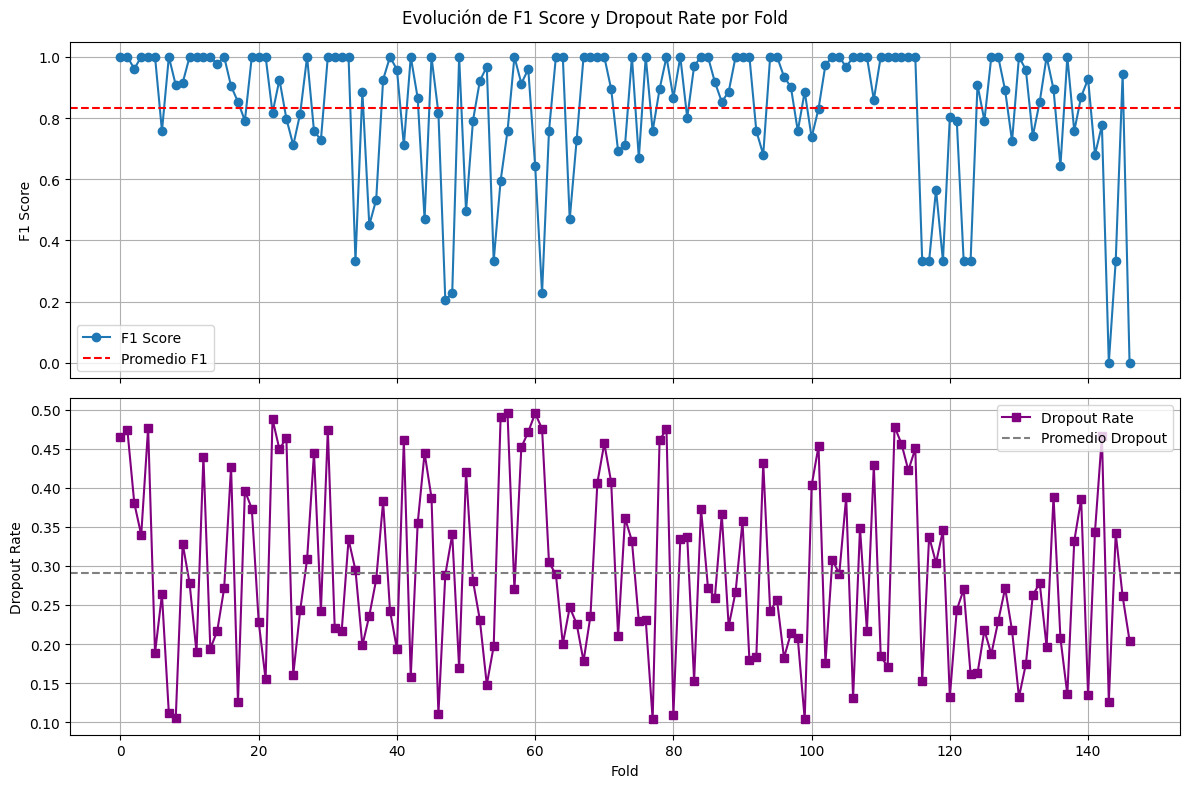

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Cargar archivo de resultados generado por el script
results_path = os.path.join(os.getcwd(), "results_walkforward_weekly_keras_optuna.csv")

# Cargar en DataFrame
df_results = pd.read_csv(results_path)

# Visualización extendida en otra fila: mostrar métricas y dropout por fold
fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# F1 Score
axs[0].plot(df_results["F1_Score"], marker='o', label='F1 Score')
axs[0].axhline(df_results["F1_Score"].mean(), color='red', linestyle='--', label='Promedio F1')
axs[0].set_ylabel('F1 Score')
axs[0].legend()
axs[0].grid(True)

# Dropout
axs[1].plot(df_results["Dropout"], marker='s', color='purple', label='Dropout Rate')
axs[1].axhline(df_results["Dropout"].mean(), color='gray', linestyle='--', label='Promedio Dropout')
axs[1].set_xlabel('Fold')
axs[1].set_ylabel('Dropout Rate')
axs[1].legend()
axs[1].grid(True)

plt.suptitle('Evolución de F1 Score y Dropout Rate por Fold')
plt.tight_layout()
plt.show()
